In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Edits (major):

# changed params file to boxsize 120 arcmin, dx = 4 for 2 degree patch, otherwise noise cov and pinv are taking 
# up too much space
# covariance matrix definition changed to the one below

In [3]:
import numpy as np, sys, os, scipy as sc, healpy as H, warnings, pickle, gzip
sys_folder = '../modules/'
sys.path.append(sys_folder)

import flatsky, tools, misc, moving_lens, inpaint, foregrounds as fg

import scipy.ndimage as ndimage
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

from colossus.cosmology import cosmology
from colossus.halo import concentration, mass_defs
cosmology.setCosmology('planck15')
from astropy.cosmology import FlatLambdaCDM

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
rcParams["figure.facecolor"] = 'white'
cmap = cm.RdYlBu_r

In [4]:
#others
perform_inpainting = False #True
use_pol_for_inpainting = False
mask = None
perform_oned_fitting = 1   

In [5]:
# read params file, if we need it

# params or supply a params file
paramfile = 'params_bullter_cluster.ini'

param_dict = misc.fn_get_param_dict(paramfile)

if not perform_oned_fitting:
    param_dict['boxsize'], param_dict['dx'] = 120., 2.

boxsize, dx = param_dict['boxsize'], param_dict['dx']
boxsize_am = boxsize
dls_file = param_dict['dls_file']
lmax, nside =  param_dict['lmax'],  param_dict['nside']
mask_file = param_dict['mask_file']

In [6]:
#get ra, dec or map-pixel grid
nx = int(boxsize_am/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx

ra_for_grid = np.linspace(x1,x2, nx)/60.
dec_for_grid = np.linspace(x1,x2, nx)/60.
ra_grid, dec_grid = np.meshgrid(ra_for_grid,dec_for_grid)

In [7]:
#read Cls now
if (0):#not use_pol_for_inpainting:
    el, dl = np.loadtxt(dls_file, usecols = [0,1], unpack = 1)
else:
    el, dl_tt, dl_ee, dl_bb, dl_te  = np.loadtxt(dls_file, unpack = 1)
    dl_all = np.asarray([dl_tt, dl_ee, dl_bb, dl_te])

dl_fac = el * (el + 1) / 2 / np.pi
cl_all = dl_all / dl_fac * 1e12
cl_tt, cl_ee, cl_bb, cl_te = cl_all
print(len(el), cl_tt.shape)

27658 (27658,)


In [8]:
# Set up beam

beamval = 1.2 #arcmins
bl2d = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)

In [9]:
# Set up noise

noiseval = 2.0 #uK-arcmin
noofsims_for_cov = 1000 #1500

nl = tools.get_nl(noiseval, el)

In [10]:
# Set up sims for noise covariance matrix

noise_sims = list()

for i in tqdm(range(noofsims_for_cov)):
    noise_map = flatsky.make_gaussian_realisation(mapparams, el, nl)
    noise_sims.append(noise_map)
    
npix = nx ** 2
noise_sims = np.asarray(noise_sims).flatten().reshape(noofsims_for_cov, npix)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3779.70it/s]


In [11]:
# ask -- the calcCov function in this version of tools uses sample covariance not population covariance??
# also using calcCov takes up too much memory space (26GB +) for such a numpy matrix. I used direct matmul instead.
# verify that this is a viable alternative; still a very big matrix.

noise_cov = np.matmul(noise_sims.T , noise_sims) / (noofsims_for_cov)
noise_cov.shape

(900, 900)

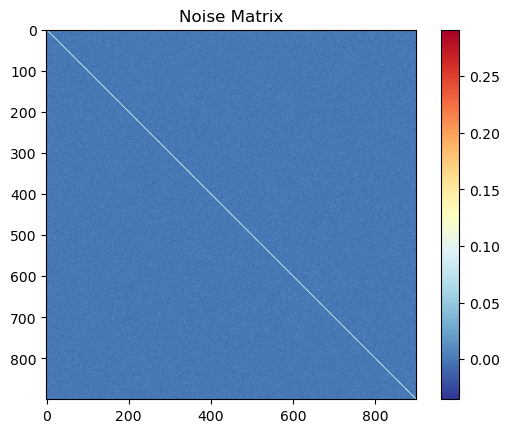

In [21]:
plt.imshow(noise_cov, cmap = cmap); colorbar(); title("Noise Matrix"); show()

---------------

In [12]:
# Simulate the Moving Lens signal

# There are 2 clusters in Bullet cluster
M200c_bullet_1, M200c_bullet_2 = 1.5e15, 1.5e14
redshift_1, redshift_2 = 0.296, 0.296
#redshift_1, redshift_2 = 2., 2.
v_phi_1, v_th_1 = 0., 4500.
phi_1, theta_1 = 0., 0.
v_phi_2, v_th_2 = 0., 4500. 
phi_2, theta_2 = 0., 0.

M200c = [M200c_bullet_1]#, M200c_bullet_2]
redshift = [redshift_1]#, redshift_2]
v_phi = [v_phi_1]#, v_phi_2]
v_th = [v_th_1]#, v_th_2]    
phi = [phi_1]#, phi_2]
theta = [theta_1]#, theta_2]

# Run 1 simulation for now
noofclus = len(M200c)

In [13]:
# get the moving lens dipole
ra_list = dec_list = np.zeros(len(M200c)) #cluster always at centre
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, param_dict, bl = bl2d)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)
if (1): #repeat the same for all sims
    print(noofclus)
    mvl_arr = np.repeat(mvl_arr, noofclus, axis = 0)
    vel_dir_arr = np.repeat(vel_dir_arr, noofclus, axis = 0)
    vel_mag_arr = np.repeat(vel_mag_arr, noofclus, axis = 0)
    M200c = np.repeat(M200c, noofclus, axis = 0)
    redshift = np.repeat(redshift, noofclus, axis = 0)
    v_phi = np.repeat(v_phi, noofclus, axis = 0)
    v_th = np.repeat(v_th, noofclus, axis = 0)
    phi = np.repeat(phi, noofclus, axis = 0)
    theta = np.repeat(theta, noofclus, axis = 0)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 0.00024515787760416666
check me. 
		time taken for get dot product = 2.1930535634358724e-05
(1, 30, 30) (1,) (1,)
1
(1, 30, 30) (1,) (1,)


/home/dchanda2002/MovingLensBC/transverse_velocity/scripts/../modules/moving_lens.py:623: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pvec_tmp = np.asarray( [phi, theta, 0.] )


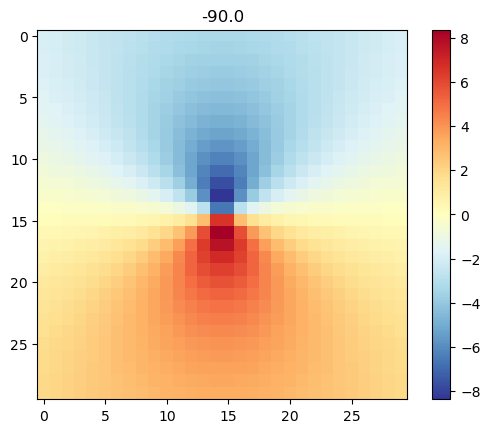

In [14]:
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title(vel_dir_arr[0]); show()

-----------------

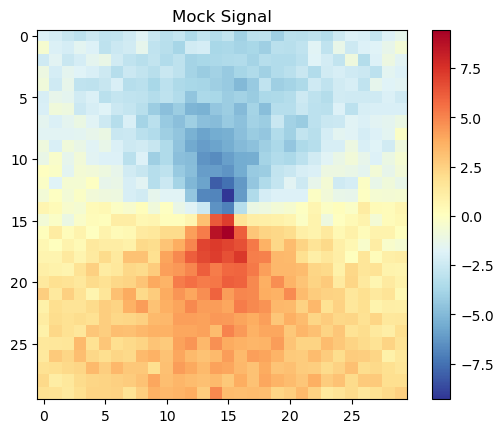

In [15]:
# Make a mock

ml_signal = mvl_arr[0]
noise_signal = flatsky.make_gaussian_realisation(mapparams, el, nl)
mock_signal = ml_signal + noise_signal
plt.imshow(mock_signal, cmap = cmap); colorbar(); title("Mock Signal"); show()

In [16]:
# Attempt a simple Emcee with amplitude of ML signal(even though there's just one param here :/ but at least it samples the
# distribution)

# To save shallow copy space, use global memory for now

cov = noise_cov
cov_inv = np.linalg.pinv(cov)
data = mock_signal

def log_likelihood(amplitude):
    # cov_inv = np.ones_like(noise_cov)  # for testing

    d = data.flatten() ## - np.mean(MAP.flatten())
    m = amplitude * ml_signal.flatten() ## - np.mean(MODEL.flatten())
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amplitude):
    if (amplitude < 5) & (amplitude > -5):
        return 0.0     # permit
    return -np.inf     # do not permit

def log_probability(amplitude):
    prior = log_prior(amplitude)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(amplitude)


In [17]:
sample_amp = np.arange(-5,5,0.1)
likelihood = [log_likelihood(amp) for amp in tqdm(sample_amp)]

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8157.27it/s]


In [18]:
like = likelihood - max(likelihood)
like = np.exp(like)
like/=max(like)
amp_mode=sample_amp[np.argmax(like)]

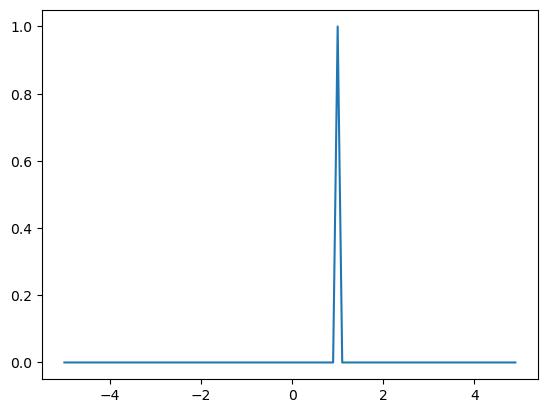

In [23]:
plt.plot(sample_amp, like)

In [24]:
# Then try using emcee

from multiprocessing import Pool

initial = np.random.rand(32, 1) + 0.5  # centered around an amplitude of 1
nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = "notebook")
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 1000, progress = 'notebook')
    samples = sampler.get_chain(flat = True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 6.000e+00, 6.000e+00,
        6.000e+00, 1.300e+01, 1.200e+01, 3.400e+01, 2.200e+01, 3.600e+01,
        1.100e+01, 4.300e+01, 4.800e+01, 4.300e+01, 7.400e+01, 5.600e+01,
        6.100e+01, 9.500e+01, 9.000e+01, 1.470e+02, 1.500e+02, 2.080e+02,
        2.220e+02, 2.720e+02, 2.830e+02, 3.730e+02, 3.510e+02, 4.360e+02,
        4.690e+02, 5.040e+02, 6.110e+02, 6.110e+02, 6.690e+02, 6.550e+02,
        7.400e+02, 7.530e+02, 7.870e+02, 8.770e+02, 8.220e+02, 9.350e+02,
        9.400e+02, 9.140e+02, 9.750e+02, 9.840e+02, 9.640e+02, 1.012e+03,
        9.720e+02, 8.920e+02, 8.760e+02, 9.150e+02, 8.650e+02, 8.440e+02,
        8.240e+02, 8.140e+02, 7.140e+02, 6.790e+02, 6.740e+02, 6.370e+02,
        5.220e+02, 4.750e+02, 4.600e+02, 4.270e+02, 4.220e+02, 3.260e+02,
        2.670e+02, 3.350e+02, 2.900e+02, 2.260e+02, 2.130e+02, 1.500e+02,
        1.510e+02, 1.180e+02, 9.300e+0

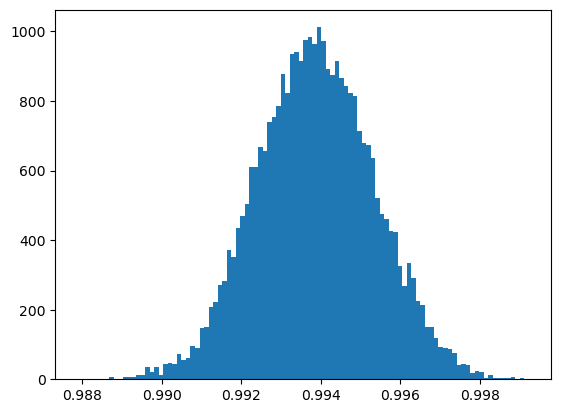

In [26]:
plt.hist(samples, bins = 100)
plt.show()

In [28]:
sixteen = np.percentile(samples, 16.)
eightyfour = np.percentile(samples, 84.)
mean = np.percentile(samples, 50.) # not really mean; change later
lowerr = mean - sixteen
higherr = eightyfour - mean

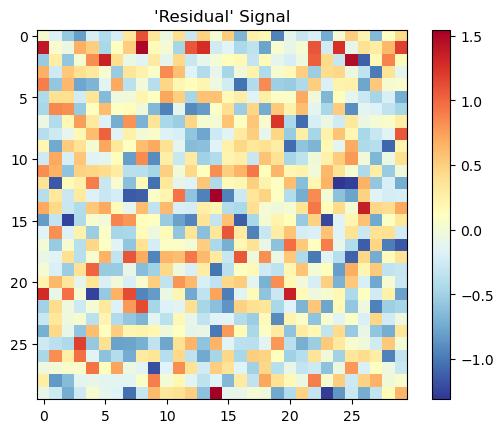

In [29]:
plt.imshow(mock_signal - amp_mode*ml_signal, cmap = cmap); colorbar(); title("\'Residual\' Signal"); show()

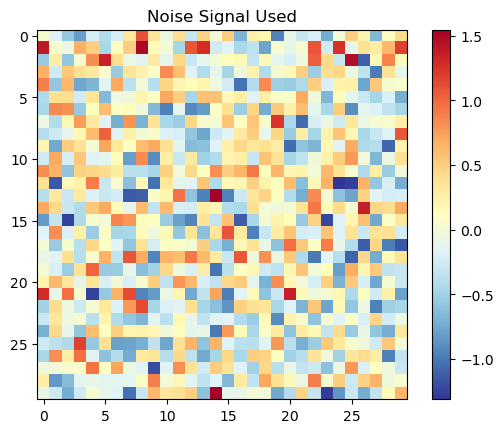

In [30]:
plt.imshow(noise_signal, cmap = cmap); colorbar(); title("Noise Signal Used"); show()

---------------

In [36]:
# Attempt a simple Emcee with mass and velocity characteristics (2 params)

# To save shallow copy space, use global memory for now
cov = noise_cov
cov_inv = np.linalg.pinv(cov)
data = mock_signal

def log_likelihood(theta):
    
    velocity, mass = theta
    d = data.flatten() ## - np.mean(MAP.flatten())
    
    v_phi = [v_phi_1]
    phi = [phi_1]
    theta = [theta_1]
    redshift = [redshift_1]
    
    M200c = [mass]
    v_th = [velocity]
    
    noofclus = len(M200c)
    ra_list = dec_list = np.zeros(len(M200c))
    
    mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, 
                                                    dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, 
                                                    param_dict, bl = bl2d)
    m = mvl_arr[0].flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(theta):
    velocity, mass = theta
    if (velocity < 6000) & (velocity > 3000) & (mass < 1.5e16) & (mass > 1.5e14):
        return 0.0     # permit
    return -np.inf     # do not permit

def log_probability(theta):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(theta)


In [37]:
v_init = (np.random.rand(32, 1) - 0.5) *500 + 4500
m_init = (np.random.rand(32, 1) - 0.5) *5e14 + 1.5e15
initial = np.hstack([v_init, m_init])

In [38]:
# Try using emcee

from multiprocessing import Pool

nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = True)
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 300, progress = True)
    samples = sampler.get_chain(flat = True)

0.00.00.00.00.00.00.00.00.00.0  0.0   0.0   0.0 0.00.0  0.00.00.0 0.0
0.00.0
0.00.0





0.0



		time taken for gettting deflection vector = 8.213122685750326e-05		time taken for gettting deflection vector = 7.500251134236653e-05		time taken for gettting deflection vector = 8.430083592732747e-05		time taken for gettting deflection vector = 8.754730224609375e-05		time taken for gettting deflection vector = 0.00010124444961547851		time taken for gettting deflection vector = 0.0001100460688273112		time taken for gettting deflection vector = 9.414354960123698e-05		time taken for gettting deflection vector = 9.938478469848633e-05
		time taken for gettting deflection vector = 9.502967198689778e-05




		time taken for gettting deflection vector = 0.00013608535130818684		time taken for gettting deflection vector = 8.524258931477865e-05		time taken for gettting deflection vector = 8.683999379475912e-05





check me. check me. check me. 
check me. 
check me. 		time taken for get dot product =

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]

0.00.00.00.00.00.00.00.0 0.0  0.00.00.0   0.0 0.00.00.0  0.0 
0.0


 
0.00.0		time taken for gettting deflection vector = 6.064573923746745e-05
		time taken for gettting deflection vector = 4.701614379882812e-050.0
		time taken for gettting deflection vector = 8.656978607177735e-05		time taken for gettting deflection vector = 5.55872917175293e-05
		time taken for gettting deflection vector = 5.1744778951009114e-05
0.0		time taken for gettting deflection vector = 8.027950922648111e-05 0.0





		time taken for gettting deflection vector = 4.793405532836914e-05
0.0
		time taken for gettting deflection vector = 5.240440368652344e-05		time taken for gettting deflection vector = 5.290508270263672e-05
		time taken for gettting deflection vector = 4.907051722208659e-05		time taken for gettting deflection vector = 8.978048960367838e-05




		time taken for gettting deflection vector = 5.4275989532470704e-05
check me. 
check me. 		time taken for get dot product = 5.68230946858724e-07
0.0 
check

  1%|▊                                                                                  | 1/100 [00:01<02:32,  1.54s/it]

0.00.00.0 0.00.0 0.0  0.0  0.00.0 0.00.00.0
 0.00.0		time taken for gettting deflection vector = 6.00894292195638e-050.0

0.00.0

 
  		time taken for gettting deflection vector = 5.166530609130859e-05		time taken for gettting deflection vector = 5.003213882446289e-050.0
 0.0

0.0		time taken for gettting deflection vector = 5.281368891398112e-050.0

0.0

0.00.0		time taken for gettting deflection vector = 6.515979766845703e-05
		time taken for gettting deflection vector = 5.0230820973714194e-05
		time taken for gettting deflection vector = 4.8212210337320964e-05		time taken for gettting deflection vector = 5.8527787526448565e-05
		time taken for gettting deflection vector = 6.029605865478516e-05
		time taken for gettting deflection vector = 6.29583994547526e-05
		time taken for gettting deflection vector = 4.909833272298177e-05



		time taken for gettting deflection vector = 6.611347198486328e-05

check me. 
		time taken for get dot product = 1.0251998901367187e-06
0.0check me.  0.0


  2%|█▋                                                                                 | 2/100 [00:03<02:28,  1.52s/it]

0.00.00.00.00.0 0.0 0.00.0 
		time taken for gettting deflection vector = 7.852713267008464e-05  0.00.00.0 
 0.00.00.0 0.0
0.0




0.0		time taken for gettting deflection vector = 8.136828740437826e-05		time taken for gettting deflection vector = 8.435646692911784e-05 0.0
		time taken for gettting deflection vector = 6.815592447916667e-05
		time taken for gettting deflection vector = 7.061560948689779e-05		time taken for gettting deflection vector = 0.0001048286755879720.0
		time taken for gettting deflection vector = 7.755756378173828e-050.00.0  0.0

0.0



		time taken for gettting deflection vector = 7.634162902832031e-05

 		time taken for gettting deflection vector = 5.184014638264974e-05		time taken for gettting deflection vector = 7.037719090779622e-05		time taken for gettting deflection vector = 5.100170771280924e-05

0.0

		time taken for gettting deflection vector = 5.042552947998047e-05
check me. 
		time taken for get dot product = 4.927317301432292e-07
check me. 
		time tak

  3%|██▍                                                                                | 3/100 [00:04<02:34,  1.59s/it]

0.00.00.00.00.00.0   0.0 0.00.0  0.00.0 
0.00.00.00.00.00.0

 
 0.0  0.00.0

		time taken for gettting deflection vector = 5.4784615834554036e-050.0		time taken for gettting deflection vector = 4.9297014872233076e-05		time taken for gettting deflection vector = 6.59942626953125e-05

0.0
0.0
		time taken for gettting deflection vector = 6.69558842976888e-05		time taken for gettting deflection vector = 5.631446838378906e-05

		time taken for gettting deflection vector = 7.679462432861329e-05 		time taken for gettting deflection vector = 8.43644142150879e-05




0.0		time taken for gettting deflection vector = 6.252129872639974e-05
		time taken for gettting deflection vector = 6.248950958251954e-05

		time taken for gettting deflection vector = 6.275177001953125e-05
		time taken for gettting deflection vector = 0.0007297396659851074		time taken for gettting deflection vector = 0.00015394290288289387


check me. 
		time taken for get dot product = 5.523363749186198e-07
0.0 0.0
check me. ch

  4%|███▎                                                                               | 4/100 [00:06<02:39,  1.66s/it]

0.00.00.0 0.00.0 0.00.00.0 0.00.00.00.0 0.0 0.0

0.0 		time taken for gettting deflection vector = 5.5460135142008465e-05 0.00.0		time taken for gettting deflection vector = 4.946788152058919e-05
 
0.0   

0.0
0.0 
0.00.0		time taken for gettting deflection vector = 5.205074946085612e-05		time taken for gettting deflection vector = 4.9102306365966794e-05
		time taken for gettting deflection vector = 5.514621734619141e-05		time taken for gettting deflection vector = 5.616346995035807e-05



		time taken for gettting deflection vector = 0.000128960609436035150.0


		time taken for gettting deflection vector = 5.606412887573242e-050.0		time taken for gettting deflection vector = 5.1744778951009114e-05

		time taken for gettting deflection vector = 9.661515553792318e-05



		time taken for gettting deflection vector = 4.762411117553711e-05		time taken for gettting deflection vector = 5.188783009847005e-05

check me. check me. 
check me. 		time taken for get dot product = 6.596247355143229e

  5%|████▏                                                                              | 5/100 [00:08<02:37,  1.66s/it]

0.00.00.00.0 0.0  0.00.00.00.00.00.0
0.0 0.00.0 0.0
 0.0
 
 0.00.0  		time taken for gettting deflection vector = 0.00019191106160481770.0
0.0		time taken for gettting deflection vector = 5.529324213663737e-05 		time taken for gettting deflection vector = 5.2658716837565106e-05
0.0 

0.0
		time taken for gettting deflection vector = 5.458196004231771e-05


		time taken for gettting deflection vector = 5.9552987416585286e-05

0.0		time taken for gettting deflection vector = 5.2038828531901045e-05		time taken for gettting deflection vector = 5.1875909169514976e-05		time taken for gettting deflection vector = 5.693833033243815e-05


0.0		time taken for gettting deflection vector = 5.596478780110677e-05
		time taken for gettting deflection vector = 5.160967508951823e-05

		time taken for gettting deflection vector = 5.762974421183268e-05


		time taken for gettting deflection vector = 5.530913670857747e-05
check me. 
		time taken for get dot product = 8.344650268554688e-07
0.0
check me. ch

  6%|████▉                                                                              | 6/100 [00:09<02:36,  1.67s/it]

0.00.00.00.00.00.0   0.00.0  0.0 0.00.00.00.00.0  0.0



0.0
0.0
0.00.0
		time taken for gettting deflection vector = 4.951953887939453e-05		time taken for gettting deflection vector = 7.661581039428711e-05		time taken for gettting deflection vector = 4.952351252237956e-05		time taken for gettting deflection vector = 4.913012186686198e-05
		time taken for gettting deflection vector = 7.936954498291015e-05
		time taken for gettting deflection vector = 5.8090686798095704e-05

0.0		time taken for gettting deflection vector = 5.2917003631591794e-05		time taken for gettting deflection vector = 7.738272349039713e-05

   
0.0
0.0
 0.0


0.0		time taken for gettting deflection vector = 0.00010000467300415039

		time taken for gettting deflection vector = 4.998445510864258e-05		time taken for gettting deflection vector = 5.678335825602213e-05

		time taken for gettting deflection vector = 6.098747253417969e-05
check me. 
		time taken for get dot product = 5.523363749186198e-07
0.0check me. chec

  7%|█████▊                                                                             | 7/100 [00:11<02:35,  1.67s/it]

0.00.00.00.00.00.00.00.00.0    0.0 0.0
0.00.00.0   0.0		time taken for gettting deflection vector = 5.0338109334309894e-05 

0.0 
0.0 0.0
0.0		time taken for gettting deflection vector = 6.215174992879232e-050.0		time taken for gettting deflection vector = 5.100568135579427e-05

 

		time taken for gettting deflection vector = 6.427764892578126e-05		time taken for gettting deflection vector = 0.00014081398646036784		time taken for gettting deflection vector = 5.042155583699544e-05
0.0



0.0		time taken for gettting deflection vector = 5.3052107493082685e-05
0.0		time taken for gettting deflection vector = 7.223288218180338e-05

0.0		time taken for gettting deflection vector = 7.660786310831706e-05



		time taken for gettting deflection vector = 5.632241566975911e-05		time taken for gettting deflection vector = 9.721120198567709e-05		time taken for gettting deflection vector = 0.0001660029093424479


check me. 
		time taken for get dot product = 5.80151875813802e-07
check me. 0.0check

  8%|██████▋                                                                            | 8/100 [00:13<02:33,  1.67s/it]

0.00.00.00.00.00.00.00.00.00.00.0     0.0 0.00.0

0.0 0.00.0  
0.0
		time taken for gettting deflection vector = 5.83648681640625e-05
0.00.0		time taken for gettting deflection vector = 5.0854682922363284e-05

		time taken for gettting deflection vector = 5.5452187856038414e-05		time taken for gettting deflection vector = 5.963643391927083e-05


		time taken for gettting deflection vector = 4.892349243164062e-05



		time taken for gettting deflection vector = 5.4883956909179685e-05 0.0
 		time taken for gettting deflection vector = 5.6791305541992185e-05		time taken for gettting deflection vector = 8.96294911702474e-05 		time taken for gettting deflection vector = 4.943211873372396e-050.0

0.0

		time taken for gettting deflection vector = 5.072355270385742e-050.0
		time taken for gettting deflection vector = 8.891026178995769e-05

		time taken for gettting deflection vector = 5.2034854888916016e-05

check me. 
		time taken for get dot product = 5.920728047688802e-07check me. 

		time

  9%|███████▍                                                                           | 9/100 [00:14<02:28,  1.63s/it]

0.00.00.00.0   0.00.00.00.0  
0.0
0.0 0.0
 0.0		time taken for gettting deflection vector = 4.9618879954020184e-050.0		time taken for gettting deflection vector = 4.910628000895182e-050.0 
0.00.0  
		time taken for gettting deflection vector = 6.318092346191406e-050.0

0.0
 0.00.00.0 		time taken for gettting deflection vector = 5.080699920654297e-050.00.0		time taken for gettting deflection vector = 5.6238969167073566e-05
0.0

		time taken for gettting deflection vector = 4.8212210337320964e-05






		time taken for gettting deflection vector = 5.891720453898112e-05		time taken for gettting deflection vector = 7.377465565999349e-05		time taken for gettting deflection vector = 5.269050598144531e-05		time taken for gettting deflection vector = 6.07450803120931e-05
		time taken for gettting deflection vector = 5.1081180572509766e-05		time taken for gettting deflection vector = 5.771716435750326e-05




check me. check me. check me. 
		time taken for get dot product = 1.5377998352050782e

 10%|████████▏                                                                         | 10/100 [00:16<02:22,  1.58s/it]

0.00.00.00.00.00.0  0.00.00.0
0.00.0   0.0   
0.0		time taken for gettting deflection vector = 4.739761352539063e-050.0
0.00.00.0
0.0
		time taken for gettting deflection vector = 5.0862630208333336e-05		time taken for gettting deflection vector = 4.856586456298828e-05
0.0
		time taken for gettting deflection vector = 5.951722462972005e-05 		time taken for gettting deflection vector = 4.9392382303873696e-05 

 		time taken for gettting deflection vector = 4.650354385375977e-05

		time taken for gettting deflection vector = 4.800558090209961e-050.00.0



 0.0
		time taken for gettting deflection vector = 5.925893783569336e-05		time taken for gettting deflection vector = 4.8061211903889976e-05
0.0
		time taken for gettting deflection vector = 6.0629844665527346e-05

0.0

		time taken for gettting deflection vector = 5.0739447275797525e-05
		time taken for gettting deflection vector = 5.0580501556396486e-05
check me. 
check me. 		time taken for get dot product = 5.284945170084636e-07

0.0

 11%|█████████                                                                         | 11/100 [00:17<02:17,  1.54s/it]

0.00.00.00.0 0.00.0 0.00.0 0.0
 0.0
0.00.0 0.0
0.0 		time taken for gettting deflection vector = 5.2336851755778e-05		time taken for gettting deflection vector = 4.836718241373698e-050.0 0.0
 
0.00.0		time taken for gettting deflection vector = 5.717277526855469e-05 0.0		time taken for gettting deflection vector = 4.94082768758138e-05


0.0 

0.0
 0.00.0 

		time taken for gettting deflection vector = 5.622704823811849e-05		time taken for gettting deflection vector = 5.1180521647135414e-05		time taken for gettting deflection vector = 4.8267841339111325e-05

		time taken for gettting deflection vector = 4.9785772959391275e-05
		time taken for gettting deflection vector = 5.6680043538411455e-05

0.0

		time taken for gettting deflection vector = 5.0063927968343096e-05
		time taken for gettting deflection vector = 5.02467155456543e-05

		time taken for gettting deflection vector = 5.4669380187988284e-05
check me. check me. 
check me. 		time taken for get dot product = 5.80151875813802e-07

 12%|█████████▊                                                                        | 12/100 [00:19<02:16,  1.56s/it]

0.00.00.00.00.00.00.00.0   0.0
 0.00.00.0 0.0
		time taken for gettting deflection vector = 5.267858505249023e-05 0.00.00.0 
  
0.0

		time taken for gettting deflection vector = 5.015929539998372e-05

0.0
		time taken for gettting deflection vector = 4.74095344543457e-050.0		time taken for gettting deflection vector = 7.094939549763997e-05 
0.00.0		time taken for gettting deflection vector = 6.512006123860677e-05
		time taken for gettting deflection vector = 5.307992299397786e-050.0 

 
		time taken for gettting deflection vector = 7.60634740193685e-05
0.00.0


		time taken for gettting deflection vector = 6.325244903564453e-05
		time taken for gettting deflection vector = 5.486011505126953e-05		time taken for gettting deflection vector = 4.910628000895182e-05


		time taken for gettting deflection vector = 7.670720418294271e-05
		time taken for gettting deflection vector = 5.328655242919922e-05
check me. 
		time taken for get dot product = 5.68230946858724e-07
0.0 0.0check me. check 

 13%|██████████▋                                                                       | 13/100 [00:20<02:13,  1.54s/it]

0.00.00.00.00.0  0.0  0.00.0
0.0 0.0
0.00.00.00.0 

		time taken for gettting deflection vector = 5.958477656046549e-05

 0.00.0


		time taken for gettting deflection vector = 4.781484603881836e-05
		time taken for gettting deflection vector = 5.320310592651367e-050.0		time taken for gettting deflection vector = 4.924535751342774e-05		time taken for gettting deflection vector = 4.998445510864258e-05  0.00.0 
		time taken for gettting deflection vector = 5.2762031555175784e-050.00.00.0 
 0.0		time taken for gettting deflection vector = 5.43673833211263e-05

		time taken for gettting deflection vector = 5.215009053548177e-05
0.0


		time taken for gettting deflection vector = 5.01553217569987e-05		time taken for gettting deflection vector = 5.391438802083333e-05


		time taken for gettting deflection vector = 6.217161814371744e-05

		time taken for gettting deflection vector = 5.0020217895507815e-05
check me. 
		time taken for get dot product = 5.563100179036459e-07
0.0 0.0
		time taken

 14%|███████████▍                                                                      | 14/100 [00:22<02:11,  1.53s/it]

0.00.0 0.0 0.0 0.0
0.00.00.00.00.00.0 0.00.0		time taken for gettting deflection vector = 5.2038828531901045e-05 0.0  
0.00.0 

		time taken for gettting deflection vector = 5.2917003631591794e-05
0.0		time taken for gettting deflection vector = 4.786252975463867e-05
0.00.0
		time taken for gettting deflection vector = 5.129575729370117e-05

0.0

  		time taken for gettting deflection vector = 8.259216944376628e-05
 0.0		time taken for gettting deflection vector = 7.553497950236003e-05 		time taken for gettting deflection vector = 7.750988006591797e-05
0.00.0
0.0

		time taken for gettting deflection vector = 7.93298085530599e-05		time taken for gettting deflection vector = 8.481343587239584e-05


		time taken for gettting deflection vector = 8.838971455891927e-05		time taken for gettting deflection vector = 9.154081344604492e-05



		time taken for gettting deflection vector = 7.05718994140625e-05
check me. 
		time taken for get dot product = 5.443890889485677e-07check me. 
check me. 

 15%|████████████▎                                                                     | 15/100 [00:23<02:09,  1.53s/it]

0.00.00.00.0 0.00.0 0.0 0.0 0.00.00.00.0 0.0  
0.0

0.00.00.00.00.0		time taken for gettting deflection vector = 5.447864532470703e-05		time taken for gettting deflection vector = 5.702972412109375e-05   
		time taken for gettting deflection vector = 6.0959657033284506e-05



0.00.0 

		time taken for gettting deflection vector = 4.7258536020914714e-05
		time taken for gettting deflection vector = 5.5909156799316406e-05
0.00.0		time taken for gettting deflection vector = 5.4113070170084636e-05		time taken for gettting deflection vector = 5.47329584757487e-05		time taken for gettting deflection vector = 5.3040186564127605e-05





		time taken for gettting deflection vector = 4.868507385253906e-05 0.0		time taken for gettting deflection vector = 5.6521097819010416e-05


		time taken for gettting deflection vector = 4.8883756001790364e-05		time taken for gettting deflection vector = 6.364186604817708e-05


check me. check me. 

		time taken for get dot product = 5.523363749186198e-07chec

 16%|█████████████                                                                     | 16/100 [00:25<02:08,  1.53s/it]

0.00.00.00.0  0.00.0  0.00.00.00.00.0
0.00.0
 0.0
0.0 0.0		time taken for gettting deflection vector = 4.9567222595214845e-05 
 
0.0		time taken for gettting deflection vector = 5.117654800415039e-05
		time taken for gettting deflection vector = 7.855494817097982e-05 0.00.0

   0.00.0
0.0
0.00.0		time taken for gettting deflection vector = 0.00010281801223754883
		time taken for gettting deflection vector = 5.246400833129883e-05

		time taken for gettting deflection vector = 5.200306574503581e-05		time taken for gettting deflection vector = 5.818605422973633e-05


		time taken for gettting deflection vector = 5.1462650299072264e-05

		time taken for gettting deflection vector = 4.796584447224935e-05

		time taken for gettting deflection vector = 5.12083371480306e-05		time taken for gettting deflection vector = 5.2988529205322266e-05		time taken for gettting deflection vector = 6.075302759806315e-05



check me. 
		time taken for get dot product = 5.523363749186198e-07
0.0check me. 
 ch

 17%|█████████████▉                                                                    | 17/100 [00:26<02:05,  1.51s/it]

0.0 0.00.00.00.00.0
 0.00.00.0		time taken for gettting deflection vector = 5.559921264648437e-05 
 0.00.00.00.00.0 0.00.0
  0.0

0.0		time taken for gettting deflection vector = 6.477832794189453e-05  		time taken for gettting deflection vector = 5.365610122680664e-05
		time taken for gettting deflection vector = 5.8269500732421876e-05



		time taken for gettting deflection vector = 5.0230820973714194e-050.0 		time taken for gettting deflection vector = 4.755258560180664e-05
0.0

0.0		time taken for gettting deflection vector = 5.4264068603515624e-05		time taken for gettting deflection vector = 4.8542022705078124e-05

 
0.00.0


		time taken for gettting deflection vector = 7.812976837158203e-05		time taken for gettting deflection vector = 8.475383122762045e-05

		time taken for gettting deflection vector = 7.851521174112956e-05 
0.0
		time taken for gettting deflection vector = 3.864765167236328e-05
check me. 
check me. 
		time taken for get dot product = 6.477038065592448e-07		time

 18%|██████████████▊                                                                   | 18/100 [00:28<02:04,  1.52s/it]

0.0 0.00.00.00.00.00.0 0.00.00.00.0 0.00.00.00.0 0.0  
0.0 


 0.0 		time taken for gettting deflection vector = 4.845857620239258e-05		time taken for gettting deflection vector = 6.0375531514485674e-05
0.0 
		time taken for gettting deflection vector = 5.090634028116862e-050.0
0.0


		time taken for gettting deflection vector = 4.8724810282389325e-05
		time taken for gettting deflection vector = 4.8112869262695315e-05
		time taken for gettting deflection vector = 4.655917485555013e-05
 		time taken for gettting deflection vector = 5.111296971638997e-05		time taken for gettting deflection vector = 5.122820536295573e-05


		time taken for gettting deflection vector = 4.76678212483724e-05

 0.00.00.0


		time taken for gettting deflection vector = 5.1522254943847655e-05		time taken for gettting deflection vector = 6.501277287801107e-05

		time taken for gettting deflection vector = 5.5174032847086586e-05
check me. check me. 

		time taken for get dot product = 4.927317301432292e-07		time

 19%|███████████████▌                                                                  | 19/100 [00:29<02:03,  1.53s/it]

0.00.00.00.00.0 0.00.00.0 0.0 0.00.0 
0.00.0 
 0.00.0
0.0

 		time taken for gettting deflection vector = 4.9451986948649086e-05
0.0		time taken for gettting deflection vector = 4.976987838745117e-05		time taken for gettting deflection vector = 4.73936398824056e-05		time taken for gettting deflection vector = 5.0969918568929036e-05



		time taken for gettting deflection vector = 5.2197774251302084e-05		time taken for gettting deflection vector = 5.0659974416097e-05
  		time taken for gettting deflection vector = 4.8613548278808595e-05 0.0
0.0
		time taken for gettting deflection vector = 4.882017771402995e-05
0.0

0.0 
0.00.0		time taken for gettting deflection vector = 5.2658716837565106e-05 		time taken for gettting deflection vector = 5.307992299397786e-05
0.0



		time taken for gettting deflection vector = 6.627639134724935e-05		time taken for gettting deflection vector = 6.333192189534505e-05

check me. check me. 
		time taken for get dot product = 5.443890889485677e-07

		time 

 20%|████████████████▍                                                                 | 20/100 [00:31<02:03,  1.55s/it]

0.00.00.0  0.00.00.00.0 0.0   0.00.00.0

0.0
		time taken for gettting deflection vector = 5.155404408772786e-050.0

		time taken for gettting deflection vector = 5.964835484822591e-05

0.0		time taken for gettting deflection vector = 4.6594937642415365e-050.0
0.0		time taken for gettting deflection vector = 5.33143679300944e-05		time taken for gettting deflection vector = 4.543066024780274e-05 0.0  0.0 0.0 0.00.0		time taken for gettting deflection vector = 5.3715705871582034e-05
0.0

0.00.0

		time taken for gettting deflection vector = 5.041360855102539e-05
 

		time taken for gettting deflection vector = 5.1867961883544925e-05		time taken for gettting deflection vector = 5.5690606435139976e-05




		time taken for gettting deflection vector = 5.944967269897461e-05		time taken for gettting deflection vector = 5.1685174306233724e-05		time taken for gettting deflection vector = 5.336602528889974e-05


check me. 
check me. 		time taken for get dot product = 6.079673767089843e-07

		tim

 21%|█████████████████▏                                                                | 21/100 [00:33<02:04,  1.57s/it]

0.00.00.00.00.00.00.00.00.0 0.0 0.0 0.0   0.0 0.00.0

0.0 0.0
 0.0		time taken for gettting deflection vector = 5.687475204467774e-050.0  0.0 

0.0		time taken for gettting deflection vector = 5.604823430379232e-050.0		time taken for gettting deflection vector = 8.628368377685546e-05

0.0


0.0
		time taken for gettting deflection vector = 9.444554646809896e-05		time taken for gettting deflection vector = 0.00011563698450724283


		time taken for gettting deflection vector = 4.9908955891927086e-05
		time taken for gettting deflection vector = 5.3540865580240885e-05		time taken for gettting deflection vector = 7.71800676981608e-05

		time taken for gettting deflection vector = 8.780558904012045e-05		time taken for gettting deflection vector = 5.2185853322347003e-05


		time taken for gettting deflection vector = 5.565484364827474e-05


		time taken for gettting deflection vector = 5.2074591318766274e-05
check me. 
check me. 		time taken for get dot product = 7.311503092447917e-07
check 

 22%|██████████████████                                                                | 22/100 [00:34<02:04,  1.59s/it]

0.00.00.00.0  0.00.00.00.00.00.00.0  0.0 0.00.0  0.00.0
0.0  0.0

0.00.0 
0.0
		time taken for gettting deflection vector = 5.174875259399414e-05		time taken for gettting deflection vector = 6.279150644938151e-05
		time taken for gettting deflection vector = 4.7938028971354166e-050.0
 

 0.0		time taken for gettting deflection vector = 5.2928924560546875e-05


		time taken for gettting deflection vector = 4.811684290568034e-05		time taken for gettting deflection vector = 4.9908955891927086e-05
0.0

		time taken for gettting deflection vector = 4.775126775105794e-05		time taken for gettting deflection vector = 4.9058596293131514e-05		time taken for gettting deflection vector = 4.9444039662679035e-05		time taken for gettting deflection vector = 6.528298060099284e-05






		time taken for gettting deflection vector = 5.869468053181966e-05
		time taken for gettting deflection vector = 5.056460698445638e-05
check me. 
check me. 		time taken for get dot product = 6.477038065592448e-07
0.0
 

 23%|██████████████████▊                                                               | 23/100 [00:36<02:00,  1.57s/it]

0.00.00.00.00.00.00.0  0.00.00.0  0.0 
0.0
0.00.00.0

		time taken for gettting deflection vector = 5.027055740356445e-05  0.0
		time taken for gettting deflection vector = 4.90109125773112e-05  
 		time taken for gettting deflection vector = 5.5007139841715495e-050.0

		time taken for gettting deflection vector = 5.076328913370768e-050.00.0		time taken for gettting deflection vector = 5.794763565063477e-05


0.0		time taken for gettting deflection vector = 5.266269048055013e-050.0 


		time taken for gettting deflection vector = 5.368391672770182e-050.00.0 

0.0

		time taken for gettting deflection vector = 5.229711532592773e-05		time taken for gettting deflection vector = 4.847844441731771e-05

		time taken for gettting deflection vector = 5.3715705871582034e-05		time taken for gettting deflection vector = 5.310773849487305e-05


		time taken for gettting deflection vector = 5.6342283884684244e-05
check me. 
		time taken for get dot product = 5.880991617838542e-07
0.0check me.  chec

 24%|███████████████████▋                                                              | 24/100 [00:37<02:02,  1.61s/it]

0.00.0 0.00.00.00.00.00.0 0.0  0.00.00.00.00.0  0.0 0.0

 0.0
0.0
0.0		time taken for gettting deflection vector = 6.667375564575195e-05		time taken for gettting deflection vector = 5.671977996826172e-05 

0.00.0
 		time taken for gettting deflection vector = 7.980267206827799e-05		time taken for gettting deflection vector = 5.257129669189453e-05
 
0.0 		time taken for gettting deflection vector = 0.000114417076110839840.0
		time taken for gettting deflection vector = 5.087852478027344e-05
		time taken for gettting deflection vector = 5.1410992940266925e-05





0.0
		time taken for gettting deflection vector = 5.306402842203776e-05		time taken for gettting deflection vector = 5.5396556854248046e-05
		time taken for gettting deflection vector = 5.593697230021159e-05

		time taken for gettting deflection vector = 5.376736323038737e-05
		time taken for gettting deflection vector = 6.155967712402343e-05

check me. check me. 
		time taken for get dot product = 5.80151875813802e-07
check me

 25%|████████████████████▌                                                             | 25/100 [00:39<02:04,  1.66s/it]

0.00.0 0.00.00.0 0.00.00.00.00.00.0    0.0
 0.0 
0.00.00.00.0
0.0
0.0 0.0
		time taken for gettting deflection vector = 9.114742279052735e-05		time taken for gettting deflection vector = 5.270242691040039e-05 		time taken for gettting deflection vector = 6.20722770690918e-05
 		time taken for gettting deflection vector = 0.000112120310465494790.0


		time taken for gettting deflection vector = 5.048116048177083e-05
 
		time taken for gettting deflection vector = 7.127126057942708e-05
0.0


0.0		time taken for gettting deflection vector = 6.262063980102539e-05
0.0		time taken for gettting deflection vector = 6.647904713948567e-05		time taken for gettting deflection vector = 0.00012904008229573568		time taken for gettting deflection vector = 0.00013610521952311198


		time taken for gettting deflection vector = 5.962451299031576e-05
		time taken for gettting deflection vector = 5.1641464233398436e-05



check me. 
check me. 		time taken for get dot product = 6.039937337239583e-07
0.0
che

 26%|█████████████████████▎                                                            | 26/100 [00:41<02:08,  1.73s/it]

0.00.00.00.00.00.00.00.00.00.0       0.00.00.00.0
  0.00.0 
0.0


0.00.0		time taken for gettting deflection vector = 7.371107737223308e-05		time taken for gettting deflection vector = 5.3087870279947914e-05		time taken for gettting deflection vector = 6.0272216796875e-05
0.0 
0.0
		time taken for gettting deflection vector = 5.165338516235352e-05



0.0
 		time taken for gettting deflection vector = 5.6644280751546226e-05		time taken for gettting deflection vector = 5.3501129150390626e-05		time taken for gettting deflection vector = 4.909833272298177e-05
		time taken for gettting deflection vector = 5.5114428202311196e-05		time taken for gettting deflection vector = 5.2428245544433595e-05


0.0
0.0

		time taken for gettting deflection vector = 5.9835116068522136e-05
		time taken for gettting deflection vector = 5.5285294850667316e-05		time taken for gettting deflection vector = 5.2030881245930986e-05


check me. 
check me. check me. 
		time taken for get dot product = 5.9207280476888

 27%|██████████████████████▏                                                           | 27/100 [00:43<02:04,  1.70s/it]

0.00.00.0 0.0 0.00.0 0.0 0.00.0 0.00.0 0.0
0.0 0.0 0.00.0
0.0
		time taken for gettting deflection vector = 5.200306574503581e-050.0

0.00.0 		time taken for gettting deflection vector = 5.18957773844401e-05
		time taken for gettting deflection vector = 6.776650746663412e-05
 		time taken for gettting deflection vector = 5.084673563639323e-05
 0.0 
0.0
0.0


		time taken for gettting deflection vector = 5.265474319458008e-05
		time taken for gettting deflection vector = 6.288290023803711e-05
		time taken for gettting deflection vector = 5.3671995798746747e-05
		time taken for gettting deflection vector = 5.2857398986816404e-05
0.0
		time taken for gettting deflection vector = 5.063613255818685e-05		time taken for gettting deflection vector = 5.4101149241129555e-05

		time taken for gettting deflection vector = 5.5793921152750654e-05
		time taken for gettting deflection vector = 7.974704106648763e-05


check me. 
		time taken for get dot product = 5.642573038736979e-07check me. 

		time

 28%|██████████████████████▉                                                           | 28/100 [00:44<01:58,  1.64s/it]

0.00.00.00.00.00.00.00.00.0    0.00.0 0.0 
 0.00.00.00.00.0 0.00.0

 		time taken for gettting deflection vector = 4.353920618693034e-05 
0.0


 
		time taken for gettting deflection vector = 4.904667536417643e-050.0
		time taken for gettting deflection vector = 4.805723826090495e-05		time taken for gettting deflection vector = 4.812479019165039e-05

		time taken for gettting deflection vector = 4.934072494506836e-05

0.0
		time taken for gettting deflection vector = 4.845857620239258e-050.0		time taken for gettting deflection vector = 5.429188410441081e-05		time taken for gettting deflection vector = 4.903872807820638e-05 


0.0
		time taken for gettting deflection vector = 4.8776467641194664e-05

		time taken for gettting deflection vector = 6.041924158732096e-05		time taken for gettting deflection vector = 4.907846450805664e-05


		time taken for gettting deflection vector = 5.07354736328125e-05
check me. check me. 
check me. 		time taken for get dot product = 5.205472310384114e-07


 29%|███████████████████████▊                                                          | 29/100 [00:46<01:55,  1.63s/it]

0.00.00.00.00.00.00.00.0    0.0  0.00.00.00.00.0
 0.00.00.0 
 
		time taken for gettting deflection vector = 7.290442784627279e-05		time taken for gettting deflection vector = 7.889270782470703e-05 
0.00.00.0

0.0
		time taken for gettting deflection vector = 9.886423746744792e-05
		time taken for gettting deflection vector = 8.684794108072916e-05
		time taken for gettting deflection vector = 9.348392486572266e-05

  		time taken for gettting deflection vector = 9.150902430216471e-05
0.0


		time taken for gettting deflection vector = 8.476972579956055e-05		time taken for gettting deflection vector = 8.746385574340821e-05		time taken for gettting deflection vector = 9.343624114990234e-05



0.0		time taken for gettting deflection vector = 8.430083592732747e-050.0


		time taken for gettting deflection vector = 4.913409550984701e-05		time taken for gettting deflection vector = 5.15143076578776e-05

check me. 
		time taken for get dot product = 5.205472310384114e-07
0.0 check me. 
0.0		t

 30%|████████████████████████▌                                                         | 30/100 [00:47<01:52,  1.61s/it]

0.00.00.00.00.0 0.0  0.0  0.00.00.00.00.0

0.0

0.0
0.0		time taken for gettting deflection vector = 6.23623530069987e-050.0		time taken for gettting deflection vector = 4.971027374267578e-05
  
		time taken for gettting deflection vector = 5.9215227762858075e-050.00.0		time taken for gettting deflection vector = 5.4566065470377606e-05		time taken for gettting deflection vector = 6.074905395507813e-050.0
 
0.0


  		time taken for gettting deflection vector = 4.79578971862793e-05		time taken for gettting deflection vector = 4.992485046386719e-050.0 
0.0


 0.0

		time taken for gettting deflection vector = 5.572239557902018e-05		time taken for gettting deflection vector = 4.942019780476888e-05
		time taken for gettting deflection vector = 5.041758219401042e-05
		time taken for gettting deflection vector = 5.4275989532470704e-05
		time taken for gettting deflection vector = 6.347497304280599e-05
0.0

check me. 
		time taken for get dot product = 7.748603820800781e-07check me. 

		time t

 31%|█████████████████████████▍                                                        | 31/100 [00:49<01:51,  1.62s/it]

0.00.00.00.00.00.00.0 0.0 0.0 0.00.00.0 0.0
 0.0 

0.00.00.0 0.0		time taken for gettting deflection vector = 5.289316177368164e-05
		time taken for gettting deflection vector = 3.746350606282552e-05 

 
0.0		time taken for gettting deflection vector = 5.2368640899658204e-05		time taken for gettting deflection vector = 4.649957021077474e-050.0		time taken for gettting deflection vector = 4.924138387044271e-05 0.0


 
0.0 0.0
		time taken for gettting deflection vector = 5.441109339396159e-050.0




		time taken for gettting deflection vector = 5.103747049967448e-05
		time taken for gettting deflection vector = 5.0508975982666014e-05		time taken for gettting deflection vector = 4.984140396118164e-05


		time taken for gettting deflection vector = 5.145470301310221e-05		time taken for gettting deflection vector = 5.457401275634766e-05
		time taken for gettting deflection vector = 8.296966552734375e-05

check me. 
		time taken for get dot product = 6.079673767089843e-07check me. 

		time 

 32%|██████████████████████████▏                                                       | 32/100 [00:51<01:48,  1.60s/it]

0.00.00.00.00.00.00.0 0.00.0 
 0.00.00.0 0.0
0.0 		time taken for gettting deflection vector = 5.336205164591471e-05		time taken for gettting deflection vector = 4.8561890920003256e-05  
0.0		time taken for gettting deflection vector = 4.918177922566732e-05

  0.00.0
0.0 
0.00.00.0		time taken for gettting deflection vector = 5.215009053548177e-05


0.0		time taken for gettting deflection vector = 5.114873250325521e-05		time taken for gettting deflection vector = 4.706382751464844e-05		time taken for gettting deflection vector = 5.6739648183186846e-05
 0.0

		time taken for gettting deflection vector = 5.021095275878906e-05		time taken for gettting deflection vector = 5.133152008056641e-05

 

0.0


		time taken for gettting deflection vector = 5.261103312174479e-05

		time taken for gettting deflection vector = 5.4605801900227864e-05
		time taken for gettting deflection vector = 6.176630655924479e-05
check me. 
		time taken for get dot product = 6.119410196940105e-07
check me. check m

 33%|███████████████████████████                                                       | 33/100 [00:52<01:45,  1.57s/it]

0.00.00.00.0 0.00.0 0.00.00.00.00.0 0.0 0.0
0.0 
  		time taken for gettting deflection vector = 5.258321762084961e-05 0.00.0
0.0 
0.0
		time taken for gettting deflection vector = 4.825592041015625e-05
0.0
0.0
 		time taken for gettting deflection vector = 4.924933115641276e-05


		time taken for gettting deflection vector = 5.004008611043294e-05 		time taken for gettting deflection vector = 5.029439926147461e-05		time taken for gettting deflection vector = 6.145636240641276e-05

		time taken for gettting deflection vector = 4.848639170328776e-050.0
		time taken for gettting deflection vector = 6.086031595865886e-05 0.0

		time taken for gettting deflection vector = 4.991292953491211e-05
0.00.0


		time taken for gettting deflection vector = 7.164478302001953e-05
		time taken for gettting deflection vector = 5.479653676350912e-05

		time taken for gettting deflection vector = 5.579789479573568e-05
check me. 
		time taken for get dot product = 5.80151875813802e-07
0.0 check me. 0.0chec

 34%|███████████████████████████▉                                                      | 34/100 [00:54<01:45,  1.60s/it]

0.00.00.00.00.00.0 0.00.00.00.0 0.0 0.0 

 0.0		time taken for gettting deflection vector = 5.3540865580240885e-050.0  
 
0.0
		time taken for gettting deflection vector = 4.983345667521159e-05		time taken for gettting deflection vector = 6.589094797770182e-05 		time taken for gettting deflection vector = 5.0067901611328125e-05
0.00.00.0
0.0 0.00.0
 


0.0 

0.0
		time taken for gettting deflection vector = 5.384286244710287e-05		time taken for gettting deflection vector = 5.210240681966146e-050.0
		time taken for gettting deflection vector = 5.0512949625651043e-05

		time taken for gettting deflection vector = 8.916457494099935e-05
		time taken for gettting deflection vector = 5.844434102376302e-05		time taken for gettting deflection vector = 8.488098780314127e-05

		time taken for gettting deflection vector = 5.1093101501464846e-05		time taken for gettting deflection vector = 6.490548451741537e-05



check me. 
		time taken for get dot product = 7.112820943196615e-07
0.0 0.0
		time t

 35%|████████████████████████████▋                                                     | 35/100 [00:55<01:46,  1.63s/it]

0.00.00.00.0 0.00.00.00.0 0.0  0.00.0 
 0.00.00.00.0
0.0
  		time taken for gettting deflection vector = 4.9213568369547524e-050.00.0
0.0


		time taken for gettting deflection vector = 5.16812006632487e-05 
		time taken for gettting deflection vector = 4.896720250447591e-050.0 		time taken for gettting deflection vector = 5.1359335581461586e-05		time taken for gettting deflection vector = 5.360841751098633e-050.0
0.0


 		time taken for gettting deflection vector = 5.054076512654622e-05		time taken for gettting deflection vector = 5.1808357238769534e-05
 		time taken for gettting deflection vector = 4.993279774983724e-05
0.0		time taken for gettting deflection vector = 5.20626703898112e-05



0.0

		time taken for gettting deflection vector = 4.885196685791016e-05
		time taken for gettting deflection vector = 5.685885747273763e-05
		time taken for gettting deflection vector = 5.34216562906901e-05

check me. check me. check me. 

		time taken for get dot product = 6.318092346191406e-07

 36%|█████████████████████████████▌                                                    | 36/100 [00:57<01:43,  1.62s/it]

0.00.00.00.0 0.00.0  0.00.00.0 0.00.0 0.00.00.0 
0.00.0 0.0
0.0
 
 0.0 		time taken for gettting deflection vector = 5.7586034138997395e-05		time taken for gettting deflection vector = 5.08268674214681e-05		time taken for gettting deflection vector = 0.00011031627655029297


0.0
0.0		time taken for gettting deflection vector = 7.723967234293619e-05

0.0

		time taken for gettting deflection vector = 4.947185516357422e-05  		time taken for gettting deflection vector = 6.014506022135417e-05		time taken for gettting deflection vector = 6.06536865234375e-050.0

		time taken for gettting deflection vector = 5.0640106201171876e-05

0.0
		time taken for gettting deflection vector = 5.470514297485351e-05



		time taken for gettting deflection vector = 4.830757776896159e-05
		time taken for gettting deflection vector = 5.2762031555175784e-05
		time taken for gettting deflection vector = 5.429983139038086e-05
check me. 
		time taken for get dot product = 5.483627319335937e-07
check me. 0.0check

 37%|██████████████████████████████▎                                                   | 37/100 [00:59<01:40,  1.59s/it]

0.00.00.00.00.0 0.0    0.00.00.0 
0.00.00.0
0.0
 
		time taken for gettting deflection vector = 4.8220157623291016e-05
0.0		time taken for gettting deflection vector = 4.733403523763021e-050.00.00.0		time taken for gettting deflection vector = 4.869699478149414e-05

		time taken for gettting deflection vector = 4.796187082926432e-05 
		time taken for gettting deflection vector = 5.840460459391276e-050.00.0
0.0 
		time taken for gettting deflection vector = 5.892515182495117e-05		time taken for gettting deflection vector = 5.0572554270426434e-05 
0.0 


 
		time taken for gettting deflection vector = 5.487998326619466e-05
0.0
0.00.0


		time taken for gettting deflection vector = 6.708304087320964e-05
		time taken for gettting deflection vector = 5.182425181070964e-05		time taken for gettting deflection vector = 5.145867665608724e-05		time taken for gettting deflection vector = 6.386836369832357e-05


check me. check me. 
check me. check me. 		time taken for get dot product = 5.88099161

 38%|███████████████████████████████▏                                                  | 38/100 [01:00<01:38,  1.59s/it]

0.00.0 0.00.0 0.0 0.00.00.00.00.00.00.0 0.0   0.0 0.00.0


0.0
 
 0.00.00.0		time taken for gettting deflection vector = 4.96824582417806e-05 		time taken for gettting deflection vector = 6.301403045654297e-050.00.0

 
0.0
		time taken for gettting deflection vector = 5.7415167490641275e-05		time taken for gettting deflection vector = 5.288918813069662e-05		time taken for gettting deflection vector = 5.905628204345703e-05



		time taken for gettting deflection vector = 4.686117172241211e-05		time taken for gettting deflection vector = 5.449056625366211e-050.0		time taken for gettting deflection vector = 5.266269048055013e-05



		time taken for gettting deflection vector = 4.918177922566732e-05		time taken for gettting deflection vector = 5.3373972574869793e-05

		time taken for gettting deflection vector = 5.318323771158854e-05		time taken for gettting deflection vector = 5.374749501546224e-05




check me. 
		time taken for get dot product = 5.563100179036459e-07
check me. check me.

 39%|███████████████████████████████▉                                                  | 39/100 [01:02<01:35,  1.57s/it]

0.00.00.00.0 0.00.0 0.00.00.0  0.00.00.0
 


0.00.00.0 		time taken for gettting deflection vector = 8.48094622294108e-05 		time taken for gettting deflection vector = 5.15143076578776e-05		time taken for gettting deflection vector = 5.052487055460612e-050.0
		time taken for gettting deflection vector = 5.358457565307617e-05 0.00.0 


0.0
 		time taken for gettting deflection vector = 5.2082538604736325e-05 0.00.0


		time taken for gettting deflection vector = 5.004803339640299e-05
0.00.0		time taken for gettting deflection vector = 5.161762237548828e-05
 		time taken for gettting deflection vector = 5.352497100830078e-05




0.0		time taken for gettting deflection vector = 6.4392884572347e-05		time taken for gettting deflection vector = 5.099376042683919e-05


		time taken for gettting deflection vector = 5.201498667399088e-05
		time taken for gettting deflection vector = 5.267063776652018e-05
check me. 
		time taken for get dot product = 5.443890889485677e-07
0.0 check me. check me.

 40%|████████████████████████████████▊                                                 | 40/100 [01:03<01:33,  1.56s/it]

0.00.00.0  0.00.00.0 0.0 0.0  0.0  0.00.00.0
0.0



		time taken for gettting deflection vector = 7.293224334716796e-050.0		time taken for gettting deflection vector = 6.628831227620443e-050.0 		time taken for gettting deflection vector = 7.767279942830404e-050.00.0


0.0 		time taken for gettting deflection vector = 7.615486780802409e-05
		time taken for gettting deflection vector = 0.00011455615361531576
		time taken for gettting deflection vector = 6.740490595499674e-05


0.00.0
0.0		time taken for gettting deflection vector = 0.00010848442713419596		time taken for gettting deflection vector = 7.926623026529947e-05 
0.0 

		time taken for gettting deflection vector = 5.188783009847005e-050.0

		time taken for gettting deflection vector = 5.5448214213053385e-05

		time taken for gettting deflection vector = 5.0127506256103516e-050.0

		time taken for gettting deflection vector = 7.126728693644206e-05
check me. 
		time taken for get dot product = 5.7220458984375e-07
0.0 check me. chec

 41%|█████████████████████████████████▌                                                | 41/100 [01:05<01:33,  1.58s/it]

0.00.00.0  0.00.00.00.00.00.0 

 0.00.0 0.0		time taken for gettting deflection vector = 5.6799252827962236e-05		time taken for gettting deflection vector = 6.214380264282226e-050.0 0.00.0
0.0
0.0  0.0
0.0

 		time taken for gettting deflection vector = 5.743503570556641e-05 		time taken for gettting deflection vector = 5.547205607096354e-050.0
  0.0
0.0		time taken for gettting deflection vector = 5.82734743754069e-05
0.0



0.0		time taken for gettting deflection vector = 5.070368448893229e-05

		time taken for gettting deflection vector = 5.1526228586832684e-05		time taken for gettting deflection vector = 7.097323735555013e-05		time taken for gettting deflection vector = 6.202061971028646e-05




		time taken for gettting deflection vector = 4.9169858296712236e-05
		time taken for gettting deflection vector = 6.103118260701497e-05
		time taken for gettting deflection vector = 0.00011331637700398764
check me. 
check me. check me. check me. 
		time taken for get dot product = 5.443890

 42%|██████████████████████████████████▍                                               | 42/100 [01:07<01:34,  1.63s/it]

0.00.00.00.00.00.00.00.0 0.00.0 0.0   0.0 0.00.0   

0.00.00.00.0		time taken for gettting deflection vector = 5.195935567220052e-05
0.0		time taken for gettting deflection vector = 5.2646795908610025e-05

0.0
0.0 
  
0.00.0

		time taken for gettting deflection vector = 7.880131403605143e-05		time taken for gettting deflection vector = 0.00011809269587198893

0.0
		time taken for gettting deflection vector = 5.8992703755696615e-05		time taken for gettting deflection vector = 5.8929125467936196e-05		time taken for gettting deflection vector = 5.4446856180826825e-05




		time taken for gettting deflection vector = 0.00021757682164510092
		time taken for gettting deflection vector = 0.0001129905382792155		time taken for gettting deflection vector = 6.043116251627604e-05		time taken for gettting deflection vector = 0.0001163800557454427
		time taken for gettting deflection vector = 4.9678484598795575e-05



check me. check me. 

		time taken for get dot product = 5.7220458984375e-07		tim

 43%|███████████████████████████████████▎                                              | 43/100 [01:08<01:36,  1.69s/it]

0.00.00.00.00.0 0.0 0.0  0.0 0.00.00.00.00.00.0

  0.00.00.0
 		time taken for gettting deflection vector = 5.0810972849527997e-05 


		time taken for gettting deflection vector = 5.193551381429037e-05		time taken for gettting deflection vector = 6.618499755859376e-050.00.0  

0.0
0.0		time taken for gettting deflection vector = 5.924701690673828e-050.0		time taken for gettting deflection vector = 5.815426508585612e-05
 		time taken for gettting deflection vector = 5.4391225179036457e-05
0.00.0		time taken for gettting deflection vector = 0.0001188357671101888		time taken for gettting deflection vector = 6.572802861531576e-05






		time taken for gettting deflection vector = 7.847944895426433e-05
		time taken for gettting deflection vector = 9.108384450276693e-05
		time taken for gettting deflection vector = 6.781816482543945e-05		time taken for gettting deflection vector = 8.107423782348633e-05



check me. check me. check me. check me. check me. 



check me. 
		time taken for get 

 44%|████████████████████████████████████                                              | 44/100 [01:10<01:36,  1.73s/it]


0.00.0 0.0 0.00.0 0.00.00.0
0.00.0   
0.00.00.00.00.00.0		time taken for gettting deflection vector = 6.002585093180339e-050.0
 

 

 0.0		time taken for gettting deflection vector = 7.796684900919596e-05 		time taken for gettting deflection vector = 5.341768264770508e-05		time taken for gettting deflection vector = 5.761384963989258e-050.00.0		time taken for gettting deflection vector = 5.4665406545003255e-050.00.0		time taken for gettting deflection vector = 0.00016098817189534506 
 

0.0

0.0



		time taken for gettting deflection vector = 6.113847096761068e-05
		time taken for gettting deflection vector = 0.00011053085327148438
		time taken for gettting deflection vector = 0.00011376142501831054		time taken for gettting deflection vector = 6.716648737589518e-05
		time taken for gettting deflection vector = 0.00013322830200195311


		time taken for gettting deflection vector = 6.14762306213379e-05

check me. 
check me. 
		time taken for get dot product = 6.993611653645833e-07
		ti

 45%|████████████████████████████████████▉                                             | 45/100 [01:12<01:37,  1.78s/it]

0.00.00.00.00.00.00.0 0.0  0.0 0.0 0.00.00.0  0.0 0.0 0.0
 0.0
0.00.0
0.0
0.00.0
 		time taken for gettting deflection vector = 5.608399709065755e-05 

0.0		time taken for gettting deflection vector = 6.452401479085286e-05


		time taken for gettting deflection vector = 9.218851725260417e-05

		time taken for gettting deflection vector = 7.017453511555989e-05		time taken for gettting deflection vector = 8.331934611002604e-05
0.0
		time taken for gettting deflection vector = 9.092092514038086e-05		time taken for gettting deflection vector = 5.772908528645833e-05		time taken for gettting deflection vector = 5.934635798136393e-05



		time taken for gettting deflection vector = 9.797414143880208e-05


		time taken for gettting deflection vector = 6.1798095703125e-05		time taken for gettting deflection vector = 6.731351216634114e-05
		time taken for gettting deflection vector = 0.00012148618698120117

check me. 
		time taken for get dot product = 1.903374989827474e-06check me. 

		time tak

 46%|█████████████████████████████████████▋                                            | 46/100 [01:14<01:38,  1.83s/it]

0.00.00.00.00.0  0.00.00.0  0.0 0.00.00.0 0.00.00.0
 
		time taken for gettting deflection vector = 5.23527463277181e-05 0.00.0
 
0.0 
		time taken for gettting deflection vector = 9.061098098754883e-050.0 
		time taken for gettting deflection vector = 9.147326151529948e-050.00.00.0
 

0.0
0.0		time taken for gettting deflection vector = 5.5511792500813804e-05

		time taken for gettting deflection vector = 6.744861602783203e-05
		time taken for gettting deflection vector = 6.703138351440429e-05

		time taken for gettting deflection vector = 5.8762232462565105e-05		time taken for gettting deflection vector = 6.572802861531576e-05


		time taken for gettting deflection vector = 7.337729136149088e-05
		time taken for gettting deflection vector = 6.289482116699219e-05

		time taken for gettting deflection vector = 0.00022621552149454754
		time taken for gettting deflection vector = 6.164312362670899e-05

check me. check me. check me. 


		time taken for get dot product = 5.841255187988282e

 47%|██████████████████████████████████████▌                                           | 47/100 [01:16<01:33,  1.76s/it]

0.00.00.00.00.00.0 0.0  0.00.00.0 0.00.0 0.00.0
  0.0 
0.00.0 
 		time taken for gettting deflection vector = 4.9789746602376304e-050.00.0		time taken for gettting deflection vector = 6.18894894917806e-05

		time taken for gettting deflection vector = 6.275574366251627e-050.0


		time taken for gettting deflection vector = 5.037784576416016e-05

		time taken for gettting deflection vector = 0.00011136134465535481		time taken for gettting deflection vector = 7.921059926350912e-05
0.0
0.0		time taken for gettting deflection vector = 5.1534175872802736e-05


		time taken for gettting deflection vector = 5.047321319580078e-05
		time taken for gettting deflection vector = 5.060434341430664e-05
 0.0 


		time taken for gettting deflection vector = 6.537437438964843e-05		time taken for gettting deflection vector = 5.6684017181396484e-050.0


		time taken for gettting deflection vector = 5.689064661661784e-05
check me. check me. 

		time taken for get dot product = 6.437301635742188e-07		time 

 48%|███████████████████████████████████████▎                                          | 48/100 [01:17<01:29,  1.73s/it]

0.00.00.00.0  0.00.00.00.00.00.00.00.0 
0.0  0.0 
0.0		time taken for gettting deflection vector = 5.317926406860352e-050.0 

0.0		time taken for gettting deflection vector = 8.9875857035319e-05

0.00.0  0.0

 		time taken for gettting deflection vector = 7.459322611490886e-050.0
		time taken for gettting deflection vector = 6.052652994791667e-05 		time taken for gettting deflection vector = 5.294481913248698e-05
		time taken for gettting deflection vector = 5.1140785217285156e-05
		time taken for gettting deflection vector = 5.728006362915039e-050.0
 

0.0
		time taken for gettting deflection vector = 5.411704381306966e-05
		time taken for gettting deflection vector = 5.317926406860352e-05

0.0

		time taken for gettting deflection vector = 5.2193800608317055e-05		time taken for gettting deflection vector = 5.480845769246419e-05		time taken for gettting deflection vector = 5.4931640625e-05



check me. check me. check me. 

		time taken for get dot product = 5.960464477539062e-07
		ti

 49%|████████████████████████████████████████▏                                         | 49/100 [01:19<01:25,  1.68s/it]

0.00.00.0 0.00.0 0.00.00.00.00.0
0.0   		time taken for gettting deflection vector = 5.536476771036784e-05
0.00.00.0 0.0 0.00.0 
0.00.0 
		time taken for gettting deflection vector = 5.367596944173177e-05  
 
		time taken for gettting deflection vector = 7.49508539835612e-05
		time taken for gettting deflection vector = 6.450414657592774e-05

0.00.0
0.0		time taken for gettting deflection vector = 5.333423614501953e-05		time taken for gettting deflection vector = 5.5889288584391274e-050.0



		time taken for gettting deflection vector = 5.7868162790934245e-05

		time taken for gettting deflection vector = 6.386439005533854e-05

		time taken for gettting deflection vector = 6.541013717651368e-05
		time taken for gettting deflection vector = 5.1470597585042316e-05		time taken for gettting deflection vector = 5.468924840291341e-050.0


		time taken for gettting deflection vector = 5.2928924560546875e-05

check me. 
check me. 
check me. check me. 		time taken for get dot product = 6.675720

 50%|█████████████████████████████████████████                                         | 50/100 [01:21<01:24,  1.69s/it]

0.00.00.00.00.00.00.00.0 0.0 0.00.0 0.00.00.0   

0.0 
0.0
0.00.0
		time taken for gettting deflection vector = 0.00010414520899454753

		time taken for gettting deflection vector = 8.25047492980957e-05		time taken for gettting deflection vector = 7.619857788085938e-05		time taken for gettting deflection vector = 0.0001056075096130371

		time taken for gettting deflection vector = 8.036692937215169e-05

		time taken for gettting deflection vector = 8.965333302815756e-05
		time taken for gettting deflection vector = 9.501775105794271e-050.0 
 0.0 

0.0		time taken for gettting deflection vector = 5.318721135457357e-05
0.0
		time taken for gettting deflection vector = 7.903973261515299e-05 
 		time taken for gettting deflection vector = 5.317926406860352e-050.0

0.0

		time taken for gettting deflection vector = 7.623036702473959e-05		time taken for gettting deflection vector = 5.117654800415039e-05

check me. 
check me. 		time taken for get dot product = 6.278355916341146e-07

0.0 0.0
	

 51%|█████████████████████████████████████████▊                                        | 51/100 [01:22<01:23,  1.70s/it]

0.00.00.00.00.00.00.00.0  0.0 0.00.0 0.0 
 0.0
0.0		time taken for gettting deflection vector = 5.4164727528889975e-05 

  0.00.00.0
0.0		time taken for gettting deflection vector = 5.658864974975586e-05		time taken for gettting deflection vector = 5.209048589070638e-05 

0.0 0.00.0
0.0		time taken for gettting deflection vector = 5.778868993123372e-05 		time taken for gettting deflection vector = 5.3548812866210936e-05		time taken for gettting deflection vector = 7.052024205525717e-05



0.0
0.0
		time taken for gettting deflection vector = 8.13126564025879e-05



		time taken for gettting deflection vector = 8.565187454223633e-05
		time taken for gettting deflection vector = 5.1633516947428385e-05		time taken for gettting deflection vector = 6.372928619384766e-05		time taken for gettting deflection vector = 6.0741106669108076e-05

		time taken for gettting deflection vector = 7.00235366821289e-05


check me. check me. 

		time taken for get dot product = 6.159146626790365e-07		time t

 52%|██████████████████████████████████████████▋                                       | 52/100 [01:24<01:20,  1.67s/it]

0.00.00.00.00.00.00.00.0 0.0 
0.0  0.0 0.00.0		time taken for gettting deflection vector = 5.637804667154948e-050.0 0.00.0  0.0
 

 0.00.00.0 
0.0		time taken for gettting deflection vector = 5.406936009724935e-05		time taken for gettting deflection vector = 4.938046137491862e-05

		time taken for gettting deflection vector = 5.3159395853678386e-05



		time taken for gettting deflection vector = 6.792545318603515e-050.0		time taken for gettting deflection vector = 0.00010594526926676432


		time taken for gettting deflection vector = 5.0850709279378255e-05

		time taken for gettting deflection vector = 7.45852788289388e-05		time taken for gettting deflection vector = 5.33143679300944e-05		time taken for gettting deflection vector = 5.299647649129232e-05


 0.0

0.0
		time taken for gettting deflection vector = 5.8833758036295576e-05
		time taken for gettting deflection vector = 5.234082539876302e-05
check me. 
		time taken for get dot product = 5.920728047688802e-07check me. 
0.0 chec

 53%|███████████████████████████████████████████▍                                      | 53/100 [01:26<01:18,  1.67s/it]

0.00.00.00.0 0.00.0 0.00.0  0.0  0.00.00.0
 
0.00.00.0		time taken for gettting deflection vector = 5.1093101501464846e-05
0.0
 		time taken for gettting deflection vector = 5.033016204833984e-05
 0.00.0
 
0.0		time taken for gettting deflection vector = 6.815195083618165e-05 

		time taken for gettting deflection vector = 5.083481470743815e-050.0 		time taken for gettting deflection vector = 5.312363306681315e-05
0.0
0.0
		time taken for gettting deflection vector = 5.550384521484375e-05
0.0
0.0		time taken for gettting deflection vector = 5.160172780354818e-05

		time taken for gettting deflection vector = 7.141828536987305e-05		time taken for gettting deflection vector = 5.6068102518717446e-05



		time taken for gettting deflection vector = 5.485216776529948e-05
		time taken for gettting deflection vector = 5.688667297363281e-05

		time taken for gettting deflection vector = 6.257295608520508e-05
check me. check me. 
		time taken for get dot product = 6.635983784993489e-07
0.0
 che

 54%|████████████████████████████████████████████▎                                     | 54/100 [01:27<01:17,  1.68s/it]

0.00.00.00.00.00.00.00.0 0.00.0   0.0  0.0  

0.00.00.00.00.0
0.00.0
 


		time taken for gettting deflection vector = 7.794698079427083e-05		time taken for gettting deflection vector = 0.00010785659154256185		time taken for gettting deflection vector = 9.111563364664714e-05		time taken for gettting deflection vector = 7.50263532002767e-05		time taken for gettting deflection vector = 8.442799250284831e-05		time taken for gettting deflection vector = 0.000106275081634521480.0




 
0.0		time taken for gettting deflection vector = 9.995698928833008e-05		time taken for gettting deflection vector = 9.05156135559082e-05
		time taken for gettting deflection vector = 8.704662322998047e-05



 		time taken for gettting deflection vector = 7.97271728515625e-050.00.0
 0.0


		time taken for gettting deflection vector = 5.513827006022136e-05
		time taken for gettting deflection vector = 5.549192428588867e-05
check me. 
		time taken for get dot product = 6.397565205891927e-07
0.0check me. 
 		time

 55%|█████████████████████████████████████████████                                     | 55/100 [01:29<01:15,  1.68s/it]

0.00.00.00.00.00.00.00.0 0.0 0.0   0.00.00.0 
0.00.0
 0.0
		time taken for gettting deflection vector = 4.8724810282389325e-05 
0.0 		time taken for gettting deflection vector = 5.4391225179036457e-05

0.0
0.0 

		time taken for gettting deflection vector = 5.2313009897867836e-05		time taken for gettting deflection vector = 5.195935567220052e-050.0
		time taken for gettting deflection vector = 4.9297014872233076e-05 0.0


0.0		time taken for gettting deflection vector = 5.4669380187988284e-05		time taken for gettting deflection vector = 6.472269694010416e-05
		time taken for gettting deflection vector = 5.3373972574869793e-05 0.0



		time taken for gettting deflection vector = 5.452632904052734e-05
0.0		time taken for gettting deflection vector = 4.9495697021484374e-05		time taken for gettting deflection vector = 7.00831413269043e-05



		time taken for gettting deflection vector = 5.126396814982097e-05
check me. check me. 

		time taken for get dot product = 4.688898722330729e-07
che

 56%|█████████████████████████████████████████████▉                                    | 56/100 [01:31<01:12,  1.65s/it]

0.00.00.00.00.00.0  0.0 0.00.0
0.00.0
  		time taken for gettting deflection vector = 4.816850026448568e-05
  
0.00.00.0		time taken for gettting deflection vector = 4.932085673014323e-050.0
0.00.0		time taken for gettting deflection vector = 5.698998769124349e-050.0
 

 		time taken for gettting deflection vector = 4.814068476359049e-05  0.0 0.00.0
0.0
		time taken for gettting deflection vector = 5.4224332173665365e-05



0.0


		time taken for gettting deflection vector = 6.462335586547852e-050.0		time taken for gettting deflection vector = 5.850394566853841e-05		time taken for gettting deflection vector = 5.838871002197266e-05

		time taken for gettting deflection vector = 6.709893544514974e-05
		time taken for gettting deflection vector = 0.00016593535741170248
		time taken for gettting deflection vector = 6.814002990722657e-05		time taken for gettting deflection vector = 5.667606989542643e-05


check me. 
		time taken for get dot product = 6.079673767089843e-07
0.0 check me. 0.0


 57%|██████████████████████████████████████████████▋                                   | 57/100 [01:32<01:10,  1.65s/it]

0.00.00.00.0 0.00.00.0 0.0 0.00.0
0.0   0.0 

0.00.00.0		time taken for gettting deflection vector = 6.837050120035807e-05
0.0		time taken for gettting deflection vector = 0.00015256802241007486
		time taken for gettting deflection vector = 7.046858469645182e-05  		time taken for gettting deflection vector = 5.7196617126464845e-050.0
0.0
0.0 
0.0		time taken for gettting deflection vector = 5.3540865580240885e-050.0


 		time taken for gettting deflection vector = 5.6521097819010416e-05 
0.0
0.0
		time taken for gettting deflection vector = 5.321502685546875e-05

		time taken for gettting deflection vector = 5.174080530802409e-050.0


		time taken for gettting deflection vector = 5.733172098795573e-05		time taken for gettting deflection vector = 5.5507818857828775e-05		time taken for gettting deflection vector = 5.06440798441569e-05



		time taken for gettting deflection vector = 5.052487055460612e-05
check me. 
check me. 
		time taken for get dot product = 6.437301635742188e-07
		tim

 58%|███████████████████████████████████████████████▌                                  | 58/100 [01:34<01:08,  1.63s/it]

0.00.00.00.00.00.00.0  0.00.0 0.00.0 0.0 0.00.00.0 0.0

  0.00.0  
0.0
0.0		time taken for gettting deflection vector = 6.049076716105143e-05


 
		time taken for gettting deflection vector = 0.00012359221776326497		time taken for gettting deflection vector = 6.473461786905924e-05		time taken for gettting deflection vector = 5.578200022379557e-050.00.0		time taken for gettting deflection vector = 5.936225255330403e-05
0.0

		time taken for gettting deflection vector = 5.010366439819336e-05
		time taken for gettting deflection vector = 5.031824111938477e-05


		time taken for gettting deflection vector = 4.840691884358724e-05
		time taken for gettting deflection vector = 5.592902501424154e-05 
		time taken for gettting deflection vector = 4.8104921976725264e-050.0

		time taken for gettting deflection vector = 5.5666764577229815e-05


		time taken for gettting deflection vector = 5.385478337605794e-05

check me. 
check me. 
		time taken for get dot product = 6.437301635742188e-07check m

 59%|████████████████████████████████████████████████▍                                 | 59/100 [01:35<01:06,  1.62s/it]

0.00.00.00.00.00.00.0    0.0 0.00.0 0.00.0

 0.0   0.00.0
 0.0		time taken for gettting deflection vector = 5.97079594930013e-050.00.0
0.0

0.00.0
		time taken for gettting deflection vector = 7.787545522054036e-05		time taken for gettting deflection vector = 6.0288111368815106e-05
0.0 

		time taken for gettting deflection vector = 5.773305892944336e-05		time taken for gettting deflection vector = 5.310376485188802e-05		time taken for gettting deflection vector = 5.0230820973714194e-05		time taken for gettting deflection vector = 4.8772493998209635e-05


0.0

		time taken for gettting deflection vector = 5.357662836710612e-05

0.0

		time taken for gettting deflection vector = 5.3199132283528644e-05		time taken for gettting deflection vector = 6.612539291381836e-05

		time taken for gettting deflection vector = 5.7355562845865885e-05

		time taken for gettting deflection vector = 8.274316787719727e-05
check me. 
		time taken for get dot product = 1.2516975402832031e-06
check me. 
		ti

 60%|█████████████████████████████████████████████████▏                                | 60/100 [01:37<01:05,  1.63s/it]

0.00.00.00.00.00.0 0.0  0.0 0.00.00.0
 
 0.00.0 0.0
		time taken for gettting deflection vector = 6.20881716410319e-050.00.0		time taken for gettting deflection vector = 8.77062479654948e-05 


		time taken for gettting deflection vector = 6.378491719563803e-05
0.00.00.00.0 
		time taken for gettting deflection vector = 7.01308250427246e-05
  		time taken for gettting deflection vector = 0.00013455152511596680.0

		time taken for gettting deflection vector = 6.600618362426758e-050.0


 

0.0		time taken for gettting deflection vector = 9.713570276896159e-05		time taken for gettting deflection vector = 5.985101064046224e-050.0
		time taken for gettting deflection vector = 7.241566975911459e-05		time taken for gettting deflection vector = 0.00017099777857462566


		time taken for gettting deflection vector = 8.101065953572592e-05		time taken for gettting deflection vector = 0.00010498762130737305



check me. 
		time taken for get dot product = 7.62939453125e-07
check me. check me. 0.0ch

 61%|██████████████████████████████████████████████████                                | 61/100 [01:39<01:08,  1.75s/it]

0.00.00.00.00.00.0 0.0  0.00.0
0.00.00.00.0		time taken for gettting deflection vector = 5.544424057006836e-05  0.0

 0.0

0.0		time taken for gettting deflection vector = 5.5666764577229815e-05   0.0		time taken for gettting deflection vector = 8.730491002400716e-05
0.00.0

		time taken for gettting deflection vector = 0.00016442934672037760.0

0.0 
		time taken for gettting deflection vector = 4.8430760701497394e-05 		time taken for gettting deflection vector = 4.957119623819987e-050.00.0
 
		time taken for gettting deflection vector = 8.14676284790039e-05		time taken for gettting deflection vector = 5.2646795908610025e-05


0.0


		time taken for gettting deflection vector = 5.7307879130045575e-05

		time taken for gettting deflection vector = 5.7184696197509764e-05
		time taken for gettting deflection vector = 5.233287811279297e-05
		time taken for gettting deflection vector = 0.00010323524475097656
check me. 
check me. 		time taken for get dot product = 3.6795934041341146e-06
chec

 62%|██████████████████████████████████████████████████▊                               | 62/100 [01:41<01:08,  1.81s/it]

0.00.00.00.00.00.00.0  0.00.00.00.0   0.00.0  0.00.0 
 
0.00.0
0.00.0

0.0 0.0		time taken for gettting deflection vector = 5.155801773071289e-05


		time taken for gettting deflection vector = 5.992650985717773e-05 

		time taken for gettting deflection vector = 8.951425552368164e-05
 		time taken for gettting deflection vector = 7.536411285400391e-05		time taken for gettting deflection vector = 5.18957773844401e-05
0.0		time taken for gettting deflection vector = 5.14984130859375e-05
0.0

		time taken for gettting deflection vector = 0.00021435022354125975		time taken for gettting deflection vector = 7.156531016031901e-05		time taken for gettting deflection vector = 0.00012963612874348960.0



		time taken for gettting deflection vector = 5.559126536051432e-05		time taken for gettting deflection vector = 5.554358164469401e-05



		time taken for gettting deflection vector = 5.496342976888021e-05
check me. check me. check me. 


		time taken for get dot product = 5.642573038736979e-07

 63%|███████████████████████████████████████████████████▋                              | 63/100 [01:43<01:07,  1.83s/it]

0.00.00.00.0  0.0 0.00.0 0.00.0 0.00.00.00.00.00.00.00.0  


  0.0 

0.00.0
		time taken for gettting deflection vector = 0.00018909772237141927		time taken for gettting deflection vector = 6.900628407796224e-05		time taken for gettting deflection vector = 5.975961685180664e-05
		time taken for gettting deflection vector = 5.2769978841145836e-05
 0.00.0		time taken for gettting deflection vector = 0.00012099742889404297
 0.0

0.0
		time taken for gettting deflection vector = 5.601644515991211e-05

		time taken for gettting deflection vector = 7.410446802775065e-05

		time taken for gettting deflection vector = 6.939967473347981e-05
		time taken for gettting deflection vector = 5.997021993001302e-05		time taken for gettting deflection vector = 5.8257579803466796e-05		time taken for gettting deflection vector = 6.036758422851562e-05





		time taken for gettting deflection vector = 6.802876790364583e-05
check me. 
		time taken for get dot product = 9.775161743164062e-07
check me. 
0.0		

 64%|████████████████████████████████████████████████████▍                             | 64/100 [01:45<01:05,  1.83s/it]

0.00.00.00.00.00.00.0 0.0 0.0
0.0 0.00.0  		time taken for gettting deflection vector = 5.176067352294922e-050.00.0    

0.00.00.00.0 


0.0
0.0		time taken for gettting deflection vector = 5.014737447102865e-05
0.0		time taken for gettting deflection vector = 4.874865214029948e-05



0.0 		time taken for gettting deflection vector = 5.879799524943034e-05		time taken for gettting deflection vector = 5.353689193725586e-05		time taken for gettting deflection vector = 0.000159966945648193370.0
		time taken for gettting deflection vector = 5.441109339396159e-05 		time taken for gettting deflection vector = 5.199909210205078e-05		time taken for gettting deflection vector = 6.0506661732991536e-05		time taken for gettting deflection vector = 7.906357447306315e-05


		time taken for gettting deflection vector = 5.405743916829427e-05

0.0



		time taken for gettting deflection vector = 5.456209182739258e-05

check me. check me. 
		time taken for get dot product = 5.880991617838542e-07

check m

 65%|█████████████████████████████████████████████████████▎                            | 65/100 [01:47<01:05,  1.87s/it]

0.00.0 0.00.00.00.00.00.00.00.00.0 0.00.0
  0.0
		time taken for gettting deflection vector = 6.649891535441081e-05   
    0.00.00.00.00.0


0.00.0 		time taken for gettting deflection vector = 6.298224131266276e-050.00.0
		time taken for gettting deflection vector = 5.228122075398763e-05		time taken for gettting deflection vector = 5.911986033121745e-050.0





		time taken for gettting deflection vector = 5.509853363037109e-05
		time taken for gettting deflection vector = 6.014108657836914e-05


		time taken for gettting deflection vector = 5.268653233846028e-05		time taken for gettting deflection vector = 5.9723854064941406e-05		time taken for gettting deflection vector = 8.999903996785482e-05		time taken for gettting deflection vector = 0.0002139886220296224		time taken for gettting deflection vector = 6.992419560750326e-05		time taken for gettting deflection vector = 5.991061528523763e-05






check me. 
		time taken for get dot product = 5.880991617838542e-07
0.0check me. check 

 66%|██████████████████████████████████████████████████████                            | 66/100 [01:49<01:02,  1.84s/it]

0.00.00.0 0.00.00.00.00.00.00.0
 0.0 0.00.0 		time taken for gettting deflection vector = 6.020069122314453e-05 0.0   0.00.0
0.0
0.0
 0.0		time taken for gettting deflection vector = 4.951953887939453e-05 0.0
0.0 0.0

		time taken for gettting deflection vector = 5.2146116892496745e-05

		time taken for gettting deflection vector = 5.043745040893555e-05		time taken for gettting deflection vector = 4.868904749552409e-05



		time taken for gettting deflection vector = 5.580981572469076e-050.0
 
		time taken for gettting deflection vector = 5.1077206929524736e-05		time taken for gettting deflection vector = 9.218851725260417e-05		time taken for gettting deflection vector = 5.4323673248291014e-050.0
		time taken for gettting deflection vector = 5.3036212921142575e-05

		time taken for gettting deflection vector = 7.745822270711263e-05



		time taken for gettting deflection vector = 5.525747934977214e-05

check me. 
		time taken for get dot product = 5.920728047688802e-07check me. 

0.0ch

 67%|██████████████████████████████████████████████████████▉                           | 67/100 [01:50<01:00,  1.84s/it]

0.00.00.0 0.00.00.0  0.0
0.0   0.00.00.0
0.00.00.0
		time taken for gettting deflection vector = 6.031592686971028e-05 0.00.0 0.0 		time taken for gettting deflection vector = 4.961093266805013e-05
		time taken for gettting deflection vector = 6.115039189656576e-050.0


 
0.0		time taken for gettting deflection vector = 8.112589518229166e-05
		time taken for gettting deflection vector = 5.983908971150716e-050.0


		time taken for gettting deflection vector = 5.474487940470378e-050.0 0.00.0


		time taken for gettting deflection vector = 6.102323532104492e-05 
0.0


		time taken for gettting deflection vector = 7.824897766113281e-05		time taken for gettting deflection vector = 0.00011899868647257487		time taken for gettting deflection vector = 5.038181940714518e-05

		time taken for gettting deflection vector = 6.399949391682943e-05		time taken for gettting deflection vector = 5.216598510742188e-05


check me. 
		time taken for get dot product = 5.960464477539062e-07check me. 
0.0 check

 68%|███████████████████████████████████████████████████████▊                          | 68/100 [01:52<00:57,  1.80s/it]

0.00.00.0 0.00.00.00.0   0.0
 0.0 0.00.00.00.0

		time taken for gettting deflection vector = 6.258090337117513e-05
0.0
0.0 		time taken for gettting deflection vector = 5.626678466796875e-05		time taken for gettting deflection vector = 5.842447280883789e-050.0		time taken for gettting deflection vector = 5.7073434193929035e-05 
		time taken for gettting deflection vector = 5.353689193725586e-050.0


0.0 
		time taken for gettting deflection vector = 5.364418029785156e-05 0.0
 0.00.0		time taken for gettting deflection vector = 5.460977554321289e-05
0.0

0.0



 		time taken for gettting deflection vector = 6.00735346476237e-05		time taken for gettting deflection vector = 7.075866063435873e-050.0
		time taken for gettting deflection vector = 7.346073786417643e-05

		time taken for gettting deflection vector = 5.462169647216797e-05
		time taken for gettting deflection vector = 6.064573923746745e-05

check me. check me. 
		time taken for get dot product = 7.112820943196615e-07
check me. 

 69%|████████████████████████████████████████████████████████▌                         | 69/100 [01:54<00:54,  1.75s/it]

0.00.00.00.0 0.00.00.0 0.0 0.0 
0.00.0 
0.0		time taken for gettting deflection vector = 6.564855575561524e-050.00.0 		time taken for gettting deflection vector = 5.838871002197266e-05 

 0.00.0

0.00.0

		time taken for gettting deflection vector = 5.452235539754232e-05
		time taken for gettting deflection vector = 4.731019337972005e-050.0 0.0

		time taken for gettting deflection vector = 6.835460662841797e-05
   		time taken for gettting deflection vector = 5.880594253540039e-050.00.0

0.0
		time taken for gettting deflection vector = 6.246566772460938e-050.0		time taken for gettting deflection vector = 5.6803226470947266e-05

		time taken for gettting deflection vector = 5.951325098673503e-05		time taken for gettting deflection vector = 5.602836608886719e-05



		time taken for gettting deflection vector = 6.769100824991862e-05
		time taken for gettting deflection vector = 5.7419141133626304e-05

check me. 
check me. 
		time taken for get dot product = 6.198883056640625e-07		time t

 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [01:55<00:52,  1.74s/it]

0.00.00.00.00.00.00.0 0.00.0 0.0   0.00.00.0
 0.00.0

		time taken for gettting deflection vector = 6.0776869455973305e-050.0 
		time taken for gettting deflection vector = 5.437533060709635e-050.0 		time taken for gettting deflection vector = 5.448659261067708e-05


 0.0
 0.0
 		time taken for gettting deflection vector = 5.356868108113607e-05 0.0
		time taken for gettting deflection vector = 5.066792170206706e-050.00.00.0		time taken for gettting deflection vector = 5.4049491882324216e-050.0



		time taken for gettting deflection vector = 5.7486693064371747e-05

		time taken for gettting deflection vector = 5.896091461181641e-05		time taken for gettting deflection vector = 5.682706832885742e-05		time taken for gettting deflection vector = 6.0848395029703776e-05		time taken for gettting deflection vector = 6.500482559204101e-05






		time taken for gettting deflection vector = 5.094210306803385e-05
check me. 
		time taken for get dot product = 6.397565205891927e-07
0.0 check me. 0.

 71%|██████████████████████████████████████████████████████████▏                       | 71/100 [01:57<00:50,  1.74s/it]

0.00.00.00.00.00.00.00.00.00.0  0.00.0   0.0 0.0 0.0

   0.00.00.0
0.00.0
		time taken for gettting deflection vector = 5.340973536173503e-05 
		time taken for gettting deflection vector = 5.025863647460938e-05
0.00.0

		time taken for gettting deflection vector = 5.145470301310221e-05
0.0
 
		time taken for gettting deflection vector = 5.4160753885904946e-05		time taken for gettting deflection vector = 5.2758057912190755e-05		time taken for gettting deflection vector = 5.319515864054362e-05
		time taken for gettting deflection vector = 4.9344698588053386e-05
0.0

		time taken for gettting deflection vector = 5.2185853322347003e-05		time taken for gettting deflection vector = 4.7194957733154294e-05		time taken for gettting deflection vector = 5.325078964233398e-05



		time taken for gettting deflection vector = 5.485614140828451e-05



		time taken for gettting deflection vector = 5.296468734741211e-05
check me. 
		time taken for get dot product = 6.477038065592448e-07
0.0 0.0
		time 

 72%|███████████████████████████████████████████████████████████                       | 72/100 [01:59<00:48,  1.74s/it]

0.00.00.0  0.00.00.00.00.0  0.0
0.00.00.0
 0.0
  		time taken for gettting deflection vector = 5.090634028116862e-05

		time taken for gettting deflection vector = 5.930264790852864e-05		time taken for gettting deflection vector = 6.530284881591796e-05
0.0
0.00.00.0		time taken for gettting deflection vector = 5.0902366638183594e-05 0.0   0.00.00.0

0.0


 		time taken for gettting deflection vector = 5.43673833211263e-050.0		time taken for gettting deflection vector = 4.919767379760742e-050.0		time taken for gettting deflection vector = 6.55531883239746e-05		time taken for gettting deflection vector = 0.00014505386352539062





		time taken for gettting deflection vector = 4.9591064453125e-05		time taken for gettting deflection vector = 5.5046876271565753e-05

		time taken for gettting deflection vector = 5.25673230489095e-05		time taken for gettting deflection vector = 5.116065343221029e-05



check me. 
		time taken for get dot product = 6.159146626790365e-07
0.0check me. check me.

 73%|███████████████████████████████████████████████████████████▊                      | 73/100 [02:01<00:47,  1.75s/it]

0.00.0 0.00.00.0 0.00.0 0.0 0.0  0.0 0.00.00.00.0

0.00.00.0

  		time taken for gettting deflection vector = 6.419817606608073e-05
		time taken for gettting deflection vector = 5.076328913370768e-05

0.00.0
  0.00.0
 		time taken for gettting deflection vector = 5.328257878621419e-05		time taken for gettting deflection vector = 6.662209828694662e-05		time taken for gettting deflection vector = 5.317529042561849e-05
0.0
		time taken for gettting deflection vector = 7.031361262003581e-05

0.0
0.0		time taken for gettting deflection vector = 7.139046986897787e-05
		time taken for gettting deflection vector = 5.71290651957194e-05


		time taken for gettting deflection vector = 0.000124816099802653
		time taken for gettting deflection vector = 7.547537485758463e-05

		time taken for gettting deflection vector = 5.525350570678711e-05		time taken for gettting deflection vector = 0.00011266867319742838


check me. check me. check me. 


		time taken for get dot product = 9.139378865559896e-07

 74%|████████████████████████████████████████████████████████████▋                     | 74/100 [02:02<00:43,  1.69s/it]

0.00.00.00.00.00.00.0 0.00.0  0.0     0.00.0 0.00.0
0.00.00.0
 

		time taken for gettting deflection vector = 5.2245457967122394e-05
		time taken for gettting deflection vector = 5.048910776774089e-05
0.00.0
 
0.0
0.0
0.0
		time taken for gettting deflection vector = 6.37372334798177e-05		time taken for gettting deflection vector = 4.787445068359375e-05		time taken for gettting deflection vector = 5.7307879130045575e-05		time taken for gettting deflection vector = 6.317694981892904e-050.0 



		time taken for gettting deflection vector = 6.260474522908528e-05		time taken for gettting deflection vector = 5.1474571228027345e-05		time taken for gettting deflection vector = 6.78698221842448e-05		time taken for gettting deflection vector = 7.911523183186849e-05


0.0		time taken for gettting deflection vector = 4.787445068359375e-05


		time taken for gettting deflection vector = 5.463759104410807e-05


check me. check me. 
		time taken for get dot product = 6.477038065592448e-07
check me.

 75%|█████████████████████████████████████████████████████████████▌                    | 75/100 [02:04<00:42,  1.68s/it]

0.0 0.00.00.00.00.00.0  0.00.00.0 0.0  
 0.00.0 0.00.0
 		time taken for gettting deflection vector = 5.3028265635172524e-05
0.00.0
0.0 0.00.0 		time taken for gettting deflection vector = 5.495150883992513e-05		time taken for gettting deflection vector = 6.959835688273112e-05 0.00.00.0



0.0


		time taken for gettting deflection vector = 5.3652127583821614e-05		time taken for gettting deflection vector = 6.703138351440429e-05



		time taken for gettting deflection vector = 4.9622853597005207e-05		time taken for gettting deflection vector = 4.880030949910482e-05

		time taken for gettting deflection vector = 5.861520767211914e-05		time taken for gettting deflection vector = 5.159775416056315e-05		time taken for gettting deflection vector = 5.087455113728841e-05
		time taken for gettting deflection vector = 4.707972208658854e-05




		time taken for gettting deflection vector = 5.728403727213542e-05
check me. 		time taken for get dot product = 6.357828776041666e-07

check me. check m

 76%|██████████████████████████████████████████████████████████████▎                   | 76/100 [02:06<00:40,  1.70s/it]

0.00.0 0.0 0.00.00.00.0 0.00.00.0 0.0
 
 0.00.00.00.0		time taken for gettting deflection vector = 5.602439244588216e-05  0.0		time taken for gettting deflection vector = 5.2483876546223957e-050.0

 0.0

0.0
 		time taken for gettting deflection vector = 6.767511367797852e-050.00.0
 		time taken for gettting deflection vector = 6.023645401000977e-05


		time taken for gettting deflection vector = 8.127689361572265e-050.0		time taken for gettting deflection vector = 5.4049491882324216e-05

0.0		time taken for gettting deflection vector = 5.066792170206706e-05 		time taken for gettting deflection vector = 5.892515182495117e-05		time taken for gettting deflection vector = 9.052753448486328e-05




		time taken for gettting deflection vector = 5.372762680053711e-05

0.0		time taken for gettting deflection vector = 5.1867961883544925e-05


		time taken for gettting deflection vector = 5.216201146443685e-05
check me. check me. 
		time taken for get dot product = 4.80810801188151e-07

		time 

 77%|███████████████████████████████████████████████████████████████▏                  | 77/100 [02:07<00:39,  1.71s/it]

0.00.00.00.00.0 0.00.00.0  0.0  0.0 0.00.00.00.0 0.0
0.00.0
 

 
 		time taken for gettting deflection vector = 5.468527475992839e-05 0.0		time taken for gettting deflection vector = 5.2416324615478514e-05
0.0
 0.00.00.00.0

		time taken for gettting deflection vector = 6.208419799804687e-05		time taken for gettting deflection vector = 5.089441935221354e-05

		time taken for gettting deflection vector = 5.084673563639323e-05

		time taken for gettting deflection vector = 7.17004140218099e-05

		time taken for gettting deflection vector = 6.312131881713867e-05


		time taken for gettting deflection vector = 5.9044361114501954e-05		time taken for gettting deflection vector = 5.032618840535482e-05
		time taken for gettting deflection vector = 5.229314168294271e-05

0.0		time taken for gettting deflection vector = 7.545948028564453e-05

		time taken for gettting deflection vector = 9.266138076782226e-05
check me. 
		time taken for get dot product = 6.993611653645833e-07check me. check me. 

 78%|███████████████████████████████████████████████████████████████▉                  | 78/100 [02:09<00:37,  1.70s/it]

0.00.00.00.0 0.0 0.00.00.00.0 0.00.0 0.0 0.0 

0.0
 0.00.00.0		time taken for gettting deflection vector = 6.341934204101562e-05 0.0
		time taken for gettting deflection vector = 4.970232645670573e-05

 0.0
0.0


		time taken for gettting deflection vector = 0.0001063227653503418 0.0 		time taken for gettting deflection vector = 6.46511713663737e-05 0.0		time taken for gettting deflection vector = 6.308555603027344e-05		time taken for gettting deflection vector = 6.875991821289062e-05		time taken for gettting deflection vector = 8.045037587483724e-05

0.0

		time taken for gettting deflection vector = 5.49157460530599e-05




0.0		time taken for gettting deflection vector = 5.603233973185222e-05

		time taken for gettting deflection vector = 6.699959437052408e-05		time taken for gettting deflection vector = 5.077521006266276e-05
		time taken for gettting deflection vector = 6.771485010782877e-05

check me. 
		time taken for get dot product = 6.318092346191406e-07check me. 

check me. 	

 79%|████████████████████████████████████████████████████████████████▊                 | 79/100 [02:11<00:35,  1.68s/it]

0.0 0.0 0.00.00.00.00.0 0.00.00.0 0.0  0.0 0.0
0.00.0 0.0
0.0
0.0 

 		time taken for gettting deflection vector = 9.29117202758789e-05		time taken for gettting deflection vector = 0.00010390679041544596


		time taken for gettting deflection vector = 7.706880569458008e-050.00.0		time taken for gettting deflection vector = 8.984804153442383e-05		time taken for gettting deflection vector = 8.314847946166992e-05
		time taken for gettting deflection vector = 7.704893747965495e-050.0



		time taken for gettting deflection vector = 8.371273676554362e-05

		time taken for gettting deflection vector = 8.514722188313802e-05

		time taken for gettting deflection vector = 9.183486302693685e-05
0.0		time taken for gettting deflection vector = 9.228785832722981e-05 
 
0.00.0

		time taken for gettting deflection vector = 7.291634877522786e-05		time taken for gettting deflection vector = 5.21540641784668e-05

check me. check me. 

check me. check me. 		time taken for get dot product = 6.9936116536

 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [02:13<00:35,  1.76s/it]

0.00.00.00.00.0  0.00.0 0.00.0   
0.00.00.0 		time taken for gettting deflection vector = 5.8750311533610024e-05 0.00.0
0.0 

0.0 0.0  
		time taken for gettting deflection vector = 8.160273234049479e-050.0
0.00.0
0.0
0.00.0

		time taken for gettting deflection vector = 6.066163380940755e-05
		time taken for gettting deflection vector = 6.461143493652344e-05		time taken for gettting deflection vector = 9.651978810628255e-05
		time taken for gettting deflection vector = 6.513198216756185e-050.0		time taken for gettting deflection vector = 5.716880162556966e-05
		time taken for gettting deflection vector = 0.0001375277837117513		time taken for gettting deflection vector = 7.299979527791341e-05







		time taken for gettting deflection vector = 5.060831705729167e-05		time taken for gettting deflection vector = 5.0858656565348306e-05		time taken for gettting deflection vector = 5.1637490590413414e-05


check me. check me. 
		time taken for get dot product = 6.794929504394531e-07

		time

 81%|██████████████████████████████████████████████████████████████████▍               | 81/100 [02:15<00:34,  1.82s/it]

0.00.00.00.00.00.00.00.00.00.0  0.0 0.0 
   0.00.00.0
 
0.0  0.00.0		time taken for gettting deflection vector = 6.982882817586263e-05		time taken for gettting deflection vector = 5.8821837107340495e-05
0.0
0.0

		time taken for gettting deflection vector = 6.002982457478841e-05  		time taken for gettting deflection vector = 0.0001870870590209961
0.00.0
		time taken for gettting deflection vector = 8.78135363260905e-05



		time taken for gettting deflection vector = 5.2595138549804686e-05		time taken for gettting deflection vector = 6.244579950968425e-05		time taken for gettting deflection vector = 5.604823430379232e-05		time taken for gettting deflection vector = 7.02063242594401e-05		time taken for gettting deflection vector = 6.530284881591796e-05

0.00.0






		time taken for gettting deflection vector = 5.480448404947917e-05
		time taken for gettting deflection vector = 7.279316584269206e-05
check me. 
		time taken for get dot product = 5.880991617838542e-07
0.0 0.0check me. che

 82%|███████████████████████████████████████████████████████████████████▏              | 82/100 [02:16<00:33,  1.84s/it]

0.00.00.00.00.00.00.0  0.0  0.00.00.00.0
  
 0.00.0		time taken for gettting deflection vector = 5.6580702463785806e-05 0.0
0.00.00.0
 
 		time taken for gettting deflection vector = 5.311965942382813e-05
0.0		time taken for gettting deflection vector = 4.9730141957600914e-05
0.0  0.0
		time taken for gettting deflection vector = 9.736220041910807e-050.0		time taken for gettting deflection vector = 5.28415044148763e-05
		time taken for gettting deflection vector = 5.362431208292643e-05		time taken for gettting deflection vector = 7.700920104980469e-05



0.0

0.0		time taken for gettting deflection vector = 5.0230820973714194e-05
		time taken for gettting deflection vector = 5.841255187988281e-05



		time taken for gettting deflection vector = 5.339781443277995e-05

		time taken for gettting deflection vector = 5.6624412536621094e-05
		time taken for gettting deflection vector = 4.945993423461914e-05
check me. 
		time taken for get dot product = 6.000200907389323e-07
0.0check me. 
che

 83%|████████████████████████████████████████████████████████████████████              | 83/100 [02:19<00:33,  1.96s/it]

0.00.0 0.00.00.00.0  
 0.00.00.0
   0.00.00.0
0.00.00.0		time taken for gettting deflection vector = 6.142059961954753e-050.0
 		time taken for gettting deflection vector = 5.50230344136556e-05
0.0
0.0  
		time taken for gettting deflection vector = 5.4669380187988284e-05

0.00.0
		time taken for gettting deflection vector = 5.364418029785156e-05		time taken for gettting deflection vector = 7.052024205525717e-05

		time taken for gettting deflection vector = 5.644957224527995e-05		time taken for gettting deflection vector = 5.4272015889485675e-05		time taken for gettting deflection vector = 4.022916158040364e-05

0.0

  		time taken for gettting deflection vector = 5.9270858764648436e-050.0
0.0
0.0


		time taken for gettting deflection vector = 6.285508473714193e-05		time taken for gettting deflection vector = 5.447864532470703e-05		time taken for gettting deflection vector = 7.036924362182617e-05


check me. check me. 
check me. 
		time taken for get dot product = 7.708867390950521e-

 84%|████████████████████████████████████████████████████████████████████▉             | 84/100 [02:20<00:30,  1.90s/it]

0.00.00.00.00.0  0.00.00.00.0 0.00.00.0 
   0.00.0		time taken for gettting deflection vector = 5.8078765869140624e-050.0
0.0 0.0
0.0
0.0   
 

0.0		time taken for gettting deflection vector = 6.112257639567057e-05		time taken for gettting deflection vector = 5.7637691497802734e-050.0		time taken for gettting deflection vector = 7.390975952148438e-050.0


		time taken for gettting deflection vector = 5.542834599812825e-05		time taken for gettting deflection vector = 6.456772486368815e-05

0.00.0
		time taken for gettting deflection vector = 0.0001008749008178711

		time taken for gettting deflection vector = 8.190472920735678e-05

		time taken for gettting deflection vector = 6.0280164082845054e-05

		time taken for gettting deflection vector = 5.3437550862630207e-05		time taken for gettting deflection vector = 5.385875701904297e-05



		time taken for gettting deflection vector = 5.844831466674805e-05
check me. 
		time taken for get dot product = 6.477038065592448e-07
check me. check 

 85%|█████████████████████████████████████████████████████████████████████▋            | 85/100 [02:22<00:27,  1.86s/it]

0.00.00.00.00.00.00.00.0 0.0 0.00.00.00.0   
 0.0 

0.0 0.0 
		time taken for gettting deflection vector = 5.433956782023112e-050.00.0 
 
0.00.00.00.0
		time taken for gettting deflection vector = 6.282726923624674e-05		time taken for gettting deflection vector = 5.760987599690755e-05


		time taken for gettting deflection vector = 5.578200022379557e-05
		time taken for gettting deflection vector = 5.4212411244710285e-05		time taken for gettting deflection vector = 5.4955482482910156e-05 		time taken for gettting deflection vector = 5.2030881245930986e-05		time taken for gettting deflection vector = 5.756616592407226e-050.0



0.0

		time taken for gettting deflection vector = 5.4955482482910156e-05



		time taken for gettting deflection vector = 5.445082982381185e-05
		time taken for gettting deflection vector = 7.953246434529622e-05		time taken for gettting deflection vector = 6.135304768880208e-05

check me. 
		time taken for get dot product = 6.318092346191406e-07
0.0 0.0
		time t

 86%|██████████████████████████████████████████████████████████████████████▌           | 86/100 [02:24<00:25,  1.83s/it]

0.00.00.00.0 0.00.00.00.0 0.00.0  0.0
0.00.00.00.00.0 0.0
  0.0 0.0

		time taken for gettting deflection vector = 8.352597554524739e-05 0.0


 
0.0		time taken for gettting deflection vector = 5.973577499389649e-05
 0.0		time taken for gettting deflection vector = 6.265640258789063e-05		time taken for gettting deflection vector = 5.919535954793294e-05
		time taken for gettting deflection vector = 6.110668182373047e-05		time taken for gettting deflection vector = 6.403923034667969e-05

0.0		time taken for gettting deflection vector = 5.815426508585612e-05
		time taken for gettting deflection vector = 8.259216944376628e-05

		time taken for gettting deflection vector = 6.289879480997721e-05


		time taken for gettting deflection vector = 5.5448214213053385e-05		time taken for gettting deflection vector = 5.374352137247721e-05
 

0.0

		time taken for gettting deflection vector = 5.646944046020508e-05
check me. 
		time taken for get dot product = 6.278355916341146e-07
0.0 check me. check

 87%|███████████████████████████████████████████████████████████████████████▎          | 87/100 [02:26<00:23,  1.83s/it]

0.00.00.00.00.00.00.00.0 0.0 0.0 0.0   0.0 0.0 0.0

0.00.0
0.00.00.0
0.0 
		time taken for gettting deflection vector = 6.735722223917643e-05		time taken for gettting deflection vector = 6.666978200276693e-05  
 		time taken for gettting deflection vector = 5.8650970458984375e-05

		time taken for gettting deflection vector = 6.110668182373047e-050.0		time taken for gettting deflection vector = 6.341139475504557e-050.0
0.0



		time taken for gettting deflection vector = 7.376273473103841e-05
0.0

		time taken for gettting deflection vector = 5.4717063903808594e-05		time taken for gettting deflection vector = 8.902947107950847e-05

		time taken for gettting deflection vector = 6.436904271443685e-05
		time taken for gettting deflection vector = 5.565881729125976e-05		time taken for gettting deflection vector = 5.274216334025065e-05



		time taken for gettting deflection vector = 6.216764450073242e-05
check me. 
check me. 		time taken for get dot product = 4.847844441731771e-07
check me

 88%|████████████████████████████████████████████████████████████████████████▏         | 88/100 [02:28<00:21,  1.80s/it]

0.00.00.00.00.0 0.00.0  0.00.00.0 
 
 0.00.0 0.0  		time taken for gettting deflection vector = 7.026195526123047e-050.00.0 0.0
		time taken for gettting deflection vector = 5.772113800048828e-050.0


0.0


0.0		time taken for gettting deflection vector = 6.199280420939127e-050.0		time taken for gettting deflection vector = 5.516211191813151e-05
		time taken for gettting deflection vector = 5.598862965901693e-05		time taken for gettting deflection vector = 4.957914352416992e-05		time taken for gettting deflection vector = 5.3819020589192705e-05

		time taken for gettting deflection vector = 5.592505137125651e-050.00.0
 		time taken for gettting deflection vector = 5.5114428202311196e-050.0


		time taken for gettting deflection vector = 5.957285563151042e-05 


		time taken for gettting deflection vector = 6.389220555623373e-05

0.0

		time taken for gettting deflection vector = 6.334384282430013e-05
check me. 
		time taken for get dot product = 6.397565205891927e-07
0.0check me. check

 89%|████████████████████████████████████████████████████████████████████████▉         | 89/100 [02:29<00:19,  1.78s/it]

0.00.00.00.0 0.0 0.00.00.0 0.0
  0.0  0.00.00.0
0.0		time taken for gettting deflection vector = 6.0395399729410806e-050.0 0.0		time taken for gettting deflection vector = 7.597605387369792e-05 

0.00.0 
 
		time taken for gettting deflection vector = 5.802313486735026e-050.00.0
0.0		time taken for gettting deflection vector = 5.830526351928711e-050.0
 


		time taken for gettting deflection vector = 5.5631001790364586e-050.0



0.0
		time taken for gettting deflection vector = 7.463693618774414e-05
		time taken for gettting deflection vector = 6.078481674194336e-05
		time taken for gettting deflection vector = 5.423625310262044e-05		time taken for gettting deflection vector = 0.00013097127278645834		time taken for gettting deflection vector = 5.9715906778971355e-05		time taken for gettting deflection vector = 5.4323673248291014e-05



		time taken for gettting deflection vector = 5.21540641784668e-05

check me. 
check me. 		time taken for get dot product = 6.318092346191406e-07

		tim

 90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [02:31<00:17,  1.78s/it]

0.00.00.00.0 0.00.0 0.00.0 0.00.0 
 0.0   0.00.00.00.00.0


0.00.0		time taken for gettting deflection vector = 5.339384078979492e-05
		time taken for gettting deflection vector = 6.777445475260416e-05
 
		time taken for gettting deflection vector = 7.001956303914388e-050.0
 		time taken for gettting deflection vector = 6.014108657836914e-05		time taken for gettting deflection vector = 5.180040995279948e-050.0
 		time taken for gettting deflection vector = 5.070765813191732e-050.0

 
		time taken for gettting deflection vector = 5.899667739868164e-05

		time taken for gettting deflection vector = 4.904667536417643e-050.0
		time taken for gettting deflection vector = 6.237030029296876e-050.0


		time taken for gettting deflection vector = 5.7427088419596356e-05
0.0		time taken for gettting deflection vector = 8.43048095703125e-05



		time taken for gettting deflection vector = 5.357265472412109e-05
check me. 
check me. check me. 
		time taken for get dot product = 6.755193074544271e-07

 91%|██████████████████████████████████████████████████████████████████████████▌       | 91/100 [02:33<00:15,  1.76s/it]

0.00.00.00.00.0 0.00.00.0
0.00.00.0   0.0 0.0 
0.0 
0.0
0.00.00.0 		time taken for gettting deflection vector = 0.00011919736862182617
0.0		time taken for gettting deflection vector = 6.873607635498047e-05
0.0		time taken for gettting deflection vector = 5.3954124450683596e-05  

		time taken for gettting deflection vector = 5.200306574503581e-05 0.0
0.0

		time taken for gettting deflection vector = 5.535284678141276e-05
		time taken for gettting deflection vector = 5.799134572347005e-05		time taken for gettting deflection vector = 5.5019060770670576e-05 

		time taken for gettting deflection vector = 5.649328231811523e-05		time taken for gettting deflection vector = 5.2305062611897785e-05

		time taken for gettting deflection vector = 6.073713302612305e-05
0.0
0.0


		time taken for gettting deflection vector = 0.00012618303298950195		time taken for gettting deflection vector = 5.410909652709961e-05


check me. 
check me. 		time taken for get dot product = 6.397565205891927e-07
check

 92%|███████████████████████████████████████████████████████████████████████████▍      | 92/100 [02:34<00:14,  1.76s/it]

0.00.00.0 0.0 0.00.00.00.00.0
   0.0  0.00.00.0 		time taken for gettting deflection vector = 5.860726038614909e-05
0.00.0 0.0
 0.0  
0.00.0
0.00.00.00.0

		time taken for gettting deflection vector = 5.806287129720052e-05


		time taken for gettting deflection vector = 5.1410992940266925e-05		time taken for gettting deflection vector = 6.578763326009115e-05		time taken for gettting deflection vector = 5.290508270263672e-05

		time taken for gettting deflection vector = 5.1792462666829424e-05
0.0
		time taken for gettting deflection vector = 5.16057014465332e-05


		time taken for gettting deflection vector = 5.4669380187988284e-05
		time taken for gettting deflection vector = 5.183219909667969e-05		time taken for gettting deflection vector = 6.696383158365886e-05


		time taken for gettting deflection vector = 5.0397713979085285e-05
		time taken for gettting deflection vector = 5.9155623118082684e-05

check me. check me. 

		time taken for get dot product = 7.430712381998698e-07		time

 93%|████████████████████████████████████████████████████████████████████████████▎     | 93/100 [02:36<00:12,  1.76s/it]

0.00.00.00.00.00.00.0 0.0 0.00.00.0    0.00.0 0.00.0  

 
 0.0
		time taken for gettting deflection vector = 5.644162495930989e-050.0		time taken for gettting deflection vector = 5.366802215576172e-050.00.00.00.0
 		time taken for gettting deflection vector = 5.3660074869791666e-05
0.0
0.00.0		time taken for gettting deflection vector = 6.182591120402018e-05
		time taken for gettting deflection vector = 5.09341557820638e-05		time taken for gettting deflection vector = 5.320310592651367e-05



		time taken for gettting deflection vector = 5.357662836710612e-05




		time taken for gettting deflection vector = 5.125602086385091e-05
		time taken for gettting deflection vector = 5.437930425008138e-05
		time taken for gettting deflection vector = 5.374352137247721e-05


		time taken for gettting deflection vector = 5.8035055796305336e-05		time taken for gettting deflection vector = 6.438891092936198e-05

check me. 
		time taken for get dot product = 6.079673767089843e-07
0.0 0.0
		time take

 94%|█████████████████████████████████████████████████████████████████████████████     | 94/100 [02:38<00:10,  1.75s/it]

0.00.00.00.0 0.0 0.00.0  0.00.00.00.0 
0.00.0  0.00.0 		time taken for gettting deflection vector = 7.019837697347005e-05 
 0.00.0


		time taken for gettting deflection vector = 6.772677103678385e-050.00.0
0.00.0

		time taken for gettting deflection vector = 8.347034454345704e-05		time taken for gettting deflection vector = 6.641149520874024e-050.0
		time taken for gettting deflection vector = 5.457798639933268e-05 		time taken for gettting deflection vector = 5.482832590738932e-05


		time taken for gettting deflection vector = 5.363225936889648e-050.0


		time taken for gettting deflection vector = 5.503098169962565e-05
 
		time taken for gettting deflection vector = 0.00011606613794962565
		time taken for gettting deflection vector = 5.451440811157227e-05		time taken for gettting deflection vector = 5.8770179748535156e-050.0




		time taken for gettting deflection vector = 5.3775310516357425e-05
check me. 
		time taken for get dot product = 6.67572021484375e-07
check me. 0.0 
che

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 95/100 [02:40<00:08,  1.74s/it]

0.00.00.00.0 0.00.00.00.0   0.0 
0.00.00.00.0
 0.00.0
  0.00.00.0
0.0
		time taken for gettting deflection vector = 8.488496144612631e-05
 		time taken for gettting deflection vector = 5.145072937011719e-05
0.0		time taken for gettting deflection vector = 4.936059315999349e-05

0.0

  		time taken for gettting deflection vector = 5.36958376566569e-05 
0.0		time taken for gettting deflection vector = 5.886554718017578e-050.0		time taken for gettting deflection vector = 5.8269500732421876e-05
		time taken for gettting deflection vector = 5.613565444946289e-05		time taken for gettting deflection vector = 7.454554239908855e-050.0

		time taken for gettting deflection vector = 0.0001035451889038086




		time taken for gettting deflection vector = 7.10606575012207e-05
		time taken for gettting deflection vector = 5.61674435933431e-05		time taken for gettting deflection vector = 5.497535069783529e-05


check me. 
		time taken for get dot product = 6.000200907389323e-07
check me. 0.0 0.0

		t

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 96/100 [02:41<00:06,  1.74s/it]

0.00.00.00.00.00.00.0 0.0 0.00.0 0.00.0  
0.00.0  0.0		time taken for gettting deflection vector = 6.220340728759765e-050.00.0
  0.0

 0.00.0
 
 0.0		time taken for gettting deflection vector = 6.008148193359375e-05

0.0		time taken for gettting deflection vector = 6.311337153116861e-050.0

		time taken for gettting deflection vector = 5.997419357299805e-05
		time taken for gettting deflection vector = 7.07864761352539e-050.0


		time taken for gettting deflection vector = 6.647109985351563e-05		time taken for gettting deflection vector = 5.890925725301107e-05
		time taken for gettting deflection vector = 0.00012318293253580728		time taken for gettting deflection vector = 5.460182825724284e-05




		time taken for gettting deflection vector = 5.193948745727539e-05

		time taken for gettting deflection vector = 5.1585833231608075e-05		time taken for gettting deflection vector = 5.295276641845703e-05

check me. 
		time taken for get dot product = 8.463859558105468e-07
check me. 
check me

 97%|███████████████████████████████████████████████████████████████████████████████▌  | 97/100 [02:43<00:05,  1.73s/it]

0.00.00.0 0.00.00.00.00.0  0.00.0  0.0 0.00.0 0.0 0.0
0.00.0
0.0
  


		time taken for gettting deflection vector = 5.553563435872396e-05		time taken for gettting deflection vector = 5.431572596232096e-05 		time taken for gettting deflection vector = 5.1919619242350264e-05		time taken for gettting deflection vector = 5.487998326619466e-050.0


		time taken for gettting deflection vector = 6.610552469889323e-05		time taken for gettting deflection vector = 5.2094459533691406e-05		time taken for gettting deflection vector = 5.222956339518229e-050.00.0



0.0
0.0		time taken for gettting deflection vector = 5.574623743693034e-05

 		time taken for gettting deflection vector = 5.250771840413411e-05
		time taken for gettting deflection vector = 5.3993860880533855e-05
0.0



		time taken for gettting deflection vector = 6.255706151326497e-05
		time taken for gettting deflection vector = 6.183783213297526e-05
check me. 
check me. 		time taken for get dot product = 7.311503092447917e-07

		time

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 98/100 [02:45<00:03,  1.74s/it]

0.00.00.00.0 0.00.0 0.00.0 0.0  
0.00.00.00.0 

    0.00.00.0		time taken for gettting deflection vector = 9.771982828776042e-050.0

0.00.0 

0.0		time taken for gettting deflection vector = 5.108912785847982e-05		time taken for gettting deflection vector = 5.3087870279947914e-05
 0.0		time taken for gettting deflection vector = 6.502072016398111e-050.00.0
		time taken for gettting deflection vector = 8.515516916910808e-05
0.0


		time taken for gettting deflection vector = 0.00014220873514811199		time taken for gettting deflection vector = 5.73277473449707e-05

		time taken for gettting deflection vector = 0.00021096467971801758




		time taken for gettting deflection vector = 6.556510925292969e-05		time taken for gettting deflection vector = 5.8261553446451825e-05		time taken for gettting deflection vector = 0.00014750560124715168

		time taken for gettting deflection vector = 6.984472274780273e-05

check me. 
		time taken for get dot product = 9.020169576009114e-07
0.0check me.  ch

 99%|█████████████████████████████████████████████████████████████████████████████████▏| 99/100 [02:47<00:01,  1.82s/it]

0.00.00.00.00.0 0.00.00.0 0.0 0.0 0.00.00.0 0.0 0.0
 0.00.0 



		time taken for gettting deflection vector = 5.8146317799886066e-050.0 
		time taken for gettting deflection vector = 5.9334437052408856e-050.00.0		time taken for gettting deflection vector = 5.2877267201741536e-05 		time taken for gettting deflection vector = 0.00010151863098144532 0.00.0
0.0


		time taken for gettting deflection vector = 0.00011469920476277669		time taken for gettting deflection vector = 5.2364667256673175e-05 

		time taken for gettting deflection vector = 5.970001220703125e-05





		time taken for gettting deflection vector = 6.259679794311524e-05
		time taken for gettting deflection vector = 0.00014371871948242186
		time taken for gettting deflection vector = 6.315310796101888e-05		time taken for gettting deflection vector = 0.00012093782424926758

0.0
		time taken for gettting deflection vector = 0.00014631748199462892
check me. 
check me. 		time taken for get dot product = 7.311503092447917e-07



  0%|                                                                                           | 0/300 [00:00<?, ?it/s]

0.00.0 0.00.0 0.00.00.00.00.00.0   0.00.0  0.00.00.0
0.0
0.0 
 0.00.0		time taken for gettting deflection vector = 5.833705266316732e-05
 


 0.0		time taken for gettting deflection vector = 6.582339604695638e-050.00.0		time taken for gettting deflection vector = 0.00010935465494791667		time taken for gettting deflection vector = 5.1359335581461586e-05		time taken for gettting deflection vector = 7.277329762776693e-05		time taken for gettting deflection vector = 6.415446599324544e-05


		time taken for gettting deflection vector = 5.791187286376953e-050.0






0.0 
		time taken for gettting deflection vector = 6.749232610066731e-05		time taken for gettting deflection vector = 8.414983749389648e-05
		time taken for gettting deflection vector = 6.533066431681315e-05		time taken for gettting deflection vector = 5.631844202677409e-05



		time taken for gettting deflection vector = 0.00012732744216918944
check me. check me. 
		time taken for get dot product = 6.357828776041666e-07

		time

  0%|▎                                                                                  | 1/300 [00:02<09:58,  2.00s/it]

0.00.00.0 0.0 0.00.00.00.00.0 0.0 0.0 
0.0 0.00.0
		time taken for gettting deflection vector = 5.905628204345703e-05 0.0 0.00.0 


0.0
  		time taken for gettting deflection vector = 5.403757095336914e-05 		time taken for gettting deflection vector = 5.312363306681315e-05

0.00.00.00.0
		time taken for gettting deflection vector = 6.380875905354818e-05		time taken for gettting deflection vector = 5.5623054504394534e-050.0




		time taken for gettting deflection vector = 7.519721984863281e-05

		time taken for gettting deflection vector = 6.926457087198893e-05

		time taken for gettting deflection vector = 5.238453547159831e-05		time taken for gettting deflection vector = 5.6473414103190106e-05		time taken for gettting deflection vector = 5.141894022623698e-05
0.0		time taken for gettting deflection vector = 5.384286244710287e-05


		time taken for gettting deflection vector = 5.365610122680664e-05

check me. 
		time taken for get dot product = 5.80151875813802e-07
0.0 check me. check

  1%|▌                                                                                  | 2/300 [00:03<09:13,  1.86s/it]

0.00.00.00.00.00.0 0.0 0.00.00.0   0.00.0 0.0 0.0
0.0
0.0
0.00.0 
		time taken for gettting deflection vector = 7.49667485555013e-05
0.0		time taken for gettting deflection vector = 8.194843928019205e-05		time taken for gettting deflection vector = 8.130470911661783e-05  




0.0		time taken for gettting deflection vector = 0.00010989507039388021		time taken for gettting deflection vector = 0.000113972028096516930.0		time taken for gettting deflection vector = 9.784301122029622e-050.0		time taken for gettting deflection vector = 8.615652720133464e-05 0.0

		time taken for gettting deflection vector = 6.212393442789713e-05
 




		time taken for gettting deflection vector = 5.1069259643554685e-050.0		time taken for gettting deflection vector = 4.1480859120686846e-05


		time taken for gettting deflection vector = 6.041129430135091e-05
		time taken for gettting deflection vector = 5.055665969848633e-05

check me. 
		time taken for get dot product = 6.238619486490885e-07
0.0check me. chec

  1%|▊                                                                                  | 3/300 [00:05<08:57,  1.81s/it]

0.00.00.00.0 0.00.00.0 0.00.0 0.0 0.0  0.0  0.00.0 0.00.00.00.0 0.0 


		time taken for gettting deflection vector = 5.1009654998779294e-05


0.00.0
		time taken for gettting deflection vector = 5.6012471516927084e-05		time taken for gettting deflection vector = 5.726814270019531e-05 		time taken for gettting deflection vector = 5.5225690205891925e-05

0.0
0.00.0		time taken for gettting deflection vector = 5.454222361246745e-05


		time taken for gettting deflection vector = 5.05367914835612e-05
		time taken for gettting deflection vector = 5.900065104166667e-05		time taken for gettting deflection vector = 5.9032440185546874e-05		time taken for gettting deflection vector = 7.69972801208496e-05


		time taken for gettting deflection vector = 5.2197774251302084e-05



		time taken for gettting deflection vector = 6.0717264811197914e-05		time taken for gettting deflection vector = 9.374221165974935e-05


check me. 
		time taken for get dot product = 5.80151875813802e-07
0.0check me. 
		t

  1%|█                                                                                  | 4/300 [00:07<08:49,  1.79s/it]

0.00.00.00.00.00.0 0.00.00.00.00.0    0.00.00.00.0

 0.0 		time taken for gettting deflection vector = 5.515813827514648e-05 
0.0 0.0

0.0 		time taken for gettting deflection vector = 5.677541097005208e-05
0.0
0.0 
0.0

		time taken for gettting deflection vector = 7.661581039428711e-05
 
		time taken for gettting deflection vector = 5.4554144541422525e-050.0		time taken for gettting deflection vector = 5.435943603515625e-05		time taken for gettting deflection vector = 6.921688715616862e-05

		time taken for gettting deflection vector = 5.352894465128581e-05		time taken for gettting deflection vector = 5.778868993123372e-050.0		time taken for gettting deflection vector = 7.868607838948568e-05		time taken for gettting deflection vector = 5.250374476114909e-05		time taken for gettting deflection vector = 6.684462229410807e-05








		time taken for gettting deflection vector = 6.829102834065755e-05
check me. 
		time taken for get dot product = 6.039937337239583e-07
0.0 check me. 0.0
c

  2%|█▍                                                                                 | 5/300 [00:09<08:46,  1.79s/it]

0.00.00.00.00.0  0.0 0.00.00.00.00.00.00.0
   0.0
0.0  0.00.0
 0.00.00.0		time taken for gettting deflection vector = 6.670554478963217e-050.0

		time taken for gettting deflection vector = 5.843639373779297e-05		time taken for gettting deflection vector = 5.6409835815429686e-05

 
		time taken for gettting deflection vector = 6.486972173055013e-05

		time taken for gettting deflection vector = 5.739132563273112e-050.0		time taken for gettting deflection vector = 5.7295958201090494e-05

		time taken for gettting deflection vector = 6.280342737833659e-05
 		time taken for gettting deflection vector = 5.933046340942383e-05
0.0
		time taken for gettting deflection vector = 5.3993860880533855e-05


		time taken for gettting deflection vector = 5.936622619628906e-05

 0.0

		time taken for gettting deflection vector = 5.974372227986654e-05
		time taken for gettting deflection vector = 7.666746775309245e-05
check me. 
		time taken for get dot product = 6.357828776041666e-07
0.0 check me. che

  2%|█▋                                                                                 | 6/300 [00:10<08:43,  1.78s/it]

0.00.0 0.00.00.0
 0.00.00.00.0  0.0		time taken for gettting deflection vector = 5.157788594563802e-05 
0.0  0.00.00.00.0
0.0		time taken for gettting deflection vector = 5.991856257120768e-05 



 0.00.0 		time taken for gettting deflection vector = 6.35981559753418e-05		time taken for gettting deflection vector = 6.475448608398438e-05 0.0		time taken for gettting deflection vector = 5.0063927968343096e-050.0


0.00.0
		time taken for gettting deflection vector = 5.101362864176432e-05


0.0
		time taken for gettting deflection vector = 5.604028701782227e-05
 0.0		time taken for gettting deflection vector = 6.872415542602539e-05



		time taken for gettting deflection vector = 5.218187967936198e-05		time taken for gettting deflection vector = 0.00010378360748291016
		time taken for gettting deflection vector = 5.745490392049153e-05
		time taken for gettting deflection vector = 5.920728047688802e-05

check me. check me. 
		time taken for get dot product = 6.159146626790365e-07

0.0		tim

  2%|█▉                                                                                 | 7/300 [00:12<08:37,  1.77s/it]

0.00.00.00.00.00.00.00.0 0.0   0.00.0  
0.00.00.0  0.0
0.0
0.0		time taken for gettting deflection vector = 6.73969586690267e-05 0.0



		time taken for gettting deflection vector = 6.589889526367187e-050.00.0
		time taken for gettting deflection vector = 5.66403071085612e-05 0.0

  		time taken for gettting deflection vector = 6.528298060099284e-050.0		time taken for gettting deflection vector = 6.738901138305664e-05
0.0
		time taken for gettting deflection vector = 5.942980448404948e-05

0.0
		time taken for gettting deflection vector = 6.730953852335612e-05

		time taken for gettting deflection vector = 6.16153081258138e-05		time taken for gettting deflection vector = 5.4728984832763675e-05		time taken for gettting deflection vector = 5.316734313964844e-05

		time taken for gettting deflection vector = 5.71290651957194e-05



		time taken for gettting deflection vector = 5.16812006632487e-05
check me. 
		time taken for get dot product = 6.238619486490885e-07
0.0 check me. 0.0

		tim

  3%|██▏                                                                                | 8/300 [00:14<08:29,  1.74s/it]

0.00.00.00.00.00.00.00.0 0.0 0.00.0 

0.0 0.0  		time taken for gettting deflection vector = 6.143649419148763e-05 		time taken for gettting deflection vector = 5.524158477783203e-050.00.0 0.0 
0.0
0.0
0.0 0.0
0.0
  0.0		time taken for gettting deflection vector = 6.361802419026692e-05		time taken for gettting deflection vector = 5.104939142862956e-05
		time taken for gettting deflection vector = 7.26779301961263e-050.00.0



		time taken for gettting deflection vector = 5.3723653157552086e-05

		time taken for gettting deflection vector = 5.565881729125976e-05		time taken for gettting deflection vector = 5.6020418802897136e-05


		time taken for gettting deflection vector = 6.292263666788737e-05
		time taken for gettting deflection vector = 7.803440093994141e-05
		time taken for gettting deflection vector = 6.395578384399414e-05


		time taken for gettting deflection vector = 5.345344543457031e-05

check me. 
		time taken for get dot product = 6.914138793945312e-07check me. check me. 

  3%|██▍                                                                                | 9/300 [00:16<08:34,  1.77s/it]

0.00.00.00.00.00.00.0  0.00.0 0.0
0.0
 0.00.0  0.0		time taken for gettting deflection vector = 9.935299555460611e-05 
0.0 		time taken for gettting deflection vector = 5.822181701660156e-050.00.00.00.0
  


 0.0
 		time taken for gettting deflection vector = 5.6842962900797524e-05
		time taken for gettting deflection vector = 8.577505747477213e-05
		time taken for gettting deflection vector = 6.859302520751953e-050.0

		time taken for gettting deflection vector = 6.062587102254232e-05		time taken for gettting deflection vector = 5.856752395629883e-05		time taken for gettting deflection vector = 6.309350331624349e-05
0.00.0



0.0
		time taken for gettting deflection vector = 5.876620610555013e-05		time taken for gettting deflection vector = 5.373954772949219e-05


		time taken for gettting deflection vector = 5.917151769002279e-05
		time taken for gettting deflection vector = 5.4105122884114584e-05

check me. 
		time taken for get dot product = 6.119410196940105e-07
0.0 0.0check me. 


  3%|██▋                                                                               | 10/300 [00:17<08:35,  1.78s/it]

0.0 0.00.00.00.00.00.00.00.0 0.0  
0.00.00.0


   		time taken for gettting deflection vector = 6.066163380940755e-050.0 0.00.00.00.0 		time taken for gettting deflection vector = 5.937814712524414e-050.0  0.0		time taken for gettting deflection vector = 9.912252426147461e-05


0.0
 0.0
		time taken for gettting deflection vector = 5.574623743693034e-05

		time taken for gettting deflection vector = 5.267461140950521e-050.0		time taken for gettting deflection vector = 5.168914794921875e-05
		time taken for gettting deflection vector = 5.362431208292643e-05


0.0

		time taken for gettting deflection vector = 5.099773406982422e-05		time taken for gettting deflection vector = 5.392630894978841e-05
		time taken for gettting deflection vector = 7.410844167073567e-05

		time taken for gettting deflection vector = 9.018182754516602e-05


		time taken for gettting deflection vector = 5.484422047932943e-05
check me. 
		time taken for get dot product = 5.76178232828776e-07
check me. 0.0 check m

  4%|███                                                                               | 11/300 [00:19<08:34,  1.78s/it]

0.00.00.00.00.00.00.00.00.00.00.00.0    0.0  0.00.0 

0.0 0.00.00.0

 		time taken for gettting deflection vector = 6.175438563028971e-05
		time taken for gettting deflection vector = 6.727377573649089e-05
0.0 

		time taken for gettting deflection vector = 6.653865178426106e-05		time taken for gettting deflection vector = 5.5400530497233075e-05 0.0		time taken for gettting deflection vector = 5.902846654256185e-05


		time taken for gettting deflection vector = 6.500085194905599e-05
		time taken for gettting deflection vector = 7.119178771972657e-05 

		time taken for gettting deflection vector = 3.764629364013672e-05
0.0		time taken for gettting deflection vector = 6.660223007202149e-05

0.0


		time taken for gettting deflection vector = 5.452632904052734e-05		time taken for gettting deflection vector = 6.012916564941406e-05
0.0

		time taken for gettting deflection vector = 5.772113800048828e-05
check me. 
check me. 		time taken for get dot product = 6.477038065592448e-07
check me.

  4%|███▎                                                                              | 12/300 [00:21<08:27,  1.76s/it]

0.00.00.0 0.00.00.00.00.00.0    0.00.0 0.0 0.00.00.0 
0.0

 0.0
0.0 0.0		time taken for gettting deflection vector = 5.346536636352539e-05		time taken for gettting deflection vector = 5.661249160766601e-05
		time taken for gettting deflection vector = 5.22613525390625e-05


0.00.0
		time taken for gettting deflection vector = 5.0127506256103516e-05 0.0 0.00.0		time taken for gettting deflection vector = 5.060434341430664e-05





		time taken for gettting deflection vector = 4.924535751342774e-05		time taken for gettting deflection vector = 5.25673230489095e-05		time taken for gettting deflection vector = 0.00011247396469116211
		time taken for gettting deflection vector = 4.792213439941406e-05
		time taken for gettting deflection vector = 4.261334737141927e-05
		time taken for gettting deflection vector = 5.0079822540283206e-05



		time taken for gettting deflection vector = 5.168914794921875e-05

check me. check me. 

check me. 		time taken for get dot product = 6.834665934244792e-0

  4%|███▌                                                                              | 13/300 [00:23<08:27,  1.77s/it]

0.00.00.00.00.0 0.00.00.00.00.0     0.00.00.0 0.0 0.0

0.0
 0.00.00.0
		time taken for gettting deflection vector = 5.565087000528971e-050.0		time taken for gettting deflection vector = 6.504058837890625e-05


0.0
		time taken for gettting deflection vector = 5.145470301310221e-05 		time taken for gettting deflection vector = 0.0001093745231628418

		time taken for gettting deflection vector = 5.0004323323567705e-05		time taken for gettting deflection vector = 5.094210306803385e-05
		time taken for gettting deflection vector = 5.700588226318359e-05		time taken for gettting deflection vector = 5.577405293782552e-05

0.0


  
		time taken for gettting deflection vector = 6.0451030731201175e-050.0

0.0		time taken for gettting deflection vector = 8.31762949625651e-05

		time taken for gettting deflection vector = 5.320310592651367e-05
		time taken for gettting deflection vector = 5.341768264770508e-05

check me. check me. 

		time taken for get dot product = 5.920728047688802e-07
		time t

  5%|███▊                                                                              | 14/300 [00:25<08:35,  1.80s/it]

0.00.00.00.00.00.00.00.0  0.00.0 0.0   
0.00.00.0 
0.0 
 		time taken for gettting deflection vector = 5.692243576049805e-05
0.00.00.0
0.0 
0.0

0.0
  		time taken for gettting deflection vector = 6.40551249186198e-05		time taken for gettting deflection vector = 8.918444315592448e-05		time taken for gettting deflection vector = 5.321502685546875e-05		time taken for gettting deflection vector = 6.301403045654297e-05		time taken for gettting deflection vector = 6.088415781656901e-050.0

0.0

0.0

		time taken for gettting deflection vector = 0.00013919671376546225


		time taken for gettting deflection vector = 0.00014200607935587565

		time taken for gettting deflection vector = 0.00010171731313069661		time taken for gettting deflection vector = 0.0001065214474995931		time taken for gettting deflection vector = 6.452004114786784e-05


		time taken for gettting deflection vector = 7.641315460205078e-05
check me. check me. 
		time taken for get dot product = 6.238619486490885e-07
0.0check

  5%|████                                                                              | 15/300 [00:27<08:49,  1.86s/it]

0.00.00.00.00.00.00.0 0.00.00.0  0.0  0.00.00.0 0.0   0.00.00.0




 0.00.00.00.0


		time taken for gettting deflection vector = 5.327463150024414e-05		time taken for gettting deflection vector = 7.586081822713216e-05		time taken for gettting deflection vector = 8.732875188191732e-05		time taken for gettting deflection vector = 0.00015807549158732096		time taken for gettting deflection vector = 7.750590642293294e-05



 

 		time taken for gettting deflection vector = 7.500251134236653e-05		time taken for gettting deflection vector = 6.318489710489908e-05
0.0		time taken for gettting deflection vector = 5.953709284464518e-05

		time taken for gettting deflection vector = 5.610783894856771e-05

		time taken for gettting deflection vector = 6.609757741292318e-05		time taken for gettting deflection vector = 5.447864532470703e-05

0.0

		time taken for gettting deflection vector = 8.838971455891927e-05
check me. check me. 
		time taken for get dot product = 6.318092346191406e-07

0.0 0.0	

  5%|████▎                                                                             | 16/300 [00:29<09:00,  1.90s/it]

0.00.00.00.0 0.00.00.00.0  0.00.0  0.00.00.0 0.0 0.0 0.00.0
		time taken for gettting deflection vector = 5.876620610555013e-05

  0.0
 
		time taken for gettting deflection vector = 6.91533088684082e-05
0.00.0		time taken for gettting deflection vector = 6.520350774129232e-05		time taken for gettting deflection vector = 6.910959879557292e-05
0.0 
		time taken for gettting deflection vector = 6.498098373413086e-050.0		time taken for gettting deflection vector = 0.000180085500081380220.0








		time taken for gettting deflection vector = 7.292429606119792e-05		time taken for gettting deflection vector = 6.716251373291015e-050.0		time taken for gettting deflection vector = 6.937583287556967e-05

		time taken for gettting deflection vector = 6.013711293538411e-05


		time taken for gettting deflection vector = 9.820858637491862e-05		time taken for gettting deflection vector = 6.401538848876953e-05

check me. 
		time taken for get dot product = 7.271766662597656e-07
check me. 0.0
check 

  6%|████▋                                                                             | 17/300 [00:31<09:06,  1.93s/it]

0.00.00.0 0.00.0 0.00.00.00.0
0.00.0  0.0 0.0 		time taken for gettting deflection vector = 0.000127295653025309240.0 
 
0.0
0.00.00.00.00.0



   
 		time taken for gettting deflection vector = 8.130073547363281e-05		time taken for gettting deflection vector = 0.000117723147074381510.0		time taken for gettting deflection vector = 7.048447926839193e-050.0
0.0
		time taken for gettting deflection vector = 5.375146865844726e-050.0


		time taken for gettting deflection vector = 7.770856221516927e-05		time taken for gettting deflection vector = 6.774663925170898e-05		time taken for gettting deflection vector = 5.4065386454264326e-05
		time taken for gettting deflection vector = 7.085005442301433e-05
		time taken for gettting deflection vector = 6.373325983683268e-05
		time taken for gettting deflection vector = 5.919933319091797e-05		time taken for gettting deflection vector = 7.849931716918945e-05






check me. 
check me. 
		time taken for get dot product = 6.039937337239583e-07		time 

  6%|████▉                                                                             | 18/300 [00:33<09:17,  1.98s/it]

0.00.00.00.00.00.00.00.00.0 0.0    0.00.00.00.00.0  
 
0.00.0  
0.00.0		time taken for gettting deflection vector = 6.685256958007812e-05
 0.00.0		time taken for gettting deflection vector = 0.00012915531794230144
		time taken for gettting deflection vector = 7.76211420694987e-05 0.0

0.0

0.0
		time taken for gettting deflection vector = 5.720853805541992e-05



		time taken for gettting deflection vector = 0.00019983450571695963		time taken for gettting deflection vector = 9.083747863769531e-05
		time taken for gettting deflection vector = 6.134510040283203e-05
		time taken for gettting deflection vector = 9.80536142985026e-05		time taken for gettting deflection vector = 8.102655410766602e-05


		time taken for gettting deflection vector = 5.7137012481689454e-05
		time taken for gettting deflection vector = 6.128549575805664e-05		time taken for gettting deflection vector = 0.00011495749155680339



check me. 
		time taken for get dot product = 1.7404556274414062e-06
check me. 0.0 
ch

  6%|█████▏                                                                            | 19/300 [00:35<09:27,  2.02s/it]

0.0 0.00.00.0 0.00.0 0.00.00.00.00.00.0     0.00.00.00.0


 
		time taken for gettting deflection vector = 8.565187454223633e-05
 		time taken for gettting deflection vector = 5.8650970458984375e-050.0		time taken for gettting deflection vector = 5.7927767435709636e-050.0
0.0


		time taken for gettting deflection vector = 0.00012429157892862957
		time taken for gettting deflection vector = 0.00021580855051676431

0.0
		time taken for gettting deflection vector = 9.170373280843099e-05		time taken for gettting deflection vector = 0.00014265775680541993

0.0		time taken for gettting deflection vector = 6.052652994791667e-050.0  


0.00.0		time taken for gettting deflection vector = 0.00015819072723388672

		time taken for gettting deflection vector = 5.556344985961914e-05

		time taken for gettting deflection vector = 6.54896100362142e-05
		time taken for gettting deflection vector = 6.025632222493489e-05
check me. 
		time taken for get dot product = 7.152557373046875e-07
check me. 0.0ch

  7%|█████▍                                                                            | 20/300 [00:37<09:21,  2.01s/it]

0.00.00.00.00.00.00.00.00.0   0.0   0.00.0 0.0 

0.00.00.0
  0.00.0
		time taken for gettting deflection vector = 6.86804453531901e-050.0
0.0

0.0 0.0		time taken for gettting deflection vector = 8.403857549031576e-05
		time taken for gettting deflection vector = 5.4454803466796876e-05		time taken for gettting deflection vector = 6.5306822458903e-05
 0.0		time taken for gettting deflection vector = 7.129907608032227e-05
		time taken for gettting deflection vector = 7.802248001098633e-050.0


		time taken for gettting deflection vector = 5.480845769246419e-05
		time taken for gettting deflection vector = 5.907615025838216e-05




		time taken for gettting deflection vector = 5.316336949666341e-05		time taken for gettting deflection vector = 9.468396504720052e-05		time taken for gettting deflection vector = 5.4665406545003255e-05

		time taken for gettting deflection vector = 5.917946497599284e-05


check me. check me. 

		time taken for get dot product = 6.318092346191406e-07		time take

  7%|█████▋                                                                            | 21/300 [00:38<09:00,  1.94s/it]

0.00.0 0.00.00.00.0 0.0 0.00.0 0.0
 
0.00.0
0.0  0.0 0.00.0
 0.0		time taken for gettting deflection vector = 9.74575678507487e-050.00.0
0.0
		time taken for gettting deflection vector = 7.665554682413737e-05		time taken for gettting deflection vector = 5.5507818857828775e-05
  0.00.0		time taken for gettting deflection vector = 5.6533018747965497e-05
0.0

		time taken for gettting deflection vector = 5.275408426920573e-05		time taken for gettting deflection vector = 5.6862831115722656e-05

 

		time taken for gettting deflection vector = 7.163286209106445e-05

0.0		time taken for gettting deflection vector = 6.386041641235352e-05
		time taken for gettting deflection vector = 6.042321523030599e-05

		time taken for gettting deflection vector = 5.138317743937175e-05
		time taken for gettting deflection vector = 6.159543991088868e-05

		time taken for gettting deflection vector = 5.9886773427327475e-05

check me. check me. 

		time taken for get dot product = 6.397565205891927e-07check m

  7%|██████                                                                            | 22/300 [00:40<08:43,  1.88s/it]

0.00.00.00.00.00.0 0.0  0.00.00.0 

 0.00.0 0.00.00.0		time taken for gettting deflection vector = 7.300376892089843e-050.0    
0.0
0.0		time taken for gettting deflection vector = 6.382067998250326e-05
0.0 
0.00.0
0.00.0		time taken for gettting deflection vector = 5.221366882324219e-05
 



		time taken for gettting deflection vector = 5.469322204589844e-05		time taken for gettting deflection vector = 5.439917246500651e-05

		time taken for gettting deflection vector = 5.614360173543294e-050.0		time taken for gettting deflection vector = 5.681912104288737e-05		time taken for gettting deflection vector = 5.174080530802409e-05
		time taken for gettting deflection vector = 5.330244700113932e-05		time taken for gettting deflection vector = 5.36799430847168e-05






		time taken for gettting deflection vector = 5.592505137125651e-05		time taken for gettting deflection vector = 5.875428517659505e-05

check me. 
		time taken for get dot product = 6.357828776041666e-07
check me. 0.0
check m

  8%|██████▎                                                                           | 23/300 [00:42<08:34,  1.86s/it]

0.00.00.00.0 0.00.00.00.0  0.0 0.00.00.00.0
0.0 
0.0		time taken for gettting deflection vector = 5.642970403035482e-05
    0.00.0		time taken for gettting deflection vector = 5.22613525390625e-05 
0.0
0.00.0
 
		time taken for gettting deflection vector = 5.515019098917643e-05

 0.0		time taken for gettting deflection vector = 5.295276641845703e-050.0		time taken for gettting deflection vector = 6.284713745117188e-05
		time taken for gettting deflection vector = 5.702972412109375e-05		time taken for gettting deflection vector = 5.660057067871094e-05

0.0
0.0
		time taken for gettting deflection vector = 5.523363749186198e-05


		time taken for gettting deflection vector = 7.222096125284831e-05


		time taken for gettting deflection vector = 5.6401888529459635e-05		time taken for gettting deflection vector = 5.933841069539388e-05
		time taken for gettting deflection vector = 6.296634674072266e-05


check me. 
		time taken for get dot product = 5.80151875813802e-07
0.0check me.  0.0

		

  8%|██████▌                                                                           | 24/300 [00:44<08:27,  1.84s/it]

0.0 0.0
0.00.0 0.00.00.0 0.0
0.00.0  0.00.0		time taken for gettting deflection vector = 6.361802419026692e-050.0  0.00.0 
 
0.0		time taken for gettting deflection vector = 5.42442003885905e-050.0



		time taken for gettting deflection vector = 5.374749501546224e-050.0		time taken for gettting deflection vector = 7.750193277994792e-05		time taken for gettting deflection vector = 5.425612131754557e-05		time taken for gettting deflection vector = 6.94433848063151e-05

0.0		time taken for gettting deflection vector = 5.532503128051758e-05

  
0.0
0.0		time taken for gettting deflection vector = 7.00076421101888e-05
0.0
0.0
 0.0

		time taken for gettting deflection vector = 7.194280624389648e-05		time taken for gettting deflection vector = 5.828142166137695e-05

		time taken for gettting deflection vector = 5.320310592651367e-05

		time taken for gettting deflection vector = 5.7868162790934245e-05
check me. 
		time taken for get dot product = 2.5391578674316407e-06
0.0 check me. 0.0chec

  8%|██████▊                                                                           | 25/300 [00:46<08:22,  1.83s/it]

0.00.00.00.00.00.00.0  0.0  0.00.0 0.0
0.0  0.0
 0.0

0.0 0.0
0.0		time taken for gettting deflection vector = 6.122589111328125e-05 
		time taken for gettting deflection vector = 5.453030268351237e-05
0.00.00.0
0.0
0.0		time taken for gettting deflection vector = 6.148020426432292e-05		time taken for gettting deflection vector = 5.5837631225585935e-05

		time taken for gettting deflection vector = 5.479256312052409e-05		time taken for gettting deflection vector = 6.291468938191732e-05
		time taken for gettting deflection vector = 6.082057952880859e-05 0.0

		time taken for gettting deflection vector = 5.42442003885905e-05
 

		time taken for gettting deflection vector = 8.362929026285807e-05
0.0
		time taken for gettting deflection vector = 5.5170059204101564e-05		time taken for gettting deflection vector = 5.4617722829182945e-05



		time taken for gettting deflection vector = 7.285277048746745e-05
check me. 
		time taken for get dot product = 6.079673767089843e-07
0.0check me. check

  9%|███████                                                                           | 26/300 [00:47<08:07,  1.78s/it]

0.00.00.00.00.0  0.00.0   0.00.0
 0.00.0 0.0 
0.0		time taken for gettting deflection vector = 6.185770034790039e-05 
0.00.0		time taken for gettting deflection vector = 5.156596501668294e-050.00.0

		time taken for gettting deflection vector = 6.236632664998372e-05


 
0.00.0		time taken for gettting deflection vector = 5.117257436116536e-050.0		time taken for gettting deflection vector = 5.3048133850097656e-050.00.0		time taken for gettting deflection vector = 5.325078964233398e-05



 		time taken for gettting deflection vector = 4.876057306925456e-05

		time taken for gettting deflection vector = 5.179643630981445e-050.0


		time taken for gettting deflection vector = 5.182822545369466e-05 
		time taken for gettting deflection vector = 4.941225051879883e-05		time taken for gettting deflection vector = 5.8821837107340495e-05


0.0
		time taken for gettting deflection vector = 5.4065386454264326e-05
check me. 
		time taken for get dot product = 5.960464477539062e-07check me. 
0.0chec

  9%|███████▍                                                                          | 27/300 [00:49<08:09,  1.79s/it]

0.00.00.00.00.00.0 0.00.0 0.0 0.0 0.0    0.00.00.00.0		time taken for gettting deflection vector = 5.34971555074056e-050.0 

0.00.00.0		time taken for gettting deflection vector = 7.045666376749674e-05




		time taken for gettting deflection vector = 8.080403010050456e-050.0		time taken for gettting deflection vector = 5.754232406616211e-05


		time taken for gettting deflection vector = 5.886554718017578e-05 
		time taken for gettting deflection vector = 5.3028265635172524e-05
0.0		time taken for gettting deflection vector = 5.323092142740886e-05 0.0
0.0		time taken for gettting deflection vector = 5.310773849487305e-05


 


		time taken for gettting deflection vector = 5.4053465525309245e-05
		time taken for gettting deflection vector = 6.577571233113607e-050.0

		time taken for gettting deflection vector = 5.33143679300944e-05		time taken for gettting deflection vector = 5.2424271901448566e-05

check me. 
		time taken for get dot product = 7.112820943196615e-07
check me. 
0.0 chec

  9%|███████▋                                                                          | 28/300 [00:51<08:09,  1.80s/it]

0.00.00.00.0 0.00.00.00.00.0 
   0.0 0.00.00.0 		time taken for gettting deflection vector = 5.3548812866210936e-050.0

0.0 
   0.00.00.0 0.00.00.00.0



0.0		time taken for gettting deflection vector = 5.9262911478678385e-05
		time taken for gettting deflection vector = 5.336205164591471e-05

		time taken for gettting deflection vector = 6.010135014851888e-050.0		time taken for gettting deflection vector = 5.279779434204101e-05		time taken for gettting deflection vector = 5.637407302856445e-05

		time taken for gettting deflection vector = 6.548166275024414e-05


		time taken for gettting deflection vector = 7.561842600504558e-05
		time taken for gettting deflection vector = 7.722775141398112e-05		time taken for gettting deflection vector = 5.973974863688151e-05


		time taken for gettting deflection vector = 6.0486793518066404e-05		time taken for gettting deflection vector = 5.97079594930013e-05



check me. 
check me. 		time taken for get dot product = 6.715456644694011e-07

0.0chec

 10%|███████▉                                                                          | 29/300 [00:53<08:04,  1.79s/it]

0.00.00.00.00.0 0.0 0.00.0 0.0 0.00.0 0.00.0   0.00.00.00.0 

0.0  0.0


0.0 0.0		time taken for gettting deflection vector = 5.2710374196370445e-050.0
		time taken for gettting deflection vector = 5.787213643391927e-05
		time taken for gettting deflection vector = 5.35130500793457e-050.0		time taken for gettting deflection vector = 5.963246027628581e-05
		time taken for gettting deflection vector = 6.081660588582357e-05
		time taken for gettting deflection vector = 5.166530609130859e-05

0.0
		time taken for gettting deflection vector = 0.00010405381520589193
		time taken for gettting deflection vector = 5.293687184651693e-05



		time taken for gettting deflection vector = 5.076328913370768e-05		time taken for gettting deflection vector = 6.028413772583008e-05		time taken for gettting deflection vector = 6.991227467854818e-05




		time taken for gettting deflection vector = 7.621447245279948e-05

check me. 
		time taken for get dot product = 7.510185241699219e-07
check me. 
0.0check

 10%|████████▏                                                                         | 30/300 [00:54<07:54,  1.76s/it]

0.00.00.00.00.00.00.0  0.00.00.0 0.0 0.0 0.00.0
0.0 

		time taken for gettting deflection vector = 6.254116694132487e-050.0 0.0
		time taken for gettting deflection vector = 5.689462025960286e-05
		time taken for gettting deflection vector = 5.004803339640299e-05


0.0		time taken for gettting deflection vector = 5.268255869547526e-05
  		time taken for gettting deflection vector = 5.104541778564453e-050.00.0 0.0 0.0


 
0.0		time taken for gettting deflection vector = 6.199280420939127e-05
		time taken for gettting deflection vector = 5.882581075032552e-05
0.0
		time taken for gettting deflection vector = 5.583365758260091e-05

		time taken for gettting deflection vector = 5.879004796346029e-05		time taken for gettting deflection vector = 5.857149759928385e-05
		time taken for gettting deflection vector = 5.9723854064941406e-05

		time taken for gettting deflection vector = 5.441109339396159e-05


check me. check me. check me. 


		time taken for get dot product = 4.927317301432292e-

 10%|████████▍                                                                         | 31/300 [00:56<07:47,  1.74s/it]

0.00.00.00.00.00.00.0      0.00.00.00.0 0.0 0.00.00.00.0  

0.00.0
 0.0
 
0.00.0		time taken for gettting deflection vector = 5.071957906087239e-05		time taken for gettting deflection vector = 5.1530202229817707e-05


		time taken for gettting deflection vector = 6.261269251505534e-05
0.0

0.0		time taken for gettting deflection vector = 5.041360855102539e-05
		time taken for gettting deflection vector = 7.073084513346355e-05
		time taken for gettting deflection vector = 5.306402842203776e-05
0.0		time taken for gettting deflection vector = 5.592505137125651e-05



		time taken for gettting deflection vector = 6.95506731669108e-05		time taken for gettting deflection vector = 5.4736932118733726e-05
		time taken for gettting deflection vector = 0.0001195987065633138

		time taken for gettting deflection vector = 5.323489507039388e-05		time taken for gettting deflection vector = 5.166133244832357e-05


check me. check me. 

check me. 		time taken for get dot product = 7.271766662597656e-0

 11%|████████▋                                                                         | 32/300 [00:58<07:39,  1.72s/it]

0.00.00.00.00.00.0 0.0 0.0  0.00.00.00.0 0.00.00.0  

  
 0.00.00.0		time taken for gettting deflection vector = 4.940032958984375e-05		time taken for gettting deflection vector = 5.487998326619466e-05
		time taken for gettting deflection vector = 4.981358846028646e-05

0.00.0

 		time taken for gettting deflection vector = 5.241235097249349e-050.0		time taken for gettting deflection vector = 5.1403045654296874e-05


		time taken for gettting deflection vector = 4.813273747762044e-05


0.0 		time taken for gettting deflection vector = 4.8891703287760416e-050.00.0




		time taken for gettting deflection vector = 7.815361022949219e-05		time taken for gettting deflection vector = 4.9165884653727214e-05		time taken for gettting deflection vector = 5.200306574503581e-05		time taken for gettting deflection vector = 5.7415167490641275e-05

		time taken for gettting deflection vector = 5.930264790852864e-05


check me. 
		time taken for get dot product = 6.119410196940105e-07check me. 
0.0 0.

 11%|█████████                                                                         | 33/300 [00:59<07:34,  1.70s/it]

0.00.00.00.00.0  0.00.00.00.0
0.0 0.0 0.0 0.0  0.0  		time taken for gettting deflection vector = 5.0803025563557945e-050.00.0
 
0.00.00.0
0.0 		time taken for gettting deflection vector = 4.915396372477213e-05		time taken for gettting deflection vector = 5.9394041697184247e-05


0.00.0




		time taken for gettting deflection vector = 5.516211191813151e-05		time taken for gettting deflection vector = 5.14984130859375e-05		time taken for gettting deflection vector = 5.537271499633789e-05
		time taken for gettting deflection vector = 5.064805348714193e-05

 0.0

0.0		time taken for gettting deflection vector = 5.269447962443034e-05


		time taken for gettting deflection vector = 5.357662836710612e-05		time taken for gettting deflection vector = 4.902283350626628e-05
		time taken for gettting deflection vector = 5.526542663574219e-05		time taken for gettting deflection vector = 5.8360894521077474e-05


check me. 
		time taken for get dot product = 4.927317301432292e-07
check me. 
0.0chec

 11%|█████████▎                                                                        | 34/300 [01:01<07:32,  1.70s/it]

0.00.0 0.00.00.00.00.0 0.00.0  0.0
0.0 0.00.00.0 
0.00.0  
 		time taken for gettting deflection vector = 5.277395248413086e-05
0.00.00.0

		time taken for gettting deflection vector = 5.20785649617513e-050.0		time taken for gettting deflection vector = 5.271434783935547e-050.0		time taken for gettting deflection vector = 7.616678873697916e-05
 		time taken for gettting deflection vector = 5.917946497599284e-05		time taken for gettting deflection vector = 5.1192442576090495e-05


 


0.0
0.0		time taken for gettting deflection vector = 5.57104746500651e-05 		time taken for gettting deflection vector = 5.997816721598307e-05



0.0

		time taken for gettting deflection vector = 6.49730364481608e-05		time taken for gettting deflection vector = 6.333986918131511e-05

		time taken for gettting deflection vector = 5.154212315877279e-05
		time taken for gettting deflection vector = 6.442864735921224e-05
check me. check me. check me. 
		time taken for get dot product = 6.159146626790365e-07

c

 12%|█████████▌                                                                        | 35/300 [01:03<07:47,  1.76s/it]

0.00.00.00.00.00.00.0 0.0 0.00.00.0 
  0.0		time taken for gettting deflection vector = 5.402962366739909e-05  

0.0
0.00.00.0  0.0
0.00.00.0 

 		time taken for gettting deflection vector = 7.44779904683431e-050.0		time taken for gettting deflection vector = 7.035334904988606e-050.0 0.0

		time taken for gettting deflection vector = 6.35822614034017e-050.0
		time taken for gettting deflection vector = 0.00010923544565836589
		time taken for gettting deflection vector = 5.792379379272461e-05


		time taken for gettting deflection vector = 7.717609405517578e-05


		time taken for gettting deflection vector = 7.870992024739583e-05

		time taken for gettting deflection vector = 0.0001792589823404948		time taken for gettting deflection vector = 0.00012770493825276693

		time taken for gettting deflection vector = 0.0010989904403686523		time taken for gettting deflection vector = 0.00012934605280558268


check me. 
		time taken for get dot product = 7.510185241699219e-07
0.0check me.  
chec

 12%|█████████▊                                                                        | 36/300 [01:05<08:10,  1.86s/it]

0.00.0 0.00.00.0 0.00.00.0   0.00.0   0.00.00.00.00.00.0
0.00.0
0.0  

		time taken for gettting deflection vector = 8.989572525024414e-05 
0.0

0.0		time taken for gettting deflection vector = 6.073315938313802e-05
		time taken for gettting deflection vector = 5.251566569010417e-050.0		time taken for gettting deflection vector = 8.024374643961588e-050.0		time taken for gettting deflection vector = 6.153583526611329e-05 






		time taken for gettting deflection vector = 5.462169647216797e-050.0
		time taken for gettting deflection vector = 6.994803746541341e-05
		time taken for gettting deflection vector = 5.850394566853841e-05		time taken for gettting deflection vector = 7.622639338175455e-05		time taken for gettting deflection vector = 0.00010933081309000651		time taken for gettting deflection vector = 6.488958994547526e-05





		time taken for gettting deflection vector = 5.2976608276367185e-05
check me. 
		time taken for get dot product = 6.874402364095052e-07
check me. 0.0
 		t

 12%|██████████                                                                        | 37/300 [01:07<08:12,  1.87s/it]

0.00.00.00.00.00.00.00.0 0.0  0.0 0.0
0.00.0  0.0 0.0		time taken for gettting deflection vector = 6.462335586547852e-05 

0.0 
 0.0		time taken for gettting deflection vector = 6.11265500386556e-050.0 0.0
0.0

0.00.0 		time taken for gettting deflection vector = 5.297263463338216e-05


0.0		time taken for gettting deflection vector = 6.962617238362631e-05		time taken for gettting deflection vector = 6.323655446370443e-05		time taken for gettting deflection vector = 5.9421857198079424e-05



0.0		time taken for gettting deflection vector = 5.5627028147379556e-05
		time taken for gettting deflection vector = 5.890130996704102e-05


		time taken for gettting deflection vector = 5.7137012481689454e-05		time taken for gettting deflection vector = 5.376736323038737e-05

		time taken for gettting deflection vector = 6.184577941894531e-05		time taken for gettting deflection vector = 6.187359491984049e-05



check me. check me. 
		time taken for get dot product = 7.549921671549479e-07
0.0
 0.0

 13%|██████████▍                                                                       | 38/300 [01:09<08:19,  1.91s/it]

0.00.00.0  0.00.00.00.00.0 0.00.00.00.0  0.00.00.0   
0.0 
0.0
 0.0
0.0  
0.00.0

		time taken for gettting deflection vector = 9.140173594156901e-05		time taken for gettting deflection vector = 6.610552469889323e-05
		time taken for gettting deflection vector = 6.052652994791667e-05		time taken for gettting deflection vector = 5.838473637898763e-05		time taken for gettting deflection vector = 5.661249160766601e-05
0.00.0		time taken for gettting deflection vector = 6.151199340820312e-05

		time taken for gettting deflection vector = 6.407896677652994e-05



		time taken for gettting deflection vector = 6.177425384521485e-050.0		time taken for gettting deflection vector = 0.00012189944585164389



		time taken for gettting deflection vector = 5.709330240885417e-05		time taken for gettting deflection vector = 5.9676170349121096e-05



		time taken for gettting deflection vector = 6.963809331258138e-05
check me. 
		time taken for get dot product = 7.033348083496094e-07check me. 

		time 

 13%|██████████▋                                                                       | 39/300 [01:11<08:22,  1.92s/it]

0.00.00.00.00.00.00.00.00.0 0.0      0.00.00.0 0.00.00.0 0.0 0.00.00.0




0.0

0.0		time taken for gettting deflection vector = 6.440480550130208e-05
		time taken for gettting deflection vector = 0.00012325445810953777		time taken for gettting deflection vector = 6.734530131022135e-05 


		time taken for gettting deflection vector = 6.485780080159506e-050.0		time taken for gettting deflection vector = 6.081263224283854e-05		time taken for gettting deflection vector = 0.00013820727666219074

 		time taken for gettting deflection vector = 5.671580632527669e-05
		time taken for gettting deflection vector = 5.933841069539388e-05
		time taken for gettting deflection vector = 5.929072697957357e-050.0


		time taken for gettting deflection vector = 0.000120238463083903
		time taken for gettting deflection vector = 8.701483408610025e-05
		time taken for gettting deflection vector = 7.17918078104655e-05



check me. 
		time taken for get dot product = 7.271766662597656e-07
0.0check me.  
0.0		

 13%|██████████▉                                                                       | 40/300 [01:13<08:17,  1.91s/it]

0.00.0 0.00.00.00.00.00.0   0.0 0.00.00.00.0 
 

 
0.00.0 0.0
0.0		time taken for gettting deflection vector = 5.839268366495768e-05		time taken for gettting deflection vector = 5.888938903808594e-050.0
 		time taken for gettting deflection vector = 6.649494171142578e-05
0.0
		time taken for gettting deflection vector = 6.2867005666097e-05
0.0

		time taken for gettting deflection vector = 5.7526429494222005e-05		time taken for gettting deflection vector = 6.320476531982422e-05


		time taken for gettting deflection vector = 5.732377370198568e-050.0		time taken for gettting deflection vector = 6.108283996582031e-05


		time taken for gettting deflection vector = 0.00012872616449991860.0  		time taken for gettting deflection vector = 5.596478780110677e-050.0

0.0

		time taken for gettting deflection vector = 8.103450139363607e-05

		time taken for gettting deflection vector = 0.00010200738906860352
check me. check me. 

		time taken for get dot product = 1.6927719116210937e-06		time ta

 14%|███████████▏                                                                      | 41/300 [01:15<08:16,  1.92s/it]

0.00.00.00.00.0 0.0 0.0 0.00.00.0  0.00.00.0
 
0.0 0.00.0
		time taken for gettting deflection vector = 5.729198455810547e-05
 
0.0 
0.0  		time taken for gettting deflection vector = 5.5666764577229815e-05		time taken for gettting deflection vector = 6.24696413675944e-05		time taken for gettting deflection vector = 0.000115827719370524090.0		time taken for gettting deflection vector = 7.8125794728597e-05
0.0		time taken for gettting deflection vector = 5.6620438893636065e-05




0.0
0.0
		time taken for gettting deflection vector = 6.591081619262695e-05 
0.00.0
		time taken for gettting deflection vector = 5.4152806599934894e-05

		time taken for gettting deflection vector = 7.189512252807617e-05

		time taken for gettting deflection vector = 6.426175435384115e-05
		time taken for gettting deflection vector = 0.00011730591456095377

		time taken for gettting deflection vector = 6.485780080159506e-05
check me. 
		time taken for get dot product = 6.278355916341146e-07
check me. 
0.0 		t

 14%|███████████▍                                                                      | 42/300 [01:17<08:11,  1.91s/it]

0.00.0 0.00.00.00.00.00.00.00.0 0.0  
 0.0  0.0  0.00.00.0

		time taken for gettting deflection vector = 5.939006805419922e-050.0		time taken for gettting deflection vector = 7.023016611735026e-050.00.0
		time taken for gettting deflection vector = 6.029208501180013e-050.0

		time taken for gettting deflection vector = 6.839036941528321e-050.0


 		time taken for gettting deflection vector = 6.162325541178385e-05
		time taken for gettting deflection vector = 5.895296732584636e-05

		time taken for gettting deflection vector = 6.177425384521485e-05 
0.0		time taken for gettting deflection vector = 6.025632222493489e-05 
		time taken for gettting deflection vector = 7.255872090657552e-050.00.0





		time taken for gettting deflection vector = 6.0617923736572266e-05
		time taken for gettting deflection vector = 8.887847264607748e-05
		time taken for gettting deflection vector = 6.623665491739909e-05

check me. check me. 
check me. 
		time taken for get dot product = 6.874402364095052e-0

 14%|███████████▊                                                                      | 43/300 [01:19<08:13,  1.92s/it]

0.00.00.00.0 0.00.00.0 0.00.00.0
 0.0 0.00.0  0.00.0 
0.0
  0.0  0.0 		time taken for gettting deflection vector = 7.087786992390951e-05		time taken for gettting deflection vector = 5.578200022379557e-050.00.0		time taken for gettting deflection vector = 6.134112675984701e-050.0



0.0




0.0
		time taken for gettting deflection vector = 5.661646525065104e-05		time taken for gettting deflection vector = 8.060932159423829e-05
		time taken for gettting deflection vector = 6.949504216512045e-05
		time taken for gettting deflection vector = 5.722443262736003e-05
0.0
		time taken for gettting deflection vector = 6.50644302368164e-05
		time taken for gettting deflection vector = 6.657044092814127e-05
		time taken for gettting deflection vector = 6.451209386189778e-05
		time taken for gettting deflection vector = 9.208122889200846e-05
		time taken for gettting deflection vector = 6.240606307983398e-05


check me. 
		time taken for get dot product = 6.67572021484375e-07
0.0check me. check me.

 15%|████████████                                                                      | 44/300 [01:20<08:05,  1.90s/it]

0.00.00.0  0.00.00.00.00.0  0.00.00.0 0.00.0 0.0 0.0
 0.00.0

 
 
0.0
		time taken for gettting deflection vector = 5.633433659871419e-050.0		time taken for gettting deflection vector = 7.332166035970053e-050.00.0
		time taken for gettting deflection vector = 6.99321428934733e-05
0.0  0.0
		time taken for gettting deflection vector = 6.986061731974283e-05

		time taken for gettting deflection vector = 5.964835484822591e-05		time taken for gettting deflection vector = 5.728006362915039e-05

		time taken for gettting deflection vector = 5.975961685180664e-05
		time taken for gettting deflection vector = 5.669991175333659e-05		time taken for gettting deflection vector = 7.011890411376954e-05


0.0

		time taken for gettting deflection vector = 6.0669581095377605e-05
		time taken for gettting deflection vector = 6.444056828816732e-05

		time taken for gettting deflection vector = 5.9382120768229166e-05

check me. check me. 
		time taken for get dot product = 6.953875223795573e-07

check me

 15%|████████████▎                                                                     | 45/300 [01:22<08:01,  1.89s/it]

0.00.00.00.00.0  0.00.00.0
0.00.0 0.0  
0.0 0.0
0.0		time taken for gettting deflection vector = 0.00010610421498616537 0.0		time taken for gettting deflection vector = 6.300210952758789e-05 0.0
		time taken for gettting deflection vector = 5.9966246287028e-05 0.0

0.00.0
0.0


0.0 		time taken for gettting deflection vector = 6.384849548339844e-05 

		time taken for gettting deflection vector = 6.295045216878256e-05
 0.00.0		time taken for gettting deflection vector = 6.629625956217448e-05		time taken for gettting deflection vector = 6.465514500935872e-050.0		time taken for gettting deflection vector = 7.330576578776041e-05

		time taken for gettting deflection vector = 6.708304087320964e-05

		time taken for gettting deflection vector = 5.8591365814208984e-05


		time taken for gettting deflection vector = 5.939006805419922e-05


		time taken for gettting deflection vector = 6.6681702931722e-05
check me. check me. 
		time taken for get dot product = 7.390975952148438e-07
check me. ch

 15%|████████████▌                                                                     | 46/300 [01:24<08:03,  1.90s/it]

0.00.00.00.00.00.0 0.00.0 0.00.0  0.0 0.0
0.00.00.00.0 
 
 

 		time taken for gettting deflection vector = 6.128549575805664e-050.0 0.00.0		time taken for gettting deflection vector = 6.381670633951823e-05

		time taken for gettting deflection vector = 6.577571233113607e-05
		time taken for gettting deflection vector = 7.266998291015625e-05		time taken for gettting deflection vector = 5.698204040527344e-05
0.00.0
  


0.0		time taken for gettting deflection vector = 6.202459335327148e-05
0.0		time taken for gettting deflection vector = 5.800326665242513e-05



0.0		time taken for gettting deflection vector = 0.0001011053721110026
		time taken for gettting deflection vector = 9.104808171590169e-05		time taken for gettting deflection vector = 9.399255116780599e-05
		time taken for gettting deflection vector = 6.333192189534505e-05
		time taken for gettting deflection vector = 7.594426472981771e-05


check me. 
		time taken for get dot product = 6.914138793945312e-07
0.0check me. check m

 16%|████████████▊                                                                     | 47/300 [01:26<08:05,  1.92s/it]

0.00.00.00.00.00.00.00.00.0  0.00.0  0.00.0 0.00.0
0.0  


   
		time taken for gettting deflection vector = 6.609757741292318e-050.00.0		time taken for gettting deflection vector = 0.00013384421666463216		time taken for gettting deflection vector = 5.963643391927083e-05
		time taken for gettting deflection vector = 6.600618362426758e-05
		time taken for gettting deflection vector = 6.1011314392089845e-050.0 0.0
0.0
0.0

0.0

 		time taken for gettting deflection vector = 6.24537467956543e-05



		time taken for gettting deflection vector = 5.683104197184245e-05		time taken for gettting deflection vector = 7.608334223429362e-05
0.0		time taken for gettting deflection vector = 5.484422047932943e-05		time taken for gettting deflection vector = 5.774100621541341e-05		time taken for gettting deflection vector = 0.00011946360270182292




		time taken for gettting deflection vector = 5.9549013773600264e-05
check me. 
		time taken for get dot product = 6.079673767089843e-07
check me. 0.0 
0.

 16%|█████████████                                                                     | 48/300 [01:28<07:51,  1.87s/it]

0.00.00.00.0 0.00.0 0.00.00.00.0
0.0  		time taken for gettting deflection vector = 6.698369979858398e-05
 0.0
0.0
0.00.0 
  0.0 
0.0 0.00.0
		time taken for gettting deflection vector = 6.232261657714843e-050.0
 0.0		time taken for gettting deflection vector = 6.426175435384115e-050.0

		time taken for gettting deflection vector = 6.228288014729818e-05		time taken for gettting deflection vector = 5.834499994913737e-05
		time taken for gettting deflection vector = 6.665388743082682e-05		time taken for gettting deflection vector = 0.00011043151219685872
		time taken for gettting deflection vector = 6.994009017944336e-05		time taken for gettting deflection vector = 6.873210271199545e-05 0.0




0.0


		time taken for gettting deflection vector = 0.00015240907669067383
		time taken for gettting deflection vector = 6.424188613891601e-05

		time taken for gettting deflection vector = 6.115039189656576e-05
check me. 
		time taken for get dot product = 6.596247355143229e-07
check me. check me

 16%|█████████████▍                                                                    | 49/300 [01:30<07:48,  1.87s/it]

0.00.00.0 0.00.00.0 0.0  0.00.00.0  0.0  0.00.0 0.00.0 
0.00.0
0.0
 		time taken for gettting deflection vector = 6.806055704752604e-050.0


 0.00.00.0		time taken for gettting deflection vector = 5.8984756469726564e-05		time taken for gettting deflection vector = 7.108847300211589e-050.0
0.0







		time taken for gettting deflection vector = 6.476640701293945e-05		time taken for gettting deflection vector = 6.490151087443033e-05		time taken for gettting deflection vector = 6.222327550252279e-05		time taken for gettting deflection vector = 6.771882375081381e-05
		time taken for gettting deflection vector = 6.776650746663412e-05
		time taken for gettting deflection vector = 8.629163106282552e-05		time taken for gettting deflection vector = 6.826718648274739e-05





		time taken for gettting deflection vector = 6.502469380696615e-05		time taken for gettting deflection vector = 6.256500879923503e-05
check me. 
		time taken for get dot product = 6.318092346191406e-07
check me. 
0.0		tim

 17%|█████████████▋                                                                    | 50/300 [01:32<07:40,  1.84s/it]

0.00.00.00.00.00.00.00.0  0.00.00.00.0 0.0 
   0.00.0		time taken for gettting deflection vector = 6.75519307454427e-05
 


0.0 0.00.00.0		time taken for gettting deflection vector = 8.207559585571289e-05 
0.0

		time taken for gettting deflection vector = 8.174975713094075e-05		time taken for gettting deflection vector = 6.156365076700846e-05
 

0.0		time taken for gettting deflection vector = 6.832281748453776e-050.0		time taken for gettting deflection vector = 5.743900934855143e-05 

		time taken for gettting deflection vector = 7.063945134480795e-05		time taken for gettting deflection vector = 6.752808888753256e-05

0.0
0.0


		time taken for gettting deflection vector = 5.66403071085612e-05		time taken for gettting deflection vector = 5.726019541422526e-05		time taken for gettting deflection vector = 8.598963419596355e-05



		time taken for gettting deflection vector = 8.684794108072916e-05
check me. check me. 
		time taken for get dot product = 6.715456644694011e-07
0.0
		time t

 17%|█████████████▉                                                                    | 51/300 [01:34<07:48,  1.88s/it]

0.0 0.00.00.00.0 
0.00.00.00.0 0.00.00.0 0.0 0.0  		time taken for gettting deflection vector = 0.000131221612294514970.0 0.00.00.0 
  0.00.0





 0.00.00.0		time taken for gettting deflection vector = 6.810824076334636e-05
		time taken for gettting deflection vector = 6.0959657033284506e-05



		time taken for gettting deflection vector = 5.88377316792806e-05		time taken for gettting deflection vector = 9.197394053141276e-05
0.0		time taken for gettting deflection vector = 5.818605422973633e-05
		time taken for gettting deflection vector = 8.90970230102539e-05		time taken for gettting deflection vector = 5.519787470499675e-05		time taken for gettting deflection vector = 5.913178126017253e-05

		time taken for gettting deflection vector = 5.543231964111328e-05
		time taken for gettting deflection vector = 7.755359013875326e-05

		time taken for gettting deflection vector = 6.33835792541504e-05



check me. 
		time taken for get dot product = 6.794929504394531e-07
0.0check me. check me

 17%|██████████████▏                                                                   | 52/300 [01:36<07:59,  1.94s/it]

0.00.0 0.00.00.00.00.0 0.0 0.00.00.0 0.0
 		time taken for gettting deflection vector = 8.525451024373372e-050.0 0.0 0.0 0.0 0.0


   0.00.00.0
0.0
0.00.0		time taken for gettting deflection vector = 0.00013181368509928386
0.0


		time taken for gettting deflection vector = 6.0562292734781904e-05


		time taken for gettting deflection vector = 6.16749127705892e-05
		time taken for gettting deflection vector = 0.00013606548309326173
		time taken for gettting deflection vector = 6.362199783325196e-05		time taken for gettting deflection vector = 6.244579950968425e-05

		time taken for gettting deflection vector = 6.618897120157878e-05		time taken for gettting deflection vector = 7.348457972208658e-05



		time taken for gettting deflection vector = 0.0001319448153177897		time taken for gettting deflection vector = 7.567803064982097e-05		time taken for gettting deflection vector = 6.27597173055013e-05


check me. 
		time taken for get dot product = 7.232030232747396e-07
check me. 0.0 check

 18%|██████████████▍                                                                   | 53/300 [01:38<08:23,  2.04s/it]

0.00.00.00.00.00.00.00.0 0.00.0 0.0  0.0      0.00.0
0.00.00.00.0
0.0
0.0


		time taken for gettting deflection vector = 6.688435872395834e-05		time taken for gettting deflection vector = 9.050766626993815e-050.0		time taken for gettting deflection vector = 6.091594696044922e-05 0.0
 		time taken for gettting deflection vector = 9.088913599650064e-05


		time taken for gettting deflection vector = 6.417036056518554e-050.0		time taken for gettting deflection vector = 6.764729817708334e-05
		time taken for gettting deflection vector = 6.563266118367514e-050.0

		time taken for gettting deflection vector = 0.00019831657409667968




		time taken for gettting deflection vector = 0.00021070241928100586
		time taken for gettting deflection vector = 9.276072184244792e-05		time taken for gettting deflection vector = 8.163849512736003e-05
		time taken for gettting deflection vector = 9.700854619344075e-05



check me. 
		time taken for get dot product = 6.596247355143229e-07
0.0check me.  chec

 18%|██████████████▊                                                                   | 54/300 [01:40<08:30,  2.08s/it]

0.00.00.0 0.0 0.0 0.0 0.00.00.00.00.0
  0.00.0
 
 		time taken for gettting deflection vector = 6.571213404337565e-050.00.00.00.0 
0.0 0.00.0 0.0		time taken for gettting deflection vector = 6.457169850667317e-05 0.0



0.0

		time taken for gettting deflection vector = 0.00014200607935587565		time taken for gettting deflection vector = 9.131431579589844e-05
		time taken for gettting deflection vector = 0.000103298823038736980.0

		time taken for gettting deflection vector = 6.191730499267578e-05


		time taken for gettting deflection vector = 0.00017649332682291666		time taken for gettting deflection vector = 0.00019547541936238607		time taken for gettting deflection vector = 6.621678670247396e-05

		time taken for gettting deflection vector = 7.445017496744791e-05
		time taken for gettting deflection vector = 6.859699885050455e-05


		time taken for gettting deflection vector = 9.834766387939453e-05

check me. 
		time taken for get dot product = 6.755193074544271e-07
0.0 check me. ch

 18%|███████████████                                                                   | 55/300 [01:42<08:44,  2.14s/it]

0.00.00.00.0  0.0 0.0 0.00.00.00.00.0 

0.0 0.00.00.0   0.00.0		time taken for gettting deflection vector = 0.0001128991444905599 
		time taken for gettting deflection vector = 0.000117333730061848960.0
0.0 0.0

 		time taken for gettting deflection vector = 6.848971048990885e-05		time taken for gettting deflection vector = 7.057984670003256e-05

0.0

0.0
		time taken for gettting deflection vector = 6.697575251261394e-050.0		time taken for gettting deflection vector = 8.401075998942057e-05


		time taken for gettting deflection vector = 0.0001246651013692220.0


		time taken for gettting deflection vector = 7.030566533406575e-05		time taken for gettting deflection vector = 0.00013227065404256184

		time taken for gettting deflection vector = 6.740490595499674e-05		time taken for gettting deflection vector = 0.00012861887613932292
		time taken for gettting deflection vector = 6.833473841349284e-05



check me. 
		time taken for get dot product = 7.589658101399739e-07
check me. 
check m

 19%|███████████████▎                                                                  | 56/300 [01:45<08:55,  2.19s/it]

0.00.00.00.00.0   0.00.00.0 0.00.0 0.0  0.00.00.00.0
0.0

0.00.0 		time taken for gettting deflection vector = 7.533232371012369e-05
0.0 
 		time taken for gettting deflection vector = 8.410215377807617e-05 		time taken for gettting deflection vector = 7.274150848388672e-05
		time taken for gettting deflection vector = 9.839932123819986e-05 0.00.0		time taken for gettting deflection vector = 6.247361501057943e-05
0.0



0.0

		time taken for gettting deflection vector = 6.262461344401042e-050.0




		time taken for gettting deflection vector = 7.37309455871582e-05
		time taken for gettting deflection vector = 8.534590403238932e-05		time taken for gettting deflection vector = 6.899833679199218e-05
		time taken for gettting deflection vector = 8.041858673095703e-05		time taken for gettting deflection vector = 0.00014609098434448242


		time taken for gettting deflection vector = 0.0002762595812479655
check me. 
		time taken for get dot product = 7.351239522298177e-07check me. 

0.0 0.0ch

 19%|███████████████▌                                                                  | 57/300 [01:47<08:39,  2.14s/it]

0.00.00.00.00.00.00.0  0.0 0.0 
 0.00.0   
0.0 		time taken for gettting deflection vector = 8.011261622111002e-05 0.00.00.00.0
0.0
0.0



		time taken for gettting deflection vector = 7.407267888387044e-05
0.0
		time taken for gettting deflection vector = 7.638136545817057e-050.0
		time taken for gettting deflection vector = 7.167657216389974e-05 		time taken for gettting deflection vector = 7.445812225341797e-05		time taken for gettting deflection vector = 7.05560048421224e-05		time taken for gettting deflection vector = 6.906588872273763e-05
0.0		time taken for gettting deflection vector = 7.518927256266276e-05
0.0		time taken for gettting deflection vector = 7.60038693745931e-05 

		time taken for gettting deflection vector = 7.124741872151692e-050.0



		time taken for gettting deflection vector = 7.356802622477213e-05


0.0
		time taken for gettting deflection vector = 0.00015522241592407225
check me. 
		time taken for get dot product = 6.914138793945312e-07
0.0 check me. 
		time

 19%|███████████████▊                                                                  | 58/300 [01:49<08:31,  2.11s/it]

0.0 0.00.00.00.00.0 
0.00.0   0.0 0.0 0.00.0 0.0		time taken for gettting deflection vector = 7.475614547729492e-05
 0.0
0.00.0
0.00.0



		time taken for gettting deflection vector = 0.000100866953531901040.00.0 		time taken for gettting deflection vector = 9.144941965738932e-05
		time taken for gettting deflection vector = 7.131497065226237e-050.0 		time taken for gettting deflection vector = 0.00013246138890584310.0
		time taken for gettting deflection vector = 9.609460830688477e-050.0		time taken for gettting deflection vector = 7.508198420206706e-05 
		time taken for gettting deflection vector = 6.946722666422526e-05

0.0

		time taken for gettting deflection vector = 8.075634638468424e-05


		time taken for gettting deflection vector = 7.71482785542806e-05

		time taken for gettting deflection vector = 9.067058563232422e-05


		time taken for gettting deflection vector = 7.400910059611003e-05
check me. 
		time taken for get dot product = 6.953875223795573e-07
0.0 0.0check me. che

 20%|████████████████▏                                                                 | 59/300 [01:51<08:30,  2.12s/it]

0.00.00.00.00.0 0.00.00.00.00.00.0  0.0 0.0  0.00.0
 

0.00.00.0 0.0 
		time taken for gettting deflection vector = 7.822513580322266e-050.0		time taken for gettting deflection vector = 0.000119173526763916020.0

  
 0.0
0.00.0		time taken for gettting deflection vector = 9.043216705322266e-05


		time taken for gettting deflection vector = 8.087555567423502e-05		time taken for gettting deflection vector = 8.536179860432943e-05

		time taken for gettting deflection vector = 0.00010507106781005859		time taken for gettting deflection vector = 8.186101913452149e-05


		time taken for gettting deflection vector = 7.481972376505534e-05
		time taken for gettting deflection vector = 0.00010029077529907226

		time taken for gettting deflection vector = 7.654825846354167e-05		time taken for gettting deflection vector = 0.00017628272374471028


		time taken for gettting deflection vector = 0.00010338624318440755

check me. check me. check me. 

		time taken for get dot product = 8.46385955810546

 20%|████████████████▍                                                                 | 60/300 [01:53<08:19,  2.08s/it]

0.00.00.00.00.0 0.0 0.00.00.0 0.0  0.0  0.0 0.00.00.00.0

0.0
0.00.0



		time taken for gettting deflection vector = 9.557803471883138e-05		time taken for gettting deflection vector = 9.071429570515951e-05  		time taken for gettting deflection vector = 6.963809331258138e-05		time taken for gettting deflection vector = 7.162888844807943e-050.00.0
		time taken for gettting deflection vector = 7.024208704630534e-050.0		time taken for gettting deflection vector = 7.213751475016276e-05
		time taken for gettting deflection vector = 7.124741872151692e-05
  



0.0
0.0

		time taken for gettting deflection vector = 7.087389628092448e-05

		time taken for gettting deflection vector = 0.00017961263656616211
		time taken for gettting deflection vector = 6.994406382242839e-05		time taken for gettting deflection vector = 9.377002716064453e-05

		time taken for gettting deflection vector = 7.855494817097982e-05

check me. check me. check me. 
		time taken for get dot product = 7.351239522298177e-07

 20%|████████████████▋                                                                 | 61/300 [01:55<08:17,  2.08s/it]

0.00.00.00.00.00.00.0 0.00.00.0   0.0    0.00.0 0.0 0.00.0
0.00.00.0



 0.0
0.0		time taken for gettting deflection vector = 8.701880772908529e-05		time taken for gettting deflection vector = 8.75552495320638e-05		time taken for gettting deflection vector = 0.00010352134704589843


		time taken for gettting deflection vector = 7.557471593221029e-05
0.0		time taken for gettting deflection vector = 7.107257843017579e-05		time taken for gettting deflection vector = 7.442633310953776e-05

		time taken for gettting deflection vector = 7.638931274414062e-05
		time taken for gettting deflection vector = 7.138252258300781e-05		time taken for gettting deflection vector = 6.632407506306966e-05
0.0


		time taken for gettting deflection vector = 6.708304087320964e-05
		time taken for gettting deflection vector = 6.813605626424154e-05



 0.0
		time taken for gettting deflection vector = 7.005135218302409e-05
check me. 
		time taken for get dot product = 6.755193074544271e-07
0.0check me. check m

 21%|████████████████▉                                                                 | 62/300 [01:57<08:19,  2.10s/it]

0.00.00.00.00.00.0 0.0 0.0 0.00.0 0.0
   0.0 0.00.0 0.0 0.0		time taken for gettting deflection vector = 0.00012850364049275717


0.00.00.0 0.0


0.0
		time taken for gettting deflection vector = 7.600784301757813e-05
		time taken for gettting deflection vector = 7.99854596455892e-05		time taken for gettting deflection vector = 7.143020629882813e-05 

		time taken for gettting deflection vector = 9.400049845377604e-05		time taken for gettting deflection vector = 6.627639134724935e-050.00.0
		time taken for gettting deflection vector = 6.849765777587891e-05
0.0



		time taken for gettting deflection vector = 6.952683130900065e-05
		time taken for gettting deflection vector = 7.856289545694987e-05		time taken for gettting deflection vector = 8.159478505452474e-05



		time taken for gettting deflection vector = 6.510416666666667e-05
		time taken for gettting deflection vector = 7.097323735555013e-05
check me. check me. 
		time taken for get dot product = 8.265177408854167e-07

		time ta

 21%|█████████████████▏                                                                | 63/300 [01:59<08:21,  2.12s/it]

0.00.00.00.00.00.00.0 0.00.00.00.0  0.0    0.0 0.0 0.0
0.00.0 0.0
0.0 
0.00.0 0.00.0		time taken for gettting deflection vector = 0.00012294451395670572





		time taken for gettting deflection vector = 0.00012262662251790365		time taken for gettting deflection vector = 0.00014878511428833007
0.0
		time taken for gettting deflection vector = 6.892283757527669e-05
		time taken for gettting deflection vector = 7.5836976369222e-05
		time taken for gettting deflection vector = 7.103681564331054e-05

		time taken for gettting deflection vector = 8.823076883951823e-05		time taken for gettting deflection vector = 7.636547088623047e-05		time taken for gettting deflection vector = 0.00016336043675740559

		time taken for gettting deflection vector = 8.875528971354166e-05		time taken for gettting deflection vector = 8.595784505208334e-05





		time taken for gettting deflection vector = 0.00010267893473307292
check me. check me. check me. 

		time taken for get dot product = 6.914138793945312e

 21%|█████████████████▍                                                                | 64/300 [02:01<08:19,  2.12s/it]

0.00.00.00.00.00.00.00.00.0  0.00.00.0     0.0  0.00.0  0.0
0.0 0.00.0

0.0

0.0		time taken for gettting deflection vector = 7.247527440388998e-05
0.0

		time taken for gettting deflection vector = 8.530219395955404e-050.0		time taken for gettting deflection vector = 6.937583287556967e-05		time taken for gettting deflection vector = 8.374452590942383e-05
		time taken for gettting deflection vector = 8.489290873209635e-05

		time taken for gettting deflection vector = 8.9414914449056e-05		time taken for gettting deflection vector = 6.908575693766276e-050.0


		time taken for gettting deflection vector = 7.375478744506836e-05
		time taken for gettting deflection vector = 7.601181666056315e-05		time taken for gettting deflection vector = 7.288058598836263e-05

		time taken for gettting deflection vector = 8.182128270467122e-05




		time taken for gettting deflection vector = 8.43644142150879e-05

check me. 
		time taken for get dot product = 7.828076680501302e-07check me. 

check me. 0.

 22%|█████████████████▊                                                                | 65/300 [02:04<08:26,  2.15s/it]

0.00.00.0 0.00.00.00.00.0   0.0 0.00.00.00.00.0
0.0    

0.00.0
0.0
0.0
0.0		time taken for gettting deflection vector = 8.497238159179687e-05
0.0		time taken for gettting deflection vector = 7.41720199584961e-05

		time taken for gettting deflection vector = 7.381041844685872e-05  
		time taken for gettting deflection vector = 9.154081344604492e-05
0.0		time taken for gettting deflection vector = 7.609128952026367e-05
		time taken for gettting deflection vector = 8.106231689453125e-05
		time taken for gettting deflection vector = 7.921854654947916e-050.0 
		time taken for gettting deflection vector = 8.222659428914388e-05
		time taken for gettting deflection vector = 8.442004521687825e-05




0.0
		time taken for gettting deflection vector = 7.074276606241861e-05
		time taken for gettting deflection vector = 0.0003972768783569336
		time taken for gettting deflection vector = 7.014671961466471e-05
check me. 
		time taken for get dot product = 7.192293802897135e-07
check me. 0.0check me

 22%|██████████████████                                                                | 66/300 [02:06<08:39,  2.22s/it]

0.00.0 0.00.00.0  0.00.00.00.0
 0.0
0.00.00.0 0.0 
		time taken for gettting deflection vector = 0.000114099184672037760.0 

0.0		time taken for gettting deflection vector = 9.592771530151368e-05
0.0  		time taken for gettting deflection vector = 6.794929504394531e-05  0.0




		time taken for gettting deflection vector = 7.69813855489095e-050.0
0.0		time taken for gettting deflection vector = 7.132291793823242e-050.00.0
0.0		time taken for gettting deflection vector = 7.30752944946289e-05 0.0


		time taken for gettting deflection vector = 0.0001241445541381836
		time taken for gettting deflection vector = 0.0001260836919148763		time taken for gettting deflection vector = 6.664594014485678e-05

		time taken for gettting deflection vector = 0.00011894702911376953		time taken for gettting deflection vector = 9.877284367879232e-05		time taken for gettting deflection vector = 8.36928685506185e-05




check me. check me. 
check me. 
		time taken for get dot product = 7.669130961100261e-07


 22%|██████████████████▎                                                               | 67/300 [02:08<08:27,  2.18s/it]

0.00.00.00.00.00.00.0   0.00.00.00.00.00.0 
     0.0 
0.00.0
 0.00.0 0.00.0		time taken for gettting deflection vector = 0.00018475055694580078

0.00.0		time taken for gettting deflection vector = 0.00028169552485148110.0


		time taken for gettting deflection vector = 0.00011744499206542969


0.0


		time taken for gettting deflection vector = 8.45948855082194e-05		time taken for gettting deflection vector = 8.912881215413411e-05		time taken for gettting deflection vector = 8.105039596557617e-05
		time taken for gettting deflection vector = 8.488098780314127e-05

		time taken for gettting deflection vector = 8.342266082763671e-05		time taken for gettting deflection vector = 0.00013951460520426431

		time taken for gettting deflection vector = 0.00013350645701090496		time taken for gettting deflection vector = 0.00026865402857462564

		time taken for gettting deflection vector = 9.469191233317058e-05


check me. 
		time taken for get dot product = 7.430712381998698e-07
check me. 0.0 0.

 23%|██████████████████▌                                                               | 68/300 [02:11<08:44,  2.26s/it]

0.00.00.0 0.00.00.0  0.0 0.00.0 0.00.0 0.00.0  0.0 0.00.00.00.0

0.00.0

0.0
 

 

 0.0		time taken for gettting deflection vector = 8.392333984375e-05		time taken for gettting deflection vector = 0.00010100603103637695
0.0		time taken for gettting deflection vector = 0.00016595125198364257
		time taken for gettting deflection vector = 0.0001230438550313314		time taken for gettting deflection vector = 0.00011651118596394857
		time taken for gettting deflection vector = 0.00011291106541951497		time taken for gettting deflection vector = 7.657210032145183e-05

		time taken for gettting deflection vector = 7.774829864501954e-05		time taken for gettting deflection vector = 8.523861567179362e-05		time taken for gettting deflection vector = 0.0001323978106180827


0.0

		time taken for gettting deflection vector = 8.678038914998373e-05



		time taken for gettting deflection vector = 7.063547770182291e-05
check me. 
		time taken for get dot product = 9.020169576009114e-07
0.0check me.  
chec

 23%|██████████████████▊                                                               | 69/300 [02:13<08:52,  2.30s/it]

0.00.00.00.00.00.00.00.00.0      0.0  0.00.00.0
 0.0

0.0 		time taken for gettting deflection vector = 7.406870524088542e-05 0.00.00.00.00.0
 0.0
0.0
		time taken for gettting deflection vector = 8.042256037394206e-05

0.0
0.0

		time taken for gettting deflection vector = 0.00023124217987060546


		time taken for gettting deflection vector = 8.51909319559733e-05		time taken for gettting deflection vector = 0.0001307050387064616		time taken for gettting deflection vector = 0.00013755162556966145
		time taken for gettting deflection vector = 0.00012803475062052408		time taken for gettting deflection vector = 6.795326868693033e-05		time taken for gettting deflection vector = 7.023016611735026e-05
		time taken for gettting deflection vector = 9.78390375773112e-05
		time taken for gettting deflection vector = 7.729927698771158e-05



		time taken for gettting deflection vector = 0.0001653750737508138


check me. check me. 

		time taken for get dot product = 6.794929504394531e-07		time ta

 23%|███████████████████▏                                                              | 70/300 [02:15<08:58,  2.34s/it]

0.00.00.00.0 0.00.00.00.00.00.0    
0.0 0.00.00.00.00.0 0.0  0.0		time taken for gettting deflection vector = 0.0001202861467997233
0.0  
 0.0


0.00.00.0
0.0		time taken for gettting deflection vector = 7.896820704142252e-05




		time taken for gettting deflection vector = 0.0001488327980041504		time taken for gettting deflection vector = 0.00026093324025472007		time taken for gettting deflection vector = 0.00028135379155476886

		time taken for gettting deflection vector = 6.895065307617187e-05


		time taken for gettting deflection vector = 7.354815800984701e-05		time taken for gettting deflection vector = 7.365147272745769e-05
		time taken for gettting deflection vector = 0.0001373608907063802

		time taken for gettting deflection vector = 0.00011724233627319336		time taken for gettting deflection vector = 8.500417073567709e-05		time taken for gettting deflection vector = 0.0004197597503662109



check me. 
		time taken for get dot product = 7.271766662597656e-07
check me. 
		time

 24%|███████████████████▍                                                              | 71/300 [02:18<08:59,  2.36s/it]

0.00.00.00.00.0  0.0 0.00.0 0.00.00.0 
0.0 0.0
  0.0
0.00.00.0		time taken for gettting deflection vector = 6.454785664876302e-05 

 0.0
0.0		time taken for gettting deflection vector = 9.963512420654296e-050.0


0.0		time taken for gettting deflection vector = 6.827910741170247e-05 
		time taken for gettting deflection vector = 7.214148839314778e-05		time taken for gettting deflection vector = 6.718635559082032e-05


0.0


		time taken for gettting deflection vector = 7.004340489705404e-05
0.00.0 		time taken for gettting deflection vector = 6.681283315022787e-05		time taken for gettting deflection vector = 0.00015765031178792318		time taken for gettting deflection vector = 6.429751714070638e-05


		time taken for gettting deflection vector = 7.314284642537436e-05

		time taken for gettting deflection vector = 0.0001633763313293457		time taken for gettting deflection vector = 0.00010010004043579102

check me. check me. check me. 

		time taken for get dot product = 6.477038065592448e-

 24%|███████████████████▋                                                              | 72/300 [02:20<08:29,  2.24s/it]

0.00.00.00.0 0.00.00.0 0.0
0.0   0.0 0.00.0  0.00.0

0.0		time taken for gettting deflection vector = 6.599823633829753e-050.0 

0.00.00.00.0 		time taken for gettting deflection vector = 7.247527440388998e-050.0
 
0.0

		time taken for gettting deflection vector = 7.756551106770833e-05		time taken for gettting deflection vector = 6.298224131266276e-05
0.0 		time taken for gettting deflection vector = 6.571213404337565e-05		time taken for gettting deflection vector = 7.536808649698893e-05
0.0


		time taken for gettting deflection vector = 7.586479187011718e-05




		time taken for gettting deflection vector = 6.231466929117839e-05		time taken for gettting deflection vector = 6.870428721110026e-05		time taken for gettting deflection vector = 8.914868036905925e-05		time taken for gettting deflection vector = 6.402333577473959e-05		time taken for gettting deflection vector = 7.063150405883789e-05




check me. check me. 

		time taken for get dot product = 5.960464477539062e-07
check me.

 24%|███████████████████▉                                                              | 73/300 [02:22<08:23,  2.22s/it]

0.00.00.00.00.0 0.00.00.00.00.0  0.00.0 0.0  0.00.0
  
  0.00.0 0.00.00.0		time taken for gettting deflection vector = 6.593465805053711e-05 
0.0
0.00.0		time taken for gettting deflection vector = 6.591081619262695e-05




		time taken for gettting deflection vector = 7.841984430948894e-05
		time taken for gettting deflection vector = 7.383028666178386e-050.0
		time taken for gettting deflection vector = 8.061726888020833e-05		time taken for gettting deflection vector = 6.322463353474935e-05


		time taken for gettting deflection vector = 7.135470708211264e-05
		time taken for gettting deflection vector = 7.828076680501302e-05		time taken for gettting deflection vector = 6.848573684692383e-05


		time taken for gettting deflection vector = 0.00017455418904622396		time taken for gettting deflection vector = 6.92605972290039e-05
		time taken for gettting deflection vector = 0.00029110113779703777




check me. 
		time taken for get dot product = 6.715456644694011e-07
0.0check me.  check

 25%|████████████████████▏                                                             | 74/300 [02:24<08:08,  2.16s/it]

0.00.00.00.00.00.0 0.00.0   0.00.0 0.00.00.0   0.0

 0.00.0 0.00.0
0.0
 		time taken for gettting deflection vector = 7.216930389404297e-05
 
0.00.00.0
		time taken for gettting deflection vector = 7.141431172688803e-05

0.0
0.0		time taken for gettting deflection vector = 0.00013107061386108398

		time taken for gettting deflection vector = 0.0001067201296488444
		time taken for gettting deflection vector = 0.00011528333028157553
		time taken for gettting deflection vector = 0.00011121431986490885
		time taken for gettting deflection vector = 6.0435136159261065e-05


		time taken for gettting deflection vector = 6.104310353597006e-05		time taken for gettting deflection vector = 6.063381830851237e-05		time taken for gettting deflection vector = 6.765127182006836e-05

		time taken for gettting deflection vector = 6.289084752400717e-05		time taken for gettting deflection vector = 6.6832701365153e-05



check me. 
check me. check me. check me. check me. 
		time taken for get dot product =

 25%|████████████████████▌                                                             | 75/300 [02:26<07:40,  2.05s/it]

0.00.00.00.0 0.0   0.00.00.00.00.0  
0.0 0.00.00.0
0.0 
0.00.0		time taken for gettting deflection vector = 6.173054377237956e-05

		time taken for gettting deflection vector = 5.8714548746744795e-05		time taken for gettting deflection vector = 5.728801091512044e-05


		time taken for gettting deflection vector = 6.395578384399414e-05
 		time taken for gettting deflection vector = 6.491740544637045e-050.00.00.0		time taken for gettting deflection vector = 7.610321044921875e-05
0.0
 
 

		time taken for gettting deflection vector = 7.241566975911459e-05
 		time taken for gettting deflection vector = 6.128549575805664e-050.00.0		time taken for gettting deflection vector = 5.8027108510335285e-05




		time taken for gettting deflection vector = 6.07450803120931e-05
0.0		time taken for gettting deflection vector = 5.880594253540039e-05

		time taken for gettting deflection vector = 6.059010823567708e-05
check me. check me. 
		time taken for get dot product = 6.516774495442708e-07

0.0 0.0


 25%|████████████████████▊                                                             | 76/300 [02:28<07:28,  2.00s/it]

0.00.00.00.00.00.00.00.0    		time taken for gettting deflection vector = 5.7641665140787764e-05 0.00.0 0.0
0.00.0
0.0  
0.00.0
0.0		time taken for gettting deflection vector = 6.134112675984701e-05 
 
0.0
0.00.0


		time taken for gettting deflection vector = 7.46766726175944e-05		time taken for gettting deflection vector = 6.330013275146484e-05		time taken for gettting deflection vector = 5.604426066080729e-05
0.0		time taken for gettting deflection vector = 5.7534376780192056e-05

		time taken for gettting deflection vector = 6.0451030731201175e-05		time taken for gettting deflection vector = 5.685885747273763e-05
0.0		time taken for gettting deflection vector = 5.9032440185546874e-05

 


0.0 0.0

		time taken for gettting deflection vector = 6.162325541178385e-05		time taken for gettting deflection vector = 7.660388946533203e-05

		time taken for gettting deflection vector = 7.445017496744791e-05
check me. 
		time taken for get dot product = 6.159146626790365e-07
0.0check me. chec

 26%|█████████████████████                                                             | 77/300 [02:29<07:18,  1.97s/it]

0.00.00.00.00.0 0.00.00.00.00.00.0  0.0 0.0 0.0 
 
0.0  0.00.0
0.0		time taken for gettting deflection vector = 6.734132766723633e-05

		time taken for gettting deflection vector = 6.0049692789713543e-05

0.0 
 0.0 
0.00.0		time taken for gettting deflection vector = 5.8873494466145834e-05		time taken for gettting deflection vector = 6.0168902079264325e-05
		time taken for gettting deflection vector = 6.574392318725586e-05
		time taken for gettting deflection vector = 7.668336232503255e-05

		time taken for gettting deflection vector = 6.128152211507162e-050.0

		time taken for gettting deflection vector = 7.462104161580404e-05


		time taken for gettting deflection vector = 7.057984670003256e-05
0.0		time taken for gettting deflection vector = 7.06036885579427e-05

		time taken for gettting deflection vector = 8.092721303304037e-05
		time taken for gettting deflection vector = 7.780392964680989e-05

check me. check me. check me. 

		time taken for get dot product = 7.351239522298177e-

 26%|█████████████████████▎                                                            | 78/300 [02:31<07:04,  1.91s/it]

0.00.00.00.00.00.00.00.0  0.00.0 0.0   
0.0  0.00.0

0.00.0
0.0
 		time taken for gettting deflection vector = 0.000100652376810709640.0		time taken for gettting deflection vector = 0.0001089016596476237
 
		time taken for gettting deflection vector = 0.00010106166203816732
0.0

		time taken for gettting deflection vector = 0.0001062313715616862
		time taken for gettting deflection vector = 0.00010310808817545572		time taken for gettting deflection vector = 0.0001304149627685547
0.0		time taken for gettting deflection vector = 0.00014019012451171875
0.0

		time taken for gettting deflection vector = 0.00012767314910888672


		time taken for gettting deflection vector = 8.40306282043457e-05		time taken for gettting deflection vector = 9.172757466634115e-05 0.0

 0.0
0.0
		time taken for gettting deflection vector = 6.35067621866862e-05
		time taken for gettting deflection vector = 6.816387176513671e-05
check me. check me. 

check me. 		time taken for get dot product = 5.245208740234375e

 26%|█████████████████████▌                                                            | 79/300 [02:33<07:00,  1.90s/it]

0.00.00.00.0  0.00.00.00.00.00.0 
0.0 
0.0 0.0 0.0		time taken for gettting deflection vector = 6.273587544759114e-050.0 
 0.0

0.0
		time taken for gettting deflection vector = 6.130536397298177e-05
0.0		time taken for gettting deflection vector = 6.80247942606608e-05

		time taken for gettting deflection vector = 5.953709284464518e-05  0.00.0		time taken for gettting deflection vector = 6.15080197652181e-05 


0.0
 		time taken for gettting deflection vector = 6.0458978017171226e-05		time taken for gettting deflection vector = 7.147391637166342e-05		time taken for gettting deflection vector = 5.835294723510742e-05
0.0		time taken for gettting deflection vector = 6.096760431925456e-05
0.00.0




		time taken for gettting deflection vector = 7.062753041585287e-05		time taken for gettting deflection vector = 7.093350092569987e-05


		time taken for gettting deflection vector = 6.515185038248698e-05
check me. check me. 

		time taken for get dot product = 6.278355916341146e-07		time take

 27%|█████████████████████▊                                                            | 80/300 [02:35<06:59,  1.91s/it]

0.00.00.00.0 0.00.00.0 0.00.00.0  0.0  0.00.0 0.00.0
 0.0
0.0 0.0 0.0
0.0
		time taken for gettting deflection vector = 8.96294911702474e-05
 

0.00.0
		time taken for gettting deflection vector = 8.124907811482748e-05
0.0		time taken for gettting deflection vector = 6.29107157389323e-05
		time taken for gettting deflection vector = 6.841421127319336e-05
 

		time taken for gettting deflection vector = 8.00172487894694e-05		time taken for gettting deflection vector = 7.077455520629883e-05		time taken for gettting deflection vector = 7.688601811726888e-050.0		time taken for gettting deflection vector = 6.643931070963542e-05

		time taken for gettting deflection vector = 0.00018136898676554363
		time taken for gettting deflection vector = 8.871157964070638e-05		time taken for gettting deflection vector = 0.00020927985509236653






		time taken for gettting deflection vector = 6.500879923502605e-05
check me. 

		time taken for get dot product = 8.225440979003907e-07check me. 0.0check me

 27%|██████████████████████▏                                                           | 81/300 [02:37<07:06,  1.95s/it]

0.00.00.00.00.00.00.00.0 0.00.0   0.00.0   0.00.00.0
0.0 


 0.00.0 0.00.0

0.0		time taken for gettting deflection vector = 7.564226786295573e-05		time taken for gettting deflection vector = 8.465051651000977e-05
		time taken for gettting deflection vector = 8.38001569112142e-05		time taken for gettting deflection vector = 0.0002430558204650879
 

0.0		time taken for gettting deflection vector = 0.00011099974314371745

		time taken for gettting deflection vector = 6.197690963745117e-050.0

		time taken for gettting deflection vector = 8.225838343302408e-05		time taken for gettting deflection vector = 0.0001433571179707845 
		time taken for gettting deflection vector = 6.856123606363932e-05
0.0



		time taken for gettting deflection vector = 6.511211395263672e-05		time taken for gettting deflection vector = 6.0959657033284506e-05


		time taken for gettting deflection vector = 0.00010251204172770182
check me. 
		time taken for get dot product = 6.437301635742188e-07
0.0 0.0
check me. 

 27%|██████████████████████▍                                                           | 82/300 [02:39<07:06,  1.96s/it]

0.00.00.00.00.00.0 0.0 0.0 0.0 0.00.00.0  0.0 0.0   0.0
0.0 

 
0.00.00.0		time taken for gettting deflection vector = 6.389220555623373e-050.00.00.0

		time taken for gettting deflection vector = 7.977088292439778e-05

		time taken for gettting deflection vector = 5.996227264404297e-050.0
		time taken for gettting deflection vector = 5.448659261067708e-05




0.0		time taken for gettting deflection vector = 7.687807083129883e-05		time taken for gettting deflection vector = 6.195704142252604e-05		time taken for gettting deflection vector = 5.698998769124349e-05		time taken for gettting deflection vector = 5.979537963867188e-05
		time taken for gettting deflection vector = 5.8035055796305336e-05		time taken for gettting deflection vector = 5.7701269785563154e-05



		time taken for gettting deflection vector = 6.119012832641601e-05		time taken for gettting deflection vector = 4.982948303222656e-05




check me. 
		time taken for get dot product = 6.238619486490885e-07
0.0check me. check

 28%|██████████████████████▋                                                           | 83/300 [02:41<06:58,  1.93s/it]

0.00.00.00.0 0.00.00.0   0.00.00.00.0

0.0 0.00.0
    0.00.0		time taken for gettting deflection vector = 5.84721565246582e-05
0.0 		time taken for gettting deflection vector = 6.386041641235352e-050.0
0.0 0.0
		time taken for gettting deflection vector = 7.362763086954753e-05 0.0
0.0
0.0
		time taken for gettting deflection vector = 7.544755935668945e-05



		time taken for gettting deflection vector = 8.392731348673502e-050.0


		time taken for gettting deflection vector = 6.47584597269694e-05
		time taken for gettting deflection vector = 0.00010540485382080079		time taken for gettting deflection vector = 5.830526351928711e-05		time taken for gettting deflection vector = 7.449785868326822e-05

		time taken for gettting deflection vector = 0.0002311547597249349
		time taken for gettting deflection vector = 5.917946497599284e-05

		time taken for gettting deflection vector = 5.5631001790364586e-05

check me. check me. 
		time taken for get dot product = 6.238619486490885e-07
		time tak

 28%|██████████████████████▉                                                           | 84/300 [02:43<07:07,  1.98s/it]

0.00.00.00.00.00.0 0.00.00.00.0 0.00.0  0.0 0.0
    0.0
0.00.00.0 
0.0
0.0

0.0		time taken for gettting deflection vector = 7.788340250651042e-05		time taken for gettting deflection vector = 5.924701690673828e-05

 		time taken for gettting deflection vector = 7.948080698649089e-050.0
		time taken for gettting deflection vector = 0.00014667510986328126

		time taken for gettting deflection vector = 5.722840627034505e-05 		time taken for gettting deflection vector = 0.00010304848353068033
		time taken for gettting deflection vector = 9.276866912841797e-05		time taken for gettting deflection vector = 9.29713249206543e-05

0.0

0.0



		time taken for gettting deflection vector = 0.0001756429672241211		time taken for gettting deflection vector = 5.961259206136068e-05		time taken for gettting deflection vector = 5.90364138285319e-05
		time taken for gettting deflection vector = 0.00011862516403198242


check me. 
		time taken for get dot product = 6.357828776041666e-07
0.0check me.  check

 28%|███████████████████████▏                                                          | 85/300 [02:45<07:07,  1.99s/it]

0.00.0 0.00.00.00.00.00.00.0   
0.00.0 0.0   0.00.00.0		time taken for gettting deflection vector = 9.545485178629557e-050.0

 0.0 0.0		time taken for gettting deflection vector = 5.947748819986979e-05

0.0 		time taken for gettting deflection vector = 0.0001217047373453776 0.00.0


		time taken for gettting deflection vector = 7.247130076090494e-050.0



		time taken for gettting deflection vector = 0.00013529062271118165
0.0
		time taken for gettting deflection vector = 0.00010315577189127605
		time taken for gettting deflection vector = 9.79781150817871e-05		time taken for gettting deflection vector = 0.00016845067342122395

0.0

		time taken for gettting deflection vector = 5.942583084106445e-05		time taken for gettting deflection vector = 7.087786992390951e-05
		time taken for gettting deflection vector = 0.00010250409444173177
		time taken for gettting deflection vector = 6.946325302124024e-05


check me. check me. 

		time taken for get dot product = 6.993611653645833e-07check m

 29%|███████████████████████▌                                                          | 86/300 [02:47<07:05,  1.99s/it]

0.00.00.00.00.00.00.0      0.00.00.00.00.0
0.0 0.0
0.0
0.0  0.0
 
0.00.0		time taken for gettting deflection vector = 7.082223892211914e-05


0.00.0		time taken for gettting deflection vector = 0.00010512669881184896		time taken for gettting deflection vector = 6.126960118611654e-05		time taken for gettting deflection vector = 0.00012524922688802084

		time taken for gettting deflection vector = 7.399717966715495e-050.0
		time taken for gettting deflection vector = 0.00010562340418497721

		time taken for gettting deflection vector = 6.031195322672526e-05
 
		time taken for gettting deflection vector = 0.00016484657923380533
 

0.00.0		time taken for gettting deflection vector = 6.023645401000977e-05

		time taken for gettting deflection vector = 0.00013507604598999022		time taken for gettting deflection vector = 5.6695938110351565e-05		time taken for gettting deflection vector = 0.00015287399291992189



check me. 
		time taken for get dot product = 6.556510925292969e-07check me. 

ch

 29%|███████████████████████▊                                                          | 87/300 [02:49<07:06,  2.00s/it]

0.00.00.00.00.0 0.00.00.0 0.0  0.0
0.0 0.0 0.0 		time taken for gettting deflection vector = 6.575187047322592e-050.00.0

0.0 0.00.0 		time taken for gettting deflection vector = 5.649328231811523e-050.0


 
 
0.0
0.00.00.0		time taken for gettting deflection vector = 9.415149688720703e-05
		time taken for gettting deflection vector = 5.330642064412435e-05		time taken for gettting deflection vector = 6.125370661417644e-05		time taken for gettting deflection vector = 6.335179011027018e-05 0.0

		time taken for gettting deflection vector = 5.187193552652995e-05





		time taken for gettting deflection vector = 5.672375361124674e-05		time taken for gettting deflection vector = 6.421804428100586e-05
		time taken for gettting deflection vector = 5.862315495808919e-05		time taken for gettting deflection vector = 5.6632359822591145e-05


		time taken for gettting deflection vector = 5.6465466817220054e-05

check me. 
		time taken for get dot product = 6.755193074544271e-07
check me. 
		time 

 29%|████████████████████████                                                          | 88/300 [02:51<06:56,  1.97s/it]

0.00.00.00.00.00.0 0.0 0.00.00.00.0 0.00.0   0.00.0

  0.0  0.0

 0.00.0		time taken for gettting deflection vector = 6.059010823567708e-050.0
 
		time taken for gettting deflection vector = 5.470514297485351e-050.0		time taken for gettting deflection vector = 5.997021993001302e-050.00.0		time taken for gettting deflection vector = 6.194909413655599e-050.0



		time taken for gettting deflection vector = 5.6684017181396484e-05


		time taken for gettting deflection vector = 5.292097727457682e-05		time taken for gettting deflection vector = 5.7514508565266924e-05



		time taken for gettting deflection vector = 6.188154220581055e-05

		time taken for gettting deflection vector = 6.727774937947591e-05

		time taken for gettting deflection vector = 6.905794143676757e-05		time taken for gettting deflection vector = 7.432699203491211e-05		time taken for gettting deflection vector = 6.478230158487955e-05


check me. 
		time taken for get dot product = 6.596247355143229e-07check me. 
check me

 30%|████████████████████████▎                                                         | 89/300 [02:53<06:46,  1.93s/it]

0.00.00.0 0.0 0.0 0.00.00.0  0.00.0  0.0
  0.00.00.00.00.0 
0.00.00.00.0		time taken for gettting deflection vector = 5.8750311533610024e-05
 
		time taken for gettting deflection vector = 9.235938390096028e-050.0 
0.0
0.0		time taken for gettting deflection vector = 6.980101267496744e-05

		time taken for gettting deflection vector = 5.462964375813802e-05		time taken for gettting deflection vector = 5.4669380187988284e-05		time taken for gettting deflection vector = 8.346239725748698e-05
		time taken for gettting deflection vector = 5.920728047688802e-05


		time taken for gettting deflection vector = 5.319515864054362e-05


		time taken for gettting deflection vector = 5.9938430786132814e-05		time taken for gettting deflection vector = 5.474487940470378e-05

0.0




		time taken for gettting deflection vector = 5.548000335693359e-05		time taken for gettting deflection vector = 5.782445271809896e-05

check me. 
		time taken for get dot product = 6.437301635742188e-07
0.0 check me. 
		

 30%|████████████████████████▌                                                         | 90/300 [02:55<06:39,  1.90s/it]

0.00.00.00.00.0 0.0 0.0 0.00.0 
0.00.0
		time taken for gettting deflection vector = 5.6807200113932295e-05  0.00.0

0.0
0.0 0.0  0.00.0 0.00.0		time taken for gettting deflection vector = 5.897680918375651e-05 
0.00.0		time taken for gettting deflection vector = 5.8197975158691405e-05


 		time taken for gettting deflection vector = 5.628665288289388e-05
0.0


		time taken for gettting deflection vector = 5.815426508585612e-05
		time taken for gettting deflection vector = 7.419983545939127e-05		time taken for gettting deflection vector = 5.4446856180826825e-05		time taken for gettting deflection vector = 5.520184834798177e-05

		time taken for gettting deflection vector = 5.243619283040365e-05
		time taken for gettting deflection vector = 7.445414861043295e-05		time taken for gettting deflection vector = 5.6525071461995445e-050.0





		time taken for gettting deflection vector = 6.434122721354167e-05
check me. 
check me. 
		time taken for get dot product = 7.112820943196615e-07
check

 30%|████████████████████████▊                                                         | 91/300 [02:56<06:34,  1.89s/it]

0.00.00.00.00.0 0.00.0 0.00.00.0  0.00.0 0.0
  0.00.00.00.0
   0.0
		time taken for gettting deflection vector = 6.796518961588542e-050.00.0 
		time taken for gettting deflection vector = 6.113052368164062e-050.0
		time taken for gettting deflection vector = 6.134907404581706e-050.0




0.0
		time taken for gettting deflection vector = 6.334781646728515e-05
		time taken for gettting deflection vector = 6.796916325887044e-05		time taken for gettting deflection vector = 7.698535919189453e-05
		time taken for gettting deflection vector = 7.732311884562174e-05 		time taken for gettting deflection vector = 6.23782475789388e-05
		time taken for gettting deflection vector = 7.326205571492514e-05


		time taken for gettting deflection vector = 5.3942203521728516e-05


		time taken for gettting deflection vector = 5.4224332173665365e-050.0


		time taken for gettting deflection vector = 5.890130996704102e-05
check me. 
check me. check me. 
		time taken for get dot product = 1.2675921122233072e-

 31%|█████████████████████████▏                                                        | 92/300 [02:58<06:25,  1.85s/it]

0.00.00.00.00.0 0.00.0  0.0  0.0 0.00.00.0 
0.00.00.0 0.0

0.0
0.0

 		time taken for gettting deflection vector = 6.94592793782552e-050.0		time taken for gettting deflection vector = 5.1025549570719404e-05		time taken for gettting deflection vector = 5.2646795908610025e-05		time taken for gettting deflection vector = 7.255872090657552e-05
 0.0		time taken for gettting deflection vector = 5.4442882537841796e-05 		time taken for gettting deflection vector = 5.4212411244710285e-05

0.0 

0.0
0.0

		time taken for gettting deflection vector = 5.364020665486653e-05
		time taken for gettting deflection vector = 5.631844202677409e-05
		time taken for gettting deflection vector = 5.4093201955159503e-050.0

		time taken for gettting deflection vector = 5.2487850189208986e-05


		time taken for gettting deflection vector = 7.980664571126302e-05

		time taken for gettting deflection vector = 5.2710374196370445e-05
check me. check me. check me. check me. 

check me. 
		time taken for get dot prod

 31%|█████████████████████████▍                                                        | 93/300 [03:00<06:24,  1.86s/it]

0.00.00.0 0.00.0 0.00.00.00.0  
 0.00.0 0.0 0.0
0.0
		time taken for gettting deflection vector = 5.1403045654296874e-05
0.0 

0.0		time taken for gettting deflection vector = 5.12242317199707e-05 0.00.0
		time taken for gettting deflection vector = 5.229711532592773e-05 0.00.0
		time taken for gettting deflection vector = 5.1792462666829424e-05
 		time taken for gettting deflection vector = 6.109078725179037e-05
0.0 
		time taken for gettting deflection vector = 5.497137705485026e-050.0


0.00.0



		time taken for gettting deflection vector = 5.1756699879964195e-05		time taken for gettting deflection vector = 5.344947179158529e-05		time taken for gettting deflection vector = 5.90205192565918e-05
		time taken for gettting deflection vector = 5.243221918741862e-05


		time taken for gettting deflection vector = 5.5348873138427736e-05		time taken for gettting deflection vector = 5.509455998738607e-05

check me. 
		time taken for get dot product = 6.039937337239583e-07
0.0 0.0
		time tak

 31%|█████████████████████████▋                                                        | 94/300 [03:02<06:15,  1.82s/it]

0.00.00.00.00.00.00.0  0.00.00.0  0.0  0.00.0
0.00.0 0.0 
0.0 0.0
0.0
		time taken for gettting deflection vector = 6.196896235148112e-05		time taken for gettting deflection vector = 7.088184356689453e-050.0
0.0		time taken for gettting deflection vector = 5.426804224650065e-05


 
		time taken for gettting deflection vector = 5.4335594177246095e-05
		time taken for gettting deflection vector = 5.443890889485677e-05		time taken for gettting deflection vector = 6.159146626790364e-05		time taken for gettting deflection vector = 5.625089009602865e-050.0



 
		time taken for gettting deflection vector = 5.997816721598307e-05
0.0 		time taken for gettting deflection vector = 9.043216705322266e-05
		time taken for gettting deflection vector = 6.341139475504557e-05


0.0		time taken for gettting deflection vector = 8.256038029988607e-05


		time taken for gettting deflection vector = 5.258321762084961e-05
check me. 
check me. 		time taken for get dot product = 5.80151875813802e-07


		time t

 32%|█████████████████████████▉                                                        | 95/300 [03:04<06:08,  1.80s/it]

0.00.00.00.00.00.00.00.0  0.00.00.00.0   
0.0  0.00.0 
0.0   0.00.00.0
0.00.0
		time taken for gettting deflection vector = 6.86486562093099e-05 
0.0		time taken for gettting deflection vector = 6.082057952880859e-05		time taken for gettting deflection vector = 6.424983342488607e-05

		time taken for gettting deflection vector = 6.883144378662109e-050.0

		time taken for gettting deflection vector = 5.119641621907552e-05

0.0



		time taken for gettting deflection vector = 6.092389424641927e-05
		time taken for gettting deflection vector = 6.245772043863932e-05


		time taken for gettting deflection vector = 5.8317184448242186e-05		time taken for gettting deflection vector = 6.107091903686523e-05
		time taken for gettting deflection vector = 5.296866099039713e-05		time taken for gettting deflection vector = 6.01808230082194e-05		time taken for gettting deflection vector = 6.001393000284831e-05



check me. check me. 

		time taken for get dot product = 7.112820943196615e-07check me. 


 32%|██████████████████████████▏                                                       | 96/300 [03:05<06:00,  1.77s/it]

0.00.00.00.00.0 0.0 0.00.00.0  0.0 
 0.00.0

0.0  0.00.00.0		time taken for gettting deflection vector = 6.197690963745117e-050.00.0
		time taken for gettting deflection vector = 5.2424271901448566e-05 
0.0		time taken for gettting deflection vector = 5.156199137369792e-05


 		time taken for gettting deflection vector = 5.081494649251302e-05
0.0
 		time taken for gettting deflection vector = 5.0055980682373044e-05		time taken for gettting deflection vector = 5.704561869303386e-05
0.0

0.0

 
		time taken for gettting deflection vector = 5.9421857198079424e-05		time taken for gettting deflection vector = 6.527503331502279e-050.0		time taken for gettting deflection vector = 6.429751714070638e-05


0.0		time taken for gettting deflection vector = 5.464553833007812e-05
		time taken for gettting deflection vector = 5.5960814158121745e-05


		time taken for gettting deflection vector = 5.090634028116862e-05
check me. 
		time taken for get dot product = 5.920728047688802e-07check me. 
0.0
ch

 32%|██████████████████████████▌                                                       | 97/300 [03:07<05:55,  1.75s/it]

0.0 0.00.00.00.0 0.00.0 0.00.0
0.00.0  		time taken for gettting deflection vector = 5.6680043538411455e-05
0.0 0.0
0.0 0.00.00.0


0.0
 		time taken for gettting deflection vector = 5.088647206624349e-05 
		time taken for gettting deflection vector = 4.948774973551432e-05

0.0		time taken for gettting deflection vector = 5.193551381429037e-05 0.00.0 

		time taken for gettting deflection vector = 5.086660385131836e-05		time taken for gettting deflection vector = 5.210240681966146e-050.0		time taken for gettting deflection vector = 5.053281784057617e-05

		time taken for gettting deflection vector = 5.2758057912190755e-05 		time taken for gettting deflection vector = 5.6584676106770836e-050.0



0.0


		time taken for gettting deflection vector = 5.85635503133138e-05		time taken for gettting deflection vector = 5.199909210205078e-05		time taken for gettting deflection vector = 5.7697296142578125e-05


check me. 
		time taken for get dot product = 6.159146626790365e-07check me. 
check m

 33%|██████████████████████████▊                                                       | 98/300 [03:09<05:54,  1.76s/it]

0.00.00.0 0.0 0.00.00.00.0
 0.00.00.0 0.00.0
 0.0		time taken for gettting deflection vector = 5.586942036946615e-05   0.0		time taken for gettting deflection vector = 5.0067901611328125e-05
0.0
 
		time taken for gettting deflection vector = 5.151828130086263e-05
0.00.0		time taken for gettting deflection vector = 5.2030881245930986e-05  0.00.0

 0.0



0.00.00.0		time taken for gettting deflection vector = 5.418062210083008e-05		time taken for gettting deflection vector = 6.535847981770833e-05		time taken for gettting deflection vector = 5.2428245544433595e-05


		time taken for gettting deflection vector = 9.826024373372396e-05
		time taken for gettting deflection vector = 5.1585833231608075e-05

		time taken for gettting deflection vector = 5.145470301310221e-05



		time taken for gettting deflection vector = 4.925330479939779e-05		time taken for gettting deflection vector = 5.188783009847005e-05

check me. 
		time taken for get dot product = 5.880991617838542e-07
check me. check 

 33%|███████████████████████████                                                       | 99/300 [03:11<05:55,  1.77s/it]

0.00.00.00.00.00.0 0.0 0.0 0.0 0.00.00.0 
0.00.0 0.0 0.0
 
0.0
0.00.0 
 0.0		time taken for gettting deflection vector = 4.912217458089193e-05


 		time taken for gettting deflection vector = 4.970630009969075e-05		time taken for gettting deflection vector = 9.229580561319987e-05 
		time taken for gettting deflection vector = 0.000172956784566243480.0		time taken for gettting deflection vector = 0.00012880166371663412		time taken for gettting deflection vector = 5.113681157430013e-05
0.0
		time taken for gettting deflection vector = 6.032387415568034e-050.0		time taken for gettting deflection vector = 7.986625035603842e-05
0.0


		time taken for gettting deflection vector = 0.00010907252629597982

		time taken for gettting deflection vector = 5.425214767456055e-05
		time taken for gettting deflection vector = 0.0001080632209777832



		time taken for gettting deflection vector = 6.871223449707031e-05

check me. check me. 
		time taken for get dot product = 6.159146626790365e-07check me

 33%|███████████████████████████                                                      | 100/300 [03:12<06:01,  1.81s/it]

0.00.00.00.00.00.00.00.0  0.0
0.00.0 0.0 0.0    0.0 0.0		time taken for gettting deflection vector = 5.4899851481119795e-05
 0.00.00.0 0.0

 

0.0		time taken for gettting deflection vector = 6.314913431803386e-050.0

0.00.0
0.0		time taken for gettting deflection vector = 0.00011735757191975912

		time taken for gettting deflection vector = 5.849997202555339e-05

		time taken for gettting deflection vector = 6.332000096638997e-05		time taken for gettting deflection vector = 6.942351659138997e-05


		time taken for gettting deflection vector = 0.00011185407638549804		time taken for gettting deflection vector = 0.00012555122375488282		time taken for gettting deflection vector = 0.00016636451085408528
		time taken for gettting deflection vector = 7.455348968505859e-05		time taken for gettting deflection vector = 6.091992060343425e-05		time taken for gettting deflection vector = 6.528298060099284e-05






check me. 
		time taken for get dot product = 6.000200907389323e-07
0.0 0.0
		time 

 34%|███████████████████████████▎                                                     | 101/300 [03:14<06:09,  1.86s/it]

0.00.00.00.00.0 0.0 0.00.00.00.0   
0.00.0   0.00.0 		time taken for gettting deflection vector = 4.9904982248942056e-050.00.0
0.00.0
 
 

0.00.0
0.00.0
		time taken for gettting deflection vector = 0.00012222925821940103		time taken for gettting deflection vector = 5.581776301066081e-05		time taken for gettting deflection vector = 6.390015284220377e-05		time taken for gettting deflection vector = 5.519787470499675e-05

		time taken for gettting deflection vector = 5.468527475992839e-05


0.0

		time taken for gettting deflection vector = 0.00021336873372395832

		time taken for gettting deflection vector = 5.861918131510417e-05 		time taken for gettting deflection vector = 6.808837254842122e-05
		time taken for gettting deflection vector = 9.306669235229493e-05
0.0

		time taken for gettting deflection vector = 5.544424057006836e-05
		time taken for gettting deflection vector = 5.9608618418375654e-05

check me. check me. 
		time taken for get dot product = 6.596247355143229e-07
		time

 34%|███████████████████████████▌                                                     | 102/300 [03:16<06:09,  1.87s/it]

0.00.00.00.00.00.0 0.00.00.00.0  0.0  0.00.0
0.0   

0.0   		time taken for gettting deflection vector = 7.510979970296225e-050.00.00.0		time taken for gettting deflection vector = 8.510351181030273e-050.0




0.0
0.00.0

		time taken for gettting deflection vector = 7.442633310953776e-05		time taken for gettting deflection vector = 6.432930628458659e-05		time taken for gettting deflection vector = 7.797479629516602e-050.0 
		time taken for gettting deflection vector = 6.61770502726237e-05
		time taken for gettting deflection vector = 0.00014522473017374675
		time taken for gettting deflection vector = 5.4717063903808594e-05		time taken for gettting deflection vector = 5.6815147399902346e-05

		time taken for gettting deflection vector = 0.00010114113489786783
		time taken for gettting deflection vector = 5.6473414103190106e-050.0




		time taken for gettting deflection vector = 5.46415646870931e-05

check me. 
		time taken for get dot product = 6.079673767089843e-07
0.0 0.0
		time ta

 34%|███████████████████████████▊                                                     | 103/300 [03:18<06:13,  1.89s/it]

0.00.0 0.00.00.00.0  0.00.00.00.00.0 0.0
   0.00.0
0.00.0  0.0 
		time taken for gettting deflection vector = 6.030003229777018e-05
0.0

		time taken for gettting deflection vector = 7.469256718953451e-050.0
 
		time taken for gettting deflection vector = 5.2030881245930986e-05

0.0 0.0		time taken for gettting deflection vector = 6.86327616373698e-050.0
		time taken for gettting deflection vector = 5.7816505432128906e-050.0		time taken for gettting deflection vector = 8.544921875e-05		time taken for gettting deflection vector = 5.227724711100261e-05


		time taken for gettting deflection vector = 6.887515385945638e-05		time taken for gettting deflection vector = 5.2134195963541664e-05


0.0
		time taken for gettting deflection vector = 6.091594696044922e-05
		time taken for gettting deflection vector = 5.2595138549804686e-05



		time taken for gettting deflection vector = 8.103450139363607e-05
check me. check me. check me. check me. 

		time taken for get dot product = 5.841255187988

 35%|████████████████████████████                                                     | 104/300 [03:20<06:15,  1.92s/it]

0.00.00.00.00.0 0.00.00.0 0.0   0.0
0.0 0.0 0.0 		time taken for gettting deflection vector = 5.673567454020182e-05


0.00.00.0

0.0		time taken for gettting deflection vector = 5.0922234853108726e-050.00.0 

 		time taken for gettting deflection vector = 5.106528600056966e-05  		time taken for gettting deflection vector = 5.071163177490234e-05

0.00.00.0
0.0		time taken for gettting deflection vector = 7.638931274414062e-05		time taken for gettting deflection vector = 6.231864293416341e-05

		time taken for gettting deflection vector = 5.7701269785563154e-05
0.0



		time taken for gettting deflection vector = 5.174875259399414e-05		time taken for gettting deflection vector = 5.220174789428711e-05
		time taken for gettting deflection vector = 5.3091843922932944e-05
		time taken for gettting deflection vector = 5.805095036824544e-05
		time taken for gettting deflection vector = 6.074905395507813e-05


check me. 
check me. 
		time taken for get dot product = 5.920728047688802e-07		time 

 35%|████████████████████████████▎                                                    | 105/300 [03:22<05:59,  1.85s/it]

0.0 0.00.00.0
0.00.00.00.00.0 0.00.0 0.0  		time taken for gettting deflection vector = 5.016326904296875e-050.00.0  0.00.0
0.0


 0.0
0.0
		time taken for gettting deflection vector = 6.0375531514485674e-05		time taken for gettting deflection vector = 4.778703053792318e-05		time taken for gettting deflection vector = 4.876057306925456e-05  

0.0 
		time taken for gettting deflection vector = 4.910628000895182e-050.0

 		time taken for gettting deflection vector = 5.330244700113932e-05
		time taken for gettting deflection vector = 6.614923477172851e-050.0
		time taken for gettting deflection vector = 7.102092107137044e-050.00.0
		time taken for gettting deflection vector = 5.4442882537841796e-05




		time taken for gettting deflection vector = 5.25514284769694e-05

		time taken for gettting deflection vector = 6.0780843098958334e-05
		time taken for gettting deflection vector = 4.926125208536784e-05
check me. 
		time taken for get dot product = 6.159146626790365e-07
0.0 0.0check me. c

 35%|████████████████████████████▌                                                    | 106/300 [03:24<05:49,  1.80s/it]

0.00.00.00.00.00.0 0.0 0.0 0.0 0.0
 0.00.0
		time taken for gettting deflection vector = 4.874865214029948e-05  0.0		time taken for gettting deflection vector = 4.867712656656901e-05  0.0 0.0
0.00.00.0
0.0

 0.0		time taken for gettting deflection vector = 5.7919820149739584e-05 		time taken for gettting deflection vector = 5.4093201955159503e-05
0.00.0		time taken for gettting deflection vector = 4.970630009969075e-05



0.0

0.0


		time taken for gettting deflection vector = 8.705457051595052e-05		time taken for gettting deflection vector = 4.8522154490153e-05		time taken for gettting deflection vector = 6.690025329589844e-05
		time taken for gettting deflection vector = 5.0572554270426434e-05		time taken for gettting deflection vector = 4.940032958984375e-05


		time taken for gettting deflection vector = 5.73118527730306e-05


		time taken for gettting deflection vector = 5.0449371337890624e-05
check me. check me. 
		time taken for get dot product = 6.039937337239583e-07
check me.

 36%|████████████████████████████▉                                                    | 107/300 [03:25<05:37,  1.75s/it]

0.00.00.00.00.00.0 0.00.0 0.0 0.0 0.00.0 0.0
  0.00.0

 0.0		time taken for gettting deflection vector = 5.273024241129557e-05		time taken for gettting deflection vector = 3.44395637512207e-050.00.0 

 0.0		time taken for gettting deflection vector = 5.284547805786133e-05
0.0
		time taken for gettting deflection vector = 4.908243815104167e-05
0.0
 
0.0
		time taken for gettting deflection vector = 9.53833262125651e-05
0.0
 
		time taken for gettting deflection vector = 5.876620610555013e-05		time taken for gettting deflection vector = 4.8891703287760416e-05		time taken for gettting deflection vector = 5.758206049601237e-05
		time taken for gettting deflection vector = 6.156365076700846e-05


0.0


		time taken for gettting deflection vector = 5.7526429494222005e-05		time taken for gettting deflection vector = 5.368391672770182e-05		time taken for gettting deflection vector = 5.497535069783529e-05


check me. 
		time taken for get dot product = 6.278355916341146e-07check me. check me. 


 36%|█████████████████████████████▏                                                   | 108/300 [03:27<05:35,  1.74s/it]

0.00.0 0.00.00.0 0.00.0    0.00.00.00.00.0
0.0 
 

0.0		time taken for gettting deflection vector = 4.872878392537435e-050.00.0		time taken for gettting deflection vector = 5.7307879130045575e-050.0		time taken for gettting deflection vector = 4.719098409016927e-05
		time taken for gettting deflection vector = 5.817810694376628e-05
 0.0 
0.0 0.00.0

 0.0

		time taken for gettting deflection vector = 5.84721565246582e-05


		time taken for gettting deflection vector = 4.96824582417806e-05		time taken for gettting deflection vector = 5.173683166503906e-05
0.0
0.0		time taken for gettting deflection vector = 5.6632359822591145e-05
		time taken for gettting deflection vector = 5.927880605061849e-05


		time taken for gettting deflection vector = 4.998048146565755e-05
		time taken for gettting deflection vector = 8.782545725504557e-05		time taken for gettting deflection vector = 5.28415044148763e-05


check me. 
		time taken for get dot product = 6.159146626790365e-07
check me. check me. 


 36%|█████████████████████████████▍                                                   | 109/300 [03:29<05:24,  1.70s/it]

0.00.00.00.00.00.00.00.0   0.00.0
 0.0 0.0

		time taken for gettting deflection vector = 5.2984555562337236e-05 0.00.0		time taken for gettting deflection vector = 4.724264144897461e-05 		time taken for gettting deflection vector = 4.645586013793945e-05
 


0.00.0  0.00.0		time taken for gettting deflection vector = 4.745721817016602e-050.00.0

 0.0
0.0
		time taken for gettting deflection vector = 4.9118200937906904e-05

		time taken for gettting deflection vector = 4.6984354654947916e-05
0.0
		time taken for gettting deflection vector = 4.751682281494141e-05		time taken for gettting deflection vector = 4.7477086385091144e-05
		time taken for gettting deflection vector = 0.00013771851857503255		time taken for gettting deflection vector = 5.772511164347331e-05 

0.0		time taken for gettting deflection vector = 7.416009902954102e-05



		time taken for gettting deflection vector = 5.387465159098307e-05

check me. 
		time taken for get dot product = 5.7220458984375e-07
check me. 0.0chec

 37%|█████████████████████████████▋                                                   | 110/300 [03:30<05:15,  1.66s/it]

0.00.00.00.00.0  0.00.0
0.00.0		time taken for gettting deflection vector = 4.791418711344401e-050.00.0
 
  0.00.00.0		time taken for gettting deflection vector = 5.033413569132487e-05
0.0 
0.0 0.0

 		time taken for gettting deflection vector = 5.365610122680664e-05
 
		time taken for gettting deflection vector = 4.9066543579101565e-05 0.00.0
0.0
		time taken for gettting deflection vector = 4.858175913492839e-05
0.00.0 

0.0 		time taken for gettting deflection vector = 5.2642822265625e-05		time taken for gettting deflection vector = 4.733403523763021e-05		time taken for gettting deflection vector = 5.234479904174805e-05

0.0		time taken for gettting deflection vector = 4.7330061594645185e-05


		time taken for gettting deflection vector = 4.697243372599284e-05


		time taken for gettting deflection vector = 7.908344268798828e-05
		time taken for gettting deflection vector = 6.197690963745117e-05
check me. 
check me. 
		time taken for get dot product = 6.397565205891927e-07		time tak

 37%|█████████████████████████████▉                                                   | 111/300 [03:32<05:11,  1.65s/it]

0.00.00.00.00.00.00.00.0 0.0    0.00.00.00.00.00.0   

0.0

		time taken for gettting deflection vector = 5.125602086385091e-05		time taken for gettting deflection vector = 4.836718241373698e-050.0		time taken for gettting deflection vector = 5.024274190266927e-05


0.0
		time taken for gettting deflection vector = 5.009969075520833e-05  
0.0 		time taken for gettting deflection vector = 5.060036977132161e-05		time taken for gettting deflection vector = 5.12083371480306e-05

0.00.0 
0.0		time taken for gettting deflection vector = 5.1291783650716144e-05
0.0		time taken for gettting deflection vector = 4.980961481730143e-050.0

		time taken for gettting deflection vector = 4.95751698811849e-05




		time taken for gettting deflection vector = 5.1641464233398436e-05		time taken for gettting deflection vector = 5.267461140950521e-05
		time taken for gettting deflection vector = 5.087057749430339e-05


check me. check me. 
		time taken for get dot product = 5.483627319335937e-07
check me. 

 37%|██████████████████████████████▏                                                  | 112/300 [03:33<05:08,  1.64s/it]

0.0 0.00.00.00.0 0.0 0.00.00.00.0 

0.0 		time taken for gettting deflection vector = 4.7719478607177736e-050.00.0
		time taken for gettting deflection vector = 4.770358403523763e-050.0
  
0.0
0.0		time taken for gettting deflection vector = 5.271434783935547e-05
		time taken for gettting deflection vector = 5.799531936645508e-05

0.0  0.00.0
 0.0
		time taken for gettting deflection vector = 5.180040995279948e-05		time taken for gettting deflection vector = 5.31156857808431e-050.0 

		time taken for gettting deflection vector = 5.041360855102539e-05 		time taken for gettting deflection vector = 5.5972735087076826e-05


0.00.0
		time taken for gettting deflection vector = 5.010763804117838e-050.0



		time taken for gettting deflection vector = 5.4736932118733726e-05		time taken for gettting deflection vector = 5.013545354207357e-05
		time taken for gettting deflection vector = 6.0228506724039715e-05

check me. 
check me. check me. 		time taken for get dot product = 5.523363749186198e-

 38%|██████████████████████████████▌                                                  | 113/300 [03:35<05:09,  1.65s/it]

0.00.00.00.00.00.00.0 0.0  0.0 0.0 0.0 0.0 0.00.00.0
 
0.0
0.0 
0.00.0
0.0

		time taken for gettting deflection vector = 4.961093266805013e-05		time taken for gettting deflection vector = 6.0848395029703776e-050.0		time taken for gettting deflection vector = 5.0969918568929036e-05		time taken for gettting deflection vector = 5.395809809366862e-05

		time taken for gettting deflection vector = 5.279779434204101e-05		time taken for gettting deflection vector = 5.8086713155110675e-05

 
 

		time taken for gettting deflection vector = 6.366570790608725e-05
 0.0		time taken for gettting deflection vector = 5.559126536051432e-050.0

		time taken for gettting deflection vector = 5.330244700113932e-05
0.0		time taken for gettting deflection vector = 6.892681121826172e-05


		time taken for gettting deflection vector = 5.054076512654622e-05
		time taken for gettting deflection vector = 5.1359335581461586e-05

check me. check me. 
check me. check me. 		time taken for get dot product = 6.437301

 38%|██████████████████████████████▊                                                  | 114/300 [03:37<05:07,  1.66s/it]

0.00.00.00.00.00.0 0.00.0  0.00.0
 
0.0 
 0.0		time taken for gettting deflection vector = 4.7759215037027994e-050.0 0.0
0.0
0.0

  		time taken for gettting deflection vector = 4.776318868001302e-050.00.0 0.0
		time taken for gettting deflection vector = 6.148417790730794e-05		time taken for gettting deflection vector = 5.766153335571289e-05
0.00.00.0
		time taken for gettting deflection vector = 0.00012016693751017252		time taken for gettting deflection vector = 6.712675094604492e-05


		time taken for gettting deflection vector = 4.892349243164062e-05
 

		time taken for gettting deflection vector = 7.168054580688476e-05 0.00.0		time taken for gettting deflection vector = 4.8903624216715497e-05



		time taken for gettting deflection vector = 5.033016204833984e-05

		time taken for gettting deflection vector = 4.858175913492839e-05		time taken for gettting deflection vector = 5.278984705607096e-05

check me. 
		time taken for get dot product = 5.563100179036459e-07check me. 
		time 

 38%|███████████████████████████████                                                  | 115/300 [03:38<05:05,  1.65s/it]

0.00.00.00.00.00.0 0.00.00.0  0.0 0.00.0 
   0.00.00.00.00.0		time taken for gettting deflection vector = 5.33898671468099e-050.0


   

0.0
0.0		time taken for gettting deflection vector = 7.804234822591145e-050.0

0.0		time taken for gettting deflection vector = 5.228122075398763e-05
 		time taken for gettting deflection vector = 5.959669748942057e-05

		time taken for gettting deflection vector = 5.1526228586832684e-05		time taken for gettting deflection vector = 6.580750147501627e-050.0

0.0		time taken for gettting deflection vector = 5.744298299153646e-05

		time taken for gettting deflection vector = 7.5531005859375e-05


		time taken for gettting deflection vector = 5.760590235392253e-05		time taken for gettting deflection vector = 4.784663518269857e-05		time taken for gettting deflection vector = 6.102720896402995e-05
		time taken for gettting deflection vector = 5.2158037821451826e-05



check me. 
		time taken for get dot product = 5.443890889485677e-07
0.0check me.  
0.0		t

 39%|███████████████████████████████▎                                                 | 116/300 [03:40<05:12,  1.70s/it]

0.00.0 0.00.00.00.0
0.00.00.00.0  0.0  0.0 0.00.00.0		time taken for gettting deflection vector = 5.812247594197591e-05 0.00.00.0  
 0.0

0.00.0




		time taken for gettting deflection vector = 5.267063776652018e-05 0.0
		time taken for gettting deflection vector = 0.000116356213887532560.0		time taken for gettting deflection vector = 0.0002308527628580729
 		time taken for gettting deflection vector = 0.00011175870895385742

		time taken for gettting deflection vector = 5.079507827758789e-050.0
		time taken for gettting deflection vector = 5.114873250325521e-05		time taken for gettting deflection vector = 5.218187967936198e-05		time taken for gettting deflection vector = 0.00011593500773111979



		time taken for gettting deflection vector = 4.9555301666259764e-05		time taken for gettting deflection vector = 5.3433577219645184e-05




		time taken for gettting deflection vector = 7.424354553222656e-05
check me. check me. 
		time taken for get dot product = 6.67572021484375e-07
0.0che

 39%|███████████████████████████████▌                                                 | 117/300 [03:42<05:26,  1.78s/it]

0.00.00.00.0 0.00.0  0.00.00.0 0.0 0.00.00.0 0.0
 0.0 0.0 
  

 0.00.00.00.0		time taken for gettting deflection vector = 6.309350331624349e-050.0


		time taken for gettting deflection vector = 5.319118499755859e-050.0



		time taken for gettting deflection vector = 5.723237991333008e-050.0		time taken for gettting deflection vector = 5.218982696533203e-050.0




		time taken for gettting deflection vector = 4.8450628916422526e-05		time taken for gettting deflection vector = 5.2253405253092446e-05		time taken for gettting deflection vector = 7.747014363606771e-05		time taken for gettting deflection vector = 5.536874135335286e-05		time taken for gettting deflection vector = 6.838639577229817e-05


		time taken for gettting deflection vector = 5.6850910186767575e-05
		time taken for gettting deflection vector = 6.47266705830892e-05

		time taken for gettting deflection vector = 4.970232645670573e-05

check me. 
		time taken for get dot product = 5.80151875813802e-07
0.0check me.  0.0ch

 39%|███████████████████████████████▊                                                 | 118/300 [03:44<05:30,  1.82s/it]

0.00.00.00.00.00.0  0.00.00.0 0.0    
0.0 0.00.0
0.0		time taken for gettting deflection vector = 5.320310592651367e-05

0.00.0
0.0
		time taken for gettting deflection vector = 5.817015965779622e-05
0.0		time taken for gettting deflection vector = 0.00011593898137410482 
		time taken for gettting deflection vector = 7.637739181518555e-05

		time taken for gettting deflection vector = 6.365378697713217e-05		time taken for gettting deflection vector = 0.00016213258107503254
0.0		time taken for gettting deflection vector = 5.098581314086914e-05

 
0.00.00.0		time taken for gettting deflection vector = 5.510250727335612e-05
 
0.0
 
		time taken for gettting deflection vector = 8.806387583414714e-05		time taken for gettting deflection vector = 5.283753077189128e-05

0.0

		time taken for gettting deflection vector = 5.049308141072591e-05		time taken for gettting deflection vector = 5.2420298258463543e-05

check me. check me. 

check me. 		time taken for get dot product = 8.900960286458333e

 40%|████████████████████████████████▏                                                | 119/300 [03:46<05:41,  1.88s/it]

0.00.00.00.00.0 0.00.00.00.0 
   0.00.0
  0.00.00.00.00.0		time taken for gettting deflection vector = 4.965464274088542e-05  
0.0
0.00.0

 0.0

		time taken for gettting deflection vector = 0.00010608434677124023 
		time taken for gettting deflection vector = 6.759166717529297e-05		time taken for gettting deflection vector = 5.9541066487630205e-05
0.0		time taken for gettting deflection vector = 5.265474319458008e-05
0.0		time taken for gettting deflection vector = 6.226698557535808e-05

0.0

 
		time taken for gettting deflection vector = 6.232261657714843e-05		time taken for gettting deflection vector = 5.543629328409831e-05		time taken for gettting deflection vector = 6.769895553588867e-050.0

		time taken for gettting deflection vector = 5.0957997639973955e-05
		time taken for gettting deflection vector = 0.00012910763422648112


		time taken for gettting deflection vector = 4.96069590250651e-05

check me. 
		time taken for get dot product = 5.7220458984375e-07
0.0 0.0
check me. c

 40%|████████████████████████████████▍                                                | 120/300 [03:48<05:41,  1.90s/it]

0.00.00.00.0 0.00.00.0 
0.0   0.00.0
 

0.00.0		time taken for gettting deflection vector = 9.8419189453125e-05
		time taken for gettting deflection vector = 0.00010785261789957682


		time taken for gettting deflection vector = 8.071263631184896e-05
		time taken for gettting deflection vector = 0.00010830561319986979
		time taken for gettting deflection vector = 0.00015348990758260090.00.00.00.0
 0.00.0  0.0 
0.0 0.0		time taken for gettting deflection vector = 6.849368413289389e-05 
0.0

0.0		time taken for gettting deflection vector = 0.00010172526041666667
		time taken for gettting deflection vector = 8.091131846110026e-05


		time taken for gettting deflection vector = 9.722312291463217e-05		time taken for gettting deflection vector = 6.56445821126302e-050.0


		time taken for gettting deflection vector = 6.303787231445312e-05
		time taken for gettting deflection vector = 7.303953170776368e-05
check me. 
		time taken for get dot product = 6.556510925292969e-07
check me. 0.0check m

 40%|████████████████████████████████▋                                                | 121/300 [03:50<05:42,  1.91s/it]

0.00.00.00.00.00.00.0  0.0  0.0 0.00.00.00.00.0
 0.00.0 
0.0

0.0 
 		time taken for gettting deflection vector = 5.2877267201741536e-050.0		time taken for gettting deflection vector = 0.0001194159189860026 0.00.0

		time taken for gettting deflection vector = 5.355676015218099e-05
 
		time taken for gettting deflection vector = 5.777676900227865e-05

		time taken for gettting deflection vector = 5.1359335581461586e-05		time taken for gettting deflection vector = 8.192857106526693e-05		time taken for gettting deflection vector = 5.114873250325521e-05
		time taken for gettting deflection vector = 5.288521448771159e-050.00.0 






		time taken for gettting deflection vector = 7.438262303670248e-05
		time taken for gettting deflection vector = 5.81661860148112e-050.0		time taken for gettting deflection vector = 6.621281305948893e-05


		time taken for gettting deflection vector = 0.0002748449643452962
check me. check me. 

		time taken for get dot product = 5.642573038736979e-07		time ta

 41%|████████████████████████████████▉                                                | 122/300 [03:52<05:41,  1.92s/it]

0.00.00.00.00.00.00.0  0.00.00.00.0   0.0 0.00.0
0.00.0 

0.00.0
 
  
 0.0		time taken for gettting deflection vector = 7.557074228922525e-05		time taken for gettting deflection vector = 4.818042119344076e-05		time taken for gettting deflection vector = 5.075931549072266e-050.0		time taken for gettting deflection vector = 5.342562993367513e-05 
0.0
0.0		time taken for gettting deflection vector = 4.818042119344076e-05
		time taken for gettting deflection vector = 5.781253178914388e-05
0.0
		time taken for gettting deflection vector = 5.3711732228597005e-050.0

		time taken for gettting deflection vector = 4.8609574635823566e-05


		time taken for gettting deflection vector = 5.272626876831055e-05



		time taken for gettting deflection vector = 5.1128864288330075e-05
		time taken for gettting deflection vector = 5.036592483520508e-05		time taken for gettting deflection vector = 5.7359536488850914e-05


check me. check me. check me. 

		time taken for get dot product = 5.960464477539062

 41%|█████████████████████████████████▏                                               | 123/300 [03:54<05:29,  1.86s/it]

0.00.0 0.0 0.0
 0.00.0
0.00.00.00.0 0.00.0 
		time taken for gettting deflection vector = 5.5408477783203126e-050.00.0
		time taken for gettting deflection vector = 4.7270456949869795e-05 0.0
 
0.00.0 0.00.0		time taken for gettting deflection vector = 4.601875940958659e-05  

		time taken for gettting deflection vector = 5.0687789916992186e-05		time taken for gettting deflection vector = 5.0230820973714194e-05
0.0 		time taken for gettting deflection vector = 5.7220458984375e-05 
0.0
0.0		time taken for gettting deflection vector = 7.773637771606446e-05
0.0
0.0


		time taken for gettting deflection vector = 5.313555399576823e-05

		time taken for gettting deflection vector = 5.108912785847982e-05		time taken for gettting deflection vector = 6.873210271199545e-05		time taken for gettting deflection vector = 4.853010177612305e-05




		time taken for gettting deflection vector = 5.184809366861979e-05
check me. 
		time taken for get dot product = 5.80151875813802e-07check me. 
check me.

 41%|█████████████████████████████████▍                                               | 124/300 [03:55<05:20,  1.82s/it]

0.00.00.00.00.00.0  0.00.0 0.0 0.00.0
0.0  
0.00.0

		time taken for gettting deflection vector = 5.536079406738281e-050.0		time taken for gettting deflection vector = 6.195704142252604e-050.0  0.00.0 0.0  


 0.00.0
0.0		time taken for gettting deflection vector = 0.00017757018407185872		time taken for gettting deflection vector = 0.0002598881721496582		time taken for gettting deflection vector = 5.166927973429362e-05

		time taken for gettting deflection vector = 5.1975250244140625e-050.0		time taken for gettting deflection vector = 6.571610768636068e-05



0.0
		time taken for gettting deflection vector = 7.567803064982097e-05		time taken for gettting deflection vector = 5.2082538604736325e-05
		time taken for gettting deflection vector = 7.82926877339681e-05





		time taken for gettting deflection vector = 5.527337392171224e-05
		time taken for gettting deflection vector = 5.7085355122884115e-05
check me. check me. 

		time taken for get dot product = 5.364418029785156e-07
check 

 42%|█████████████████████████████████▊                                               | 125/300 [03:57<05:11,  1.78s/it]

0.00.00.00.0 0.0 0.0 0.00.0
0.00.00.00.0
 
0.0   0.00.00.0		time taken for gettting deflection vector = 6.015300750732422e-05		time taken for gettting deflection vector = 4.974206288655599e-05



		time taken for gettting deflection vector = 6.310145060221355e-050.0
  		time taken for gettting deflection vector = 4.775126775105794e-05
0.0
0.0		time taken for gettting deflection vector = 5.211830139160156e-05 0.0		time taken for gettting deflection vector = 4.876057306925456e-05

 

0.00.0		time taken for gettting deflection vector = 9.006261825561523e-050.0		time taken for gettting deflection vector = 5.956093470255534e-05
 



		time taken for gettting deflection vector = 5.553166071573893e-05		time taken for gettting deflection vector = 5.246798197428385e-05		time taken for gettting deflection vector = 5.239248275756836e-05

0.0
		time taken for gettting deflection vector = 4.987716674804687e-05

check me. 
		time taken for get dot product = 5.483627319335937e-07check me. 
check me. 

 42%|██████████████████████████████████                                               | 126/300 [03:59<05:02,  1.74s/it]

0.00.00.00.00.00.0 0.00.0 0.0 0.00.0  
0.00.0
 0.0 0.00.0 
		time taken for gettting deflection vector = 5.234479904174805e-05

		time taken for gettting deflection vector = 5.24600346883138e-05 
		time taken for gettting deflection vector = 5.2877267201741536e-050.0		time taken for gettting deflection vector = 8.641481399536133e-05

		time taken for gettting deflection vector = 5.2158037821451826e-05

0.0

0.00.0 		time taken for gettting deflection vector = 5.423227945963542e-05 0.00.0 

		time taken for gettting deflection vector = 5.112489064534505e-05
0.0


		time taken for gettting deflection vector = 5.5003166198730466e-050.0		time taken for gettting deflection vector = 6.1003367106119793e-05		time taken for gettting deflection vector = 5.3723653157552086e-05



		time taken for gettting deflection vector = 5.268653233846028e-05		time taken for gettting deflection vector = 7.487138112386068e-05

check me. check me. 

check me. check me. 		time taken for get dot product = 5.44389

 42%|██████████████████████████████████▎                                              | 127/300 [04:00<04:57,  1.72s/it]

0.00.00.00.00.00.00.00.0   0.00.00.0 
0.00.0
  0.0  0.0 
0.0		time taken for gettting deflection vector = 4.9996376037597654e-050.00.0
		time taken for gettting deflection vector = 5.417664845784505e-05		time taken for gettting deflection vector = 5.1685174306233724e-050.0 
		time taken for gettting deflection vector = 5.155404408772786e-05


0.00.0


		time taken for gettting deflection vector = 5.005995432535807e-05
0.0		time taken for gettting deflection vector = 5.4113070170084636e-05 

		time taken for gettting deflection vector = 5.739529927571614e-05

		time taken for gettting deflection vector = 5.1573912302652994e-050.0

 		time taken for gettting deflection vector = 5.312363306681315e-050.0
		time taken for gettting deflection vector = 5.129575729370117e-05
		time taken for gettting deflection vector = 5.315542221069336e-05


		time taken for gettting deflection vector = 5.233287811279297e-05
check me. check me. 

		time taken for get dot product = 6.278355916341146e-07		time

 43%|██████████████████████████████████▌                                              | 128/300 [04:02<04:55,  1.72s/it]

0.00.00.00.00.0 0.00.00.0 0.00.00.0 0.00.0  
 0.00.00.0

0.0		time taken for gettting deflection vector = 4.808505376180013e-05
		time taken for gettting deflection vector = 4.867712656656901e-05
		time taken for gettting deflection vector = 4.822810490926107e-05 

		time taken for gettting deflection vector = 5.761384963989258e-05		time taken for gettting deflection vector = 6.151994069417318e-05
0.00.0 

  0.0 0.0
 		time taken for gettting deflection vector = 4.9384435017903644e-050.0


0.0
0.0		time taken for gettting deflection vector = 5.8360894521077474e-05		time taken for gettting deflection vector = 9.485483169555665e-05

		time taken for gettting deflection vector = 5.3095817565917966e-05


		time taken for gettting deflection vector = 4.9849351247151695e-05		time taken for gettting deflection vector = 4.981756210327148e-05
		time taken for gettting deflection vector = 5.1756699879964195e-05


check me. check me. check me. 
check me. 

		time taken for get dot product = 5.046

 43%|██████████████████████████████████▊                                              | 129/300 [04:04<04:52,  1.71s/it]

0.00.00.00.00.00.00.00.00.0   0.00.0 0.00.00.0
  


0.00.00.0		time taken for gettting deflection vector = 4.862546920776367e-050.0 		time taken for gettting deflection vector = 6.0113271077473957e-05   

0.0

  		time taken for gettting deflection vector = 5.1867961883544925e-050.0		time taken for gettting deflection vector = 4.8828125e-05		time taken for gettting deflection vector = 5.089441935221354e-050.0		time taken for gettting deflection vector = 4.845460255940755e-05




		time taken for gettting deflection vector = 4.874865214029948e-050.0
0.00.0

		time taken for gettting deflection vector = 6.217559178670248e-05

		time taken for gettting deflection vector = 5.228916803995768e-05
		time taken for gettting deflection vector = 5.070765813191732e-05

		time taken for gettting deflection vector = 7.035334904988606e-05
		time taken for gettting deflection vector = 5.833307902018229e-05

check me. 
		time taken for get dot product = 5.841255187988282e-07
0.0 0.0check me. check me.

 43%|███████████████████████████████████                                              | 130/300 [04:05<04:47,  1.69s/it]

0.00.00.0 0.00.0 0.00.00.0 0.00.0 
0.00.0  		time taken for gettting deflection vector = 4.954338073730469e-05
0.0
0.0
 0.00.0		time taken for gettting deflection vector = 5.098581314086914e-05
		time taken for gettting deflection vector = 4.941225051879883e-05

 0.0 0.00.0		time taken for gettting deflection vector = 4.9042701721191404e-05
 
0.0 		time taken for gettting deflection vector = 5.425612131754557e-050.0
		time taken for gettting deflection vector = 4.8836072285970054e-05


		time taken for gettting deflection vector = 4.829168319702149e-05
 0.0

		time taken for gettting deflection vector = 5.224148432413737e-050.00.0

		time taken for gettting deflection vector = 5.2992502848307295e-05
		time taken for gettting deflection vector = 5.429983139038086e-05

		time taken for gettting deflection vector = 5.919535954793294e-05

		time taken for gettting deflection vector = 6.1007340749104816e-05
check me. check me. 

		time taken for get dot product = 4.172325134277344e-07		time

 44%|███████████████████████████████████▎                                             | 131/300 [04:07<04:42,  1.67s/it]

0.00.00.00.00.0  0.00.0 0.00.0
0.00.0 
		time taken for gettting deflection vector = 5.0576527913411457e-050.00.00.0		time taken for gettting deflection vector = 5.052487055460612e-05
0.0   0.0

 0.0 
		time taken for gettting deflection vector = 5.318323771158854e-05 
0.0		time taken for gettting deflection vector = 5.449056625366211e-05
 0.0
0.00.0
0.0		time taken for gettting deflection vector = 5.458990732828776e-05		time taken for gettting deflection vector = 5.2336851755778e-05
 

0.0		time taken for gettting deflection vector = 5.42600949605306e-05
0.0

		time taken for gettting deflection vector = 5.037784576416016e-05		time taken for gettting deflection vector = 4.8450628916422526e-05

		time taken for gettting deflection vector = 5.422830581665039e-05
		time taken for gettting deflection vector = 5.1593780517578126e-05
		time taken for gettting deflection vector = 4.846652348836263e-05



check me. check me. 

		time taken for get dot product = 4.4107437133789065e-07check me.

 44%|███████████████████████████████████▋                                             | 132/300 [04:09<04:40,  1.67s/it]

0.00.00.00.0 0.00.00.00.0  0.0 0.00.0  

0.00.0 0.00.00.00.0 		time taken for gettting deflection vector = 5.104939142862956e-05

		time taken for gettting deflection vector = 5.279382069905599e-05


		time taken for gettting deflection vector = 5.405743916829427e-05 0.0		time taken for gettting deflection vector = 6.94433848063151e-050.0 
0.00.0


		time taken for gettting deflection vector = 5.204280217488607e-05		time taken for gettting deflection vector = 6.032387415568034e-05
0.0
 
0.0		time taken for gettting deflection vector = 5.151033401489258e-05
 		time taken for gettting deflection vector = 5.490382512410482e-05
		time taken for gettting deflection vector = 5.526940027872721e-05
0.0
		time taken for gettting deflection vector = 4.969437917073568e-05
		time taken for gettting deflection vector = 5.386670430501302e-05



		time taken for gettting deflection vector = 5.27342160542806e-05
check me. check me. 
check me. 
		time taken for get dot product = 5.642573038736979e-07ch

 44%|███████████████████████████████████▉                                             | 133/300 [04:10<04:41,  1.69s/it]

0.00.00.00.00.00.00.00.0 0.0 0.0     0.00.00.00.0
  0.0
0.00.00.0

0.0 		time taken for gettting deflection vector = 5.530118942260742e-05 0.00.0
0.0



		time taken for gettting deflection vector = 4.9968560536702476e-05 

		time taken for gettting deflection vector = 6.490151087443033e-05		time taken for gettting deflection vector = 4.9622853597005207e-05		time taken for gettting deflection vector = 4.9996376037597654e-05
		time taken for gettting deflection vector = 5.2257378896077475e-05

		time taken for gettting deflection vector = 5.761384963989258e-05
		time taken for gettting deflection vector = 6.76433245340983e-050.00.0


		time taken for gettting deflection vector = 5.34216562906901e-05

		time taken for gettting deflection vector = 5.599260330200195e-05		time taken for gettting deflection vector = 5.525747934977214e-05
		time taken for gettting deflection vector = 4.975795745849609e-05


check me. 
		time taken for get dot product = 5.76178232828776e-07
check me. check me.

 45%|████████████████████████████████████▏                                            | 134/300 [04:12<04:40,  1.69s/it]

0.00.00.0 0.00.00.0   
0.0		time taken for gettting deflection vector = 9.41157341003418e-050.0
0.0 

0.00.0
0.0
0.0		time taken for gettting deflection vector = 8.816719055175782e-05 		time taken for gettting deflection vector = 9.618202845255534e-050.0 		time taken for gettting deflection vector = 5.4113070170084636e-050.00.00.0
		time taken for gettting deflection vector = 0.00011766751607259115


  0.0		time taken for gettting deflection vector = 8.505980173746744e-05 

		time taken for gettting deflection vector = 7.95602798461914e-05		time taken for gettting deflection vector = 7.778406143188477e-05

0.0
0.00.0
0.0 
 
0.00.0		time taken for gettting deflection vector = 5.800724029541016e-05		time taken for gettting deflection vector = 6.0057640075683595e-05


		time taken for gettting deflection vector = 5.8539708455403645e-05

		time taken for gettting deflection vector = 5.296866099039713e-05
check me. check me. 
		time taken for get dot product = 6.993611653645833e-07
check me

 45%|████████████████████████████████████▍                                            | 135/300 [04:14<04:45,  1.73s/it]

0.0 0.00.00.0 0.00.00.00.00.00.0   0.00.0 
0.00.0
0.0
   0.0
0.0		time taken for gettting deflection vector = 5.76178232828776e-05
0.0
 		time taken for gettting deflection vector = 6.24855359395345e-05		time taken for gettting deflection vector = 6.107091903686523e-050.00.00.0

		time taken for gettting deflection vector = 5.660057067871094e-05		time taken for gettting deflection vector = 4.874865214029948e-05
 




		time taken for gettting deflection vector = 5.738735198974609e-050.0
0.0		time taken for gettting deflection vector = 6.433327992757161e-05


 		time taken for gettting deflection vector = 5.067189534505208e-05		time taken for gettting deflection vector = 0.000120011965433756510.0		time taken for gettting deflection vector = 9.478330612182617e-05



		time taken for gettting deflection vector = 5.448659261067708e-05		time taken for gettting deflection vector = 0.00014928579330444335

check me. 
		time taken for get dot product = 7.192293802897135e-07check me. 

		time ta

 45%|████████████████████████████████████▋                                            | 136/300 [04:16<04:46,  1.75s/it]

0.00.00.0  0.00.0

  0.00.0		time taken for gettting deflection vector = 5.269050598144531e-050.00.0 0.00.00.0
 0.00.00.0
  0.0 		time taken for gettting deflection vector = 0.00017035404841105143

0.00.0 
0.0		time taken for gettting deflection vector = 5.333423614501953e-05		time taken for gettting deflection vector = 5.2718321482340497e-050.00.0  0.00.0

		time taken for gettting deflection vector = 5.395015080769857e-05




0.0

		time taken for gettting deflection vector = 0.0001938184102376302		time taken for gettting deflection vector = 0.00013336737950642903		time taken for gettting deflection vector = 8.066892623901368e-05


		time taken for gettting deflection vector = 6.286303202311198e-05		time taken for gettting deflection vector = 7.550716400146484e-05

		time taken for gettting deflection vector = 5.446275075276693e-05

		time taken for gettting deflection vector = 7.612705230712891e-05
check me. 
		time taken for get dot product = 6.119410196940105e-07
0.0check me. chec

 46%|████████████████████████████████████▉                                            | 137/300 [04:18<04:56,  1.82s/it]

0.00.00.00.00.00.00.0  0.0 0.0  
 0.00.00.00.0

 		time taken for gettting deflection vector = 5.004008611043294e-050.00.0 
 0.00.00.0
 
		time taken for gettting deflection vector = 5.441109339396159e-05		time taken for gettting deflection vector = 5.4272015889485675e-05
0.0
 

0.0		time taken for gettting deflection vector = 7.826487223307291e-050.0		time taken for gettting deflection vector = 6.744861602783203e-05
0.0		time taken for gettting deflection vector = 5.4824352264404294e-050.0
		time taken for gettting deflection vector = 7.072289784749349e-05 


0.0
		time taken for gettting deflection vector = 7.308324178059896e-05
		time taken for gettting deflection vector = 5.925496419270833e-05		time taken for gettting deflection vector = 5.399783452351888e-05
		time taken for gettting deflection vector = 5.0751368204752606e-05
		time taken for gettting deflection vector = 5.0576527913411457e-05




check me. 
		time taken for get dot product = 5.205472310384114e-07
0.0 check me. ch

 46%|█████████████████████████████████████▎                                           | 138/300 [04:20<04:59,  1.85s/it]

0.00.00.00.00.00.0 0.00.0 0.0 0.00.00.0  0.0 

0.0 0.0		time taken for gettting deflection vector = 4.9622853597005207e-05

0.00.00.0
 		time taken for gettting deflection vector = 6.008148193359375e-05
 0.0		time taken for gettting deflection vector = 5.044142405192057e-05 		time taken for gettting deflection vector = 8.3466370900472e-05 

		time taken for gettting deflection vector = 5.524555842081706e-05
0.0
0.0		time taken for gettting deflection vector = 4.9904982248942056e-05



0.0		time taken for gettting deflection vector = 6.324450174967448e-05		time taken for gettting deflection vector = 5.4546197255452474e-05
		time taken for gettting deflection vector = 0.0001581271489461263
		time taken for gettting deflection vector = 5.5738290150960286e-05

0.0
 
		time taken for gettting deflection vector = 5.2932898203531904e-050.0

		time taken for gettting deflection vector = 5.844434102376302e-05

check me. check me. 

		time taken for get dot product = 5.880991617838542e-07
check 

 46%|█████████████████████████████████████▌                                           | 139/300 [04:22<04:58,  1.85s/it]

0.00.0 0.00.00.00.00.00.0 0.0 0.00.00.0 0.0 0.0 
 
0.0		time taken for gettting deflection vector = 4.843473434448242e-050.0
 
0.0
0.0 0.0  0.0

0.0		time taken for gettting deflection vector = 0.000134432315826416020.0


		time taken for gettting deflection vector = 5.184809366861979e-05
		time taken for gettting deflection vector = 6.0391426086425784e-05		time taken for gettting deflection vector = 5.772113800048828e-05 
0.0
		time taken for gettting deflection vector = 0.000120234489440917970.0



		time taken for gettting deflection vector = 6.190141042073568e-05		time taken for gettting deflection vector = 8.068482081095378e-05		time taken for gettting deflection vector = 6.407499313354492e-05
		time taken for gettting deflection vector = 0.00010559956232706706
		time taken for gettting deflection vector = 5.553563435872396e-05

		time taken for gettting deflection vector = 4.863341649373372e-05


check me. 
		time taken for get dot product = 1.0967254638671874e-06
0.0check me. 
c

 47%|█████████████████████████████████████▊                                           | 140/300 [04:23<04:58,  1.86s/it]

0.0 0.00.00.00.00.0 0.0 0.00.00.0  
0.0  0.00.0		time taken for gettting deflection vector = 6.03795051574707e-05 0.00.00.00.0
0.00.0 
 

 0.00.0		time taken for gettting deflection vector = 5.4101149241129555e-05		time taken for gettting deflection vector = 7.458130518595378e-05
		time taken for gettting deflection vector = 5.825360616048177e-05



 0.0		time taken for gettting deflection vector = 0.00022508700688680014

0.0		time taken for gettting deflection vector = 5.345741907755534e-05

		time taken for gettting deflection vector = 6.621281305948893e-05
		time taken for gettting deflection vector = 6.62843386332194e-05



0.0		time taken for gettting deflection vector = 9.383360544840495e-05
		time taken for gettting deflection vector = 5.058844884236654e-05

		time taken for gettting deflection vector = 0.00011835495630900066
		time taken for gettting deflection vector = 8.996327718098958e-05
check me. 
check me. check me. 		time taken for get dot product = 6.039937337239583e-07

 47%|██████████████████████████████████████                                           | 141/300 [04:26<05:08,  1.94s/it]

0.00.00.0 0.00.00.00.0  0.00.00.00.0 0.0 0.0
0.0 0.0  0.0

0.0 0.0 		time taken for gettting deflection vector = 8.426904678344726e-05 0.0		time taken for gettting deflection vector = 0.00018876791000366210.00.00.0

 


		time taken for gettting deflection vector = 5.8599313100179036e-05
		time taken for gettting deflection vector = 6.084442138671875e-05


		time taken for gettting deflection vector = 7.991393407185872e-050.0		time taken for gettting deflection vector = 6.344318389892579e-05

0.0		time taken for gettting deflection vector = 6.473859151204428e-05
		time taken for gettting deflection vector = 8.77062479654948e-05

		time taken for gettting deflection vector = 0.00013651053110758465


		time taken for gettting deflection vector = 0.00013376871744791668		time taken for gettting deflection vector = 9.392897288004557e-05


		time taken for gettting deflection vector = 9.128650029500325e-05
check me. check me. 

		time taken for get dot product = 8.384386698404948e-07		time t

 47%|██████████████████████████████████████▎                                          | 142/300 [04:27<04:59,  1.90s/it]

0.00.00.00.00.00.0 0.00.00.0 0.0  0.00.00.0 
0.0  0.0  0.0
0.00.0
 0.0
0.0		time taken for gettting deflection vector = 5.419651667277018e-05		time taken for gettting deflection vector = 5.5126349131266276e-05
0.0



		time taken for gettting deflection vector = 5.691846211751302e-05
 		time taken for gettting deflection vector = 6.265640258789063e-05 
		time taken for gettting deflection vector = 5.568663279215495e-05
		time taken for gettting deflection vector = 5.637804667154948e-05		time taken for gettting deflection vector = 5.340576171875e-05

0.0		time taken for gettting deflection vector = 5.761384963989258e-05		time taken for gettting deflection vector = 6.28193219502767e-050.0





		time taken for gettting deflection vector = 5.650520324707031e-05
0.0		time taken for gettting deflection vector = 5.348523457845052e-05

		time taken for gettting deflection vector = 6.484190622965494e-05
check me. 
		time taken for get dot product = 6.516774495442708e-07
0.0 0.0
check me. 
		ti

 48%|██████████████████████████████████████▌                                          | 143/300 [04:29<04:52,  1.86s/it]

0.00.00.00.00.00.0  0.0 0.00.00.00.0 0.0   0.00.00.0
 0.0

 
 		time taken for gettting deflection vector = 6.589492162068685e-05
0.00.00.00.0		time taken for gettting deflection vector = 8.587439854939779e-050.0		time taken for gettting deflection vector = 5.555550257364909e-05		time taken for gettting deflection vector = 6.515185038248698e-050.0
 

0.0
		time taken for gettting deflection vector = 6.088415781656901e-05

 0.0




		time taken for gettting deflection vector = 5.328257878621419e-05		time taken for gettting deflection vector = 5.295276641845703e-05
		time taken for gettting deflection vector = 5.717277526855469e-05

		time taken for gettting deflection vector = 5.362033843994141e-05
		time taken for gettting deflection vector = 5.51303227742513e-05
		time taken for gettting deflection vector = 5.437135696411133e-05
		time taken for gettting deflection vector = 5.995035171508789e-05

check me. 
		time taken for get dot product = 6.596247355143229e-07check me. 
check me. 0

 48%|██████████████████████████████████████▉                                          | 144/300 [04:31<04:48,  1.85s/it]

0.00.00.00.00.0 0.00.0 0.0 0.0 0.0 0.00.00.00.0    



0.00.0
		time taken for gettting deflection vector = 5.911588668823242e-050.00.0
		time taken for gettting deflection vector = 6.116231282552084e-050.0 		time taken for gettting deflection vector = 7.634957631429037e-050.00.00.0 
		time taken for gettting deflection vector = 0.00010697444279988607		time taken for gettting deflection vector = 7.586081822713216e-05
0.0
		time taken for gettting deflection vector = 9.109179178873698e-05

 
0.0



		time taken for gettting deflection vector = 6.698369979858398e-05		time taken for gettting deflection vector = 9.227991104125977e-05
		time taken for gettting deflection vector = 5.6672096252441404e-05

		time taken for gettting deflection vector = 7.35918680826823e-05


		time taken for gettting deflection vector = 6.634394327799479e-05		time taken for gettting deflection vector = 6.80843989054362e-05

check me. check me. 
		time taken for get dot product = 6.67572021484375e-07

check me. 

 48%|███████████████████████████████████████▏                                         | 145/300 [04:33<04:53,  1.90s/it]

0.00.00.0 0.00.0 0.00.0  0.00.0 0.00.00.0
 0.0 0.0


  0.00.0		time taken for gettting deflection vector = 9.41634178161621e-05		time taken for gettting deflection vector = 6.864070892333984e-050.0 
 		time taken for gettting deflection vector = 6.398359934488932e-05
0.00.0
0.00.00.0
		time taken for gettting deflection vector = 6.455580393473307e-05


		time taken for gettting deflection vector = 7.18394915262858e-05

		time taken for gettting deflection vector = 6.37968381245931e-05		time taken for gettting deflection vector = 6.848573684692383e-05


		time taken for gettting deflection vector = 6.997982660929362e-05
		time taken for gettting deflection vector = 7.37150510152181e-05

0.0 0.0
		time taken for gettting deflection vector = 6.394386291503906e-05
		time taken for gettting deflection vector = 6.923675537109374e-05

		time taken for gettting deflection vector = 6.580750147501627e-05
check me. 
		time taken for get dot product = 6.516774495442708e-07
0.0 check me. check me. 

 49%|███████████████████████████████████████▍                                         | 146/300 [04:35<04:52,  1.90s/it]

0.0 0.00.00.00.0 0.0
 0.00.00.0   0.0 0.00.00.0

0.0
0.0 
0.0		time taken for gettting deflection vector = 6.162722905476888e-05 		time taken for gettting deflection vector = 7.64171282450358e-05
0.00.0		time taken for gettting deflection vector = 7.337729136149088e-05		time taken for gettting deflection vector = 6.388823191324869e-050.0

		time taken for gettting deflection vector = 7.281303405761718e-05

0.00.0


 
 0.0		time taken for gettting deflection vector = 0.00013868014017740885		time taken for gettting deflection vector = 6.415446599324544e-05		time taken for gettting deflection vector = 6.669759750366211e-050.0 
		time taken for gettting deflection vector = 6.21954600016276e-05


0.0

		time taken for gettting deflection vector = 6.295045216878256e-05

		time taken for gettting deflection vector = 6.403923034667969e-05		time taken for gettting deflection vector = 5.980730056762695e-05

check me. check me. 

		time taken for get dot product = 1.7484029134114583e-06
check me.

 49%|███████████████████████████████████████▋                                         | 147/300 [04:37<04:52,  1.91s/it]

0.00.00.00.0 0.00.0 0.00.00.00.00.00.0   0.0 0.00.0   
0.0

0.0
0.0 0.0
0.0
		time taken for gettting deflection vector = 0.000141163667043050140.0 
0.0		time taken for gettting deflection vector = 6.654659907023112e-05

 
		time taken for gettting deflection vector = 6.926457087198893e-05
		time taken for gettting deflection vector = 9.682575861612956e-05
0.00.0
		time taken for gettting deflection vector = 5.939801534016927e-05		time taken for gettting deflection vector = 6.630818049112956e-05		time taken for gettting deflection vector = 6.412267684936523e-05



		time taken for gettting deflection vector = 8.09788703918457e-05		time taken for gettting deflection vector = 6.634791692097982e-05
		time taken for gettting deflection vector = 6.129344304402669e-05



		time taken for gettting deflection vector = 6.535450617472331e-05		time taken for gettting deflection vector = 8.160273234049479e-05

check me. 
check me. 		time taken for get dot product = 7.510185241699219e-07
check me. 

 49%|███████████████████████████████████████▉                                         | 148/300 [04:39<04:51,  1.92s/it]

0.00.00.00.00.0 0.00.00.0 0.00.00.0
  0.0 0.0		time taken for gettting deflection vector = 6.689627965291341e-05
 0.0 0.0
 
 
0.0  0.00.0
0.0		time taken for gettting deflection vector = 7.745027542114258e-050.0
0.0

0.0 
		time taken for gettting deflection vector = 0.00013871590296427410.0
		time taken for gettting deflection vector = 6.705125172932943e-05		time taken for gettting deflection vector = 6.881554921468099e-050.0		time taken for gettting deflection vector = 6.626049677530925e-05


		time taken for gettting deflection vector = 6.839434305826823e-05



		time taken for gettting deflection vector = 8.791685104370117e-05
		time taken for gettting deflection vector = 0.00013612111409505207		time taken for gettting deflection vector = 7.70727793375651e-05
		time taken for gettting deflection vector = 7.234414418538412e-05
		time taken for gettting deflection vector = 7.530450820922852e-05


check me. check me. 
check me. 
check me. 		time taken for get dot product = 7.390975952

 50%|████████████████████████████████████████▏                                        | 149/300 [04:41<04:57,  1.97s/it]

0.00.0 0.0 0.00.00.0
0.00.00.00.00.0 0.0
 0.0 0.0 		time taken for gettting deflection vector = 8.284648259480795e-050.0  0.0
0.0 0.0		time taken for gettting deflection vector = 8.755127588907877e-05 

0.00.0 
0.0		time taken for gettting deflection vector = 0.0001069347063700358
0.0 
0.0
		time taken for gettting deflection vector = 9.85264778137207e-05




		time taken for gettting deflection vector = 9.40561294555664e-050.0		time taken for gettting deflection vector = 9.586016337076823e-05

		time taken for gettting deflection vector = 7.139046986897787e-05		time taken for gettting deflection vector = 8.986393610636394e-05
		time taken for gettting deflection vector = 8.396307627360026e-05

		time taken for gettting deflection vector = 0.00010467767715454102		time taken for gettting deflection vector = 0.0001300692558288574

		time taken for gettting deflection vector = 7.553895314534505e-05


check me. 
		time taken for get dot product = 7.271766662597656e-07
0.0 0.0
check me. che

 50%|████████████████████████████████████████▌                                        | 150/300 [04:43<05:06,  2.04s/it]

0.00.00.00.00.00.00.0 0.00.0  0.00.0 0.0 0.00.0 0.0 0.00.0 0.0
0.0

  
0.0 

0.0 		time taken for gettting deflection vector = 7.585684458414714e-05
0.0

		time taken for gettting deflection vector = 8.98599624633789e-05		time taken for gettting deflection vector = 8.312066396077474e-05
		time taken for gettting deflection vector = 8.138418197631836e-05
0.0		time taken for gettting deflection vector = 9.141365687052409e-05

		time taken for gettting deflection vector = 9.127855300903321e-05

		time taken for gettting deflection vector = 8.216301600138347e-05

0.0		time taken for gettting deflection vector = 0.00010019938151041666

		time taken for gettting deflection vector = 9.42548116048177e-05		time taken for gettting deflection vector = 0.00011464754740397136

		time taken for gettting deflection vector = 8.711417516072591e-05
		time taken for gettting deflection vector = 8.532206217447917e-05

check me. check me. 
		time taken for get dot product = 7.947285970052084e-07check me. 


 50%|████████████████████████████████████████▊                                        | 151/300 [04:45<05:06,  2.06s/it]

0.00.00.00.00.00.00.00.0    0.00.0  0.00.0 0.00.00.0
0.0
0.00.0  
 0.0  0.0
		time taken for gettting deflection vector = 0.00013532638549804688
0.0		time taken for gettting deflection vector = 0.00014361937840779622
0.00.0




0.0		time taken for gettting deflection vector = 0.00011444886525472006

		time taken for gettting deflection vector = 9.070634841918945e-05
		time taken for gettting deflection vector = 9.507338205973307e-05		time taken for gettting deflection vector = 8.4380308787028e-05


		time taken for gettting deflection vector = 7.594823837280274e-05		time taken for gettting deflection vector = 9.761253992716472e-05		time taken for gettting deflection vector = 0.0001041571299235026		time taken for gettting deflection vector = 0.00013065735499064127

		time taken for gettting deflection vector = 0.0001030882199605306
		time taken for gettting deflection vector = 9.9945068359375e-05



check me. check me. 

		time taken for get dot product = 7.669130961100261e-07
		time ta

 51%|█████████████████████████████████████████                                        | 152/300 [04:47<05:08,  2.08s/it]

0.00.00.00.00.00.0 0.00.00.0 0.00.0   0.0 0.0  0.00.0 

0.00.00.0
0.00.0		time taken for gettting deflection vector = 6.99321428934733e-05



0.0  		time taken for gettting deflection vector = 9.988149007161458e-050.0

		time taken for gettting deflection vector = 7.863442103068034e-05
		time taken for gettting deflection vector = 8.384386698404948e-05		time taken for gettting deflection vector = 7.962385813395182e-05
		time taken for gettting deflection vector = 7.401307423909505e-05		time taken for gettting deflection vector = 7.687807083129883e-05

 
0.0		time taken for gettting deflection vector = 7.164478302001953e-050.0





		time taken for gettting deflection vector = 7.460514704386394e-05		time taken for gettting deflection vector = 8.924802144368489e-05		time taken for gettting deflection vector = 7.146199544270834e-05

		time taken for gettting deflection vector = 0.0001629034678141276

check me. check me. 

		time taken for get dot product = 6.834665934244792e-07		time take

 51%|█████████████████████████████████████████▎                                       | 153/300 [04:50<05:17,  2.16s/it]

0.00.00.0   0.00.0 0.0 0.00.0 0.00.0 0.00.00.00.00.00.0  
0.0
0.0 0.0
0.00.0


		time taken for gettting deflection vector = 9.824037551879883e-05		time taken for gettting deflection vector = 0.00014768044153849283 		time taken for gettting deflection vector = 0.00013585488001505535

 		time taken for gettting deflection vector = 0.00010283788045247395

		time taken for gettting deflection vector = 0.00015157858530680338		time taken for gettting deflection vector = 0.000120484828948974610.0

0.0		time taken for gettting deflection vector = 0.000115160147349039710.0		time taken for gettting deflection vector = 0.00014173189798990886



		time taken for gettting deflection vector = 0.0001862009366353353




		time taken for gettting deflection vector = 7.810195287068684e-05		time taken for gettting deflection vector = 0.00014432668685913086
		time taken for gettting deflection vector = 0.00012942155202229819

check me. 
		time taken for get dot product = 8.265177408854167e-07
check me. c

 51%|█████████████████████████████████████████▌                                       | 154/300 [04:52<05:33,  2.28s/it]


		time taken for get dot product = 9.020169576009114e-07
0.00.00.00.00.0    0.00.00.0

 0.0

0.0		time taken for gettting deflection vector = 0.000175730387369791680.00.00.00.00.00.00.0		time taken for gettting deflection vector = 0.00011833906173706055 

		time taken for gettting deflection vector = 0.00026682217915852867 
    0.0		time taken for gettting deflection vector = 0.00022959311803181967 

0.00.0
0.00.0

		time taken for gettting deflection vector = 0.00017653306325276691
0.00.0		time taken for gettting deflection vector = 0.00017325878143310548


		time taken for gettting deflection vector = 0.00014402071634928387		time taken for gettting deflection vector = 0.0001622597376505534		time taken for gettting deflection vector = 0.00015720526377360026		time taken for gettting deflection vector = 0.00017787615458170574


		time taken for gettting deflection vector = 0.00021519660949707032


		time taken for gettting deflection vector = 0.00012201865514119467

check me. check me.

 52%|█████████████████████████████████████████▊                                       | 155/300 [04:55<05:48,  2.40s/it]

0.00.00.00.00.0 0.00.0   0.00.0 
0.00.00.0		time taken for gettting deflection vector = 8.769035339355469e-05 0.0 0.0
0.0

0.0 
 		time taken for gettting deflection vector = 0.00010594924290974935 		time taken for gettting deflection vector = 0.00010826190312703450.0
0.0
0.00.0		time taken for gettting deflection vector = 0.00014768441518147785
 
 
0.00.0

		time taken for gettting deflection vector = 7.675886154174804e-050.0

0.0		time taken for gettting deflection vector = 0.0001489559809366862		time taken for gettting deflection vector = 0.0002229452133178711
		time taken for gettting deflection vector = 0.00010174910227457682


		time taken for gettting deflection vector = 8.132457733154297e-05

		time taken for gettting deflection vector = 0.00011335611343383789		time taken for gettting deflection vector = 9.645223617553711e-05


		time taken for gettting deflection vector = 0.0001878817876180013
check me. 
		time taken for get dot product = 7.510185241699219e-07check me. 

		tim

 52%|██████████████████████████████████████████                                       | 156/300 [04:57<05:51,  2.44s/it]

0.00.0 0.00.0  0.00.00.00.00.0 0.00.0 0.00.0 0.00.0   0.0
0.00.0  0.0

		time taken for gettting deflection vector = 8.812348047892253e-050.00.00.0




0.0
		time taken for gettting deflection vector = 9.740193684895834e-05 

		time taken for gettting deflection vector = 0.00023945172627766928		time taken for gettting deflection vector = 8.054574330647786e-05
		time taken for gettting deflection vector = 8.974075317382812e-05		time taken for gettting deflection vector = 9.523630142211914e-05		time taken for gettting deflection vector = 9.531577428181967e-05		time taken for gettting deflection vector = 7.364352544148763e-050.0		time taken for gettting deflection vector = 0.0001988371213277181		time taken for gettting deflection vector = 7.427136103312174e-05





		time taken for gettting deflection vector = 8.672475814819336e-05




		time taken for gettting deflection vector = 7.999738057454428e-05
check me. 
		time taken for get dot product = 8.940696716308594e-07
0.0 check me. check

 52%|██████████████████████████████████████████▍                                      | 157/300 [05:00<05:49,  2.45s/it]

0.00.00.00.00.00.00.0   0.00.0 0.00.00.0
0.0 0.0 
0.0		time taken for gettting deflection vector = 7.493893305460612e-050.0  
0.0
0.0
  0.0
0.0 0.0
		time taken for gettting deflection vector = 7.730325063069662e-05
0.0
		time taken for gettting deflection vector = 8.00927480061849e-05 		time taken for gettting deflection vector = 7.77443250020345e-05
0.0		time taken for gettting deflection vector = 7.882912953694661e-05
		time taken for gettting deflection vector = 7.451772689819336e-05		time taken for gettting deflection vector = 7.49508539835612e-05






		time taken for gettting deflection vector = 8.868773778279623e-050.0
		time taken for gettting deflection vector = 7.731119791666666e-05		time taken for gettting deflection vector = 7.428725560506184e-05		time taken for gettting deflection vector = 8.229017257690429e-05
		time taken for gettting deflection vector = 9.13222630818685e-05



check me. 
		time taken for get dot product = 9.377797444661458e-07
0.0check me. check me. 


 53%|██████████████████████████████████████████▋                                      | 158/300 [05:02<05:37,  2.38s/it]

0.00.00.00.00.00.0 0.0   0.0 0.00.00.00.00.00.0 

0.00.0
  
0.0 
0.0
0.0 
		time taken for gettting deflection vector = 0.00012062390645345052

		time taken for gettting deflection vector = 0.00010631084442138671		time taken for gettting deflection vector = 0.00011294285456339518		time taken for gettting deflection vector = 8.01245371500651e-050.0		time taken for gettting deflection vector = 8.496443430582682e-05


0.00.0		time taken for gettting deflection vector = 9.281237920125326e-05		time taken for gettting deflection vector = 7.838010787963867e-05
		time taken for gettting deflection vector = 7.338126500447592e-05
 		time taken for gettting deflection vector = 7.927815119425455e-05
0.0

 0.0		time taken for gettting deflection vector = 7.488330205281575e-05




		time taken for gettting deflection vector = 8.07483990987142e-05		time taken for gettting deflection vector = 0.00012952486673990885

check me. check me. 

		time taken for get dot product = 6.993611653645833e-07		time t

 53%|██████████████████████████████████████████▉                                      | 159/300 [05:04<05:25,  2.31s/it]

0.00.00.00.00.00.00.0 0.00.0  0.0 0.00.0    
 
0.00.0
0.00.00.0		time taken for gettting deflection vector = 8.209546407063802e-050.0 		time taken for gettting deflection vector = 7.960001627604167e-050.0		time taken for gettting deflection vector = 0.0001651287078857422
0.0 		time taken for gettting deflection vector = 8.086363474527995e-05
0.0



0.00.0		time taken for gettting deflection vector = 7.688601811726888e-05 		time taken for gettting deflection vector = 7.847944895426433e-05



		time taken for gettting deflection vector = 8.158683776855468e-05

		time taken for gettting deflection vector = 0.00011784235636393229
		time taken for gettting deflection vector = 8.125702540079753e-05		time taken for gettting deflection vector = 7.446606953938802e-05
		time taken for gettting deflection vector = 9.328921635945639e-05
0.0




		time taken for gettting deflection vector = 7.701317469278971e-05
check me. check me. 
check me. 
		time taken for get dot product = 8.702278137207031e-0

 53%|███████████████████████████████████████████▏                                     | 160/300 [05:06<05:21,  2.30s/it]

0.00.00.00.00.0 0.00.0  0.0  0.00.00.00.00.00.0  0.0
0.0
 

0.0 
0.00.00.0		time taken for gettting deflection vector = 9.954373041788737e-05		time taken for gettting deflection vector = 8.266369501749674e-05		time taken for gettting deflection vector = 0.00010701417922973633
  		time taken for gettting deflection vector = 7.697741190592448e-050.0
 


0.00.0


		time taken for gettting deflection vector = 0.000110626220703125		time taken for gettting deflection vector = 0.00017877817153930665		time taken for gettting deflection vector = 8.091131846110026e-05		time taken for gettting deflection vector = 9.064277013142904e-05
0.0

		time taken for gettting deflection vector = 9.370644887288412e-05

		time taken for gettting deflection vector = 8.871157964070638e-05



		time taken for gettting deflection vector = 0.00011886358261108399
		time taken for gettting deflection vector = 0.00012554327646891277
check me. 
		time taken for get dot product = 7.430712381998698e-07
check me. check m

 54%|███████████████████████████████████████████▍                                     | 161/300 [05:09<05:17,  2.29s/it]

0.00.00.00.00.00.00.0 0.0 0.0  0.00.0
0.0 
0.0
0.0 0.00.0  		time taken for gettting deflection vector = 9.517272313435872e-05 0.00.00.00.0
 
0.0
		time taken for gettting deflection vector = 8.852481842041016e-05 
		time taken for gettting deflection vector = 8.118152618408203e-05

 0.0

0.0

0.0		time taken for gettting deflection vector = 8.46266746520996e-05		time taken for gettting deflection vector = 0.00011885563532511393		time taken for gettting deflection vector = 7.568995157877604e-05		time taken for gettting deflection vector = 9.317398071289063e-05




		time taken for gettting deflection vector = 0.00036553144454956057		time taken for gettting deflection vector = 8.194843928019205e-05		time taken for gettting deflection vector = 9.920597076416016e-05
		time taken for gettting deflection vector = 0.00011325279871622721

		time taken for gettting deflection vector = 0.00016417900721232097


check me. 
		time taken for get dot product = 7.828076680501302e-07
0.0 0.0check me. 

 54%|███████████████████████████████████████████▋                                     | 162/300 [05:11<05:09,  2.24s/it]

0.00.00.00.00.0  0.00.00.00.0  0.0 0.0 0.00.0  0.00.00.0 
0.0
 0.00.00.0 


0.00.0


 		time taken for gettting deflection vector = 8.669694264729818e-050.0		time taken for gettting deflection vector = 7.979075113932292e-050.0
		time taken for gettting deflection vector = 8.351802825927735e-05		time taken for gettting deflection vector = 8.977254231770834e-05		time taken for gettting deflection vector = 0.0001383066177368164

		time taken for gettting deflection vector = 8.65936279296875e-05
		time taken for gettting deflection vector = 6.9427490234375e-05		time taken for gettting deflection vector = 8.492072423299154e-05





		time taken for gettting deflection vector = 8.2091490427653e-05
		time taken for gettting deflection vector = 9.039640426635742e-05		time taken for gettting deflection vector = 8.308092753092447e-05


		time taken for gettting deflection vector = 0.00016376177469889323

check me. check me. 

		time taken for get dot product = 7.867813110351562e-07
0.0 0.0
check

 54%|████████████████████████████████████████████                                     | 163/300 [05:13<04:59,  2.19s/it]

0.00.00.00.00.0 0.0  0.00.00.0 0.00.0 0.00.00.0 


 
0.00.0 0.0 		time taken for gettting deflection vector = 7.050832112630209e-05		time taken for gettting deflection vector = 7.948080698649089e-050.00.0
 

		time taken for gettting deflection vector = 7.787942886352539e-050.00.0		time taken for gettting deflection vector = 7.172822952270508e-05
 

		time taken for gettting deflection vector = 0.0001493970553080241		time taken for gettting deflection vector = 9.728272755940756e-05


0.0		time taken for gettting deflection vector = 9.544690450032552e-05
 0.0


		time taken for gettting deflection vector = 0.00012868642807006836		time taken for gettting deflection vector = 9.655952453613281e-05
0.0		time taken for gettting deflection vector = 7.321437199910481e-05		time taken for gettting deflection vector = 0.00013748804728190103




		time taken for gettting deflection vector = 8.481343587239584e-05
check me. 
check me. check me. 		time taken for get dot product = 7.828076680501302e-0

 55%|████████████████████████████████████████████▎                                    | 164/300 [05:15<04:54,  2.17s/it]

0.00.00.00.00.00.00.00.0   0.00.0 0.0
 0.00.0 0.00.00.0
0.0    
 		time taken for gettting deflection vector = 7.433096567789713e-050.0
0.0		time taken for gettting deflection vector = 8.140802383422851e-05
0.00.0




		time taken for gettting deflection vector = 7.16249148050944e-05

		time taken for gettting deflection vector = 7.538398106892904e-05		time taken for gettting deflection vector = 9.290377298990886e-050.0		time taken for gettting deflection vector = 0.0001526474952697754		time taken for gettting deflection vector = 8.255640665690104e-050.0


 
		time taken for gettting deflection vector = 9.452501932779947e-05
		time taken for gettting deflection vector = 7.224082946777344e-05

0.0		time taken for gettting deflection vector = 8.973280588785807e-05		time taken for gettting deflection vector = 7.44779904683431e-05


		time taken for gettting deflection vector = 8.6061159769694e-05

check me. check me. 

		time taken for get dot product = 6.914138793945312e-07		time taken f

 55%|████████████████████████████████████████████▌                                    | 165/300 [05:17<04:51,  2.16s/it]

0.00.00.00.00.00.00.0     0.00.00.0 0.0 
0.0

0.0
0.0
0.00.00.0		time taken for gettting deflection vector = 0.00010395844777425131		time taken for gettting deflection vector = 7.302363713582357e-05  0.0

		time taken for gettting deflection vector = 7.13507334391276e-050.0
0.0

0.0		time taken for gettting deflection vector = 7.397731145222982e-05 
0.0		time taken for gettting deflection vector = 6.73532485961914e-05 		time taken for gettting deflection vector = 7.150570551554362e-05		time taken for gettting deflection vector = 7.40965207417806e-05
		time taken for gettting deflection vector = 7.958809534708659e-05 
0.0
0.0
		time taken for gettting deflection vector = 6.855328877766928e-05		time taken for gettting deflection vector = 0.00010616381963094076






		time taken for gettting deflection vector = 6.978511810302734e-05		time taken for gettting deflection vector = 0.0001280506451924642

check me. 
		time taken for get dot product = 7.828076680501302e-07check me. 
0.0
 		time

 55%|████████████████████████████████████████████▊                                    | 166/300 [05:19<04:49,  2.16s/it]

0.00.00.00.00.0 0.00.00.00.00.0  0.0  0.00.00.00.0
 0.0 
 0.0
		time taken for gettting deflection vector = 7.902781168619791e-05

 
0.0		time taken for gettting deflection vector = 8.893013000488281e-05 
0.0 0.0		time taken for gettting deflection vector = 7.270177205403646e-05		time taken for gettting deflection vector = 8.303324381510416e-050.00.0
0.0		time taken for gettting deflection vector = 7.472038269042968e-05





		time taken for gettting deflection vector = 8.237759272257487e-05		time taken for gettting deflection vector = 8.20159912109375e-05
		time taken for gettting deflection vector = 0.00013836224873860678

		time taken for gettting deflection vector = 8.269151051839192e-05
		time taken for gettting deflection vector = 8.469422658284506e-05
		time taken for gettting deflection vector = 9.583234786987304e-05
 
0.0
		time taken for gettting deflection vector = 7.60793685913086e-05

check me. 
		time taken for get dot product = 7.907549540201823e-07
check me. 0.0check me

 56%|█████████████████████████████████████████████                                    | 167/300 [05:22<04:48,  2.17s/it]

0.00.00.00.00.00.0  0.0 0.0 0.0 0.00.00.00.00.0  
0.00.0  0.0
 

0.0  0.0		time taken for gettting deflection vector = 8.667707443237305e-05
0.00.00.0		time taken for gettting deflection vector = 7.54396120707194e-05
0.0




		time taken for gettting deflection vector = 8.768637975056967e-050.0

		time taken for gettting deflection vector = 8.38319460550944e-05		time taken for gettting deflection vector = 7.924636205037435e-05		time taken for gettting deflection vector = 9.20255978902181e-05
		time taken for gettting deflection vector = 9.498993555704753e-05
		time taken for gettting deflection vector = 8.776187896728516e-05		time taken for gettting deflection vector = 8.327960968017578e-05

		time taken for gettting deflection vector = 7.748603820800781e-05
		time taken for gettting deflection vector = 8.039077123006185e-05




		time taken for gettting deflection vector = 8.068482081095378e-05
check me. 
		time taken for get dot product = 7.748603820800781e-07
0.0 check me. check me.

 56%|█████████████████████████████████████████████▎                                   | 168/300 [05:24<04:45,  2.17s/it]

0.00.00.00.0  0.00.0 0.0
0.00.0
0.0 0.00.00.0 0.00.0  0.00.0		time taken for gettting deflection vector = 8.505582809448242e-05   
0.00.0
  		time taken for gettting deflection vector = 7.89642333984375e-05

0.0
0.0
0.0		time taken for gettting deflection vector = 7.344086964925131e-050.0


		time taken for gettting deflection vector = 7.500251134236653e-05

		time taken for gettting deflection vector = 9.514490763346354e-05
		time taken for gettting deflection vector = 9.667476018269857e-05		time taken for gettting deflection vector = 8.518695831298828e-050.0
		time taken for gettting deflection vector = 8.825858434041341e-05

		time taken for gettting deflection vector = 9.940862655639648e-05
		time taken for gettting deflection vector = 7.216533025105794e-05

		time taken for gettting deflection vector = 7.770856221516927e-05
		time taken for gettting deflection vector = 0.00030011733373006184


check me. check me. 
		time taken for get dot product = 8.424123128255208e-07

check me.

 56%|█████████████████████████████████████████████▋                                   | 169/300 [05:26<04:44,  2.17s/it]

0.00.00.00.00.00.0 0.0 0.00.0 0.0   
 0.00.00.0  0.00.00.00.0 
0.0		time taken for gettting deflection vector = 9.33527946472168e-050.0


0.0		time taken for gettting deflection vector = 7.390975952148438e-05

0.0 0.0

 		time taken for gettting deflection vector = 0.0001292705535888672		time taken for gettting deflection vector = 8.42889149983724e-05
		time taken for gettting deflection vector = 0.00011479854583740234
0.00.0
		time taken for gettting deflection vector = 7.11202621459961e-05

		time taken for gettting deflection vector = 8.019208908081055e-05


		time taken for gettting deflection vector = 8.794069290161133e-05
		time taken for gettting deflection vector = 8.867581685384115e-05		time taken for gettting deflection vector = 7.976293563842774e-05

		time taken for gettting deflection vector = 0.00010082721710205078

		time taken for gettting deflection vector = 7.963180541992188e-05

check me. check me. 
		time taken for get dot product = 7.828076680501302e-07

0.0		time 

 57%|█████████████████████████████████████████████▉                                   | 170/300 [05:28<04:38,  2.15s/it]

0.00.00.00.00.00.0 0.00.00.0  0.0 0.0 
 0.00.0 0.0		time taken for gettting deflection vector = 7.619460423787434e-05
0.0 0.0

0.00.00.00.0 

		time taken for gettting deflection vector = 7.497866948445638e-050.0		time taken for gettting deflection vector = 0.00010896523793538412 
  


		time taken for gettting deflection vector = 0.00010282595952351889		time taken for gettting deflection vector = 9.955962498982747e-05		time taken for gettting deflection vector = 0.000101017951965332030.0
		time taken for gettting deflection vector = 6.9884459177653e-050.0
0.0



		time taken for gettting deflection vector = 9.11871592203776e-05
		time taken for gettting deflection vector = 7.464090983072917e-05		time taken for gettting deflection vector = 6.953875223795573e-05		time taken for gettting deflection vector = 0.00012084643046061198




		time taken for gettting deflection vector = 7.343689600626627e-05

check me. check me. 
		time taken for get dot product = 7.311503092447917e-07

0.0		tim

 57%|██████████████████████████████████████████████▏                                  | 171/300 [05:30<04:37,  2.15s/it]

0.00.00.00.00.0 0.0 0.0 0.0  0.00.00.0 0.0 0.00.0
0.0
0.00.0

 
0.0		time taken for gettting deflection vector = 7.599989573160807e-05

		time taken for gettting deflection vector = 0.0001024484634399414 		time taken for gettting deflection vector = 8.119742075602213e-05
0.00.0		time taken for gettting deflection vector = 7.795890172322592e-05
		time taken for gettting deflection vector = 0.00012615124384562175 
		time taken for gettting deflection vector = 8.300542831420898e-05		time taken for gettting deflection vector = 9.376605351765951e-05 
0.00.00.0


		time taken for gettting deflection vector = 7.007122039794921e-05


		time taken for gettting deflection vector = 0.00010833342870076497

		time taken for gettting deflection vector = 0.00010511080423990886 		time taken for gettting deflection vector = 7.901986440022787e-05

0.0

		time taken for gettting deflection vector = 7.80026117960612e-05
check me. 
check me. 
check me. 		time taken for get dot product = 7.390975952148438e-

 57%|██████████████████████████████████████████████▍                                  | 172/300 [05:32<04:34,  2.14s/it]

0.00.00.00.0 0.00.00.00.00.0   0.00.0 0.00.0  
0.0
0.0
0.0  0.0
0.0		time taken for gettting deflection vector = 8.834997812906901e-05		time taken for gettting deflection vector = 9.167194366455078e-05		time taken for gettting deflection vector = 9.738604227701822e-05

0.0 0.0


0.0		time taken for gettting deflection vector = 7.743438084920248e-050.0


 

		time taken for gettting deflection vector = 0.00022660096486409504
		time taken for gettting deflection vector = 6.861289342244467e-05		time taken for gettting deflection vector = 7.25110371907552e-05		time taken for gettting deflection vector = 0.00011990070343017578		time taken for gettting deflection vector = 7.283687591552734e-05


		time taken for gettting deflection vector = 6.778240203857422e-050.0 
0.0

		time taken for gettting deflection vector = 7.442235946655273e-05

		time taken for gettting deflection vector = 0.00012437899907430012
check me. check me. 

check me. 		time taken for get dot product = 7.510185241699219e-

 58%|██████████████████████████████████████████████▋                                  | 173/300 [05:34<04:30,  2.13s/it]

0.00.0 0.00.00.00.00.00.00.0 0.0 0.0   0.0 
  0.00.00.00.00.0

 0.0 
 0.00.0
		time taken for gettting deflection vector = 8.461475372314453e-050.0
0.0
		time taken for gettting deflection vector = 8.093118667602539e-05		time taken for gettting deflection vector = 9.077787399291992e-05		time taken for gettting deflection vector = 8.441607157389323e-05
		time taken for gettting deflection vector = 0.0001746217409769694

0.0

0.0		time taken for gettting deflection vector = 8.223851521809896e-05

		time taken for gettting deflection vector = 7.623434066772461e-05
		time taken for gettting deflection vector = 0.00010543266932169596




		time taken for gettting deflection vector = 0.00023665030797322592		time taken for gettting deflection vector = 8.751551310221354e-05		time taken for gettting deflection vector = 8.810758590698242e-05

		time taken for gettting deflection vector = 8.417765299479167e-05

check me. 
		time taken for get dot product = 7.669130961100261e-07
0.0check me. check

 58%|██████████████████████████████████████████████▉                                  | 174/300 [05:37<04:31,  2.15s/it]

0.00.00.00.00.00.00.0   0.0  0.00.00.00.0 0.0
0.00.00.00.0
  
  
0.0
 0.0 		time taken for gettting deflection vector = 9.161233901977539e-05		time taken for gettting deflection vector = 8.299350738525391e-05		time taken for gettting deflection vector = 8.324782053629558e-05


0.00.0		time taken for gettting deflection vector = 8.066097895304362e-05		time taken for gettting deflection vector = 8.624792098999023e-050.0
0.00.0

		time taken for gettting deflection vector = 9.878873825073243e-05

		time taken for gettting deflection vector = 8.083581924438477e-05		time taken for gettting deflection vector = 8.006493250528971e-05


		time taken for gettting deflection vector = 8.699893951416015e-05

		time taken for gettting deflection vector = 8.569955825805664e-05		time taken for gettting deflection vector = 0.00010737180709838868


		time taken for gettting deflection vector = 8.034706115722656e-05


check me. check me. 
		time taken for get dot product = 9.934107462565105e-07

		time t

 58%|███████████████████████████████████████████████▎                                 | 175/300 [05:39<04:33,  2.19s/it]

0.00.00.00.00.00.00.0 0.00.0 0.00.0   0.0 
0.00.00.0 0.0  
 0.0
		time taken for gettting deflection vector = 7.586479187011718e-05
 0.00.0 0.0		time taken for gettting deflection vector = 8.487701416015625e-05
		time taken for gettting deflection vector = 8.095502853393555e-050.00.0

0.0
0.0

		time taken for gettting deflection vector = 7.901191711425781e-05
		time taken for gettting deflection vector = 7.78357187906901e-05

		time taken for gettting deflection vector = 8.978048960367838e-05
		time taken for gettting deflection vector = 7.926225662231445e-05		time taken for gettting deflection vector = 7.3699156443278e-05
		time taken for gettting deflection vector = 7.768869400024415e-05


		time taken for gettting deflection vector = 7.13348388671875e-05		time taken for gettting deflection vector = 8.250872294108073e-05




		time taken for gettting deflection vector = 7.803837458292643e-05
check me. 
		time taken for get dot product = 7.351239522298177e-07
0.0check me. check me.  

 59%|███████████████████████████████████████████████▌                                 | 176/300 [05:41<04:30,  2.18s/it]

0.00.00.00.00.00.00.00.00.0  0.0  0.00.0 0.0
0.00.0 0.0
 		time taken for gettting deflection vector = 7.54078229268392e-050.00.0 

0.0 		time taken for gettting deflection vector = 7.33494758605957e-050.0  


 0.0		time taken for gettting deflection vector = 8.463859558105469e-05

		time taken for gettting deflection vector = 8.281866709391276e-05
0.0

		time taken for gettting deflection vector = 7.483561833699544e-05
		time taken for gettting deflection vector = 8.28107198079427e-050.0		time taken for gettting deflection vector = 6.840626398722331e-05		time taken for gettting deflection vector = 7.433096567789713e-05




		time taken for gettting deflection vector = 9.293158849080404e-05
0.0
		time taken for gettting deflection vector = 7.584492365519206e-05
		time taken for gettting deflection vector = 7.505416870117188e-05

		time taken for gettting deflection vector = 8.41061274210612e-05
check me. 
		time taken for get dot product = 8.185704549153645e-07
0.0 0.0check me. 
check 

 59%|███████████████████████████████████████████████▊                                 | 177/300 [05:43<04:25,  2.16s/it]

0.00.0 0.00.00.00.00.00.0   
0.00.00.0 
0.0		time taken for gettting deflection vector = 7.059176762898763e-050.00.0  
0.0		time taken for gettting deflection vector = 7.792313893636067e-050.0 
0.00.0		time taken for gettting deflection vector = 7.261037826538086e-05
0.0   0.0

0.0



 		time taken for gettting deflection vector = 7.448196411132812e-05		time taken for gettting deflection vector = 7.123152414957682e-05		time taken for gettting deflection vector = 7.317066192626953e-050.00.0

		time taken for gettting deflection vector = 7.094939549763997e-05



0.0		time taken for gettting deflection vector = 0.00031993389129638674		time taken for gettting deflection vector = 0.0002734899520874023
		time taken for gettting deflection vector = 9.208122889200846e-05
		time taken for gettting deflection vector = 8.187294006347656e-05



		time taken for gettting deflection vector = 7.612705230712891e-05
check me. 
check me. 		time taken for get dot product = 8.50359598795573e-07

check me.

 59%|████████████████████████████████████████████████                                 | 178/300 [05:45<04:18,  2.12s/it]

0.00.00.00.00.0  0.00.00.00.0
 0.0 
0.00.0 0.00.0  0.0
 		time taken for gettting deflection vector = 8.343855539957682e-050.00.0 
		time taken for gettting deflection vector = 7.517337799072266e-05 0.00.0
0.0

0.0 		time taken for gettting deflection vector = 7.276535034179687e-05		time taken for gettting deflection vector = 8.840560913085938e-050.0
 
0.0		time taken for gettting deflection vector = 7.307926813761393e-05






		time taken for gettting deflection vector = 6.875197092692057e-05
		time taken for gettting deflection vector = 7.346868515014648e-050.0
		time taken for gettting deflection vector = 8.979241053263347e-05		time taken for gettting deflection vector = 6.840626398722331e-05
		time taken for gettting deflection vector = 7.099310557047526e-05
		time taken for gettting deflection vector = 9.233951568603516e-05
		time taken for gettting deflection vector = 8.284250895182291e-05


check me. check me. check me. 

		time taken for get dot product = 8.265177408854167e-07

 60%|████████████████████████████████████████████████▎                                | 179/300 [05:48<04:31,  2.24s/it]

0.0 0.00.00.00.00.00.0 0.0 0.0
0.0 0.00.0  0.0  0.0		time taken for gettting deflection vector = 0.00011060237884521484 
0.0  0.00.00.00.0
0.00.00.0


 



0.0
		time taken for gettting deflection vector = 7.762908935546876e-05		time taken for gettting deflection vector = 9.386936823527018e-05		time taken for gettting deflection vector = 9.299516677856446e-050.0
		time taken for gettting deflection vector = 7.486343383789062e-05		time taken for gettting deflection vector = 7.550319035847982e-05
		time taken for gettting deflection vector = 9.90907351175944e-05
		time taken for gettting deflection vector = 0.00010522603988647461
		time taken for gettting deflection vector = 7.84158706665039e-05

		time taken for gettting deflection vector = 0.0001107176144917806
		time taken for gettting deflection vector = 0.00014027754465738932


		time taken for gettting deflection vector = 0.00010065635045369466


check me. 
		time taken for get dot product = 9.298324584960937e-07
check me. check me

 60%|████████████████████████████████████████████████▌                                | 180/300 [05:50<04:27,  2.23s/it]

0.00.00.0 0.00.00.0 0.00.00.00.0 0.0 0.00.0 0.0
 
  0.0
0.00.00.00.00.0 

 		time taken for gettting deflection vector = 7.857481638590495e-05 0.0



		time taken for gettting deflection vector = 9.469985961914062e-05 

		time taken for gettting deflection vector = 8.070071538289388e-05		time taken for gettting deflection vector = 9.793837865193686e-050.0		time taken for gettting deflection vector = 7.770458857218425e-050.0		time taken for gettting deflection vector = 8.732477823893229e-05


0.0

		time taken for gettting deflection vector = 9.884039560953776e-05		time taken for gettting deflection vector = 7.544755935668945e-05
		time taken for gettting deflection vector = 7.800658543904622e-05		time taken for gettting deflection vector = 7.20977783203125e-05
		time taken for gettting deflection vector = 7.50581423441569e-05



		time taken for gettting deflection vector = 7.722775141398112e-05

check me. check me. 
check me. 

		time taken for get dot product = 6.755193074544271e-07	

 60%|████████████████████████████████████████████████▊                                | 181/300 [05:52<04:19,  2.18s/it]

0.00.00.00.00.0 0.0  0.00.00.0 0.00.00.00.0  
  0.00.0
0.00.0 0.0
 		time taken for gettting deflection vector = 9.177128473917644e-050.00.00.0


0.0 
 
		time taken for gettting deflection vector = 7.0953369140625e-050.0
		time taken for gettting deflection vector = 0.000160570939381917320.0
		time taken for gettting deflection vector = 9.574492772420247e-05
		time taken for gettting deflection vector = 7.274150848388672e-05
		time taken for gettting deflection vector = 0.00011372168858846029		time taken for gettting deflection vector = 8.666117986043295e-05
		time taken for gettting deflection vector = 6.857713063557943e-05

		time taken for gettting deflection vector = 7.687807083129883e-05




		time taken for gettting deflection vector = 7.24037488301595e-05		time taken for gettting deflection vector = 7.702906926472981e-05

		time taken for gettting deflection vector = 8.073250452677409e-05

check me. check me. 

		time taken for get dot product = 8.781750996907552e-07
		time tak

 61%|█████████████████████████████████████████████████▏                               | 182/300 [05:54<04:18,  2.19s/it]

0.00.00.0 0.00.00.00.0 0.0   0.00.00.00.00.00.0  0.0

0.0  
 0.0 0.0		time taken for gettting deflection vector = 8.18332036336263e-05		time taken for gettting deflection vector = 7.179975509643554e-050.00.0

0.0

		time taken for gettting deflection vector = 9.235143661499024e-050.0 


0.00.0
		time taken for gettting deflection vector = 8.056958516438802e-05		time taken for gettting deflection vector = 7.503430048624674e-05

		time taken for gettting deflection vector = 7.869402567545573e-05


		time taken for gettting deflection vector = 6.879965464274088e-05		time taken for gettting deflection vector = 8.731285730997721e-05
		time taken for gettting deflection vector = 7.663567860921224e-05		time taken for gettting deflection vector = 8.096694946289063e-05

		time taken for gettting deflection vector = 8.217891057332357e-05



		time taken for gettting deflection vector = 8.989175160725912e-05
check me. 
		time taken for get dot product = 7.510185241699219e-07check me. 

0.0		time 

 61%|█████████████████████████████████████████████████▍                               | 183/300 [05:56<04:13,  2.17s/it]

0.0 0.00.00.00.0
0.00.00.0  0.00.0 0.0		time taken for gettting deflection vector = 9.644826253255209e-05
   0.0
 0.00.00.00.00.0
0.00.0
		time taken for gettting deflection vector = 8.565584818522135e-05

		time taken for gettting deflection vector = 8.078416188557942e-05
		time taken for gettting deflection vector = 7.695754369099936e-050.0 
0.0		time taken for gettting deflection vector = 6.854534149169922e-05 
 

0.00.0
 
		time taken for gettting deflection vector = 0.00010923941930135091

0.0		time taken for gettting deflection vector = 8.33431879679362e-05
		time taken for gettting deflection vector = 8.44717025756836e-05
		time taken for gettting deflection vector = 7.159709930419922e-05		time taken for gettting deflection vector = 0.00013143618901570637


		time taken for gettting deflection vector = 7.065534591674805e-05		time taken for gettting deflection vector = 9.313821792602539e-05


check me. check me. check me. 

		time taken for get dot product = 8.066495259602865e-07

 61%|█████████████████████████████████████████████████▋                               | 184/300 [05:59<04:17,  2.22s/it]

0.00.0 0.00.00.00.00.0  0.00.0  0.00.00.00.0 0.0 0.0 

0.00.00.00.0  

 0.0		time taken for gettting deflection vector = 0.000231838226318359370.0		time taken for gettting deflection vector = 9.642839431762695e-05 
		time taken for gettting deflection vector = 0.000143452485402425120.0
		time taken for gettting deflection vector = 0.00011196533838907878




		time taken for gettting deflection vector = 0.0002574761708577474		time taken for gettting deflection vector = 0.0001591205596923828

0.00.0

		time taken for gettting deflection vector = 0.00011560519536336263

		time taken for gettting deflection vector = 8.823076883951823e-05
		time taken for gettting deflection vector = 0.000127867857615153		time taken for gettting deflection vector = 0.0001519322395324707
		time taken for gettting deflection vector = 9.962717692057292e-05


		time taken for gettting deflection vector = 0.0001656810442606608

check me. 
		time taken for get dot product = 1.6093254089355469e-06
0.0 check me. 
0

 62%|█████████████████████████████████████████████████▉                               | 185/300 [06:01<04:37,  2.41s/it]

0.00.0 0.00.0 0.00.00.0  0.00.0 0.00.0 0.00.0 0.0
0.00.00.00.0 		time taken for gettting deflection vector = 7.130702336629231e-05 
 

0.0 

 0.00.00.0		time taken for gettting deflection vector = 0.0001061558723449707		time taken for gettting deflection vector = 9.123086929321289e-05

0.0		time taken for gettting deflection vector = 8.365710576375325e-05
		time taken for gettting deflection vector = 0.00018973350524902343
0.0

		time taken for gettting deflection vector = 7.134278615315756e-05


		time taken for gettting deflection vector = 9.397268295288085e-05

		time taken for gettting deflection vector = 7.792313893636067e-05

		time taken for gettting deflection vector = 8.060534795125325e-05		time taken for gettting deflection vector = 7.830063501993816e-05		time taken for gettting deflection vector = 7.923046747843424e-05
		time taken for gettting deflection vector = 7.489522298177083e-05



check me. 
		time taken for get dot product = 6.993611653645833e-07
0.0 check me. 0.0
c

 62%|██████████████████████████████████████████████████▏                              | 186/300 [06:04<04:41,  2.47s/it]

0.00.00.0 0.00.00.0 0.0 0.0 0.0 0.00.00.00.0 0.00.0
0.0  0.00.0

   		time taken for gettting deflection vector = 0.00013579527537027996 
0.00.0		time taken for gettting deflection vector = 0.00011358261108398437
0.0



0.0
		time taken for gettting deflection vector = 0.000103998184204101560.00.0
		time taken for gettting deflection vector = 0.0001408537228902181		time taken for gettting deflection vector = 9.512503941853842e-05		time taken for gettting deflection vector = 8.438428243001302e-05

		time taken for gettting deflection vector = 7.692972819010417e-05

		time taken for gettting deflection vector = 9.807745615641276e-05


		time taken for gettting deflection vector = 9.116331736246745e-05
		time taken for gettting deflection vector = 0.00015781720479329426		time taken for gettting deflection vector = 8.086363474527995e-05		time taken for gettting deflection vector = 8.083979288736979e-05




check me. check me. 
check me. check me. 
check me. 		time taken for get dot product

 62%|██████████████████████████████████████████████████▍                              | 187/300 [06:06<04:31,  2.40s/it]

0.00.00.00.00.00.0  0.00.00.00.00.0  0.00.0  
0.00.0
0.00.0		time taken for gettting deflection vector = 7.101694742838542e-05

 0.0
 
		time taken for gettting deflection vector = 7.90715217590332e-050.00.0		time taken for gettting deflection vector = 6.839036941528321e-05
  		time taken for gettting deflection vector = 7.772048314412435e-050.0
 

0.0
 

		time taken for gettting deflection vector = 6.831884384155274e-05
		time taken for gettting deflection vector = 9.73820686340332e-050.0		time taken for gettting deflection vector = 6.879965464274088e-05		time taken for gettting deflection vector = 7.236401240030924e-05		time taken for gettting deflection vector = 6.365378697713217e-05		time taken for gettting deflection vector = 6.566445032755534e-05
0.0





		time taken for gettting deflection vector = 6.352663040161133e-05		time taken for gettting deflection vector = 6.401141484578451e-05


check me. check me. 
check me. check me. 		time taken for get dot product = 7.232030232747

 63%|██████████████████████████████████████████████████▊                              | 188/300 [06:08<04:12,  2.25s/it]

0.00.00.00.00.00.00.00.0 0.00.0 0.0  0.0 
0.0 0.0 0.0 
0.00.0
 0.0 

0.0		time taken for gettting deflection vector = 6.423393885294597e-050.00.0		time taken for gettting deflection vector = 6.895065307617187e-05
		time taken for gettting deflection vector = 9.240309397379557e-05


		time taken for gettting deflection vector = 7.004340489705404e-05 
		time taken for gettting deflection vector = 7.861455281575521e-05 		time taken for gettting deflection vector = 6.026426951090495e-050.00.0

0.0
		time taken for gettting deflection vector = 6.454388300577799e-05


		time taken for gettting deflection vector = 6.54458999633789e-05		time taken for gettting deflection vector = 7.166465123494466e-05
		time taken for gettting deflection vector = 7.548332214355469e-05

		time taken for gettting deflection vector = 7.508198420206706e-05

		time taken for gettting deflection vector = 6.475051244099934e-05


check me. check me. 
		time taken for get dot product = 6.755193074544271e-07

		time tak

 63%|███████████████████████████████████████████████████                              | 189/300 [06:10<04:03,  2.19s/it]

0.0 0.00.0 0.00.00.00.00.00.00.00.0 0.0
  0.0 0.0 0.0 0.0
 0.0 0.0 0.0		time taken for gettting deflection vector = 6.937583287556967e-05		time taken for gettting deflection vector = 6.966193517049154e-05


0.00.00.0


 		time taken for gettting deflection vector = 5.9664249420166016e-05		time taken for gettting deflection vector = 6.949106852213541e-05


0.0

		time taken for gettting deflection vector = 7.024208704630534e-05		time taken for gettting deflection vector = 7.929007212320963e-05		time taken for gettting deflection vector = 6.660620371500651e-05
0.0




		time taken for gettting deflection vector = 6.560881932576497e-05
		time taken for gettting deflection vector = 9.802977244059245e-05		time taken for gettting deflection vector = 7.422765096028645e-05		time taken for gettting deflection vector = 6.0717264811197914e-05


		time taken for gettting deflection vector = 8.711814880371093e-05
check me. check me. 

check me. 
		time taken for get dot product = 7.669130961100261e

 63%|███████████████████████████████████████████████████▎                             | 190/300 [06:12<03:53,  2.12s/it]

0.00.0  0.00.0 0.00.00.00.0  0.00.0 
0.00.0 0.0
0.0
0.00.0
0.0


 0.0 		time taken for gettting deflection vector = 6.699959437052408e-050.0		time taken for gettting deflection vector = 6.296634674072266e-05		time taken for gettting deflection vector = 6.99321428934733e-05 		time taken for gettting deflection vector = 6.506045659383138e-05		time taken for gettting deflection vector = 7.953643798828126e-050.0		time taken for gettting deflection vector = 6.078481674194336e-05
		time taken for gettting deflection vector = 6.302992502848307e-05 
0.0
0.0
 		time taken for gettting deflection vector = 7.925033569335937e-05

0.0

		time taken for gettting deflection vector = 6.810824076334636e-05

0.0
		time taken for gettting deflection vector = 6.69717788696289e-05



		time taken for gettting deflection vector = 6.253719329833985e-05		time taken for gettting deflection vector = 6.213188171386719e-05

check me. check me. 
check me. 

		time taken for get dot product = 5.284945170084636e-07	

 64%|███████████████████████████████████████████████████▌                             | 191/300 [06:14<03:46,  2.08s/it]

0.00.00.00.00.00.0    0.00.0 0.00.0
0.0 0.0
0.0
 		time taken for gettting deflection vector = 6.612936655680339e-050.00.0
0.0  0.0
0.00.0

		time taken for gettting deflection vector = 7.29521115620931e-05 		time taken for gettting deflection vector = 6.866455078125e-05
		time taken for gettting deflection vector = 7.06791877746582e-050.00.0
 


		time taken for gettting deflection vector = 6.102323532104492e-05 0.0		time taken for gettting deflection vector = 6.839434305826823e-05		time taken for gettting deflection vector = 7.27097193400065e-05

		time taken for gettting deflection vector = 6.043116251627604e-050.0
0.0

		time taken for gettting deflection vector = 7.223685582478842e-05



		time taken for gettting deflection vector = 6.787379582722982e-05
		time taken for gettting deflection vector = 6.3629945119222e-05		time taken for gettting deflection vector = 6.61174456278483e-05

check me. check me. 
		time taken for get dot product = 6.635983784993489e-07check me. 

check me

 64%|███████████████████████████████████████████████████▊                             | 192/300 [06:16<03:38,  2.02s/it]

0.00.00.00.00.00.0    0.0 0.0

0.00.00.00.0
0.00.0  0.00.0 0.0		time taken for gettting deflection vector = 0.00010551214218139649		time taken for gettting deflection vector = 9.094476699829101e-050.0
 0.0
0.00.0   


		time taken for gettting deflection vector = 6.507635116577148e-05
		time taken for gettting deflection vector = 6.423791249593099e-05		time taken for gettting deflection vector = 0.00011522372563680014

0.0
0.0		time taken for gettting deflection vector = 0.00011726617813110352

		time taken for gettting deflection vector = 5.9552987416585286e-05		time taken for gettting deflection vector = 6.215174992879232e-05

		time taken for gettting deflection vector = 6.834665934244792e-05



		time taken for gettting deflection vector = 5.850791931152344e-050.0		time taken for gettting deflection vector = 6.0268243153889974e-05
		time taken for gettting deflection vector = 6.623268127441407e-05


check me. 
		time taken for get dot product = 6.914138793945312e-07
check me. check

 64%|████████████████████████████████████████████████████                             | 193/300 [06:18<03:35,  2.01s/it]

0.00.00.00.00.0 0.0 0.0
0.00.0 0.00.0 0.0 
		time taken for gettting deflection vector = 0.000103497505187988290.0  0.00.00.0 

  		time taken for gettting deflection vector = 6.476640701293945e-050.00.00.0
 


0.0
		time taken for gettting deflection vector = 7.906357447306315e-05
0.0		time taken for gettting deflection vector = 6.640752156575521e-050.0 		time taken for gettting deflection vector = 5.747079849243164e-05		time taken for gettting deflection vector = 5.908807118733724e-05

0.0
		time taken for gettting deflection vector = 6.132125854492187e-05		time taken for gettting deflection vector = 5.925893783569336e-05
0.0
		time taken for gettting deflection vector = 5.8257579803466796e-05





		time taken for gettting deflection vector = 7.802248001098633e-05
		time taken for gettting deflection vector = 6.002982457478841e-05
		time taken for gettting deflection vector = 6.130139032999675e-05
check me. 
check me. 		time taken for get dot product = 7.510185241699219e-07

check m

 65%|████████████████████████████████████████████████████▍                            | 194/300 [06:20<03:26,  1.95s/it]

0.00.00.00.00.00.0 0.0 0.0  0.00.00.00.0
0.0 0.0 0.0 
0.0   		time taken for gettting deflection vector = 6.357431411743164e-05
0.00.00.0


		time taken for gettting deflection vector = 6.138086318969726e-05

0.0		time taken for gettting deflection vector = 5.882581075032552e-05
		time taken for gettting deflection vector = 5.8197975158691405e-05		time taken for gettting deflection vector = 5.895296732584636e-05		time taken for gettting deflection vector = 6.139675776163737e-050.00.0
 


		time taken for gettting deflection vector = 6.284316380818684e-050.0

		time taken for gettting deflection vector = 6.947517395019531e-05


 		time taken for gettting deflection vector = 5.9151649475097655e-05		time taken for gettting deflection vector = 8.643468221028646e-05


		time taken for gettting deflection vector = 6.064971288045247e-050.0

		time taken for gettting deflection vector = 6.539026896158854e-05
check me. check me. 

		time taken for get dot product = 5.404154459635417e-07
0.0chec

 65%|████████████████████████████████████████████████████▋                            | 195/300 [06:22<03:22,  1.93s/it]

0.00.00.00.00.00.0 0.00.00.00.0  0.00.0 0.0 0.0
 0.0  

		time taken for gettting deflection vector = 6.56445821126302e-05
0.00.00.00.0		time taken for gettting deflection vector = 5.8595339457194014e-05		time taken for gettting deflection vector = 6.757179896036784e-05		time taken for gettting deflection vector = 6.0502688090006514e-05
 0.00.0 




		time taken for gettting deflection vector = 5.8257579803466796e-050.0


 

		time taken for gettting deflection vector = 8.177359898885092e-05 0.0
		time taken for gettting deflection vector = 6.540218989054362e-05
		time taken for gettting deflection vector = 5.948940912882487e-05		time taken for gettting deflection vector = 5.6644280751546226e-050.0


		time taken for gettting deflection vector = 6.183783213297526e-05		time taken for gettting deflection vector = 0.00011966625849405925

		time taken for gettting deflection vector = 9.98377799987793e-05

check me. 
		time taken for get dot product = 6.119410196940105e-07check me. 

		time

 65%|████████████████████████████████████████████████████▉                            | 196/300 [06:24<03:20,  1.93s/it]

0.00.00.00.00.0  0.0 0.00.00.0  
0.00.00.0 

0.0		time taken for gettting deflection vector = 6.213982899983724e-05 0.0 
0.00.0 
0.0
 		time taken for gettting deflection vector = 6.204048792521158e-05		time taken for gettting deflection vector = 5.559126536051432e-05		time taken for gettting deflection vector = 5.5400530497233075e-05
0.0
0.00.0
  		time taken for gettting deflection vector = 6.422996520996093e-05
0.00.0		time taken for gettting deflection vector = 7.901191711425781e-05

0.00.0		time taken for gettting deflection vector = 6.778637568155924e-05


		time taken for gettting deflection vector = 7.575750350952148e-05



		time taken for gettting deflection vector = 7.348060607910156e-05		time taken for gettting deflection vector = 6.079673767089844e-05


		time taken for gettting deflection vector = 6.36140505472819e-05		time taken for gettting deflection vector = 6.307363510131836e-05

check me. 
		time taken for get dot product = 6.357828776041666e-07
0.0check me. 
		time

 66%|█████████████████████████████████████████████████████▏                           | 197/300 [06:26<03:22,  1.97s/it]

0.00.00.00.00.00.00.00.00.00.0 0.0    0.00.00.00.0  0.0 
0.0
0.00.0
  
		time taken for gettting deflection vector = 6.41028086344401e-05
0.00.0 		time taken for gettting deflection vector = 9.362300237019857e-05		time taken for gettting deflection vector = 7.46766726175944e-05		time taken for gettting deflection vector = 0.000151364008585611980.0
		time taken for gettting deflection vector = 7.900396982828776e-050.0

 


0.0

		time taken for gettting deflection vector = 7.410446802775065e-05


		time taken for gettting deflection vector = 7.040500640869141e-05
		time taken for gettting deflection vector = 6.48816426595052e-05
		time taken for gettting deflection vector = 7.024208704630534e-05		time taken for gettting deflection vector = 6.785392761230469e-05
		time taken for gettting deflection vector = 6.576379140218099e-05


		time taken for gettting deflection vector = 6.957054138183594e-05

check me. 

		time taken for get dot product = 7.033348083496094e-07check me. 0.0check me.

 66%|█████████████████████████████████████████████████████▍                           | 198/300 [06:28<03:31,  2.08s/it]

0.00.00.00.00.00.00.00.00.00.00.0     0.00.0  0.0

0.00.0 0.0

0.0 		time taken for gettting deflection vector = 7.686217625935872e-05  0.00.0 0.0
0.0


		time taken for gettting deflection vector = 0.00010990301767985025		time taken for gettting deflection vector = 0.00012053251266479492
0.0

		time taken for gettting deflection vector = 0.00012221336364746094		time taken for gettting deflection vector = 6.848971048990885e-05
0.0


		time taken for gettting deflection vector = 7.288058598836263e-05		time taken for gettting deflection vector = 8.490880330403646e-05		time taken for gettting deflection vector = 6.98248545328776e-05
		time taken for gettting deflection vector = 8.103450139363607e-05



		time taken for gettting deflection vector = 9.096860885620117e-05
		time taken for gettting deflection vector = 7.725556691487631e-05		time taken for gettting deflection vector = 6.906986236572265e-05


check me. check me. 

check me. 		time taken for get dot product = 8.066495259602865e-

 66%|█████████████████████████████████████████████████████▋                           | 199/300 [06:30<03:37,  2.15s/it]

0.00.00.00.0 0.00.00.0 0.00.0 0.0  0.0 0.00.0 0.00.0 0.0
 


0.00.00.0

0.00.0
 		time taken for gettting deflection vector = 7.449785868326822e-05		time taken for gettting deflection vector = 9.218851725260417e-05


  		time taken for gettting deflection vector = 8.427699406941732e-05		time taken for gettting deflection vector = 7.690985997517903e-05		time taken for gettting deflection vector = 6.548166275024414e-05

0.0		time taken for gettting deflection vector = 8.049805959065755e-050.0		time taken for gettting deflection vector = 7.508198420206706e-05		time taken for gettting deflection vector = 0.00010940233866373698
0.0



		time taken for gettting deflection vector = 0.00015251636505126954
		time taken for gettting deflection vector = 7.764101028442382e-05


		time taken for gettting deflection vector = 0.00010556379954020182
		time taken for gettting deflection vector = 7.338523864746094e-05

check me. check me. 

		time taken for get dot product = 7.351239522298177e-07		time 

 67%|██████████████████████████████████████████████████████                           | 200/300 [06:33<03:40,  2.21s/it]

0.00.00.00.00.0 0.00.0 0.00.00.00.0    0.00.0  0.0 0.0
  

0.00.0
0.0		time taken for gettting deflection vector = 0.00017096598943074545
0.00.00.0
0.0
		time taken for gettting deflection vector = 0.00021046797434488932		time taken for gettting deflection vector = 0.000192789236704508470.0

		time taken for gettting deflection vector = 7.905165354410807e-05


		time taken for gettting deflection vector = 9.50773557027181e-05


		time taken for gettting deflection vector = 0.00013346274693806965		time taken for gettting deflection vector = 0.0002678275108337402 		time taken for gettting deflection vector = 9.140570958455403e-05
		time taken for gettting deflection vector = 0.00011470715204874675		time taken for gettting deflection vector = 8.093118667602539e-05


		time taken for gettting deflection vector = 7.455348968505859e-05
0.0


		time taken for gettting deflection vector = 9.758869806925456e-05
check me. 
		time taken for get dot product = 1.1126200358072917e-06
check me. 
		ti

 67%|██████████████████████████████████████████████████████▎                          | 201/300 [06:35<03:45,  2.28s/it]

0.00.00.00.00.00.00.0 0.00.0   0.00.0 0.0 0.00.0 0.0 0.00.00.0

0.0 
   0.0



		time taken for gettting deflection vector = 8.661746978759766e-050.0		time taken for gettting deflection vector = 0.00016223986943562826
0.0		time taken for gettting deflection vector = 0.00010120073954264322		time taken for gettting deflection vector = 0.00011920928955078125
		time taken for gettting deflection vector = 0.00012862284978230795		time taken for gettting deflection vector = 0.00012271006902058918

		time taken for gettting deflection vector = 8.804798126220703e-050.0
		time taken for gettting deflection vector = 0.000164588292439778650.0


		time taken for gettting deflection vector = 7.315874099731446e-05

		time taken for gettting deflection vector = 0.00015637477238972982
		time taken for gettting deflection vector = 0.00014742612838745118


		time taken for gettting deflection vector = 0.00012444655100504558


check me. check me. 
check me. 		time taken for get dot product = 8.14596811930

 67%|██████████████████████████████████████████████████████▌                          | 202/300 [06:37<03:38,  2.23s/it]

0.00.00.00.0 0.00.00.00.00.00.0    0.0  0.0  0.00.0


0.00.0
0.00.0		time taken for gettting deflection vector = 6.75519307454427e-05

0.0		time taken for gettting deflection vector = 9.111960728963216e-05


 		time taken for gettting deflection vector = 7.092555363972982e-050.00.0 
		time taken for gettting deflection vector = 6.776650746663412e-05		time taken for gettting deflection vector = 8.683999379475912e-05 


0.00.00.0
		time taken for gettting deflection vector = 6.612141927083333e-05		time taken for gettting deflection vector = 6.962219874064127e-05


		time taken for gettting deflection vector = 9.237527847290039e-05
		time taken for gettting deflection vector = 8.236169815063476e-05		time taken for gettting deflection vector = 7.630189259847006e-05		time taken for gettting deflection vector = 7.03732172648112e-05
		time taken for gettting deflection vector = 7.395744323730468e-05




check me. 
		time taken for get dot product = 8.940696716308594e-07
check me. 0.0check me.

 68%|██████████████████████████████████████████████████████▊                          | 203/300 [06:39<03:29,  2.16s/it]

0.00.00.00.00.00.00.0 0.00.0   0.0  0.00.00.00.0
 0.0 

0.0  
0.00.0
0.00.0

 		time taken for gettting deflection vector = 8.327960968017578e-05		time taken for gettting deflection vector = 6.856918334960938e-05 		time taken for gettting deflection vector = 8.03391138712565e-050.00.00.0		time taken for gettting deflection vector = 6.666978200276693e-05
		time taken for gettting deflection vector = 6.4849853515625e-05		time taken for gettting deflection vector = 6.789763768513998e-05

0.0
		time taken for gettting deflection vector = 6.938775380452475e-05






		time taken for gettting deflection vector = 7.483561833699544e-05		time taken for gettting deflection vector = 7.022619247436524e-05

		time taken for gettting deflection vector = 8.44717025756836e-05
		time taken for gettting deflection vector = 6.714264551798503e-05		time taken for gettting deflection vector = 6.75519307454427e-05


check me. check me. 
		time taken for get dot product = 6.755193074544271e-07

0.0check me. c

 68%|███████████████████████████████████████████████████████                          | 204/300 [06:41<03:23,  2.11s/it]

0.00.00.00.00.00.00.00.0  0.0 0.00.00.00.0
0.0 
 0.0 		time taken for gettting deflection vector = 6.599823633829753e-050.0
  0.0 		time taken for gettting deflection vector = 6.64671262105306e-05  

0.00.00.0
0.0
0.0 0.00.0
		time taken for gettting deflection vector = 7.104078928629557e-05

		time taken for gettting deflection vector = 8.163054784138997e-05
		time taken for gettting deflection vector = 0.00010061264038085938		time taken for gettting deflection vector = 6.449619928995768e-05		time taken for gettting deflection vector = 6.480216979980469e-05		time taken for gettting deflection vector = 6.250540415445964e-05







		time taken for gettting deflection vector = 6.831884384155274e-05		time taken for gettting deflection vector = 6.630420684814454e-05
		time taken for gettting deflection vector = 6.922483444213868e-05		time taken for gettting deflection vector = 6.698369979858398e-05



check me. 
		time taken for get dot product = 7.430712381998698e-07
0.0 0.0check me. 
ch

 68%|███████████████████████████████████████████████████████▎                         | 205/300 [06:43<03:16,  2.07s/it]

0.00.00.00.00.0 0.00.0  0.00.00.00.00.0
    0.0


0.00.00.0		time taken for gettting deflection vector = 0.00012405713399251303 0.0 0.0		time taken for gettting deflection vector = 7.690985997517903e-05		time taken for gettting deflection vector = 7.303953170776368e-05		time taken for gettting deflection vector = 8.215904235839844e-05

  

0.00.0		time taken for gettting deflection vector = 7.07864761352539e-05

0.0
0.0
0.0		time taken for gettting deflection vector = 6.52313232421875e-05



		time taken for gettting deflection vector = 8.329550425211589e-05
		time taken for gettting deflection vector = 6.462732950846354e-05
 		time taken for gettting deflection vector = 6.520748138427734e-050.0

		time taken for gettting deflection vector = 8.949836095174153e-05

		time taken for gettting deflection vector = 7.918675740559896e-05
		time taken for gettting deflection vector = 6.493330001831055e-05
check me. 
check me. 
		time taken for get dot product = 7.748603820800781e-07		time take

 69%|███████████████████████████████████████████████████████▌                         | 206/300 [06:45<03:10,  2.02s/it]

0.00.00.0 0.00.00.0 0.0 0.0 0.00.0 0.0
0.00.0
0.0

0.0  0.0 0.0  		time taken for gettting deflection vector = 7.393757502237956e-05		time taken for gettting deflection vector = 6.11106554667155e-05		time taken for gettting deflection vector = 8.441607157389323e-05
 0.00.00.0
 0.0


		time taken for gettting deflection vector = 6.059805552164713e-050.0

0.0


0.0		time taken for gettting deflection vector = 8.054176966349284e-05		time taken for gettting deflection vector = 7.223288218180338e-05		time taken for gettting deflection vector = 7.13666280110677e-05

		time taken for gettting deflection vector = 0.00014525254567464193


		time taken for gettting deflection vector = 7.323026657104492e-05		time taken for gettting deflection vector = 6.431738535563151e-05
		time taken for gettting deflection vector = 7.169644037882486e-05
		time taken for gettting deflection vector = 0.00013408263524373372


check me. 
		time taken for get dot product = 8.821487426757813e-07check me. check me. 


 69%|███████████████████████████████████████████████████████▉                         | 207/300 [06:47<03:03,  1.97s/it]

0.00.00.00.00.0 0.0 0.00.0   0.0 0.00.00.00.00.0
0.0


		time taken for gettting deflection vector = 5.8035055796305336e-05		time taken for gettting deflection vector = 5.913575490315755e-050.0		time taken for gettting deflection vector = 6.024042765299479e-05 

0.0
   		time taken for gettting deflection vector = 9.044408798217774e-05
0.00.0
 0.0		time taken for gettting deflection vector = 7.078250249226888e-05
 0.00.0
		time taken for gettting deflection vector = 5.995432535807292e-05

0.0

0.0		time taken for gettting deflection vector = 0.00016101598739624024


		time taken for gettting deflection vector = 6.229877471923828e-05
		time taken for gettting deflection vector = 5.805095036824544e-05
		time taken for gettting deflection vector = 5.85635503133138e-05		time taken for gettting deflection vector = 5.766948064168294e-05


		time taken for gettting deflection vector = 6.21795654296875e-05
check me. 
		time taken for get dot product = 6.67572021484375e-07
0.0check me. 
		time 

 69%|████████████████████████████████████████████████████████▏                        | 208/300 [06:49<02:59,  1.95s/it]

0.00.00.00.00.00.0 0.00.00.0 0.0  
0.0   		time taken for gettting deflection vector = 6.338755289713542e-05 0.00.00.0
0.0
0.0
  		time taken for gettting deflection vector = 7.069905598958334e-050.0


0.00.0

0.0		time taken for gettting deflection vector = 6.515979766845703e-05 0.0
 		time taken for gettting deflection vector = 6.242990493774415e-050.0		time taken for gettting deflection vector = 6.846189498901367e-05		time taken for gettting deflection vector = 6.289482116699219e-05
		time taken for gettting deflection vector = 7.599592208862305e-050.0


		time taken for gettting deflection vector = 6.129344304402669e-05


		time taken for gettting deflection vector = 6.657044092814127e-05		time taken for gettting deflection vector = 8.455514907836914e-050.0



		time taken for gettting deflection vector = 6.865660349527994e-05		time taken for gettting deflection vector = 0.00015887816747029622


check me. check me. 

		time taken for get dot product = 6.278355916341146e-07		time ta

 70%|████████████████████████████████████████████████████████▍                        | 209/300 [06:51<02:57,  1.95s/it]

0.00.0 0.00.00.00.00.0 0.0
0.00.0 0.0 
 0.00.00.0

		time taken for gettting deflection vector = 7.044474283854166e-05		time taken for gettting deflection vector = 6.573200225830078e-050.0 		time taken for gettting deflection vector = 6.659030914306641e-05   0.0 		time taken for gettting deflection vector = 6.24537467956543e-05

0.0 
0.00.0
0.0 

0.00.00.0



		time taken for gettting deflection vector = 8.81791114807129e-05		time taken for gettting deflection vector = 5.946954091389974e-05		time taken for gettting deflection vector = 7.980664571126302e-05		time taken for gettting deflection vector = 9.079774220784505e-05		time taken for gettting deflection vector = 0.00016555388768513997
		time taken for gettting deflection vector = 6.423791249593099e-050.0





		time taken for gettting deflection vector = 9.463230768839519e-05

		time taken for gettting deflection vector = 0.0001549045244852702
check me. 
		time taken for get dot product = 6.437301635742188e-07
0.0 check me. check m

 70%|████████████████████████████████████████████████████████▋                        | 210/300 [06:53<02:53,  1.93s/it]

0.00.00.00.00.00.00.00.00.0 0.0    0.00.00.00.0
0.0
0.00.00.0 

 		time taken for gettting deflection vector = 6.33835792541504e-05		time taken for gettting deflection vector = 6.325642267862956e-050.0 
 0.0		time taken for gettting deflection vector = 6.48657480875651e-050.0

		time taken for gettting deflection vector = 6.20881716410319e-05


  
 
		time taken for gettting deflection vector = 8.260409037272135e-050.0
		time taken for gettting deflection vector = 6.487369537353516e-050.0		time taken for gettting deflection vector = 6.086031595865886e-05
0.0		time taken for gettting deflection vector = 7.030169169108073e-05		time taken for gettting deflection vector = 6.134112675984701e-05






		time taken for gettting deflection vector = 8.101065953572592e-05		time taken for gettting deflection vector = 7.282892862955729e-05
		time taken for gettting deflection vector = 8.542537689208985e-05

check me. 
		time taken for get dot product = 7.112820943196615e-07
check me. 0.0 0.0check 

 70%|████████████████████████████████████████████████████████▉                        | 211/300 [06:55<02:53,  1.95s/it]

0.00.0 0.00.00.00.0  0.0
  0.00.00.00.00.0  0.00.00.00.0		time taken for gettting deflection vector = 7.442633310953776e-05
 
  0.0
0.0
 		time taken for gettting deflection vector = 7.942914962768554e-050.0
		time taken for gettting deflection vector = 6.999969482421876e-050.0 0.0
		time taken for gettting deflection vector = 6.142457326253255e-05



		time taken for gettting deflection vector = 6.0498714447021484e-050.0
0.0

0.0

		time taken for gettting deflection vector = 8.069674173990885e-05		time taken for gettting deflection vector = 0.00010687112808227539		time taken for gettting deflection vector = 7.090568542480468e-05


		time taken for gettting deflection vector = 7.092157999674479e-05		time taken for gettting deflection vector = 0.00011832714080810547		time taken for gettting deflection vector = 6.21636708577474e-05		time taken for gettting deflection vector = 0.00013305743535359701




check me. check me. check me. check me. 

check me. 


		time taken for get dot produ

 71%|█████████████████████████████████████████████████████████▏                       | 212/300 [06:57<02:55,  2.00s/it]

0.00.00.00.00.0 0.00.00.00.00.0 0.0 0.0 
0.0   0.0  

0.00.0 0.0
0.00.00.0
		time taken for gettting deflection vector = 7.176796595255533e-05		time taken for gettting deflection vector = 7.478793462117513e-05 0.0
0.0

 
0.0
		time taken for gettting deflection vector = 6.644725799560547e-050.0
		time taken for gettting deflection vector = 6.510416666666667e-05

		time taken for gettting deflection vector = 9.182691574096679e-05		time taken for gettting deflection vector = 0.00010449488957722982		time taken for gettting deflection vector = 0.00020844936370849608		time taken for gettting deflection vector = 6.081660588582357e-05



		time taken for gettting deflection vector = 8.400678634643555e-05

		time taken for gettting deflection vector = 0.00010143915812174479		time taken for gettting deflection vector = 7.491509119669596e-05

		time taken for gettting deflection vector = 8.804798126220703e-05


check me. 
check me. 
		time taken for get dot product = 1.231829325358073e-06check m

 71%|█████████████████████████████████████████████████████████▌                       | 213/300 [06:59<02:57,  2.04s/it]

0.00.00.00.00.00.0  0.00.0 0.0
   0.00.00.00.00.00.0   		time taken for gettting deflection vector = 7.925033569335937e-050.0 0.00.0
 0.0
0.0 
		time taken for gettting deflection vector = 6.558100382486979e-050.0		time taken for gettting deflection vector = 6.739298502604167e-05



0.0
0.00.0
		time taken for gettting deflection vector = 8.37246576944987e-05

		time taken for gettting deflection vector = 0.00011160771052042643
		time taken for gettting deflection vector = 6.452004114786784e-05

		time taken for gettting deflection vector = 6.163517634073893e-05		time taken for gettting deflection vector = 6.014108657836914e-05
		time taken for gettting deflection vector = 7.547140121459961e-05
		time taken for gettting deflection vector = 7.933775583902994e-05


		time taken for gettting deflection vector = 7.630586624145508e-05
		time taken for gettting deflection vector = 9.740591049194336e-05


check me. 
		time taken for get dot product = 6.556510925292969e-07
check me. 0.0 0.0
		

 71%|█████████████████████████████████████████████████████████▊                       | 214/300 [07:01<02:56,  2.05s/it]

0.00.00.00.00.00.00.00.00.00.0     0.00.00.00.0
0.0  
0.00.0 0.0

  0.00.00.0 		time taken for gettting deflection vector = 6.129741668701172e-05		time taken for gettting deflection vector = 8.46266746520996e-050.0 



		time taken for gettting deflection vector = 6.85731569925944e-05		time taken for gettting deflection vector = 6.014506022135417e-050.0		time taken for gettting deflection vector = 9.945233662923177e-05

0.0




		time taken for gettting deflection vector = 6.454785664876302e-05		time taken for gettting deflection vector = 5.7196617126464845e-05		time taken for gettting deflection vector = 6.461540857950846e-05
		time taken for gettting deflection vector = 8.245309193929036e-05
		time taken for gettting deflection vector = 7.711648941040039e-05		time taken for gettting deflection vector = 6.893078486124675e-05
		time taken for gettting deflection vector = 5.9608618418375654e-05





check me. 
check me. 
		time taken for get dot product = 7.311503092447917e-07		time tak

 72%|██████████████████████████████████████████████████████████                       | 215/300 [07:03<03:00,  2.13s/it]

0.00.00.0 0.00.0 0.0 0.0  0.00.00.0
 0.0

0.00.00.00.0 0.0		time taken for gettting deflection vector = 0.00016284783681233723 
0.0		time taken for gettting deflection vector = 6.324450174967448e-05
0.0		time taken for gettting deflection vector = 9.254217147827148e-05
    0.0		time taken for gettting deflection vector = 7.072289784749349e-050.0


0.0

0.00.00.0		time taken for gettting deflection vector = 5.9767564137776694e-05		time taken for gettting deflection vector = 7.029374440511067e-05

		time taken for gettting deflection vector = 6.2867005666097e-05

		time taken for gettting deflection vector = 8.143981297810872e-05
		time taken for gettting deflection vector = 6.104310353597006e-05
		time taken for gettting deflection vector = 7.513761520385742e-05


		time taken for gettting deflection vector = 6.307760874430338e-05
		time taken for gettting deflection vector = 6.333986918131511e-05


check me. check me. 
		time taken for get dot product = 1.5934308369954428e-06

check me

 72%|██████████████████████████████████████████████████████████▎                      | 216/300 [07:06<03:07,  2.23s/it]

0.00.00.00.00.00.0 0.00.0  0.00.0 0.00.0 
0.0 0.0 
0.00.0 
0.0 0.0  0.00.0
0.0
		time taken for gettting deflection vector = 7.590055465698243e-050.0
		time taken for gettting deflection vector = 6.154378255208333e-05		time taken for gettting deflection vector = 9.463230768839519e-05 		time taken for gettting deflection vector = 7.871786753336589e-050.0


0.0



		time taken for gettting deflection vector = 0.0002289414405822754		time taken for gettting deflection vector = 8.483727773030599e-05
		time taken for gettting deflection vector = 6.301005681355795e-05		time taken for gettting deflection vector = 9.461243947347005e-05
		time taken for gettting deflection vector = 0.0001146713892618815
		time taken for gettting deflection vector = 0.00010657707850138346



		time taken for gettting deflection vector = 7.301568984985352e-05

		time taken for gettting deflection vector = 8.305708567301432e-05

check me. 
check me. 		time taken for get dot product = 7.271766662597656e-07
		time ta

 72%|██████████████████████████████████████████████████████████▌                      | 217/300 [07:08<03:12,  2.32s/it]

0.00.00.00.00.00.00.00.0   0.00.0 0.00.0 0.0  0.0
0.00.00.0
 0.0
 
 
0.0
 0.0 0.00.0		time taken for gettting deflection vector = 6.493727366129557e-05		time taken for gettting deflection vector = 6.0669581095377605e-050.00.0

		time taken for gettting deflection vector = 0.0001609047253926595

		time taken for gettting deflection vector = 5.902449289957682e-05		time taken for gettting deflection vector = 7.672707239786784e-05		time taken for gettting deflection vector = 7.43865966796875e-05



		time taken for gettting deflection vector = 7.24037488301595e-05		time taken for gettting deflection vector = 9.826819101969401e-05

		time taken for gettting deflection vector = 6.694396336873373e-05		time taken for gettting deflection vector = 6.802082061767578e-05		time taken for gettting deflection vector = 8.86082649230957e-05




		time taken for gettting deflection vector = 9.497006734212239e-05


check me. 
		time taken for get dot product = 7.033348083496094e-07
0.0check me. 
 check m

 73%|██████████████████████████████████████████████████████████▊                      | 218/300 [07:11<03:06,  2.28s/it]

0.00.00.00.00.00.00.00.00.0 0.0 0.00.0  
  0.00.00.0
		time taken for gettting deflection vector = 8.268356323242188e-05

 0.0    0.0		time taken for gettting deflection vector = 6.282726923624674e-050.0		time taken for gettting deflection vector = 0.00013604958852132160.00.0		time taken for gettting deflection vector = 6.842215855916342e-05
 



0.0
0.0		time taken for gettting deflection vector = 5.822579065958659e-050.00.0





		time taken for gettting deflection vector = 9.628931681315104e-05		time taken for gettting deflection vector = 8.080005645751953e-05		time taken for gettting deflection vector = 8.296569188435873e-05

		time taken for gettting deflection vector = 5.6068102518717446e-05		time taken for gettting deflection vector = 0.0001092672348022461		time taken for gettting deflection vector = 6.545384724934896e-05
		time taken for gettting deflection vector = 8.821884791056315e-05




check me. 
		time taken for get dot product = 6.477038065592448e-07
check me. 0.0 
		ti

 73%|███████████████████████████████████████████████████████████▏                     | 219/300 [07:13<03:00,  2.23s/it]

0.00.00.00.00.00.00.00.0  0.00.00.00.0  0.0  
0.00.0 0.0 0.0

		time taken for gettting deflection vector = 5.9505303700764976e-050.0

0.0 

		time taken for gettting deflection vector = 5.891720453898112e-05		time taken for gettting deflection vector = 7.127920786539713e-05 0.00.0  		time taken for gettting deflection vector = 5.9942404429117836e-05


0.0

		time taken for gettting deflection vector = 6.112257639567057e-05		time taken for gettting deflection vector = 6.042321523030599e-050.00.0

		time taken for gettting deflection vector = 7.570187250773112e-05


		time taken for gettting deflection vector = 0.00010059674580891927
		time taken for gettting deflection vector = 0.0001350561777750651
		time taken for gettting deflection vector = 0.0002096732457478841		time taken for gettting deflection vector = 0.00011456807454427084
		time taken for gettting deflection vector = 5.706151326497396e-05



check me. 
		time taken for get dot product = 6.039937337239583e-07check me. 
check 

 73%|███████████████████████████████████████████████████████████▍                     | 220/300 [07:15<02:48,  2.10s/it]

0.00.00.00.00.0 0.00.0   0.0  0.00.00.00.0  
0.00.00.0

 0.00.0 		time taken for gettting deflection vector = 5.984703699747722e-05		time taken for gettting deflection vector = 5.2821636199951175e-05
0.0
0.0
0.0		time taken for gettting deflection vector = 6.242593129475911e-05


		time taken for gettting deflection vector = 5.7137012481689454e-05
		time taken for gettting deflection vector = 5.56031862894694e-05
		time taken for gettting deflection vector = 6.547768910725911e-050.00.0
		time taken for gettting deflection vector = 5.319515864054362e-05 



 		time taken for gettting deflection vector = 7.520914077758789e-05
0.0		time taken for gettting deflection vector = 7.626612981160482e-05
		time taken for gettting deflection vector = 5.575815836588542e-05
0.0
		time taken for gettting deflection vector = 7.43548075358073e-05


		time taken for gettting deflection vector = 5.9815247853597003e-05
check me. check me. 
		time taken for get dot product = 6.437301635742188e-07check me. 

 74%|███████████████████████████████████████████████████████████▋                     | 221/300 [07:16<02:39,  2.02s/it]

0.00.00.00.00.0 0.0 0.00.00.00.00.0    0.0 0.0   0.00.00.0 0.00.0
0.00.0


 		time taken for gettting deflection vector = 5.774100621541341e-050.00.0



0.00.0		time taken for gettting deflection vector = 6.54896100362142e-05		time taken for gettting deflection vector = 5.756219228108724e-05		time taken for gettting deflection vector = 6.244182586669921e-05
		time taken for gettting deflection vector = 7.425944010416666e-05

		time taken for gettting deflection vector = 5.963643391927083e-05




		time taken for gettting deflection vector = 6.139675776163737e-05
		time taken for gettting deflection vector = 5.572239557902018e-05		time taken for gettting deflection vector = 6.848573684692383e-05

		time taken for gettting deflection vector = 5.519787470499675e-05

		time taken for gettting deflection vector = 5.901654561360677e-05		time taken for gettting deflection vector = 5.4665406545003255e-05


check me. 
check me. check me. 
check me. 		time taken for get dot product = 6.079673767

 74%|███████████████████████████████████████████████████████████▉                     | 222/300 [07:18<02:34,  1.98s/it]

0.00.00.00.00.0 0.0  0.00.00.0 0.00.0   0.00.0 0.00.0 0.00.00.0


0.0
0.0

		time taken for gettting deflection vector = 7.205406824747721e-05
 		time taken for gettting deflection vector = 6.233851114908854e-05 0.00.0
		time taken for gettting deflection vector = 5.5118401845296225e-05
0.0		time taken for gettting deflection vector = 6.577173868815104e-05

		time taken for gettting deflection vector = 5.482832590738932e-05 
		time taken for gettting deflection vector = 5.8309237162272135e-05

		time taken for gettting deflection vector = 5.9092044830322264e-05		time taken for gettting deflection vector = 5.453824996948242e-050.0

		time taken for gettting deflection vector = 5.487998326619466e-05



		time taken for gettting deflection vector = 6.11424446105957e-05		time taken for gettting deflection vector = 7.870594660441081e-05		time taken for gettting deflection vector = 0.00011486609776814779



check me. check me. check me. 


check me. 		time taken for get dot product = 6.15914

 74%|████████████████████████████████████████████████████████████▏                    | 223/300 [07:20<02:28,  1.93s/it]

0.00.00.0 0.0 0.00.00.00.00.0 0.00.0 0.0 
0.0 0.0
 
0.0 0.00.0 		time taken for gettting deflection vector = 5.464553833007812e-05		time taken for gettting deflection vector = 5.7196617126464845e-05 0.00.00.00.0
 0.0

0.0		time taken for gettting deflection vector = 5.9545040130615234e-05




		time taken for gettting deflection vector = 5.285342534383138e-05		time taken for gettting deflection vector = 5.16057014465332e-05

		time taken for gettting deflection vector = 6.134510040283203e-05
		time taken for gettting deflection vector = 5.8980782826741535e-05		time taken for gettting deflection vector = 5.6521097819010416e-05

		time taken for gettting deflection vector = 5.257527033487956e-05
		time taken for gettting deflection vector = 6.30338986714681e-05

 0.0


		time taken for gettting deflection vector = 5.768140157063802e-05		time taken for gettting deflection vector = 5.3989887237548825e-05

check me. check me. 
		time taken for get dot product = 7.470448811848958e-07check me

 75%|████████████████████████████████████████████████████████████▍                    | 224/300 [07:22<02:21,  1.86s/it]

0.00.0 0.00.00.00.00.00.0 0.0 0.00.00.0
  
0.00.00.0

 
		time taken for gettting deflection vector = 5.742311477661133e-050.0
 
  		time taken for gettting deflection vector = 5.386273066202799e-050.00.0		time taken for gettting deflection vector = 5.251169204711914e-05		time taken for gettting deflection vector = 5.823771158854167e-05		time taken for gettting deflection vector = 6.343921025594075e-050.0
0.0

 


0.00.0 		time taken for gettting deflection vector = 6.870031356811523e-05
0.0
		time taken for gettting deflection vector = 5.536874135335286e-05		time taken for gettting deflection vector = 6.175041198730469e-05

		time taken for gettting deflection vector = 9.28958257039388e-05 
0.0
		time taken for gettting deflection vector = 6.802876790364583e-05
		time taken for gettting deflection vector = 7.21136728922526e-05


		time taken for gettting deflection vector = 9.076197942097982e-05
check me. check me. 

		time taken for get dot product = 6.874402364095052e-07
		time take

 75%|████████████████████████████████████████████████████████████▊                    | 225/300 [07:23<02:16,  1.82s/it]

0.00.00.00.0  0.0 0.00.00.00.00.0 
  0.0		time taken for gettting deflection vector = 5.593299865722656e-050.0 0.0
0.0

0.0		time taken for gettting deflection vector = 5.4776668548583984e-050.0


0.0		time taken for gettting deflection vector = 7.859071095784505e-050.0
   0.0 
0.0		time taken for gettting deflection vector = 5.6405862172444664e-05
0.0
		time taken for gettting deflection vector = 7.77284304300944e-050.0

0.0		time taken for gettting deflection vector = 5.5170059204101564e-05		time taken for gettting deflection vector = 5.546410878499349e-05

 
		time taken for gettting deflection vector = 6.579955418904623e-05

0.0		time taken for gettting deflection vector = 5.422830581665039e-05
		time taken for gettting deflection vector = 6.624857584635417e-05

		time taken for gettting deflection vector = 5.499124526977539e-05		time taken for gettting deflection vector = 5.403757095336914e-05


check me. check me. 
		time taken for get dot product = 5.880991617838542e-07

check m

 75%|█████████████████████████████████████████████████████████████                    | 226/300 [07:25<02:14,  1.81s/it]

0.00.00.00.00.00.00.00.00.00.00.0   0.0  0.00.0
0.0 0.0
 
  
0.00.0 0.0 0.0		time taken for gettting deflection vector = 5.919138590494792e-050.0

 		time taken for gettting deflection vector = 5.5897235870361325e-050.00.0
0.0		time taken for gettting deflection vector = 6.283919016520182e-05

		time taken for gettting deflection vector = 7.740259170532226e-05		time taken for gettting deflection vector = 5.468924840291341e-05
		time taken for gettting deflection vector = 6.925264994303385e-05




		time taken for gettting deflection vector = 5.608797073364258e-05		time taken for gettting deflection vector = 5.392630894978841e-05

		time taken for gettting deflection vector = 5.431969960530599e-05


		time taken for gettting deflection vector = 6.20881716410319e-05		time taken for gettting deflection vector = 6.2255064646403e-05

		time taken for gettting deflection vector = 6.152788798014323e-05

check me. check me. 

		time taken for get dot product = 5.404154459635417e-07		time taken

 76%|█████████████████████████████████████████████████████████████▎                   | 227/300 [07:27<02:08,  1.76s/it]

0.00.00.00.00.00.0 0.00.00.0  0.00.0  
0.0 0.00.00.0 0.0		time taken for gettting deflection vector = 5.586942036946615e-050.0



0.00.0
 		time taken for gettting deflection vector = 5.5730342864990234e-05  0.00.00.0


		time taken for gettting deflection vector = 6.570021311442057e-05
		time taken for gettting deflection vector = 5.356470743815104e-05
		time taken for gettting deflection vector = 6.275574366251627e-05
		time taken for gettting deflection vector = 5.7685375213623044e-05		time taken for gettting deflection vector = 6.956259409586588e-05		time taken for gettting deflection vector = 6.219943364461263e-05

		time taken for gettting deflection vector = 5.963643391927083e-05
  0.0


		time taken for gettting deflection vector = 6.328026453653972e-05
0.0

		time taken for gettting deflection vector = 5.412896474202474e-05

		time taken for gettting deflection vector = 5.702972412109375e-05
check me. check me. check me. 


		time taken for get dot product = 7.112820943196615e

 76%|█████████████████████████████████████████████████████████████▌                   | 228/300 [07:29<02:07,  1.78s/it]

0.00.00.0 0.00.00.00.00.00.0 0.0 0.0 0.0
0.0   
0.00.0		time taken for gettting deflection vector = 5.971988042195638e-050.00.0
0.0
		time taken for gettting deflection vector = 5.245606104532878e-05

0.0 
 		time taken for gettting deflection vector = 6.227890650431314e-05


0.0		time taken for gettting deflection vector = 5.700588226318359e-05		time taken for gettting deflection vector = 5.34971555074056e-050.0		time taken for gettting deflection vector = 5.895694096883138e-05
 

  		time taken for gettting deflection vector = 7.38064448038737e-05
0.0		time taken for gettting deflection vector = 5.414485931396484e-05
0.0

0.0

		time taken for gettting deflection vector = 6.548166275024414e-05
		time taken for gettting deflection vector = 6.552537282307942e-05		time taken for gettting deflection vector = 6.152788798014323e-05


		time taken for gettting deflection vector = 5.357265472412109e-05
check me. 
		time taken for get dot product = 6.318092346191406e-07check me. 

0.0check me

 76%|█████████████████████████████████████████████████████████████▊                   | 229/300 [07:30<02:05,  1.77s/it]

0.00.00.00.00.00.00.00.00.0  
  0.00.0  		time taken for gettting deflection vector = 6.56286875406901e-050.0
0.0  
0.00.0
 		time taken for gettting deflection vector = 6.204446156819662e-050.00.00.00.0 

0.0

 		time taken for gettting deflection vector = 6.442070007324218e-05		time taken for gettting deflection vector = 5.9203306833902994e-05
0.0		time taken for gettting deflection vector = 6.739298502604167e-05 		time taken for gettting deflection vector = 0.000129969914754231770.0		time taken for gettting deflection vector = 6.755987803141276e-050.0

0.0



		time taken for gettting deflection vector = 7.77284304300944e-05		time taken for gettting deflection vector = 5.716482798258464e-05



		time taken for gettting deflection vector = 5.983908971150716e-05		time taken for gettting deflection vector = 5.7967503865559894e-05

		time taken for gettting deflection vector = 6.17822011311849e-05


check me. check me. 

		time taken for get dot product = 5.602836608886719e-07
		time ta

 77%|██████████████████████████████████████████████████████████████                   | 230/300 [07:33<02:10,  1.87s/it]

0.00.00.00.00.00.00.00.0  0.00.00.0   0.0
0.00.00.00.0 
   0.0 0.00.00.0





0.0  0.00.0
		time taken for gettting deflection vector = 6.135304768880208e-05		time taken for gettting deflection vector = 5.9966246287028e-05		time taken for gettting deflection vector = 9.067853291829427e-05		time taken for gettting deflection vector = 5.320310592651367e-05		time taken for gettting deflection vector = 8.816719055175782e-05
0.0
		time taken for gettting deflection vector = 5.5841604868570964e-05		time taken for gettting deflection vector = 7.980267206827799e-05



		time taken for gettting deflection vector = 0.00010323524475097656		time taken for gettting deflection vector = 6.18298848470052e-05
		time taken for gettting deflection vector = 8.311669031778972e-05
		time taken for gettting deflection vector = 0.00014598766962687176

		time taken for gettting deflection vector = 6.895065307617187e-05




check me. 
		time taken for get dot product = 5.920728047688802e-07
0.0check me. 
check 

 77%|██████████████████████████████████████████████████████████████▎                  | 231/300 [07:35<02:12,  1.92s/it]

0.00.00.00.0 0.00.00.0  0.00.0  
 0.00.0 0.00.00.00.0 0.00.0		time taken for gettting deflection vector = 0.0001237034797668457 


0.00.00.00.0  0.0		time taken for gettting deflection vector = 5.702972412109375e-050.0



		time taken for gettting deflection vector = 8.726914723714193e-05		time taken for gettting deflection vector = 6.035566329956055e-05 




		time taken for gettting deflection vector = 6.12179438273112e-05		time taken for gettting deflection vector = 6.962219874064127e-05
0.0
		time taken for gettting deflection vector = 9.631713231404623e-05		time taken for gettting deflection vector = 6.444056828816732e-05

		time taken for gettting deflection vector = 5.920728047688802e-05

		time taken for gettting deflection vector = 7.62780507405599e-05

		time taken for gettting deflection vector = 8.690754572550455e-05		time taken for gettting deflection vector = 5.882978439331055e-05


check me. 
		time taken for get dot product = 6.357828776041666e-07
check me. 0.0
check me

 77%|██████████████████████████████████████████████████████████████▋                  | 232/300 [07:37<02:12,  1.95s/it]

0.00.0 0.00.00.00.00.00.00.0   0.0 0.00.0 
0.0 0.00.0 0.00.0



0.0 
		time taken for gettting deflection vector = 6.154775619506835e-050.0		time taken for gettting deflection vector = 6.254911422729493e-05		time taken for gettting deflection vector = 5.188385645548503e-05 0.00.0 
		time taken for gettting deflection vector = 7.235209147135416e-05		time taken for gettting deflection vector = 5.49157460530599e-05
0.0		time taken for gettting deflection vector = 9.16759173075358e-05



 		time taken for gettting deflection vector = 9.423494338989258e-05


		time taken for gettting deflection vector = 5.670785903930664e-05
		time taken for gettting deflection vector = 5.174875259399414e-05
0.0
0.0

		time taken for gettting deflection vector = 6.194512049357096e-05		time taken for gettting deflection vector = 5.4673353830973306e-05


		time taken for gettting deflection vector = 0.00011885563532511393
check me. check me. 
		time taken for get dot product = 9.61621602376302e-07

check me. 

 78%|██████████████████████████████████████████████████████████████▉                  | 233/300 [07:39<02:13,  1.99s/it]

0.00.00.00.00.00.00.00.00.0    0.00.0
  0.0 0.00.00.0 
0.0		time taken for gettting deflection vector = 6.765127182006836e-05
 0.00.0 0.0
		time taken for gettting deflection vector = 8.08874766031901e-05		time taken for gettting deflection vector = 0.000116606553395589190.0 0.0




 
		time taken for gettting deflection vector = 6.535450617472331e-050.0

0.0		time taken for gettting deflection vector = 8.23060671488444e-05		time taken for gettting deflection vector = 6.24855359395345e-05
		time taken for gettting deflection vector = 7.09374745686849e-05



		time taken for gettting deflection vector = 5.389849344889323e-050.0		time taken for gettting deflection vector = 6.423393885294597e-05		time taken for gettting deflection vector = 5.615552266438802e-05

		time taken for gettting deflection vector = 7.489919662475585e-05


		time taken for gettting deflection vector = 6.231864293416341e-05

check me. check me. 

		time taken for get dot product = 5.920728047688802e-07		time taken 

 78%|███████████████████████████████████████████████████████████████▏                 | 234/300 [07:41<02:12,  2.00s/it]

0.00.00.00.00.00.00.00.00.0 0.0   0.00.0    0.00.00.00.0


0.00.0 
		time taken for gettting deflection vector = 6.26524289449056e-05
 0.0		time taken for gettting deflection vector = 8.810758590698242e-050.0
 
0.0
 		time taken for gettting deflection vector = 8.444388707478841e-05		time taken for gettting deflection vector = 5.201896031697591e-050.0
		time taken for gettting deflection vector = 4.876057306925456e-05		time taken for gettting deflection vector = 6.339152654012044e-05

0.0
		time taken for gettting deflection vector = 5.156993865966797e-05



		time taken for gettting deflection vector = 6.333192189534505e-05
0.0		time taken for gettting deflection vector = 6.287892659505209e-05
		time taken for gettting deflection vector = 5.7295958201090494e-05		time taken for gettting deflection vector = 6.342728932698568e-05




		time taken for gettting deflection vector = 5.3489208221435546e-05
check me. check me. 

check me. 
		time taken for get dot product = 5.841255187988282e-

 78%|███████████████████████████████████████████████████████████████▍                 | 235/300 [07:42<02:03,  1.90s/it]

0.00.00.00.0   0.00.00.00.0 0.00.00.0 
0.00.0 0.0
0.0
0.00.0
 		time taken for gettting deflection vector = 5.027453104654948e-05 		time taken for gettting deflection vector = 5.256334940592448e-05
0.0


		time taken for gettting deflection vector = 4.9285093943277995e-05
 		time taken for gettting deflection vector = 5.098581314086914e-050.0		time taken for gettting deflection vector = 4.761616388956706e-050.0

0.0 

		time taken for gettting deflection vector = 4.9062569936116536e-05
		time taken for gettting deflection vector = 5.148649215698242e-05 
0.0 
		time taken for gettting deflection vector = 5.290110905965169e-05
0.0
0.0

		time taken for gettting deflection vector = 5.633831024169922e-05		time taken for gettting deflection vector = 5.041758219401042e-05
		time taken for gettting deflection vector = 5.1911671956380205e-05
		time taken for gettting deflection vector = 5.448261896769206e-05

check me. check me. 

		time taken for get dot product = 6.318092346191406e-07		time 

 79%|███████████████████████████████████████████████████████████████▋                 | 236/300 [07:44<01:59,  1.87s/it]

0.00.00.00.00.00.00.0 0.0 0.0 0.00.00.0 
 0.0   
0.00.00.0
0.0 
 
 0.0		time taken for gettting deflection vector = 4.943211873372396e-05 		time taken for gettting deflection vector = 5.1470597585042316e-050.0
0.0
		time taken for gettting deflection vector = 5.8420499165852864e-05
		time taken for gettting deflection vector = 5.457798639933268e-050.0		time taken for gettting deflection vector = 5.376736323038737e-05

		time taken for gettting deflection vector = 6.0609976450602214e-05


0.0
		time taken for gettting deflection vector = 6.154775619506835e-050.00.0
		time taken for gettting deflection vector = 9.035269419352213e-05



		time taken for gettting deflection vector = 5.6731700897216794e-05
		time taken for gettting deflection vector = 5.257129669189453e-05		time taken for gettting deflection vector = 5.731980005900065e-05

		time taken for gettting deflection vector = 5.348523457845052e-05

check me. 
		time taken for get dot product = 6.437301635742188e-07
check me. 0.0
ch

 79%|███████████████████████████████████████████████████████████████▉                 | 237/300 [07:46<01:54,  1.82s/it]

0.00.00.00.0 0.00.00.00.00.00.00.0 
  0.00.0
		time taken for gettting deflection vector = 5.1919619242350264e-05
  0.0
 0.00.0 
0.0
		time taken for gettting deflection vector = 5.5956840515136716e-05 0.0

0.0		time taken for gettting deflection vector = 5.166530609130859e-05		time taken for gettting deflection vector = 4.749298095703125e-05
 0.0		time taken for gettting deflection vector = 4.724264144897461e-05
		time taken for gettting deflection vector = 5.819400151570638e-05 
0.0		time taken for gettting deflection vector = 0.00011344750722249349
0.0

 0.0
		time taken for gettting deflection vector = 5.144278208414714e-05

0.0		time taken for gettting deflection vector = 5.1979223887125654e-05


		time taken for gettting deflection vector = 5.3262710571289064e-05

		time taken for gettting deflection vector = 5.0679842631022135e-05
		time taken for gettting deflection vector = 5.229314168294271e-05
check me. check me. 

		time taken for get dot product = 5.483627319335937e-07
che

 79%|████████████████████████████████████████████████████████████████▎                | 238/300 [07:48<01:51,  1.80s/it]

0.00.00.00.00.00.00.0  0.0  0.00.0 0.00.0

 0.0
0.0
 
0.0 		time taken for gettting deflection vector = 5.143483479817708e-050.0		time taken for gettting deflection vector = 5.6298573811848957e-05
		time taken for gettting deflection vector = 7.372299830118814e-05 0.0
		time taken for gettting deflection vector = 5.6680043538411455e-05

0.0
0.0
 
		time taken for gettting deflection vector = 5.752245585123698e-050.0		time taken for gettting deflection vector = 5.615552266438802e-05

 0.0		time taken for gettting deflection vector = 5.239248275756836e-05
0.00.0
 
		time taken for gettting deflection vector = 6.885925928751628e-05
		time taken for gettting deflection vector = 4.9396355946858725e-05		time taken for gettting deflection vector = 5.115270614624024e-05

0.0
		time taken for gettting deflection vector = 9.215275446573893e-05

		time taken for gettting deflection vector = 6.791353225708008e-05
check me. 
		time taken for get dot product = 6.874402364095052e-07
check me. 
check 

 80%|████████████████████████████████████████████████████████████████▌                | 239/300 [07:49<01:50,  1.81s/it]

0.00.00.00.00.0 0.0 0.0 0.0  0.00.00.0 
0.00.0 0.0
0.0		time taken for gettting deflection vector = 6.221930185953775e-050.00.00.0 
  0.0
0.00.0		time taken for gettting deflection vector = 9.029706319173177e-05
0.0


 

		time taken for gettting deflection vector = 6.070534388224284e-05		time taken for gettting deflection vector = 6.992022196451823e-05		time taken for gettting deflection vector = 5.85635503133138e-05		time taken for gettting deflection vector = 5.0449371337890624e-05		time taken for gettting deflection vector = 5.332628885904948e-05		time taken for gettting deflection vector = 6.559292475382487e-050.0



 
		time taken for gettting deflection vector = 5.552371342976888e-05



		time taken for gettting deflection vector = 6.476243336995443e-05
		time taken for gettting deflection vector = 5.942583084106445e-050.0


		time taken for gettting deflection vector = 5.137125651041667e-05
check me. check me. 
		time taken for get dot product = 6.67572021484375e-07check me. 
c

 80%|████████████████████████████████████████████████████████████████▊                | 240/300 [07:51<01:46,  1.77s/it]

0.00.00.0 0.00.00.00.0  0.0
0.00.0 0.00.0 0.00.0

  
0.0 0.0 		time taken for gettting deflection vector = 5.65648078918457e-050.0 		time taken for gettting deflection vector = 5.417664845784505e-05
		time taken for gettting deflection vector = 0.00019759337107340494
0.00.00.0



0.0		time taken for gettting deflection vector = 5.913972854614258e-050.0		time taken for gettting deflection vector = 5.156199137369792e-05
 0.0
		time taken for gettting deflection vector = 5.710124969482422e-05		time taken for gettting deflection vector = 5.1240126291910805e-05




		time taken for gettting deflection vector = 7.796287536621094e-05 0.0

		time taken for gettting deflection vector = 5.615949630737305e-05
		time taken for gettting deflection vector = 9.07580057779948e-05
		time taken for gettting deflection vector = 6.662607192993164e-05
		time taken for gettting deflection vector = 7.348855336507162e-05

check me. 
check me. 		time taken for get dot product = 6.556510925292969e-07
0.0
check 

 80%|█████████████████████████████████████████████████████████████████                | 241/300 [07:53<01:47,  1.82s/it]

0.00.00.00.00.00.0 0.00.0 0.0 0.00.0   0.00.0 0.0

		time taken for gettting deflection vector = 8.140802383422851e-050.0		time taken for gettting deflection vector = 7.088184356689453e-050.0
0.00.0


 
 
 		time taken for gettting deflection vector = 7.171630859375e-05 		time taken for gettting deflection vector = 5.947748819986979e-050.0		time taken for gettting deflection vector = 5.36958376566569e-050.0 0.0

0.0

0.0

		time taken for gettting deflection vector = 7.703304290771485e-05		time taken for gettting deflection vector = 5.083084106445312e-05
		time taken for gettting deflection vector = 6.518363952636718e-05		time taken for gettting deflection vector = 7.555484771728515e-05


0.0
		time taken for gettting deflection vector = 0.00011833906173706055


		time taken for gettting deflection vector = 5.6739648183186846e-05		time taken for gettting deflection vector = 5.532105763753255e-05

check me. 
		time taken for get dot product = 6.039937337239583e-07
0.0check me.  0.0

che

 81%|█████████████████████████████████████████████████████████████████▎               | 242/300 [07:55<01:46,  1.84s/it]

0.00.00.00.00.0 0.00.0 0.00.00.0  0.00.00.0   
 0.0 
0.00.00.00.00.0 
 0.0
		time taken for gettting deflection vector = 5.995432535807292e-05 

		time taken for gettting deflection vector = 5.875428517659505e-05		time taken for gettting deflection vector = 5.0854682922363284e-050.0

0.0		time taken for gettting deflection vector = 5.391836166381836e-050.0





		time taken for gettting deflection vector = 5.145867665608724e-05		time taken for gettting deflection vector = 5.0950050354003904e-050.0		time taken for gettting deflection vector = 4.825592041015625e-05

		time taken for gettting deflection vector = 5.9771537780761716e-05		time taken for gettting deflection vector = 5.9163570404052736e-05
		time taken for gettting deflection vector = 5.0346056620279946e-05


		time taken for gettting deflection vector = 5.2539507548014325e-05

		time taken for gettting deflection vector = 5.194743474324544e-05

check me. 
		time taken for get dot product = 5.443890889485677e-07
0.0 0.0check m

 81%|█████████████████████████████████████████████████████████████████▌               | 243/300 [07:57<01:42,  1.80s/it]

0.00.00.00.00.00.00.0 0.0  0.00.0 0.00.0  
0.00.0  0.00.0 

0.0
0.0 0.0		time taken for gettting deflection vector = 5.508661270141602e-050.0 0.0
		time taken for gettting deflection vector = 4.8160552978515625e-05



 0.0
0.0		time taken for gettting deflection vector = 5.1685174306233724e-05		time taken for gettting deflection vector = 6.062587102254232e-05		time taken for gettting deflection vector = 6.0228506724039715e-05

		time taken for gettting deflection vector = 6.380875905354818e-050.0
		time taken for gettting deflection vector = 5.4669380187988284e-05

		time taken for gettting deflection vector = 0.00010551214218139649
		time taken for gettting deflection vector = 5.182027816772461e-05		time taken for gettting deflection vector = 4.8836072285970054e-05

		time taken for gettting deflection vector = 5.837678909301758e-05




		time taken for gettting deflection vector = 4.946390787760417e-05
check me. check me. 

		time taken for get dot product = 5.68230946858724e-07
chec

 81%|█████████████████████████████████████████████████████████████████▉               | 244/300 [07:58<01:39,  1.77s/it]

0.00.00.0 0.00.0 0.00.0   0.0
0.00.0 0.0
 0.0
		time taken for gettting deflection vector = 6.182591120402018e-050.00.0 

0.0		time taken for gettting deflection vector = 5.9703985850016274e-05		time taken for gettting deflection vector = 4.724264144897461e-050.0 		time taken for gettting deflection vector = 6.364186604817708e-05


 		time taken for gettting deflection vector = 4.795392354329427e-050.0
0.00.0
 0.0
 0.0
0.0
		time taken for gettting deflection vector = 5.1927566528320315e-05
		time taken for gettting deflection vector = 4.859368006388346e-05
0.0
0.0		time taken for gettting deflection vector = 5.224148432413737e-05
		time taken for gettting deflection vector = 5.151033401489258e-05		time taken for gettting deflection vector = 4.8891703287760416e-05
		time taken for gettting deflection vector = 7.530053456624349e-05




		time taken for gettting deflection vector = 8.095105489095053e-05
check me. 
		time taken for get dot product = 5.483627319335937e-07
check me. 0.0chec

 82%|██████████████████████████████████████████████████████████████████▏              | 245/300 [08:00<01:34,  1.71s/it]

0.00.00.00.00.0 0.00.00.00.00.0 0.0 0.0


0.00.0 0.0		time taken for gettting deflection vector = 3.5774707794189456e-050.0 
  		time taken for gettting deflection vector = 5.89450200398763e-05		time taken for gettting deflection vector = 5.5567423502604166e-050.00.0  

0.0
 0.0
		time taken for gettting deflection vector = 4.8001607259114586e-05 0.0		time taken for gettting deflection vector = 6.134510040283203e-05

 
0.0
		time taken for gettting deflection vector = 5.069573720296224e-050.0		time taken for gettting deflection vector = 7.346073786417643e-05
0.0





		time taken for gettting deflection vector = 9.379386901855468e-05		time taken for gettting deflection vector = 8.207956949869791e-05		time taken for gettting deflection vector = 0.00012010335922241211
		time taken for gettting deflection vector = 0.00010696252187093099

		time taken for gettting deflection vector = 8.531014124552409e-05

check me. 
		time taken for get dot product = 5.284945170084636e-07
0.0 0.0
		time t

 82%|██████████████████████████████████████████████████████████████████▍              | 246/300 [08:02<01:35,  1.77s/it]

0.00.00.00.00.00.00.00.0   0.0 0.0 0.00.0 0.00.0
0.0
 0.00.0 0.0  0.0 0.00.0

0.0		time taken for gettting deflection vector = 5.306005477905274e-05

 		time taken for gettting deflection vector = 5.252361297607422e-05
0.0		time taken for gettting deflection vector = 6.349484125773112e-05


0.0
		time taken for gettting deflection vector = 6.814002990722657e-05
		time taken for gettting deflection vector = 5.42600949605306e-05		time taken for gettting deflection vector = 5.469719568888346e-05

		time taken for gettting deflection vector = 9.151299794514974e-05		time taken for gettting deflection vector = 0.00011681715647379557

		time taken for gettting deflection vector = 5.824565887451172e-05




		time taken for gettting deflection vector = 5.5456161499023436e-05		time taken for gettting deflection vector = 0.00012941757837931316
		time taken for gettting deflection vector = 5.233287811279297e-05

check me. check me. 

		time taken for get dot product = 6.119410196940105e-07check me

 82%|██████████████████████████████████████████████████████████████████▋              | 247/300 [08:04<01:36,  1.82s/it]

0.00.00.00.00.00.00.0 0.00.00.00.0  
0.0 0.0  0.0

0.00.0 0.0 
		time taken for gettting deflection vector = 4.876454671223958e-050.0 		time taken for gettting deflection vector = 5.137523015340169e-05



		time taken for gettting deflection vector = 6.443659464518229e-05		time taken for gettting deflection vector = 7.640918095906576e-050.0 0.0
0.0 
0.0
		time taken for gettting deflection vector = 5.340576171875e-05		time taken for gettting deflection vector = 4.966259002685547e-050.0		time taken for gettting deflection vector = 6.88473383585612e-05



 


		time taken for gettting deflection vector = 0.000122431914011637370.0		time taken for gettting deflection vector = 5.579789479573568e-05		time taken for gettting deflection vector = 5.245606104532878e-05

		time taken for gettting deflection vector = 6.420612335205078e-05		time taken for gettting deflection vector = 5.11010487874349e-05



check me. 
		time taken for get dot product = 6.238619486490885e-07
0.0check me. 
		time tak

 83%|██████████████████████████████████████████████████████████████████▉              | 248/300 [08:06<01:38,  1.89s/it]

0.0 0.00.00.00.00.00.0 
0.0 0.0 0.00.0 0.0
0.00.0		time taken for gettting deflection vector = 5.0004323323567705e-05
0.0 0.0 0.0
 0.0 
0.0 		time taken for gettting deflection vector = 8.146365483601888e-05
		time taken for gettting deflection vector = 5.689859390258789e-050.0
 
		time taken for gettting deflection vector = 5.437533060709635e-05
 0.00.0		time taken for gettting deflection vector = 8.25802485148112e-05		time taken for gettting deflection vector = 9.277661641438802e-05

0.0
0.0		time taken for gettting deflection vector = 4.869302113850911e-05



		time taken for gettting deflection vector = 6.835460662841797e-05		time taken for gettting deflection vector = 9.185870488484701e-05




		time taken for gettting deflection vector = 6.856520970662434e-05		time taken for gettting deflection vector = 6.893078486124675e-05
		time taken for gettting deflection vector = 0.00014124313990275064

check me. 
		time taken for get dot product = 5.7220458984375e-07
0.0 0.0check me. chec

 83%|███████████████████████████████████████████████████████████████████▏             | 249/300 [08:08<01:36,  1.89s/it]

0.00.00.00.00.00.00.00.0 0.0 0.00.0 0.0  0.0 0.00.0 
0.0
 

0.0
		time taken for gettting deflection vector = 4.6873092651367186e-05		time taken for gettting deflection vector = 5.384683609008789e-05
  

0.0		time taken for gettting deflection vector = 7.546345392862955e-050.00.00.0
		time taken for gettting deflection vector = 0.00013413429260253907
		time taken for gettting deflection vector = 4.903872807820638e-05
		time taken for gettting deflection vector = 5.101362864176432e-05
 
0.0 0.0		time taken for gettting deflection vector = 5.699793497721354e-05

		time taken for gettting deflection vector = 8.862813313802084e-050.0
		time taken for gettting deflection vector = 6.776650746663412e-05
		time taken for gettting deflection vector = 5.2758057912190755e-05		time taken for gettting deflection vector = 6.53386116027832e-05


		time taken for gettting deflection vector = 5.364815394083659e-05



check me. 
		time taken for get dot product = 6.159146626790365e-07
check me. 0.0check

 83%|███████████████████████████████████████████████████████████████████▌             | 250/300 [08:10<01:34,  1.89s/it]

0.00.00.00.00.00.00.00.0 0.0  0.00.0 0.0  0.0 0.00.00.00.0  

0.0 

 0.0		time taken for gettting deflection vector = 0.00015594959259033204
		time taken for gettting deflection vector = 5.647738774617513e-050.00.00.0
		time taken for gettting deflection vector = 5.946556727091471e-050.0

		time taken for gettting deflection vector = 5.8722496032714846e-05


		time taken for gettting deflection vector = 9.174744288126628e-05		time taken for gettting deflection vector = 5.956888198852539e-05

		time taken for gettting deflection vector = 5.804300308227539e-05


 		time taken for gettting deflection vector = 4.858175913492839e-050.0
		time taken for gettting deflection vector = 6.083250045776367e-05

		time taken for gettting deflection vector = 5.688667297363281e-05		time taken for gettting deflection vector = 0.00010600090026855469

		time taken for gettting deflection vector = 0.00019003152847290038


check me. 
		time taken for get dot product = 5.76178232828776e-07
check me. check m

 84%|███████████████████████████████████████████████████████████████████▊             | 251/300 [08:12<01:34,  1.94s/it]

0.00.00.00.00.00.00.00.00.00.00.0   0.0 
0.0   0.00.0
 		time taken for gettting deflection vector = 7.73151715596517e-050.0
0.0		time taken for gettting deflection vector = 7.143417994181315e-05
0.00.0 

 0.0 		time taken for gettting deflection vector = 5.136728286743164e-05

 
0.00.0
0.0
0.0
		time taken for gettting deflection vector = 7.520516713460287e-05

		time taken for gettting deflection vector = 7.370710372924804e-05		time taken for gettting deflection vector = 6.295442581176758e-05		time taken for gettting deflection vector = 6.939967473347981e-05
		time taken for gettting deflection vector = 6.560484568277995e-05		time taken for gettting deflection vector = 8.529027303059896e-05


		time taken for gettting deflection vector = 6.788969039916992e-05		time taken for gettting deflection vector = 0.00020794471104939777		time taken for gettting deflection vector = 7.13348388671875e-05





check me. 
		time taken for get dot product = 7.907549540201823e-07
0.0 0.0
		time taken 

 84%|████████████████████████████████████████████████████████████████████             | 252/300 [08:14<01:31,  1.91s/it]

0.00.0  0.00.00.0
0.00.00.0   0.0 0.00.00.0		time taken for gettting deflection vector = 5.804697672526042e-050.00.0 
0.00.00.0
 

		time taken for gettting deflection vector = 5.844831466674805e-05

0.0		time taken for gettting deflection vector = 4.6594937642415365e-05		time taken for gettting deflection vector = 4.784266153971354e-05
 		time taken for gettting deflection vector = 5.415678024291992e-05 		time taken for gettting deflection vector = 4.901885986328125e-05 0.0 0.0
0.00.0

0.0



		time taken for gettting deflection vector = 4.974603652954102e-05
0.0
		time taken for gettting deflection vector = 5.825360616048177e-05
		time taken for gettting deflection vector = 5.254348119099935e-05
		time taken for gettting deflection vector = 4.6543280283610026e-05		time taken for gettting deflection vector = 5.142688751220703e-05
		time taken for gettting deflection vector = 4.82638676961263e-05



check me. 
		time taken for get dot product = 6.238619486490885e-07
check me. check me.

 84%|████████████████████████████████████████████████████████████████████▎            | 253/300 [08:15<01:27,  1.86s/it]

0.00.00.00.00.0 0.00.0 0.0 0.00.0  
 0.00.0
		time taken for gettting deflection vector = 5.345741907755534e-050.00.0
0.00.0		time taken for gettting deflection vector = 5.0127506256103516e-05
  0.0  
0.0

0.0 0.00.00.0 		time taken for gettting deflection vector = 5.2424271901448566e-05
		time taken for gettting deflection vector = 5.7864189147949216e-05

		time taken for gettting deflection vector = 5.6413809458414715e-05		time taken for gettting deflection vector = 6.142854690551757e-05

0.0
0.0
		time taken for gettting deflection vector = 5.537668863932292e-05
		time taken for gettting deflection vector = 5.885759989420573e-05

		time taken for gettting deflection vector = 5.290905634562174e-05
		time taken for gettting deflection vector = 7.064342498779297e-05


		time taken for gettting deflection vector = 5.744695663452148e-05		time taken for gettting deflection vector = 4.736185073852539e-05


check me. 
check me. check me. 

		time taken for get dot product = 6.31809234619140

 85%|████████████████████████████████████████████████████████████████████▌            | 254/300 [08:17<01:22,  1.80s/it]

0.00.00.00.00.0  0.00.00.00.00.0 0.00.00.0  

0.00.0 0.0		time taken for gettting deflection vector = 4.764000574747721e-05		time taken for gettting deflection vector = 5.306005477905274e-05  
0.0

0.0  
		time taken for gettting deflection vector = 6.242195765177409e-05
0.0		time taken for gettting deflection vector = 5.2710374196370445e-05 
0.0
0.0
0.0
 		time taken for gettting deflection vector = 6.557305653889975e-05
0.0
0.0
		time taken for gettting deflection vector = 5.362033843994141e-05

		time taken for gettting deflection vector = 5.811055501302083e-05		time taken for gettting deflection vector = 5.962451299031576e-05		time taken for gettting deflection vector = 5.249182383219401e-05



		time taken for gettting deflection vector = 4.734992980957031e-05		time taken for gettting deflection vector = 4.7596295674641925e-05		time taken for gettting deflection vector = 6.935596466064453e-05



check me. 
		time taken for get dot product = 6.119410196940105e-07
0.0check me.  0.0


 85%|████████████████████████████████████████████████████████████████████▊            | 255/300 [08:19<01:19,  1.77s/it]

0.00.00.00.00.00.00.00.00.00.0  0.00.0   0.0 0.00.0 

 0.00.0 
 
0.0 		time taken for gettting deflection vector = 5.2817662556966145e-050.0		time taken for gettting deflection vector = 4.7659873962402345e-05		time taken for gettting deflection vector = 6.268421808878581e-050.00.0

0.0
 		time taken for gettting deflection vector = 5.1522254943847655e-05

		time taken for gettting deflection vector = 5.016326904296875e-05

0.0
		time taken for gettting deflection vector = 5.130767822265625e-05

		time taken for gettting deflection vector = 5.061229070027669e-05		time taken for gettting deflection vector = 6.340344746907552e-05



0.0
		time taken for gettting deflection vector = 5.212624867757161e-05
		time taken for gettting deflection vector = 4.942019780476888e-05		time taken for gettting deflection vector = 5.104541778564453e-05
		time taken for gettting deflection vector = 5.1081180572509766e-05


check me. 
		time taken for get dot product = 6.079673767089843e-07
0.0check me. 
		

 85%|█████████████████████████████████████████████████████████████████████            | 256/300 [08:20<01:16,  1.74s/it]

0.00.00.00.00.00.0 0.00.0 0.00.00.0  0.00.0  0.00.00.0 
  
0.0 0.0
0.00.0 0.0
		time taken for gettting deflection vector = 4.978179931640625e-05 0.0
		time taken for gettting deflection vector = 4.9563248952229816e-05



		time taken for gettting deflection vector = 5.1530202229817707e-05


		time taken for gettting deflection vector = 5.622307459513346e-05		time taken for gettting deflection vector = 4.8494338989257814e-05
		time taken for gettting deflection vector = 4.951159159342448e-050.0
		time taken for gettting deflection vector = 5.4065386454264326e-05		time taken for gettting deflection vector = 4.99884287516276e-05		time taken for gettting deflection vector = 7.050832112630209e-050.0		time taken for gettting deflection vector = 9.808142979939778e-05






		time taken for gettting deflection vector = 5.470116933186849e-05

		time taken for gettting deflection vector = 5.2591164906819664e-05
check me. check me. check me. 
check me. 
check me. 


check me. 		time taken for ge

 86%|█████████████████████████████████████████████████████████████████████▍           | 257/300 [08:22<01:14,  1.74s/it]

0.0 0.00.00.0
 0.00.00.0 0.0 0.00.00.00.00.00.0
  0.0
0.0 		time taken for gettting deflection vector = 0.00011136929194132487
  		time taken for gettting deflection vector = 7.320642471313477e-050.0 0.0
0.0		time taken for gettting deflection vector = 8.519887924194336e-050.00.0
 


0.0
		time taken for gettting deflection vector = 8.00768534342448e-05		time taken for gettting deflection vector = 7.816155751546224e-05		time taken for gettting deflection vector = 9.235938390096028e-05
		time taken for gettting deflection vector = 0.0001081705093383789		time taken for gettting deflection vector = 8.516709009806314e-05


0.0 
		time taken for gettting deflection vector = 9.283622105916341e-050.0


		time taken for gettting deflection vector = 5.750656127929687e-05

		time taken for gettting deflection vector = 0.00010024309158325195
		time taken for gettting deflection vector = 5.121628443400065e-05


check me. 
check me. 
		time taken for get dot product = 6.318092346191406e-07check me.

 86%|█████████████████████████████████████████████████████████████████████▋           | 258/300 [08:24<01:13,  1.75s/it]

0.00.00.0 0.00.00.00.00.00.00.0
 0.0   0.0 		time taken for gettting deflection vector = 6.526311238606771e-050.00.0 
0.00.0

 0.0

0.0 0.0 		time taken for gettting deflection vector = 5.3219000498453776e-05		time taken for gettting deflection vector = 7.838805516560873e-05		time taken for gettting deflection vector = 0.00010192394256591797

0.00.0 

 0.0

		time taken for gettting deflection vector = 7.48594601949056e-05
		time taken for gettting deflection vector = 6.371736526489258e-05		time taken for gettting deflection vector = 6.47425651550293e-050.0



0.0		time taken for gettting deflection vector = 6.334781646728515e-05

		time taken for gettting deflection vector = 7.735490798950195e-05
		time taken for gettting deflection vector = 8.364915847778321e-05

		time taken for gettting deflection vector = 6.59942626953125e-05
		time taken for gettting deflection vector = 8.374849955240885e-05
check me. check me. 

		time taken for get dot product = 1.8517176310221354e-06check me. 

 86%|█████████████████████████████████████████████████████████████████████▉           | 259/300 [08:26<01:11,  1.75s/it]

0.00.00.00.00.0 0.00.00.00.00.00.0     0.00.00.00.00.0 0.0
   
0.0
0.00.0
		time taken for gettting deflection vector = 5.0461292266845704e-05

		time taken for gettting deflection vector = 4.981756210327148e-05
		time taken for gettting deflection vector = 4.8156579335530596e-05
0.0

0.0		time taken for gettting deflection vector = 5.706946055094401e-05
		time taken for gettting deflection vector = 5.66403071085612e-05 
		time taken for gettting deflection vector = 5.6850910186767575e-050.0



 0.0
		time taken for gettting deflection vector = 5.255937576293945e-05		time taken for gettting deflection vector = 4.991292953491211e-05
		time taken for gettting deflection vector = 6.434520085652669e-05

		time taken for gettting deflection vector = 4.9618879954020184e-05		time taken for gettting deflection vector = 5.088249842325846e-05
		time taken for gettting deflection vector = 6.12179438273112e-05


check me. 
		time taken for get dot product = 6.039937337239583e-07
0.0 check me. 0.0c

 87%|██████████████████████████████████████████████████████████████████████▏          | 260/300 [08:27<01:09,  1.75s/it]

0.00.00.00.00.00.00.0 0.0 0.0  
 0.00.00.00.00.00.00.00.0
		time taken for gettting deflection vector = 5.319515864054362e-05


  
		time taken for gettting deflection vector = 5.717277526855469e-05  		time taken for gettting deflection vector = 4.859368006388346e-050.0		time taken for gettting deflection vector = 5.777279535929362e-050.00.0 
		time taken for gettting deflection vector = 5.6231021881103514e-05

0.0

		time taken for gettting deflection vector = 5.003611246744792e-05 
 

0.00.0
		time taken for gettting deflection vector = 5.052487055460612e-05
		time taken for gettting deflection vector = 4.9726168314615885e-05
0.0
		time taken for gettting deflection vector = 5.243619283040365e-05		time taken for gettting deflection vector = 5.352099736531575e-05		time taken for gettting deflection vector = 5.52058219909668e-05



		time taken for gettting deflection vector = 5.159775416056315e-05

check me. check me. 

		time taken for get dot product = 5.841255187988282e-07check me.

 87%|██████████████████████████████████████████████████████████████████████▍          | 261/300 [08:29<01:07,  1.74s/it]

0.00.00.00.00.00.00.00.00.00.00.0       0.00.00.00.0


0.0
 0.00.00.0		time taken for gettting deflection vector = 5.42442003885905e-05  		time taken for gettting deflection vector = 5.240043004353841e-05		time taken for gettting deflection vector = 5.7419141133626304e-05
0.0
0.0

0.0
 		time taken for gettting deflection vector = 0.00012100934982299805 
0.00.0		time taken for gettting deflection vector = 6.057421366373698e-05

		time taken for gettting deflection vector = 6.54141108194987e-05		time taken for gettting deflection vector = 6.192525227864584e-05		time taken for gettting deflection vector = 5.925496419270833e-05






		time taken for gettting deflection vector = 5.148649215698242e-05
		time taken for gettting deflection vector = 6.675322850545248e-05		time taken for gettting deflection vector = 7.100105285644532e-05		time taken for gettting deflection vector = 0.00012098550796508789



check me. check me. 

		time taken for get dot product = 6.516774495442708e-07		time ta

 87%|██████████████████████████████████████████████████████████████████████▋          | 262/300 [08:31<01:06,  1.74s/it]

0.00.00.00.00.00.0 0.00.00.0 0.0 0.0  0.00.0
 0.0  0.0 0.00.0

0.0
 		time taken for gettting deflection vector = 5.950927734375e-05
		time taken for gettting deflection vector = 6.097555160522461e-05
0.00.0
		time taken for gettting deflection vector = 5.611181259155273e-05
 
		time taken for gettting deflection vector = 6.219148635864258e-05		time taken for gettting deflection vector = 6.580750147501627e-050.0


 
		time taken for gettting deflection vector = 5.58932622273763e-050.0
		time taken for gettting deflection vector = 5.317131678263347e-05		time taken for gettting deflection vector = 5.495150883992513e-050.0		time taken for gettting deflection vector = 6.400744120279947e-05
		time taken for gettting deflection vector = 5.290905634562174e-05


0.0

		time taken for gettting deflection vector = 5.4391225179036457e-05


		time taken for gettting deflection vector = 6.047884623209635e-05
check me. 
		time taken for get dot product = 6.715456644694011e-07
check me. check me. 0.0

 88%|███████████████████████████████████████████████████████████████████████          | 263/300 [08:33<01:05,  1.77s/it]

0.00.00.00.0  0.00.00.00.0 0.00.00.0
 0.0 0.00.0 
  0.00.00.0 0.0

 0.0 
0.0
		time taken for gettting deflection vector = 6.746848424275717e-050.0
0.0		time taken for gettting deflection vector = 8.436044057210286e-050.0		time taken for gettting deflection vector = 6.785790125528972e-05 





		time taken for gettting deflection vector = 8.216301600138347e-05		time taken for gettting deflection vector = 0.00019829273223876954		time taken for gettting deflection vector = 7.872581481933593e-05

		time taken for gettting deflection vector = 5.9266885121663414e-05		time taken for gettting deflection vector = 7.931788762410482e-05
0.0		time taken for gettting deflection vector = 7.894436518351237e-05


		time taken for gettting deflection vector = 5.967219670613607e-05		time taken for gettting deflection vector = 6.111462910970052e-05		time taken for gettting deflection vector = 5.6803226470947266e-05




check me. 
		time taken for get dot product = 1.1006991068522134e-06
0.0check me. 
ch

 88%|███████████████████████████████████████████████████████████████████████▎         | 264/300 [08:35<01:09,  1.93s/it]

0.00.00.00.0 0.00.0 0.00.00.0  0.00.0 0.00.0  0.00.00.0 
  
		time taken for gettting deflection vector = 9.074211120605469e-050.00.0


0.0

		time taken for gettting deflection vector = 7.573763529459636e-05 0.00.0 
0.00.0		time taken for gettting deflection vector = 0.0001546462376912435
		time taken for gettting deflection vector = 9.040435155232747e-05

		time taken for gettting deflection vector = 0.0005282322565714518


		time taken for gettting deflection vector = 0.0002879659334818522
0.0
		time taken for gettting deflection vector = 0.0007948557535807292		time taken for gettting deflection vector = 0.0002984126408894857		time taken for gettting deflection vector = 0.0002863725026448568
		time taken for gettting deflection vector = 0.00016325712203979492
		time taken for gettting deflection vector = 0.00030535459518432617

		time taken for gettting deflection vector = 0.00015143553415934244



check me. 
		time taken for get dot product = 7.589658101399739e-07
check me. 
		time

 88%|███████████████████████████████████████████████████████████████████████▌         | 265/300 [08:38<01:20,  2.30s/it]

0.00.00.00.0  0.00.0  0.00.00.00.00.00.00.00.00.0 
 
0.0  
0.0 0.00.0 0.0		time taken for gettting deflection vector = 9.633700052897135e-05 0.0 0.0


0.0		time taken for gettting deflection vector = 0.00011515220006306967
		time taken for gettting deflection vector = 9.969870249430339e-05


		time taken for gettting deflection vector = 9.917815526326498e-050.0		time taken for gettting deflection vector = 0.00019131104151407877		time taken for gettting deflection vector = 9.187062581380208e-05		time taken for gettting deflection vector = 9.394486745198568e-05



		time taken for gettting deflection vector = 0.00010641018549601237


		time taken for gettting deflection vector = 0.00019416411717732747		time taken for gettting deflection vector = 0.00026086966196695965		time taken for gettting deflection vector = 9.020169576009114e-05



		time taken for gettting deflection vector = 0.00027481317520141604


check me. 
		time taken for get dot product = 8.225440979003907e-07
check me. chec

 89%|███████████████████████████████████████████████████████████████████████▊         | 266/300 [08:41<01:28,  2.60s/it]

0.00.00.00.00.00.0 0.0  0.00.00.0   0.00.00.0 0.00.0
0.0 
		time taken for gettting deflection vector = 8.641481399536133e-050.0
0.0

 0.00.0 		time taken for gettting deflection vector = 0.00013338327407836915
 
		time taken for gettting deflection vector = 9.857018788655599e-05
0.0


		time taken for gettting deflection vector = 9.251832962036133e-05
		time taken for gettting deflection vector = 7.737080256144205e-05



		time taken for gettting deflection vector = 7.458925247192383e-05		time taken for gettting deflection vector = 0.00011957089106241862
0.0		time taken for gettting deflection vector = 8.06728998819987e-05
0.0		time taken for gettting deflection vector = 0.0003269791603088379 		time taken for gettting deflection vector = 0.00027303298314412436
		time taken for gettting deflection vector = 7.764101028442382e-05


0.0
		time taken for gettting deflection vector = 8.349021275838216e-05
check me. 
		time taken for get dot product = 7.549921671549479e-07
0.0check me.  0.0c

 89%|████████████████████████████████████████████████████████████████████████         | 267/300 [08:44<01:24,  2.57s/it]

0.00.00.00.00.00.00.00.00.0   0.00.00.00.0 0.0   0.0
 
 
0.00.00.0 		time taken for gettting deflection vector = 7.535219192504883e-05
0.0
0.0 0.0
		time taken for gettting deflection vector = 0.0001079559326171875		time taken for gettting deflection vector = 8.209546407063802e-050.0

		time taken for gettting deflection vector = 7.184346516927083e-05

0.0

		time taken for gettting deflection vector = 7.561445236206054e-05 		time taken for gettting deflection vector = 9.326537450154622e-05

		time taken for gettting deflection vector = 8.065303166707357e-05

0.0
		time taken for gettting deflection vector = 0.00019050041834513346		time taken for gettting deflection vector = 7.61866569519043e-05		time taken for gettting deflection vector = 0.0001016537348429362


		time taken for gettting deflection vector = 0.00014067888259887694


		time taken for gettting deflection vector = 9.206930796305339e-05
check me. 
		time taken for get dot product = 7.867813110351562e-07
check me. 
check me

 89%|████████████████████████████████████████████████████████████████████████▎        | 268/300 [08:46<01:22,  2.58s/it]

0.00.0 0.00.00.00.0  0.0  0.00.00.0   0.00.00.0 
0.0
0.00.0  0.0
 0.0
0.00.00.0
0.0		time taken for gettting deflection vector = 7.479985555013021e-05

		time taken for gettting deflection vector = 8.290608723958334e-05

0.0		time taken for gettting deflection vector = 9.071429570515951e-05
		time taken for gettting deflection vector = 8.922815322875977e-05
		time taken for gettting deflection vector = 0.00019159714380900065		time taken for gettting deflection vector = 0.00010019540786743164		time taken for gettting deflection vector = 0.00010341008504231771



0.0		time taken for gettting deflection vector = 8.177359898885092e-05		time taken for gettting deflection vector = 9.587208429972331e-05


		time taken for gettting deflection vector = 7.583300272623698e-05		time taken for gettting deflection vector = 0.00010609626770019531




		time taken for gettting deflection vector = 8.499622344970703e-05
check me. 
check me. 
		time taken for get dot product = 8.106231689453125e-07		time

 90%|████████████████████████████████████████████████████████████████████████▋        | 269/300 [08:49<01:18,  2.55s/it]

0.00.00.0  0.00.00.00.00.00.00.00.00.0 
  
0.0  
 0.0		time taken for gettting deflection vector = 0.000110952059427897140.0
 0.0 		time taken for gettting deflection vector = 7.657210032145183e-050.00.0
0.0
0.0  
0.0
		time taken for gettting deflection vector = 0.00010358889897664388
0.0		time taken for gettting deflection vector = 0.00011135737101236979
		time taken for gettting deflection vector = 0.000138032436370849620.0

		time taken for gettting deflection vector = 8.227825164794922e-050.0
		time taken for gettting deflection vector = 9.42071278889974e-05		time taken for gettting deflection vector = 0.00017039378484090168		time taken for gettting deflection vector = 0.00011441310246785482






		time taken for gettting deflection vector = 7.668733596801757e-05
		time taken for gettting deflection vector = 0.0002284844716389974

		time taken for gettting deflection vector = 7.764101028442382e-05
check me. 
		time taken for get dot product = 8.702278137207031e-07
check me. check

 90%|████████████████████████████████████████████████████████████████████████▉        | 270/300 [08:52<01:18,  2.62s/it]

0.00.00.00.00.00.00.00.00.0     0.00.0
0.00.0 0.0
0.00.0
 
  
 0.00.0		time taken for gettting deflection vector = 0.0001395424207051595		time taken for gettting deflection vector = 0.000231011708577473950.0
  0.00.0		time taken for gettting deflection vector = 0.00020794073740641275		time taken for gettting deflection vector = 0.00018142064412434895





0.0
0.0		time taken for gettting deflection vector = 0.0002567291259765625
		time taken for gettting deflection vector = 9.475151697794597e-05		time taken for gettting deflection vector = 0.00019331375757853191
		time taken for gettting deflection vector = 0.000100092093149820960.0



		time taken for gettting deflection vector = 0.00011773506800333659
		time taken for gettting deflection vector = 0.00014013449350992838		time taken for gettting deflection vector = 0.00016057093938191732
		time taken for gettting deflection vector = 0.00019787152608235676


check me. 
check me. check me. 
		time taken for get dot product = 9.2983245849

 90%|█████████████████████████████████████████████████████████████████████████▏       | 271/300 [08:54<01:16,  2.64s/it]

0.00.00.0 0.00.0
0.0  0.00.0 0.0 0.00.00.00.0  0.0 
		time taken for gettting deflection vector = 8.930762608846028e-05 0.00.0
0.00.00.00.00.0 
 


		time taken for gettting deflection vector = 0.000121863683064778640.0

0.0		time taken for gettting deflection vector = 0.00011257330576578776
		time taken for gettting deflection vector = 9.396076202392579e-05		time taken for gettting deflection vector = 0.00016876459121704102




 0.0
		time taken for gettting deflection vector = 9.589195251464843e-05		time taken for gettting deflection vector = 8.226633071899414e-05		time taken for gettting deflection vector = 6.965796152750651e-05

		time taken for gettting deflection vector = 8.647839228312174e-05
		time taken for gettting deflection vector = 9.912649790445963e-05

		time taken for gettting deflection vector = 7.911920547485352e-05
		time taken for gettting deflection vector = 7.234017054239909e-05

check me. 
		time taken for get dot product = 7.152557373046875e-07
0.0 0.0check me. 

 91%|█████████████████████████████████████████████████████████████████████████▍       | 272/300 [08:57<01:10,  2.53s/it]

0.00.00.0 0.00.00.00.00.0 0.0 0.0 
  0.00.00.0
0.00.0 		time taken for gettting deflection vector = 8.472204208374024e-05 0.0 0.0
0.0 0.0 


0.00.0 
		time taken for gettting deflection vector = 9.826819101969401e-050.0		time taken for gettting deflection vector = 8.721748987833659e-05

0.0
		time taken for gettting deflection vector = 0.00013828277587890625

		time taken for gettting deflection vector = 9.512106577555338e-05		time taken for gettting deflection vector = 0.00010863939921061198		time taken for gettting deflection vector = 8.611679077148437e-05




		time taken for gettting deflection vector = 9.339650472005209e-050.0
		time taken for gettting deflection vector = 0.00015703837076822916
		time taken for gettting deflection vector = 0.00010193586349487305

		time taken for gettting deflection vector = 9.89834467569987e-05		time taken for gettting deflection vector = 8.98281733194987e-05


check me. 
		time taken for get dot product = 8.225440979003907e-07
check me. check me

 91%|█████████████████████████████████████████████████████████████████████████▋       | 273/300 [08:59<01:07,  2.49s/it]

0.00.00.00.00.00.00.0  0.00.00.00.0    0.0 0.00.00.00.00.0

 
0.00.0 0.0
0.0 		time taken for gettting deflection vector = 8.136431376139323e-05		time taken for gettting deflection vector = 8.451143900553385e-05 


		time taken for gettting deflection vector = 0.00010296106338500977 


		time taken for gettting deflection vector = 0.000102313359578450520.00.00.0

		time taken for gettting deflection vector = 7.65085220336914e-05		time taken for gettting deflection vector = 7.450580596923828e-05

		time taken for gettting deflection vector = 7.968346277872721e-05		time taken for gettting deflection vector = 7.455746332804361e-05
		time taken for gettting deflection vector = 9.384950002034505e-05

		time taken for gettting deflection vector = 7.087786992390951e-05
		time taken for gettting deflection vector = 0.00011372566223144531




		time taken for gettting deflection vector = 7.422367731730143e-05
check me. check me. check me. 
check me. 		time taken for get dot product = 8.14596811

 91%|█████████████████████████████████████████████████████████████████████████▉       | 274/300 [09:01<01:02,  2.41s/it]

0.00.00.00.0 0.00.00.00.00.00.0 0.0
0.0 0.00.0 
  0.0  
0.0		time taken for gettting deflection vector = 7.497072219848633e-05		time taken for gettting deflection vector = 8.277098337809245e-05
0.00.0 
0.0
		time taken for gettting deflection vector = 7.674296696980794e-05

 		time taken for gettting deflection vector = 7.030963897705078e-05		time taken for gettting deflection vector = 7.915099461873373e-050.00.0



		time taken for gettting deflection vector = 7.270177205403646e-050.0 		time taken for gettting deflection vector = 7.347663243611654e-050.0

		time taken for gettting deflection vector = 7.236798604329428e-05

 0.0

		time taken for gettting deflection vector = 7.767279942830404e-05


		time taken for gettting deflection vector = 8.062124252319335e-05		time taken for gettting deflection vector = 9.698073069254557e-05
		time taken for gettting deflection vector = 7.702509562174479e-05

check me. check me. 

check me. 		time taken for get dot product = 7.232030232747396e-07

 92%|██████████████████████████████████████████████████████████████████████████▎      | 275/300 [09:03<00:58,  2.34s/it]

0.00.00.00.0  0.00.0
0.00.00.00.0
   0.0 0.00.00.00.0
 		time taken for gettting deflection vector = 0.0001003265380859375		time taken for gettting deflection vector = 0.00010710954666137695
0.00.0 
0.0
 0.0
 
 
0.00.0 0.0		time taken for gettting deflection vector = 9.087721506754558e-050.0		time taken for gettting deflection vector = 7.754166920979818e-05

		time taken for gettting deflection vector = 9.6587340037028e-050.0

		time taken for gettting deflection vector = 7.914702097574869e-05
		time taken for gettting deflection vector = 7.462898890177408e-05
		time taken for gettting deflection vector = 0.00014630556106567382
		time taken for gettting deflection vector = 8.925596872965495e-05

		time taken for gettting deflection vector = 7.282495498657226e-05		time taken for gettting deflection vector = 0.00016751686731974284
		time taken for gettting deflection vector = 8.414189020792644e-05




check me. 
		time taken for get dot product = 7.987022399902344e-07
check me. check me.

 92%|██████████████████████████████████████████████████████████████████████████▌      | 276/300 [09:06<00:54,  2.25s/it]

0.00.00.00.0 0.0 0.00.0 0.00.00.0  0.0 0.00.00.00.0  

0.00.00.0 0.0

  
 		time taken for gettting deflection vector = 8.900165557861328e-050.00.00.00.0



		time taken for gettting deflection vector = 8.187294006347656e-05
		time taken for gettting deflection vector = 0.0001598358154296875
		time taken for gettting deflection vector = 0.000309439500172932970.0


		time taken for gettting deflection vector = 7.688601811726888e-05
		time taken for gettting deflection vector = 0.00010018746058146158		time taken for gettting deflection vector = 8.261998494466146e-05		time taken for gettting deflection vector = 0.00039154688517252604		time taken for gettting deflection vector = 7.98781712849935e-05


		time taken for gettting deflection vector = 7.181564966837564e-05
		time taken for gettting deflection vector = 8.682409922281901e-05		time taken for gettting deflection vector = 7.453759511311849e-05




check me. check me. 
		time taken for get dot product = 5.76178232828776e-07

		time t

 92%|██████████████████████████████████████████████████████████████████████████▊      | 277/300 [09:08<00:52,  2.28s/it]

0.00.00.0 0.00.00.00.0 0.0 0.0 0.00.00.00.00.0   0.0 

0.00.00.00.0
0.0  0.0		time taken for gettting deflection vector = 0.00014326969782511392 
0.00.0

 
		time taken for gettting deflection vector = 0.00026938517888387047		time taken for gettting deflection vector = 0.0001565257708231608


		time taken for gettting deflection vector = 9.791851043701172e-050.0		time taken for gettting deflection vector = 9.452899297078451e-05
		time taken for gettting deflection vector = 9.649197260538736e-05

		time taken for gettting deflection vector = 0.00013421376546223957



		time taken for gettting deflection vector = 0.00013105471928914387		time taken for gettting deflection vector = 0.00013306538263956706

		time taken for gettting deflection vector = 0.0001579125722249349



		time taken for gettting deflection vector = 0.00017368396123250326		time taken for gettting deflection vector = 8.39988390604655e-05
check me. 
		time taken for get dot product = 8.662541707356771e-07check me. 
check

 93%|███████████████████████████████████████████████████████████████████████████      | 278/300 [09:11<00:54,  2.48s/it]

0.00.0 0.00.00.00.0  0.0
0.00.00.0 0.0 0.0 		time taken for gettting deflection vector = 0.000207547346750895180.00.00.00.0  
  0.0 
0.00.0
 0.00.00.00.0






		time taken for gettting deflection vector = 0.00012323856353759765		time taken for gettting deflection vector = 9.408791859944661e-05		time taken for gettting deflection vector = 0.00014463265736897786		time taken for gettting deflection vector = 0.0001264651616414388

0.0		time taken for gettting deflection vector = 0.00010373195012410481

		time taken for gettting deflection vector = 0.00012242396672566732
		time taken for gettting deflection vector = 0.0002862652142842611		time taken for gettting deflection vector = 0.0005682547887166341


		time taken for gettting deflection vector = 0.00019203424453735353

		time taken for gettting deflection vector = 0.0003034671147664388

		time taken for gettting deflection vector = 0.00016626119613647461
check me. 
		time taken for get dot product = 9.57647959391276e-07check me. 

che

 93%|███████████████████████████████████████████████████████████████████████████▎     | 279/300 [09:14<00:54,  2.61s/it]

0.00.00.00.00.00.00.00.00.0     0.00.0 0.00.00.00.0 
0.0
0.00.0

   0.00.0
0.0 


		time taken for gettting deflection vector = 7.86582628885905e-05		time taken for gettting deflection vector = 6.946722666422526e-05		time taken for gettting deflection vector = 0.00011092821756998698


0.0		time taken for gettting deflection vector = 9.98218854268392e-050.0
		time taken for gettting deflection vector = 0.00015723307927449545

		time taken for gettting deflection vector = 0.00018645127614339192		time taken for gettting deflection vector = 7.659196853637695e-05		time taken for gettting deflection vector = 0.0001061558723449707


		time taken for gettting deflection vector = 8.122920989990234e-05
 		time taken for gettting deflection vector = 9.568134943644206e-05
		time taken for gettting deflection vector = 0.000175448258717854820.0


		time taken for gettting deflection vector = 0.00013286272684733073

check me. 
check me. check me. 		time taken for get dot product = 7.232030232747396e-

 93%|███████████████████████████████████████████████████████████████████████████▌     | 280/300 [09:16<00:50,  2.52s/it]

0.00.00.00.00.00.00.00.0 0.00.0  0.00.0    0.0 0.00.0  0.00.0
0.00.0 



		time taken for gettting deflection vector = 0.00013666947682698568
0.00.0
0.0 		time taken for gettting deflection vector = 8.059342702229818e-050.0



		time taken for gettting deflection vector = 0.00013242562611897785		time taken for gettting deflection vector = 7.709264755249024e-05		time taken for gettting deflection vector = 8.968114852905273e-05
0.0
		time taken for gettting deflection vector = 7.708072662353516e-05
		time taken for gettting deflection vector = 0.00011202891667683919		time taken for gettting deflection vector = 8.109013239542643e-05

		time taken for gettting deflection vector = 8.248488108317057e-05

		time taken for gettting deflection vector = 8.209546407063802e-05		time taken for gettting deflection vector = 0.00014478762944539387




		time taken for gettting deflection vector = 9.196599324544271e-05
check me. check me. 
		time taken for get dot product = 8.662541707356771e-07
check 

 94%|███████████████████████████████████████████████████████████████████████████▊     | 281/300 [09:19<00:48,  2.55s/it]

0.00.00.00.00.00.00.00.0  0.0 0.0 0.0 0.00.0  0.00.0
0.0 

0.0  0.00.0		time taken for gettting deflection vector = 9.79463259379069e-05

0.00.0 
0.0		time taken for gettting deflection vector = 0.00022746324539184570.0
		time taken for gettting deflection vector = 0.00012134313583374023 

		time taken for gettting deflection vector = 9.89993413289388e-05

0.0
		time taken for gettting deflection vector = 8.207162221272787e-05


		time taken for gettting deflection vector = 0.00014760096867879233

		time taken for gettting deflection vector = 0.00021743377049763998		time taken for gettting deflection vector = 7.819732030232748e-05
		time taken for gettting deflection vector = 0.00018849372863769532		time taken for gettting deflection vector = 0.0001675089200337728

		time taken for gettting deflection vector = 0.00011478265126546224
		time taken for gettting deflection vector = 0.00010681549708048502


check me. check me. 

		time taken for get dot product = 7.987022399902344e-07		time

 94%|████████████████████████████████████████████████████████████████████████████▏    | 282/300 [09:21<00:47,  2.62s/it]

0.00.00.00.00.00.00.00.00.0  0.0  0.00.00.00.0 0.0    0.0  0.00.0
0.0
0.0
0.0
 
0.0

0.00.0		time taken for gettting deflection vector = 8.602142333984375e-05
		time taken for gettting deflection vector = 9.528001149495443e-05
		time taken for gettting deflection vector = 0.00011421442031860352


		time taken for gettting deflection vector = 0.00011717478434244791
		time taken for gettting deflection vector = 8.705854415893554e-05


		time taken for gettting deflection vector = 8.651415506998698e-05		time taken for gettting deflection vector = 0.0001163641611735026
		time taken for gettting deflection vector = 0.0001839160919189453		time taken for gettting deflection vector = 8.826255798339843e-05		time taken for gettting deflection vector = 9.018182754516602e-05

		time taken for gettting deflection vector = 9.235143661499024e-05		time taken for gettting deflection vector = 7.338126500447592e-05




check me. 
check me. check me. check me. 
		time taken for get dot product = 7.3909759

 94%|████████████████████████████████████████████████████████████████████████████▍    | 283/300 [09:24<00:45,  2.66s/it]

0.00.00.00.00.00.00.0 0.0   0.0  0.00.00.00.00.0
  0.00.0
0.0 0.00.0 0.0
0.0
0.0		time taken for gettting deflection vector = 8.388360341389974e-05
 

 

		time taken for gettting deflection vector = 7.663170496622722e-05		time taken for gettting deflection vector = 0.000133446852366129560.00.0

		time taken for gettting deflection vector = 7.265408833821615e-05
		time taken for gettting deflection vector = 0.00013789733250935872
		time taken for gettting deflection vector = 0.00015366872151692708


		time taken for gettting deflection vector = 9.289979934692382e-05
		time taken for gettting deflection vector = 7.353623708089193e-05
		time taken for gettting deflection vector = 7.744630177815755e-05		time taken for gettting deflection vector = 8.506377538045248e-05		time taken for gettting deflection vector = 7.284879684448242e-05



		time taken for gettting deflection vector = 0.0001546502113342285

check me. 
		time taken for get dot product = 7.748603820800781e-07
0.0 0.0
		time ta

 95%|████████████████████████████████████████████████████████████████████████████▋    | 284/300 [09:27<00:43,  2.73s/it]

0.00.00.0 0.0 0.0  0.00.0

0.00.00.00.0		time taken for gettting deflection vector = 0.000225146611531575530.0   
0.0		time taken for gettting deflection vector = 0.00013682444890340170.00.0

 0.00.0  0.0 
		time taken for gettting deflection vector = 0.000151948134104410820.0


0.0
0.0		time taken for gettting deflection vector = 0.000195105870564778650.00.0
 		time taken for gettting deflection vector = 0.000166455904642740880.0

		time taken for gettting deflection vector = 0.00030034780502319336

		time taken for gettting deflection vector = 0.00015718539555867512
		time taken for gettting deflection vector = 0.00019904772440592448
		time taken for gettting deflection vector = 0.0003173351287841797
		time taken for gettting deflection vector = 0.00012578566869099936		time taken for gettting deflection vector = 0.00014490683873494465


		time taken for gettting deflection vector = 0.00016142527262369793


check me. check me. 

		time taken for get dot product = 7.510185241699219e-07

 95%|████████████████████████████████████████████████████████████████████████████▉    | 285/300 [09:30<00:43,  2.92s/it]

0.00.00.00.00.00.00.00.0 0.00.0 0.0  0.0   0.0 0.00.00.0		time taken for gettting deflection vector = 0.00024185578028361002

0.0

0.0
  
0.0 0.0
0.0		time taken for gettting deflection vector = 0.0001137375831604004		time taken for gettting deflection vector = 0.00012450615564982097 


		time taken for gettting deflection vector = 0.0003039081891377767		time taken for gettting deflection vector = 0.00013424952824910483
0.00.0

		time taken for gettting deflection vector = 9.348392486572266e-05
0.0		time taken for gettting deflection vector = 0.00017720858256022135


		time taken for gettting deflection vector = 9.586811065673829e-05		time taken for gettting deflection vector = 0.00010895331700642904


		time taken for gettting deflection vector = 8.637110392252604e-05		time taken for gettting deflection vector = 0.00011358261108398437		time taken for gettting deflection vector = 8.484522501627604e-05



check me. 
check me. 
		time taken for get dot product = 9.298324584960937e-07		ti

 95%|█████████████████████████████████████████████████████████████████████████████▏   | 286/300 [09:34<00:41,  2.96s/it]

0.00.00.00.00.00.0 0.00.0 0.0 0.0 0.00.0 0.0 0.00.00.0

 0.0
  		time taken for gettting deflection vector = 7.379452387491862e-050.0 

0.00.0 0.0
0.0		time taken for gettting deflection vector = 0.00011630853017171224

		time taken for gettting deflection vector = 8.382399876912434e-05
		time taken for gettting deflection vector = 7.735093434651693e-05 
		time taken for gettting deflection vector = 8.454322814941407e-050.0

		time taken for gettting deflection vector = 7.470051447550456e-05		time taken for gettting deflection vector = 7.572571436564128e-05




		time taken for gettting deflection vector = 0.000170596440633138010.0

		time taken for gettting deflection vector = 0.00014429887135823568
		time taken for gettting deflection vector = 0.00014572938283284506

		time taken for gettting deflection vector = 9.038448333740235e-05
		time taken for gettting deflection vector = 0.00014688571294148764
check me. check me. 		time taken for get dot product = 8.225440979003907e-07


chec

 96%|█████████████████████████████████████████████████████████████████████████████▍   | 287/300 [09:36<00:36,  2.78s/it]

0.00.00.0 0.00.00.0 0.00.00.0 
0.0 0.00.00.0 0.0
0.0 		time taken for gettting deflection vector = 8.629560470581054e-05 0.0
 
   
0.00.0		time taken for gettting deflection vector = 0.000134356816609700510.0 0.0		time taken for gettting deflection vector = 7.790724436442057e-05
0.00.0




0.00.0		time taken for gettting deflection vector = 8.389552434285482e-05



		time taken for gettting deflection vector = 6.929238637288411e-05		time taken for gettting deflection vector = 8.802016576131185e-05		time taken for gettting deflection vector = 7.414817810058594e-05
		time taken for gettting deflection vector = 8.39074452718099e-05
		time taken for gettting deflection vector = 8.140007654825847e-05		time taken for gettting deflection vector = 6.841023763020833e-05


		time taken for gettting deflection vector = 0.00013800462086995444		time taken for gettting deflection vector = 8.349418640136718e-05



check me. 
		time taken for get dot product = 7.788340250651042e-07
check me. check me.

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 288/300 [09:38<00:31,  2.67s/it]

0.00.00.00.00.00.00.00.0 0.00.0 0.0 0.00.0  
  0.0 0.00.0 0.00.0 
 0.0
0.00.0 
0.0		time taken for gettting deflection vector = 8.728504180908204e-05		time taken for gettting deflection vector = 0.000116515159606933590.0		time taken for gettting deflection vector = 8.751948674519856e-05
0.0		time taken for gettting deflection vector = 9.757280349731445e-05







		time taken for gettting deflection vector = 8.41061274210612e-05
		time taken for gettting deflection vector = 8.254448572794596e-05
		time taken for gettting deflection vector = 8.788108825683594e-05


		time taken for gettting deflection vector = 0.00012019872665405273
		time taken for gettting deflection vector = 8.542935053507487e-05		time taken for gettting deflection vector = 8.262793223063151e-05		time taken for gettting deflection vector = 8.761882781982422e-05



		time taken for gettting deflection vector = 0.00045721928278605144
check me. check me. check me. 
		time taken for get dot product = 8.384386698404948e-0

 96%|██████████████████████████████████████████████████████████████████████████████   | 289/300 [09:41<00:27,  2.54s/it]

0.00.00.00.00.00.0 0.0 0.00.0  
   0.0 0.00.0
0.0 0.0

0.00.00.00.00.0		time taken for gettting deflection vector = 9.290377298990886e-050.0		time taken for gettting deflection vector = 7.719596227010092e-05

 

 		time taken for gettting deflection vector = 7.44024912516276e-05
		time taken for gettting deflection vector = 0.00012330214182535806		time taken for gettting deflection vector = 0.000149103005727132160.00.0
 		time taken for gettting deflection vector = 9.773969650268554e-05
0.0

0.0		time taken for gettting deflection vector = 7.716019948323568e-05
		time taken for gettting deflection vector = 7.319450378417969e-05




		time taken for gettting deflection vector = 0.00010704596837361654
		time taken for gettting deflection vector = 0.00011774301528930665
		time taken for gettting deflection vector = 8.64863395690918e-05		time taken for gettting deflection vector = 0.00011730194091796875


check me. check me. check me. 

		time taken for get dot product = 7.112820943196615e

 97%|██████████████████████████████████████████████████████████████████████████████▎  | 290/300 [09:43<00:24,  2.49s/it]

0.00.00.00.00.0  0.00.00.00.00.00.00.0 0.0 0.0  
 0.00.0 
0.00.0   0.0
 
		time taken for gettting deflection vector = 0.000119447708129882810.00.0
0.00.0

		time taken for gettting deflection vector = 0.00010234912236531576
0.0



		time taken for gettting deflection vector = 9.533166885375977e-05

		time taken for gettting deflection vector = 0.00011152823766072592		time taken for gettting deflection vector = 0.00010609229405721029		time taken for gettting deflection vector = 8.323987325032552e-05		time taken for gettting deflection vector = 8.05974006652832e-05
		time taken for gettting deflection vector = 9.32772954305013e-05		time taken for gettting deflection vector = 9.567340215047201e-05		time taken for gettting deflection vector = 0.00010881423950195312		time taken for gettting deflection vector = 0.000131380558013916



		time taken for gettting deflection vector = 9.783506393432618e-05




check me. check me. 

check me. 		time taken for get dot product = 8.265177408854167e-

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 291/300 [09:46<00:23,  2.56s/it]

0.00.00.00.00.00.0 0.00.00.00.0 0.00.0 
 0.00.0
  0.0  0.00.00.0		time taken for gettting deflection vector = 7.226069768269856e-05
 0.0		time taken for gettting deflection vector = 0.00011042356491088867 0.0
0.0 




 		time taken for gettting deflection vector = 6.986061731974283e-05
		time taken for gettting deflection vector = 9.466807047526042e-05
		time taken for gettting deflection vector = 0.000120874245961507170.0		time taken for gettting deflection vector = 0.0001385211944580078		time taken for gettting deflection vector = 8.048613866170247e-050.0		time taken for gettting deflection vector = 7.729530334472656e-05

0.0
		time taken for gettting deflection vector = 8.908510208129882e-05





		time taken for gettting deflection vector = 9.605884552001953e-05		time taken for gettting deflection vector = 0.0001213987668355306

		time taken for gettting deflection vector = 9.042024612426758e-05

check me. 
		time taken for get dot product = 6.794929504394531e-07
0.0check me. check

 97%|██████████████████████████████████████████████████████████████████████████████▊  | 292/300 [09:48<00:20,  2.59s/it]

0.00.00.00.00.00.00.00.00.0 0.0 0.0 0.0     0.0 0.00.00.0 0.00.00.0 0.00.0 0.0

0.00.0






		time taken for gettting deflection vector = 8.165438969930013e-05
		time taken for gettting deflection vector = 7.400115331013997e-05

		time taken for gettting deflection vector = 0.00023024082183837892		time taken for gettting deflection vector = 8.85923703511556e-05		time taken for gettting deflection vector = 0.00013771454493204753		time taken for gettting deflection vector = 0.00011868874231974284

		time taken for gettting deflection vector = 8.518298467000326e-05
		time taken for gettting deflection vector = 0.00012819369633992512		time taken for gettting deflection vector = 0.00010556777318318686
		time taken for gettting deflection vector = 8.896589279174804e-05




		time taken for gettting deflection vector = 9.102026621500651e-05		time taken for gettting deflection vector = 7.574955622355143e-05


check me. 
check me. 		time taken for get dot product = 7.907549540201823e-07check m

 98%|███████████████████████████████████████████████████████████████████████████████  | 293/300 [09:51<00:18,  2.63s/it]

0.00.0  0.00.00.00.00.00.00.00.00.00.0 0.0     
0.0 0.00.00.00.0

  0.0

 0.00.00.0
		time taken for gettting deflection vector = 0.000104216734568278


		time taken for gettting deflection vector = 8.357365926106771e-050.0		time taken for gettting deflection vector = 0.00010220607121785482		time taken for gettting deflection vector = 7.413625717163086e-05
		time taken for gettting deflection vector = 9.879668553670247e-05

		time taken for gettting deflection vector = 0.0001791238784790039

		time taken for gettting deflection vector = 0.00010008811950683594		time taken for gettting deflection vector = 0.00025134483973185220.0



		time taken for gettting deflection vector = 7.805824279785156e-05		time taken for gettting deflection vector = 0.00018381675084431967		time taken for gettting deflection vector = 0.00013761123021443684


		time taken for gettting deflection vector = 8.788506189982097e-05


check me. 
check me. 		time taken for get dot product = 7.589658101399739e-07
		time 

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 294/300 [09:54<00:16,  2.71s/it]

0.00.00.00.00.00.00.00.0 0.0 0.0  0.00.0 0.0  0.0 
 0.0 0.00.0

0.0 
0.00.0		time taken for gettting deflection vector = 7.563034693400064e-05 0.0		time taken for gettting deflection vector = 0.00023597081502278646

		time taken for gettting deflection vector = 0.000194648901621500640.0

0.0		time taken for gettting deflection vector = 7.767677307128907e-05
		time taken for gettting deflection vector = 9.605884552001953e-05





		time taken for gettting deflection vector = 7.74224599202474e-05		time taken for gettting deflection vector = 0.00015183289845784506

		time taken for gettting deflection vector = 0.00012474854787190756		time taken for gettting deflection vector = 0.0001074989636739095
0.0
		time taken for gettting deflection vector = 7.939338684082031e-05		time taken for gettting deflection vector = 0.0004676977793375651
		time taken for gettting deflection vector = 8.686383565266927e-05



check me. check me. 
		time taken for get dot product = 8.781750996907552e-07
		time 

 98%|███████████████████████████████████████████████████████████████████████████████▋ | 295/300 [09:56<00:13,  2.63s/it]

0.00.00.00.0    0.00.0 0.00.00.00.00.0
0.0 0.0  0.00.00.0  0.00.0
0.00.0

0.0		time taken for gettting deflection vector = 9.817679723103842e-05 
 

0.00.0		time taken for gettting deflection vector = 9.251832962036133e-05
0.0
		time taken for gettting deflection vector = 0.00016801754633585613


		time taken for gettting deflection vector = 7.616678873697916e-05
		time taken for gettting deflection vector = 8.636713027954102e-05		time taken for gettting deflection vector = 7.321437199910481e-05		time taken for gettting deflection vector = 0.00010631481806437175
		time taken for gettting deflection vector = 8.271535237630208e-05		time taken for gettting deflection vector = 0.00010495583216349283

		time taken for gettting deflection vector = 0.00010306437810262045

		time taken for gettting deflection vector = 7.96198844909668e-05		time taken for gettting deflection vector = 8.975664774576822e-05





check me. 
		time taken for get dot product = 8.066495259602865e-07
0.0check me.  che

 99%|███████████████████████████████████████████████████████████████████████████████▉ | 296/300 [09:59<00:10,  2.63s/it]

0.00.00.0 0.00.0 0.0 0.00.00.00.00.0
0.0  0.00.0
    0.0 0.0		time taken for gettting deflection vector = 0.00011553366978963216 0.0 0.00.0		time taken for gettting deflection vector = 7.497469584147135e-050.00.0
0.00.0


0.0

		time taken for gettting deflection vector = 9.738604227701822e-05		time taken for gettting deflection vector = 7.256666819254557e-05



		time taken for gettting deflection vector = 0.0001195669174194336


		time taken for gettting deflection vector = 7.439454396565756e-05		time taken for gettting deflection vector = 8.623997370402018e-05
		time taken for gettting deflection vector = 8.364121119181315e-05
		time taken for gettting deflection vector = 0.00014062722524007162		time taken for gettting deflection vector = 0.00010963678359985352
		time taken for gettting deflection vector = 0.00014150540033976237
		time taken for gettting deflection vector = 8.158286412556966e-05




check me. 
check me. 
check me. 		time taken for get dot product = 7.311503092447917

 99%|████████████████████████████████████████████████████████████████████████████████▏| 297/300 [10:01<00:07,  2.54s/it]

0.00.00.00.00.0 0.00.0 0.00.00.00.0     0.0  
0.0 0.00.00.00.0
0.00.00.0

 


0.0		time taken for gettting deflection vector = 9.946823120117187e-05 
		time taken for gettting deflection vector = 7.6750914255778e-05		time taken for gettting deflection vector = 7.510185241699219e-05		time taken for gettting deflection vector = 0.00012208223342895507		time taken for gettting deflection vector = 0.00014163653055826824		time taken for gettting deflection vector = 0.000134686628977457670.0
0.0



		time taken for gettting deflection vector = 8.855263392130534e-05
		time taken for gettting deflection vector = 7.859865824381511e-050.0		time taken for gettting deflection vector = 8.285442988077799e-05


		time taken for gettting deflection vector = 0.00010941425959269206



		time taken for gettting deflection vector = 8.325576782226562e-05
		time taken for gettting deflection vector = 0.0001257181167602539

check me. check me. 
		time taken for get dot product = 7.867813110351562e-07
		time t

 99%|████████████████████████████████████████████████████████████████████████████████▍| 298/300 [10:04<00:04,  2.47s/it]

0.00.00.0 0.00.0 0.00.0 0.0
0.0
  0.00.00.00.00.0  0.0 0.0		time taken for gettting deflection vector = 0.00010253190994262696

0.0		time taken for gettting deflection vector = 0.0001005093256632487
 
0.0
0.00.0 
		time taken for gettting deflection vector = 7.166465123494466e-05 

 		time taken for gettting deflection vector = 7.359981536865234e-05

0.00.0
0.0
0.0		time taken for gettting deflection vector = 0.00010995864868164062		time taken for gettting deflection vector = 0.0001002192497253418


		time taken for gettting deflection vector = 7.120370864868164e-05
		time taken for gettting deflection vector = 7.536808649698893e-05		time taken for gettting deflection vector = 7.639328638712566e-05
		time taken for gettting deflection vector = 7.201433181762696e-05
		time taken for gettting deflection vector = 8.037090301513672e-05

		time taken for gettting deflection vector = 7.417996724446614e-05

check me. check me. 
check me. 		time taken for get dot product = 7.549921671549479e-0

100%|████████████████████████████████████████████████████████████████████████████████▋| 299/300 [10:06<00:02,  2.40s/it]

0.00.00.00.00.0 0.00.00.00.0 0.00.0    0.0  0.00.00.00.00.00.0


 
 

 0.0		time taken for gettting deflection vector = 8.321205774943033e-05		time taken for gettting deflection vector = 7.949670155843099e-05

		time taken for gettting deflection vector = 6.66340192159017e-05		time taken for gettting deflection vector = 6.608963012695312e-05		time taken for gettting deflection vector = 9.290377298990886e-05


0.00.00.00.0
		time taken for gettting deflection vector = 0.00010134776433308919 

		time taken for gettting deflection vector = 8.937915166219075e-050.0		time taken for gettting deflection vector = 0.00013041098912556967

		time taken for gettting deflection vector = 7.818142573038737e-05
		time taken for gettting deflection vector = 7.111628850301107e-05


		time taken for gettting deflection vector = 8.629163106282552e-05

		time taken for gettting deflection vector = 6.865262985229492e-05

check me. check me. 
check me. check me. check me. 

		time taken for get dot product =

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [10:08<00:00,  2.03s/it]


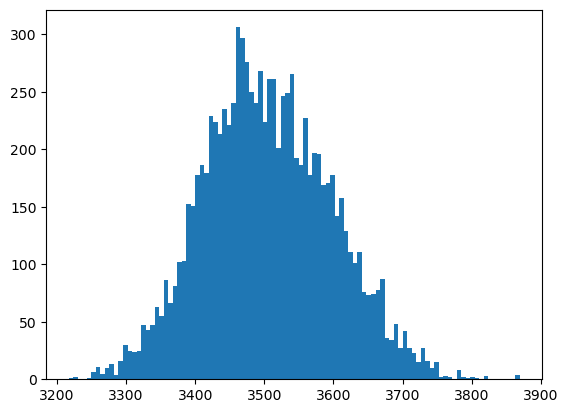

In [47]:
vel_flat = samples[:,0]
mass_flat = samples[:,1]

v_arr, v_bins, foo1 = plt.hist(vel_flat, bins = 100)
plt.show()

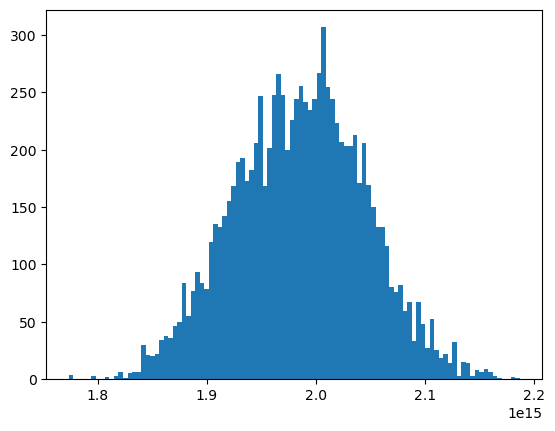

In [48]:
M_arr, M_bins, foo2 = plt.hist(mass_flat, bins = 100)
plt.show()

In [49]:
v_mode=v_bins[np.argmax(v_arr)]
M_mode=M_bins[np.argmax(M_arr)]

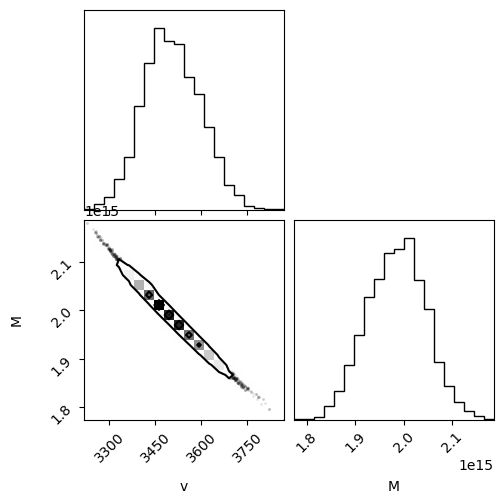

In [52]:
import corner 

labels = ["v", "M"]

fig = corner.corner(
    samples, labels = labels, truths = [4500, 1.5e15]
)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=20.050, z=0.30
		time taken for gettting deflection vector = 4.460016886393229e-05
check me. 
		time taken for get dot product = 4.172325134277344e-07


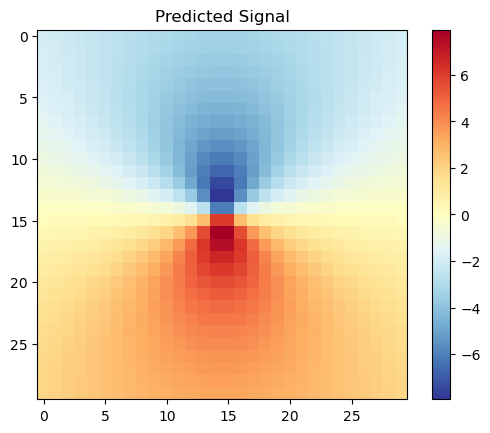

In [53]:
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [M_mode], redshift, v_phi, [v_mode], param_dict, bl = bl2d)
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title("Predicted Signal"); show()

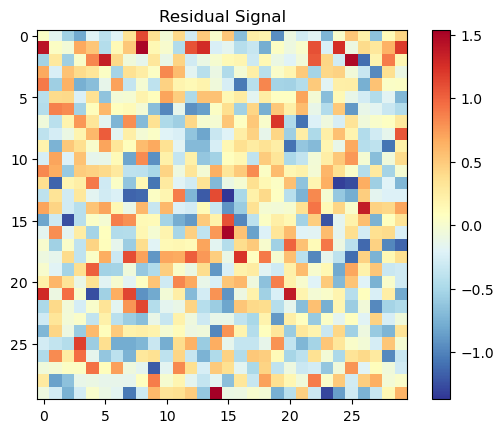

In [54]:
# Despite not being the same mass and velocity values, this mass and velocity gives a surprisingly accurate result.

plt.imshow(mock_signal - mvl_arr[0], cmap = cmap); colorbar(); title("\'Residual\' Signal"); show()

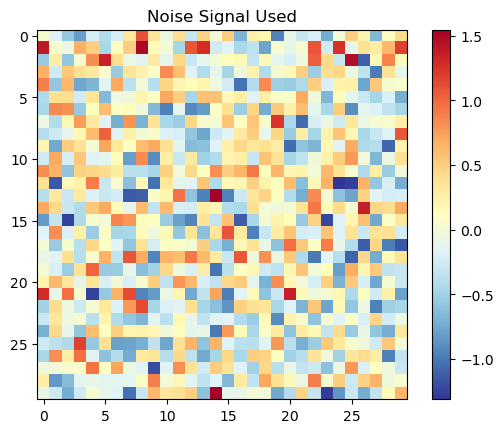

In [55]:
plt.imshow(noise_signal, cmap = cmap); colorbar(); title("Noise Signal Used"); show()